### Open tiff for sample processing

In [1]:
import tkinter as tk
from tkinter import filedialog
import os
# Define the starting folder path
start_path = r'D:\Particle tracking'
root = tk.Tk()
root.withdraw()  # Hide the main window
# Bring the dialog to the front
root.lift()
root.attributes('-topmost', True)
try:
    # Ask user whether to select a folder or a file
    selection_mode = input("Enter '1' to select a folder, or '2' to select a specific TIFF file: ")
    if selection_mode == '1':
        # Allow the user to select a folder starting from the specified start path
        folder_path = filedialog.askdirectory(initialdir=start_path)
        
        if folder_path:
            # List all tif files in the selected folder (including .tif and .ome.tiff)
            tif_files = [os.path.abspath(os.path.join(folder_path, f)) for f in os.listdir(folder_path) 
                         if f.endswith('.tif') or f.endswith('.tiff') or f.endswith('.ome.tiff')]
            
            # If there's only one tif file, store its path in a string
            if len(tif_files) == 1:
                tif_file_path = tif_files[0]
                # Normalize path separators to forward slashes
                tif_file_path = tif_file_path.replace('\\', '/')
                print(f"Tiff file path: {tif_file_path}")
            else:
                # If there are multiple tif files, store their paths in a list
                tif_files = [path.replace('\\', '/') for path in tif_files]
                print(f"List of tiff files in the selected folder: {tif_files}")
                if tif_files:
                    tif_file_path = tif_files[0]
        else:
            print("No folder selected.")
    elif selection_mode == '2':
        # Allow the user to select a TIFF file directly
        tif_file_path = filedialog.askopenfilename(
            initialdir=start_path,
            title="Select TIFF file",
            filetypes=(("TIFF files", "*.tif;*.tiff;*.ome.tiff"), ("All files", "*.*"))
        )
        
        if tif_file_path:
            # Normalize path separators to forward slashes
            tif_file_path = tif_file_path.replace('\\', '/')
            print(f"Selected TIFF file: {tif_file_path}")
        else:
            print("No file selected.")
    else:
        print("Invalid selection mode. Please run the script again and enter either '1' or '2'.")
        
    # Create the metrics and plots directories in advance
    if 'tif_file_path' in locals() and tif_file_path:
        base_dir = os.path.dirname(tif_file_path)
        metrics_dir = os.path.join(base_dir, 'metrics').replace('\\', '/')
        plots_dir = os.path.join(base_dir, 'plots').replace('\\', '/')
        
        # Create directories if they don't exist
        os.makedirs(metrics_dir, exist_ok=True)
        os.makedirs(plots_dir, exist_ok=True)
        
        print(f"Created output directories:")
        print(f"  - {metrics_dir}")
        print(f"  - {plots_dir}")
        
except FileNotFoundError:
    print("File selection canceled by the user.")
except Exception as e:
    print(f"An error occurred: {str(e)}")

Enter '1' to select a folder, or '2' to select a specific TIFF file:  2


Selected TIFF file: C:/Users/Talaial Alina/OneDrive - UCB-O365/Courses/Year 1/Fall Semester Aug-Dec 2020/CHEN 5840 - Independent Study/Hydrogels/Gel microscopy/13OCT25/2% gelatin/25 ug-mL/MSN/6-2; 28 cycles/stitched_image/6-2; 28 cycles_stitched.tiff
Created output directories:
  - C:/Users/Talaial Alina/OneDrive - UCB-O365/Courses/Year 1/Fall Semester Aug-Dec 2020/CHEN 5840 - Independent Study/Hydrogels/Gel microscopy/13OCT25/2% gelatin/25 ug-mL/MSN/6-2; 28 cycles/stitched_image/metrics
  - C:/Users/Talaial Alina/OneDrive - UCB-O365/Courses/Year 1/Fall Semester Aug-Dec 2020/CHEN 5840 - Independent Study/Hydrogels/Gel microscopy/13OCT25/2% gelatin/25 ug-mL/MSN/6-2; 28 cycles/stitched_image/plots


### Adjust brightness of original image

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tifffile
from ipywidgets import interact
import ipywidgets as widgets

def downsample_for_display(image, max_display_pixels=1000000):
    """
    Downsample large images for display purposes only, preserving original data
    """
    h, w = image.shape[:2]
    current_pixels = h * w
    
    # Only downsample if image is too large
    if current_pixels <= max_display_pixels:
        return image, 1
    
    # Calculate downsample factor to get close to target pixel count
    downsample_factor = np.sqrt(current_pixels / max_display_pixels)
    downsample_factor = max(int(downsample_factor), 1)
    
    # Calculate new dimensions
    new_h = h // downsample_factor
    new_w = w // downsample_factor
    
    # Perform downsampling using area interpolation (best for reduction)
    downsampled = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
    
    print(f"Image downsampled for display: {h}x{w} → {new_h}x{new_w} (factor: {downsample_factor}x)")
    return downsampled, downsample_factor

def load_tiff_with_scale(tif_file_path):
    """Load TIFF file and extract scale by parsing the Info field properly"""
    try:
        # Load the image
        loaded_tif = tifffile.imread(tif_file_path)
        
        # Get scale using a more thorough approach
        scale_mm_per_pixel = 0.1  # Default fallback value
        source = "default"
        
        with tifffile.TiffFile(tif_file_path) as tif:
            # Try multiple methods to extract pixel size
            
            # Method 1: Try ImageJ metadata with focus on Info field
            if tif.is_imagej:
                imagej_meta = tif.imagej_metadata
                if imagej_meta:
                    # Check if there's an Info field containing pixel size
                    if 'Info' in imagej_meta:
                        info_text = imagej_meta['Info']
                        
                        # Parse the Info field for pixel size
                        import re
                        pixel_size_match = re.search(r'Pixel\s+size\s*=\s*(\d+(?:\.\d+)?)\s*([\w\u00B5]+)', 
                                                    info_text, re.IGNORECASE)
                        
                        if pixel_size_match:
                            size_value = float(pixel_size_match.group(1))
                            size_unit = pixel_size_match.group(2).lower()
                            
                            # Convert to mm based on unit
                            if 'mm' in size_unit or 'millimeter' in size_unit:
                                scale_mm_per_pixel = size_value
                            elif 'µm' in size_unit or 'um' in size_unit or 'micro' in size_unit:
                                scale_mm_per_pixel = size_value / 1000.0
                            elif 'nm' in size_unit or 'nano' in size_unit:
                                scale_mm_per_pixel = size_value / 1000000.0
                            
                            source = f"ImageJ Info field ({size_value} {size_unit})"
                    
                    # If we didn't find it in Info, try the direct fields
                    elif 'pixelWidth' in imagej_meta and 'unit' in imagej_meta:
                        unit = imagej_meta['unit']
                        pixel_width = imagej_meta['pixelWidth']
                        
                        # Convert to mm based on unit
                        if unit.lower() in ('mm', 'millimeter', 'millimeters'):
                            scale_mm_per_pixel = pixel_width
                        elif unit.lower() in ('µm', 'um', 'micrometer', 'micrometers'):
                            scale_mm_per_pixel = pixel_width / 1000.0
                        elif unit.lower() in ('nm', 'nanometer', 'nanometers'):
                            scale_mm_per_pixel = pixel_width / 1000000.0
                        
                        source = f"ImageJ pixelWidth ({unit})"
            
            # Method 2: Try standard TIFF resolution tags
            if source == "default" and 'XResolution' in tif.pages[0].tags:
                # Existing resolution handling code...
                x_resolution = tif.pages[0].tags['XResolution'].value
                resolution_unit = tif.pages[0].tags.get('ResolutionUnit', 2).value
                
                if isinstance(x_resolution, tuple) and len(x_resolution) == 2:
                    dpi = float(x_resolution[0]) / float(x_resolution[1])
                    
                    if resolution_unit == 2:  # Inches
                        scale_mm_per_pixel = 25.4 / dpi
                        source = "TIFF XResolution (inches)"
                    elif resolution_unit == 3:  # Centimeters
                        scale_mm_per_pixel = 10.0 / dpi
                        source = "TIFF XResolution (cm)"
        
        print(f"Loaded TIFF with shape: {loaded_tif.shape}")
        print(f"Using scale: {scale_mm_per_pixel:.6f} mm/pixel (source: {source})")
        
        return loaded_tif, scale_mm_per_pixel
        
    except Exception as e:
        print(f"Error loading TIFF: {e}")
        return None, 0.1

def apply_pseudo_flatfield(image, kernel_size):
    """Apply pseudo flat field correction using mean filtering"""
    # Ensure kernel size is odd
    kernel_size = max(3, kernel_size + (1 - kernel_size % 2))
    
    # Create pseudo flat field using mean filter
    flat_field = cv2.blur(image.astype(float), (kernel_size, kernel_size))
    
    # Avoid division by zero
    flat_field[flat_field == 0] = 1
    
    # Normalize the image
    corrected = image.astype(float) / flat_field
    
    # Scale to original intensity range
    corrected = corrected * np.mean(flat_field)
    
    return corrected

def setup_image_processing(image, scale_mm_per_pixel=0.1):
    """Setup image processing with interactive sliders and return the processed image"""
    # Dictionary to store the processed image
    processed_result = {'image': None}
    
    # Create downsampled version for display
    display_image, downsample_factor = downsample_for_display(image)
    display_scale = scale_mm_per_pixel * downsample_factor
    
    def update(min_intensity, max_intensity, flatfield_kernel):
        # Process FULL RESOLUTION image for storage
        if flatfield_kernel > 0:
            processed_full = apply_pseudo_flatfield(image, flatfield_kernel)
        else:
            processed_full = image.copy()
            
        # Apply intensity clipping to full resolution
        processed_full = np.clip(processed_full, min_intensity, max_intensity)
            
        # Store the processed full resolution image
        processed_result['image'] = processed_full
            
        # Process DOWNSAMPLED image for display
        if flatfield_kernel > 0:
            # For display, we should adjust kernel size based on downsampling
            display_kernel = max(3, flatfield_kernel // downsample_factor)
            display_kernel = display_kernel + (1 - display_kernel % 2)  # Ensure it's odd
            processed_display = apply_pseudo_flatfield(display_image, display_kernel)
        else:
            processed_display = display_image.copy()
            
        # Apply intensity clipping to display version
        processed_display = np.clip(processed_display, min_intensity, max_intensity)
        
        # Create display version for matplotlib
        plt.clf()
        height, width = processed_display.shape
        
        # Display with original values
        plt.imshow(processed_display, cmap='gray', 
                  extent=[0, width*display_scale, height*display_scale, 0],
                  vmin=min_intensity, vmax=max_intensity)
        
        colorbar = plt.colorbar()
        colorbar.set_label('Pixel Intensity (Original Values)')
        plt.xlabel('Width (mm)')
        plt.ylabel('Height (mm)')
        
        # Add downsampling info to title if applicable
        downsample_info = f" | Display: {100/downsample_factor:.1f}% resolution" if downsample_factor > 1 else ""
        plt.title(f"Min: {min_intensity}, Max: {max_intensity}, Kernel: {flatfield_kernel}\n"
                 f"Scale: {scale_mm_per_pixel:.4f} mm/pixel{downsample_info}")
        
        # Print some stats for the FULL resolution processed image
        print(f"\nCurrent image statistics (full resolution):")
        print(f"Data type: {processed_full.dtype}")
        print(f"Value range: {np.min(processed_full):.1f} to {np.max(processed_full):.1f}")
        print(f"Mean value: {np.mean(processed_full):.1f}")
        
        plt.show()
    
    # Create sliders based on data type
    if image.dtype in [np.float32, np.float64]:
        slider_type = widgets.FloatSlider
    else:
        slider_type = widgets.IntSlider
    
    # Get the full data range
    data_min = float(np.min(image))
    data_max = float(np.max(image))
    
    print(f"Initial image:")
    print(f"Data type: {image.dtype}")
    print(f"Data range: {data_min} to {data_max}")
    
    if downsample_factor > 1:
        print(f"Display: Using {100/downsample_factor:.1f}% resolution for interactive display")
        print(f"Processing: Full resolution ({image.shape}) will be used for final result")
    
    min_slider = slider_type(
        value=data_min,
        min=data_min,
        max=data_max,
        description='Min:',
        style={'description_width': 'initial'},
        readout_format='.1f'
    )
    
    max_slider = slider_type(
        value=data_max,
        min=data_min,
        max=data_max,
        description='Max:',
        style={'description_width': 'initial'},
        readout_format='.1f'
    )
    
    flatfield_slider = widgets.IntSlider(
        value=0,
        min=0,
        max=100,
        step=2,
        description='Flat-field kernel:',
        style={'description_width': 'initial'},
        tooltip='Kernel size for pseudo flat-field correction (0 to disable)'
    )
    
    # Create interactive widget
    widgets.interact(update, 
                    min_intensity=min_slider, 
                    max_intensity=max_slider,
                    flatfield_kernel=flatfield_slider)
    
    # Return the dictionary containing the processed image
    return processed_result

# USAGE - Copy this part to use the code:
loaded_tif, scale_mm_per_pixel = load_tiff_with_scale(tif_file_path)
if loaded_tif is not None:
    processed_result = setup_image_processing(loaded_tif, scale_mm_per_pixel)
    # Access the processed image through:
    processed_image = processed_result['image']




Loaded TIFF with shape: (8397, 17202)
Using scale: 0.003107 mm/pixel (source: TIFF XResolution (cm))
Image downsampled for display: 8397x17202 → 699x1433 (factor: 12x)
Initial image:
Data type: uint16
Data range: 17.0 to 4095.0
Display: Using 8.3% resolution for interactive display
Processing: Full resolution ((8397, 17202)) will be used for final result


interactive(children=(IntSlider(value=17, description='Min:', max=4095, min=17, readout_format='.1f', style=Sl…

In [3]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
# import tifffile
# import ipywidgets as widgets
# from IPython.display import display, clear_output

# def downsample_for_display(image, max_display_pixels=500000):
#     """
#     Downsample large images for display purposes only, preserving original data
#     """
#     h, w = image.shape[:2]
#     current_pixels = h * w
    
#     # Only downsample if image is too large
#     if current_pixels <= max_display_pixels:
#         return image, 1
    
#     # Calculate downsample factor to get close to target pixel count
#     downsample_factor = np.sqrt(current_pixels / max_display_pixels)
#     downsample_factor = max(int(downsample_factor), 1)
    
#     # Calculate new dimensions
#     new_h = h // downsample_factor
#     new_w = w // downsample_factor
    
#     # Perform downsampling using area interpolation (best for reduction)
#     downsampled = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
    
#     print(f"Image downsampled for display: {h}x{w} → {new_h}x{new_w} (factor: {downsample_factor}x)")
#     return downsampled, downsample_factor

# def load_tiff_with_scale(tif_file_path):
#     """Load TIFF file and extract scale from metadata more comprehensively"""
#     try:
#         # Load the image
#         loaded_tif = tifffile.imread(tif_file_path)
        
#         # Get scale using a more thorough approach
#         scale_mm_per_pixel = 0.1  # Default fallback value
#         source = "default"
        
#         with tifffile.TiffFile(tif_file_path) as tif:
#             # Try multiple methods to extract pixel size
            
#             # Method 1: Try ImageJ metadata (most reliable for microscopy)
#             if tif.is_imagej:
#                 imagej_meta = tif.imagej_metadata
#                 if imagej_meta:
#                     # ImageJ stores pixel size in different ways
#                     if 'unit' in imagej_meta and 'pixelWidth' in imagej_meta:
#                         # Direct pixel size
#                         unit = imagej_meta['unit']
#                         pixel_width = imagej_meta['pixelWidth']
                        
#                         # Convert to mm based on unit
#                         if unit.lower() in ('mm', 'millimeter', 'millimeters'):
#                             scale_mm_per_pixel = pixel_width
#                         elif unit.lower() in ('µm', 'um', 'micrometer', 'micrometers'):
#                             scale_mm_per_pixel = pixel_width / 1000.0
#                         elif unit.lower() in ('nm', 'nanometer', 'nanometers'):
#                             scale_mm_per_pixel = pixel_width / 1000000.0
                        
#                         source = f"ImageJ pixelWidth ({unit})"
            
#             # Method 2: Try standard TIFF resolution tags
#             if source == "default" and 'XResolution' in tif.pages[0].tags:
#                 x_resolution = tif.pages[0].tags['XResolution'].value
#                 resolution_unit = tif.pages[0].tags.get('ResolutionUnit', 2).value  # Default is inches (2)
                
#                 if isinstance(x_resolution, tuple) and len(x_resolution) == 2:
#                     dpi = float(x_resolution[0]) / float(x_resolution[1])
                    
#                     if resolution_unit == 2:  # Inches
#                         # Convert from DPI to mm/pixel
#                         scale_mm_per_pixel = 25.4 / dpi
#                         source = "TIFF XResolution (inches)"
#                     elif resolution_unit == 3:  # Centimeters
#                         # Convert from pixels/cm to mm/pixel
#                         scale_mm_per_pixel = 10.0 / dpi
#                         source = "TIFF XResolution (cm)"
        
#         print(f"Loaded TIFF with shape: {loaded_tif.shape}")
#         print(f"Using scale: {scale_mm_per_pixel:.6f} mm/pixel (source: {source})")
        
#         return loaded_tif, scale_mm_per_pixel
        
#     except Exception as e:
#         print(f"Error loading TIFF: {e}")
#         return None, 0.1

# def remove_dust_with_adaptive_threshold(image, block_size=15, sensitivity=5, max_dust_size=6, inpaint_radius=3):
#     """
#     Remove dust using adaptive thresholding which works better for microscopy images
    
#     Parameters:
#     -----------
#     image : ndarray
#         Input image
#     block_size : int
#         Size of pixel neighborhood used for adaptive thresholding (must be odd)
#     sensitivity : int
#         How much to adjust the thresholding (higher = more sensitive to dust)
#     max_dust_size : int
#         Maximum size of dust particles to remove
#     inpaint_radius : int
#         Radius used for inpainting dust areas
        
#     Returns:
#     --------
#     tuple: (cleaned_image, dust_mask)
#     """
#     # Create a copy to work with
#     cleaned = image.copy()
    
#     # Convert to 8-bit for OpenCV operations
#     img_8bit = cv2.normalize(cleaned, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
#     # Ensure block_size is odd
#     block_size = max(3, block_size)
#     if block_size % 2 == 0:
#         block_size += 1
    
#     # Apply adaptive thresholding - finds bright spots on varying backgrounds
#     binary = cv2.adaptiveThreshold(
#         img_8bit,
#         255,
#         cv2.ADAPTIVE_THRESH_MEAN_C,
#         cv2.THRESH_BINARY,
#         block_size,
#         -sensitivity  # Negative to detect bright spots instead of dark
#     )
    
#     # Find connected components
#     num_labels, labels = cv2.connectedComponents(binary)
    
#     # Calculate size of each component
#     sizes = np.bincount(labels.flatten())
    
#     # Create mask of small components (dust)
#     dust_mask = np.zeros_like(binary, dtype=bool)
#     for i in range(1, num_labels):
#         if sizes[i] <= max_dust_size:
#             dust_mask[labels == i] = True
    
#     # Apply inpainting to remove dust
#     mask_uint8 = dust_mask.astype(np.uint8) * 255
#     result = cv2.inpaint(img_8bit, mask_uint8, inpaint_radius, cv2.INPAINT_TELEA)
    
#     # Convert back to original data range
#     result = cv2.normalize(result, None, np.min(cleaned), np.max(cleaned), 
#                           cv2.NORM_MINMAX).astype(cleaned.dtype)
    
#     return result, dust_mask

# def process_tiff_with_adaptive_dust_removal(tif_file_path):
#     """Process TIFF with adaptive dust removal for microscopy images"""
#     try:
#         # Load the image
#         loaded_tif = tifffile.imread(tif_file_path)
#         print(f"Loaded TIFF with shape: {loaded_tif.shape}")
        
#         # Get data range
#         data_min = float(np.min(loaded_tif))
#         data_max = float(np.max(loaded_tif))
#         print(f"Data range: {data_min} to {data_max}")
        
#         # Aggressive downsampling for very large images
#         h, w = loaded_tif.shape[:2]
#         target_pixels = 500000  # Smaller target for better performance
        
#         downsample_factor = int(np.sqrt((h * w) / target_pixels))
#         downsample_factor = max(downsample_factor, 1)
        
#         # Calculate new dimensions
#         new_h = h // downsample_factor
#         new_w = w // downsample_factor
        
#         # Perform downsampling
#         display_image = cv2.resize(loaded_tif, (new_w, new_h), interpolation=cv2.INTER_AREA)
        
#         print(f"Downsampled: {h}x{w} → {new_h}x{new_w} (factor: {downsample_factor}x)")
        
#         # Create dictionary to store results
#         result = {'image': None}
        
#         # Define update function for interactive widgets
#         def update(min_intensity, max_intensity, block_size, sensitivity, max_dust_size, inpaint_radius):
#             # Process DISPLAY IMAGE
#             # Start with a fresh copy
#             processed = display_image.copy()
            
#             # Apply dust removal with adaptive thresholding
#             dust_mask = None
#             if block_size > 0 and sensitivity > 0 and max_dust_size > 0 and inpaint_radius > 0:
#                 # Apply adaptive thresholding dust removal
#                 processed, dust_mask = remove_dust_with_adaptive_threshold(
#                     processed, block_size, sensitivity, max_dust_size, inpaint_radius)
            
#             # Apply intensity clipping
#             processed = np.clip(processed, min_intensity, max_intensity)
            
#             # Display the result
#             plt.clf()
#             fig, axs = plt.subplots(1, 3, figsize=(15, 5))
            
#             # Panel 1: Original image with intensity adjustments
#             axs[0].imshow(np.clip(display_image, min_intensity, max_intensity), cmap='gray')
#             axs[0].set_title("Original")
            
#             # Panel 2: Dust detection (if enabled)
#             if block_size > 0 and sensitivity > 0 and max_dust_size > 0 and inpaint_radius > 0 and dust_mask is not None:
#                 # Create RGB visualization
#                 vis_mask = np.zeros((*display_image.shape, 3))
#                 # Use intensity-adjusted image as background
#                 for c in range(3):
#                     vis_mask[:,:,c] = (np.clip(display_image, min_intensity, max_intensity) - min_intensity) / (max_intensity - min_intensity)
#                 # Mark dust in red
#                 vis_mask[dust_mask, 0] = 1.0  # Red channel
#                 vis_mask[dust_mask, 1] = 0.0  # Green channel
#                 vis_mask[dust_mask, 2] = 0.0  # Blue channel
                
#                 axs[1].imshow(vis_mask)
#                 dust_count = np.sum(dust_mask)
#                 axs[1].set_title(f"Dust ({dust_count} pixels)")
#             else:
#                 axs[1].imshow(np.clip(display_image, min_intensity, max_intensity), cmap='gray')
#                 axs[1].set_title("Dust Detection Disabled")
            
#             # Panel 3: Processed result
#             axs[2].imshow(processed, cmap='gray')
#             axs[2].set_title("Processed Result")
            
#             # Remove axis ticks for cleaner display
#             for ax in axs:
#                 ax.set_xticks([])
#                 ax.set_yticks([])
            
#             # Add title with parameters
#             dust_info = ""
#             if block_size > 0 and sensitivity > 0 and max_dust_size > 0 and inpaint_radius > 0:
#                 dust_info = f" | Dust: Block {block_size}, Sens {sensitivity}, Size {max_dust_size}px, Radius {inpaint_radius}px"
#                 if dust_mask is not None:
#                     dust_info += f" ({np.sum(dust_mask)} pixels)"
                
#             plt.suptitle(f"Preview (1/{downsample_factor}x resolution) | Min: {min_intensity}, Max: {max_intensity}{dust_info}")
#             plt.tight_layout()
#             plt.show()
            
#             # Store current parameters for full processing
#             result['params'] = {
#                 'min_intensity': min_intensity,
#                 'max_intensity': max_intensity,
#                 'block_size': block_size,
#                 'sensitivity': sensitivity,
#                 'max_dust_size': max_dust_size * downsample_factor,  # Scale up for full image
#                 'inpaint_radius': inpaint_radius * downsample_factor  # Scale up for full image
#             }
        
#         # Create sliders
#         min_slider = widgets.IntSlider(
#             value=int(data_min),
#             min=int(data_min),
#             max=int(data_max),
#             description='Min:',
#             step=max(1, int((data_max - data_min) / 100))
#         )
        
#         max_slider = widgets.IntSlider(
#             value=int(data_max),
#             min=int(data_min),
#             max=int(data_max),
#             description='Max:',
#             step=max(1, int((data_max - data_min) / 100))
#         )
        
#         # Adaptive thresholding sliders
#         block_size_slider = widgets.IntSlider(
#             value=15,
#             min=3,
#             max=51,
#             step=2,  # Must be odd
#             description='Block size:',
#             tooltip='Size of neighborhood for adaptive thresholding (must be odd)'
#         )
        
#         sensitivity_slider = widgets.IntSlider(
#             value=5,
#             min=1,
#             max=20,
#             description='Sensitivity:',
#             tooltip='Higher values detect more dust (more sensitive)'
#         )
        
#         max_dust_size_slider = widgets.IntSlider(
#             value=6,
#             min=1,
#             max=20,
#             description='Max dust size:',
#             tooltip='Maximum size of dust particles to remove'
#         )
        
#         inpaint_radius_slider = widgets.IntSlider(
#             value=3,
#             min=1,
#             max=10,
#             description='Inpaint radius:',
#             tooltip='Radius used for inpainting dust areas'
#         )
        
#         # Create reset and process buttons
#         reset_button = widgets.Button(description="Reset")
#         process_button = widgets.Button(description="Process Full Image")
        
#         def on_reset_clicked(b):
#             min_slider.value = int(data_min)
#             max_slider.value = int(data_max)
#             block_size_slider.value = 15
#             sensitivity_slider.value = 5
#             max_dust_size_slider.value = 6
#             inpaint_radius_slider.value = 3
        
#         reset_button.on_click(on_reset_clicked)
        
#         def on_process_clicked(b):
#             # Show a message while processing
#             print("Processing full resolution image... (this might take a while)")
            
#             # Get current parameters
#             params = result['params']
            
#             # Process the full image with the current parameters
#             processed_full = loaded_tif.copy()
            
#             # Apply dust removal if enabled
#             if params['block_size'] > 0 and params['sensitivity'] > 0 and params['max_dust_size'] > 0 and params['inpaint_radius'] > 0:
#                 print("Applying adaptive dust removal to full image...")
                
#                 # Convert to 8-bit for processing
#                 img_8bit = cv2.normalize(processed_full, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
                
#                 # Ensure block size is odd
#                 block_size = max(3, params['block_size'])
#                 if block_size % 2 == 0:
#                     block_size += 1
                
#                 print(f"Using parameters: Block size={block_size}, Sensitivity={params['sensitivity']}, " +
#                      f"Max dust size={params['max_dust_size']}, Inpaint radius={params['inpaint_radius']}")
                
#                 # Apply adaptive thresholding
#                 print("Applying adaptive thresholding...")
#                 binary = cv2.adaptiveThreshold(
#                     img_8bit,
#                     255,
#                     cv2.ADAPTIVE_THRESH_MEAN_C,
#                     cv2.THRESH_BINARY,
#                     block_size,
#                     -params['sensitivity']
#                 )
                
#                 # Find connected components
#                 print("Finding dust spots...")
#                 num_labels, labels = cv2.connectedComponents(binary)
                
#                 # Calculate size of each component
#                 sizes = np.bincount(labels.flatten())
                
#                 # Create mask of small components (dust)
#                 dust_mask = np.zeros_like(binary, dtype=bool)
#                 for i in range(1, num_labels):
#                     if sizes[i] <= params['max_dust_size']:
#                         dust_mask[labels == i] = True
                
#                 # Apply inpainting if dust found
#                 if np.any(dust_mask):
#                     print("Inpainting dust spots...")
#                     mask_uint8 = dust_mask.astype(np.uint8) * 255
#                     inpainted = cv2.inpaint(img_8bit, mask_uint8, params['inpaint_radius'], cv2.INPAINT_TELEA)
                    
#                     # Convert back to original data range
#                     processed_full = cv2.normalize(inpainted, None, np.min(processed_full), np.max(processed_full), 
#                                                 cv2.NORM_MINMAX).astype(processed_full.dtype)
                    
#                     dust_count = np.sum(dust_mask)
#                     print(f"Removed {dust_count} dust pixels from full resolution image")
#                 else:
#                     print("No dust detected in full resolution image.")
            
#             # Apply intensity clipping
#             processed_full = np.clip(processed_full, params['min_intensity'], params['max_intensity'])
            
#             # Store the result
#             result['image'] = processed_full
            
#             # Save the result
#             output_path = tif_file_path.replace('.tif', '_clean.tif')
#             print(f"Saving processed image to: {output_path}")
#             tifffile.imwrite(output_path, processed_full)
            
#             print("Processing complete!")
        
#         process_button.on_click(on_process_clicked)
        
#         # Create interactive UI
#         ui = widgets.interactive_output(
#             update,
#             {
#                 'min_intensity': min_slider,
#                 'max_intensity': max_slider,
#                 'block_size': block_size_slider,
#                 'sensitivity': sensitivity_slider,
#                 'max_dust_size': max_dust_size_slider,
#                 'inpaint_radius': inpaint_radius_slider
#             }
#         )
        
#         # Organize UI elements
#         intensity_box = widgets.HBox([min_slider, max_slider])
#         dust_box = widgets.HBox([block_size_slider, sensitivity_slider])
#         dust_box2 = widgets.HBox([max_dust_size_slider, inpaint_radius_slider])
#         button_box = widgets.HBox([reset_button, process_button])
        
#         # Display the UI
#         display(widgets.VBox([
#             widgets.HTML("<b>Intensity Controls:</b>"),
#             intensity_box,
#             widgets.HTML("<b>Dust Detection (Adaptive Thresholding):</b>"),
#             dust_box,
#             dust_box2,
#             button_box,
#             ui
#         ]))
        
#         # Return the result dictionary
#         return result
    
#     except Exception as e:
#         import traceback
#         print(f"Error processing TIFF: {str(e)}")
#         print(traceback.format_exc())
#         return None

# # Usage Example:
# # Simply call this function with your TIFF file path
# result = process_tiff_with_adaptive_dust_removal(tif_file_path)
# # 


### Select ROI with rectangle containing sample of interest

In [4]:
import math
import numpy as np
import cv2

def downsample_image(image, downsample_factor=None, max_dimension=None):
    """
    Downsample an image using either a direct factor or max dimension.
    
    Parameters:
    - image: Input image
    - downsample_factor: Direct scale factor (e.g., 0.5 reduces to half size)
                         If provided, this takes precedence over max_dimension.
    - max_dimension: Maximum dimension for display (legacy parameter)
    
    Returns:
    - Downsampled image and the scale factor used
    """
    height, width = image.shape[:2]
    
    # Determine scaling factor
    if downsample_factor is not None:
        # Use the provided downsample factor directly
        if downsample_factor <= 0 or downsample_factor > 1.0:
            print(f"Warning: Invalid downsample_factor {downsample_factor}, must be in (0, 1]. Using 1.0")
            scale_factor = 1.0
        else:
            scale_factor = downsample_factor
    elif max_dimension is not None:
        # Calculate based on max dimension (original behavior)
        scale_factor = min(1.0, max_dimension / max(height, width))
    else:
        # Default: no downsampling
        scale_factor = 1.0
    
    # Apply downsampling if scale factor is less than 1
    if scale_factor < 1.0:
        new_width = int(width * scale_factor)
        new_height = int(height * scale_factor)
        print(f"Downsampling image from {width}x{height} to {new_width}x{new_height} (factor: {scale_factor})")
        return cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA), scale_factor
    
    return image, 1.0

def convert_16bit_to_8bit(image, clip_limit=0.1, min_val=None, max_val=None):
    """
    Convert 16-bit image to 8-bit with improved contrast and detail preservation.
    """
    img_float = image.astype(float)
    
    if min_val is None or max_val is None:
        # Use percentile clipping if no manual values provided
        lower_bound = np.percentile(img_float, clip_limit)
        upper_bound = np.percentile(img_float, 100 - clip_limit)
    else:
        # Use provided values
        lower_bound = float(min_val)
        upper_bound = float(max_val)
    
    # Ensure we have a non-zero range to avoid division by zero
    if lower_bound >= upper_bound:
        upper_bound = lower_bound + 1  # Ensure at least a range of 1
    
    img_clipped = np.clip(img_float, lower_bound, upper_bound)
    
    # Safe division with fallback for identical bounds
    denominator = upper_bound - lower_bound
    if denominator == 0:
        denominator = 1.0
        
    img_scaled = ((img_clipped - lower_bound) / denominator * 255.0)
    
    # Handle any NaN or Inf values that may have been produced
    img_scaled = np.nan_to_num(img_scaled)
    
    img_scaled = np.clip(img_scaled, 0, 255)
    img_8bit = img_scaled.astype(np.uint8)
    
    return img_8bit

def adjust_display_brightness(image, downsample_factor=None):
    """
    Interactive brightness adjustment window for display purposes.
    
    Parameters:
    - image: Input image
    - downsample_factor: Optional factor for downsampling (0.5 = half size)
    """
    # Downsample image for display if it's too large
    downsampled_image, scale_factor = downsample_image(image, downsample_factor=downsample_factor, max_dimension=1920)

    window_name = 'Adjust Brightness'
    
    # Create window with normal flag first
    cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
    cv2.setWindowProperty(window_name, cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)
    cv2.setWindowProperty(window_name, cv2.WND_PROP_TOPMOST, 1)

    # Get actual data range from the image
    data_min = int(np.min(downsampled_image))
    data_max = int(np.max(downsampled_image))
    print(f"Image range: {data_min} to {data_max}")

    # Initial values using actual image range
    min_val = data_min
    max_val = data_max
    kernel_size = 0

    def apply_pseudo_flatfield(img, ksize):
        if ksize > 0:
            background = cv2.blur(img.astype(float), (ksize, ksize))
            background = np.clip(background, 1, None)
            corrected = (img.astype(float) / background) * np.mean(background)
            return corrected
        return img.astype(float)

    def update_image(*args):
        nonlocal min_val, max_val, kernel_size
        
        # Get values from trackbars
        min_val = cv2.getTrackbarPos('Min Intensity', window_name)
        max_val = cv2.getTrackbarPos('Max Intensity', window_name)
        kernel_size = cv2.getTrackbarPos('Kernel Size', window_name)
        if kernel_size % 2 == 0:  # Ensure kernel size is odd
            kernel_size += 1

        # Apply corrections to a copy of the downsampled image
        temp_img = downsampled_image.copy()
        if kernel_size > 1:
            temp_img = apply_pseudo_flatfield(temp_img, kernel_size)

        # Convert to 8-bit for display
        display_img = convert_16bit_to_8bit(temp_img, min_val=min_val, max_val=max_val)

        # Convert to BGR for display if needed
        if len(display_img.shape) == 2:
            display_img = cv2.cvtColor(display_img, cv2.COLOR_GRAY2BGR)

        # Show current settings on the image
        text_color = (255, 255, 255)
        cv2.putText(display_img, f'Min: {min_val}', (10, 30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, text_color, 2)
        cv2.putText(display_img, f'Max: {max_val}', (10, 60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, text_color, 2)
        cv2.putText(display_img, f'Kernel: {kernel_size}', (10, 90), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, text_color, 2)

        cv2.imshow(window_name, display_img)

    # Create trackbars with full image range
    cv2.createTrackbar('Min Intensity', window_name, data_min, data_max, update_image)
    cv2.createTrackbar('Max Intensity', window_name, data_max, data_max, update_image)
    cv2.createTrackbar('Kernel Size', window_name, 0, 99, update_image)

    # Show initial image
    update_image()

    while True:
        key = cv2.waitKey(1) & 0xFF
        
        if key == ord('q'):
            cv2.destroyWindow(window_name)
            return None, None
            
        elif key == ord('r'):  # Reset
            cv2.setTrackbarPos('Min Intensity', window_name, data_min)
            cv2.setTrackbarPos('Max Intensity', window_name, data_max)
            cv2.setTrackbarPos('Kernel Size', window_name, 0)
            
        elif key == 13:  # Enter
            # Make a clean copy of the original image (not the downsampled one)
            clean_display = image.copy()

            # Apply pseudo-flatfield first (if needed) on the original image
            if kernel_size > 1:
                clean_display = apply_pseudo_flatfield(clean_display, kernel_size)

            # Now that brightness is adjusted, print detailed info
            print("\nFinal brightness adjustment:")
            print(f"Original range: {clean_display.min()}-{clean_display.max()}")
            lower_bound = min_val if min_val is not None else np.percentile(clean_display, 0.1)
            upper_bound = max_val if max_val is not None else np.percentile(clean_display, 99.9)
            print(f"Clipped range: {lower_bound:.1f}-{upper_bound:.1f}")
            
            # Convert using the function
            clean_display = convert_16bit_to_8bit(clean_display, min_val=min_val, max_val=max_val)
            print(f"Output range: {clean_display.min()}-{clean_display.max()}")

            if len(clean_display.shape) == 2:
                clean_display = cv2.cvtColor(clean_display, cv2.COLOR_GRAY2BGR)

            cv2.destroyWindow(window_name)
            settings = {
                'min_intensity': min_val,
                'max_intensity': max_val,
                'kernel_size': kernel_size
            }
            return settings, clean_display


def draw_rotatable_rect(image, scale_mm_per_pixel, previous_selections=[], display_image=None,
                        width_mm=9, height_mm=70, downsample_factor=None):
    """
    Draw a rotatable rectangle with resizable handles like in PowerPoint.
    Controls:
    - Left click & drag center: Move rectangle
    - Right click & drag: Rotate rectangle
    - Left click & drag handles: Resize
    - R: Reset rectangle to original dimensions
    - Enter: Confirm selection
    - Q: Quit without selection
    
    Parameters:
    - image: Input image
    - scale_mm_per_pixel: Scale factor for converting mm to pixels
    - previous_selections: List of previous selections
    - display_image: Optional pre-processed display image
    - width_mm: Width of rectangle in mm
    - height_mm: Height of rectangle in mm
    - downsample_factor: Optional factor for downsampling (0.5 = half size)
    """
    # Store original image (16-bit)
    original_image = image.copy()
    original_height, original_width = original_image.shape[:2]
    
    # Downsample the image for display if not provided
    if display_image is None:
        # Downsample the image for display using the provided factor
        downsampled_image, scale_factor = downsample_image(image, downsample_factor=downsample_factor, max_dimension=1920)
        
        # Create display image from downsampled image
        base_display_image = convert_16bit_to_8bit(downsampled_image, clip_limit=0.1)
        if len(base_display_image.shape) == 2:
            base_display_image = cv2.cvtColor(base_display_image, cv2.COLOR_GRAY2BGR)
    else:
        # Use provided display image
        base_display_image = display_image.copy()
        # Calculate scale factor from original to display image
        display_height, display_width = base_display_image.shape[:2]
        scale_factor = min(display_width / original_width, display_height / original_height)
    
    # Get downsampled dimensions
    display_height, display_width = base_display_image.shape[:2]
    
    # Convert millimeters to pixels using scale_mm_per_pixel
    width_pixels = int(width_mm / scale_mm_per_pixel * scale_factor)
    height_pixels = int(height_mm / scale_mm_per_pixel * scale_factor)
    
    # Print the conversion for debugging
    print(f"Using scale: {scale_mm_per_pixel} mm/pixel")
    print(f"Converting {width_mm}mm x {height_mm}mm → {width_pixels}px x {height_pixels}px (display scale)")
    
    # Initial rectangle parameters - center in the display
    center_x = display_width // 2
    center_y = display_height // 2
    angle = 0
    
    # Store original dimensions for reset functionality
    original_width_pixels = width_pixels
    original_height_pixels = height_pixels
    
    # All the state variables
    dragging_center = False
    rotating = False
    resizing = False
    active_handle = None
    start_x = start_y = 0
    start_angle = 0
    start_width = width_pixels
    start_height = height_pixels
    
    # Create functions for handle points, closest handle, point_inside_polygon, etc.
    def get_handle_points(corners):
        handles = {}
        # Corner handles
        handles['top_left'] = corners[0]
        handles['top_right'] = corners[1]
        handles['bottom_right'] = corners[2]
        handles['bottom_left'] = corners[3]
        
        # Midpoint handles
        handles['top'] = (corners[0] + corners[1]) // 2
        handles['right'] = (corners[1] + corners[2]) // 2
        handles['bottom'] = (corners[2] + corners[3]) // 2
        handles['left'] = (corners[3] + corners[0]) // 2
        return handles
    
    def get_closest_handle(x, y, handles):
        min_dist = float('inf')
        closest = None
        for name, pos in handles.items():
            dist = np.sqrt((pos[0] - x)**2 + (pos[1] - y)**2)
            if dist < min_dist and dist < 25:  # Increased from 15 to 25 to match larger handles
                min_dist = dist
                closest = name
        return closest
    
    def point_inside_polygon(point, polygon):
        """Check if a point is inside a polygon using ray casting algorithm"""
        x, y = point
        n = len(polygon)
        inside = False
        
        p1x, p1y = polygon[0]
        for i in range(n + 1):
            p2x, p2y = polygon[i % n]
            if y > min(p1y, p2y):
                if y <= max(p1y, p2y):
                    if x <= max(p1x, p2x):
                        if p1y != p2y:
                            xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                        if p1x == p2x or x <= xinters:
                            inside = not inside
            p1x, p1y = p2x, p2y
        
        return inside
    
    def get_rect_points():
        half_width = width_pixels // 2
        half_height = height_pixels // 2
        corners = np.array([
            [-half_width, -half_height],
            [half_width, -half_height],
            [half_width, half_height],
            [-half_width, half_height]
        ], dtype=np.float32)
        
        rad = np.deg2rad(angle)
        rot_mat = np.array([
            [np.cos(rad), -np.sin(rad)],
            [np.sin(rad), np.cos(rad)]
        ])
        corners = np.dot(corners, rot_mat.T)
        
        corners[:, 0] += center_x
        corners[:, 1] += center_y
        
        return corners.astype(np.int32)
    
    def resize_rect(handle_name, dx, dy):
        nonlocal width_pixels, height_pixels
        
        rad = np.deg2rad(-angle)
        rot_mat = np.array([
            [np.cos(rad), -np.sin(rad)],
            [np.sin(rad), np.cos(rad)]
        ])
        rotated_delta = np.dot([dx, dy], rot_mat)
        dx_rot, dy_rot = rotated_delta
        
        if handle_name in ['left', 'right']:
            width_change = dx_rot * 2 if 'right' in handle_name else -dx_rot * 2
            width_pixels = max(10, start_width + int(width_change))
        elif handle_name in ['top', 'bottom']:
            height_change = dy_rot * 2 if 'bottom' in handle_name else -dy_rot * 2
            height_pixels = max(10, start_height + int(height_change))
        else:
            width_change = dx_rot * 2 if 'right' in handle_name else -dx_rot * 2
            height_change = dy_rot * 2 if 'bottom' in handle_name else -dy_rot * 2
            width_pixels = max(10, start_width + int(width_change))
            height_pixels = max(10, start_height + int(height_change))
    
    def draw_rect(img, previous_selections=[]):
        # Always start with a fresh copy of the base display image
        img_copy = base_display_image.copy()
        
        # Draw all previous selections first
        for prev in previous_selections:
            # Scale previous coordinates to display scale
            prev_corners = np.array(prev['coords']['corners'], dtype=np.float32)
            # Convert from original scale to display scale
            prev_corners_display = prev_corners * scale_factor
            prev_corners_display = prev_corners_display.astype(np.int32)
            
            for i in range(4):
                cv2.line(img_copy, 
                        tuple(prev_corners_display[i]), 
                        tuple(prev_corners_display[(i+1)%4]), 
                        (0, 255, 255), 15)
            
            # Draw previous replicate number
            prev_center_x = int(prev['coords']['center_x'] * scale_factor)
            prev_center_y = int(prev['coords']['center_y'] * scale_factor)
            prev_height = int(prev['coords']['height'] * scale_factor)
            
            text = f"Replicate {prev['replicate_number']}"
            (text_w, text_h), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 4.0, 10)
            text_x = prev_center_x - text_w//2
            text_y = prev_center_y - prev_height//2 - 50
            
            # Draw text background
            cv2.rectangle(img_copy,
                         (text_x - 25, text_y - text_h - 25),
                         (text_x + text_w + 25, text_y + 25),
                         (0, 0, 0), -1)
            
            # Draw text
            cv2.putText(img_copy, text,
                       (text_x, text_y),
                       cv2.FONT_HERSHEY_SIMPLEX,
                       4.0, (0, 255, 255), 10)
        
        # Draw current selection
        corners = get_rect_points()
        handles = get_handle_points(corners)
        
        # Draw current rectangle
        for i in range(4):
            cv2.line(img_copy, tuple(corners[i]), tuple(corners[(i+1)%4]), (0, 0, 0), 24)
            cv2.line(img_copy, tuple(corners[i]), tuple(corners[(i+1)%4]), (255, 255, 0), 18)
        
        # Draw handles
        for pos in handles.values():
            cv2.circle(img_copy, tuple(pos), 35, (0, 0, 0), -1)
            cv2.circle(img_copy, tuple(pos), 28, (0, 255, 255), -1)
            cv2.circle(img_copy, tuple(pos), 15, (0, 0, 0), -1)
        
        # Draw center point
        cv2.circle(img_copy, (center_x, center_y), 35, (0, 0, 0), -1)
        cv2.circle(img_copy, (center_x, center_y), 28, (0, 255, 255), -1)
        cv2.circle(img_copy, (center_x, center_y), 15, (0, 0, 0), -1)
        
        # Draw current replicate number
        text = f'Replicate {len(previous_selections) + 1}'
        (text_w, text_h), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 4.0, 10)
        text_x = center_x - text_w//2
        text_y = center_y - height_pixels//2 - 50
        
        # Draw text background
        cv2.rectangle(img_copy,
                     (text_x - 25, text_y - text_h - 25),
                     (text_x + text_w + 25, text_y + 25),
                     (0, 0, 0), -1)
        
        # Draw text
        cv2.putText(img_copy, text,
                   (text_x, text_y),
                   cv2.FONT_HERSHEY_SIMPLEX,
                   4.0, (255, 255, 0), 10)
        
        # Display dimensions
        real_width = width_pixels / scale_factor * scale_mm_per_pixel
        real_height = height_pixels / scale_factor * scale_mm_per_pixel
        
        # Use a smaller font size
        dimension_font_size = 2.0
        dimension_thickness = 5
        
        # Position text with margins
        margin = 30
        line_spacing = 60
        
        # Width measurement
        text = f'Width: {real_width:.1f} mm'
        (text_w, text_h), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, dimension_font_size, dimension_thickness)
        
        # Position for first line
        text_x = margin
        text_y = margin + text_h
        
        # Background box
        cv2.rectangle(img_copy, 
                     (text_x - 10, text_y - text_h - 10),
                     (text_x + text_w + 10, text_y + 10),
                     (0, 0, 0), -1)
        
        # Text
        cv2.putText(img_copy, text, (text_x, text_y), 
                   cv2.FONT_HERSHEY_SIMPLEX, dimension_font_size, (255, 255, 0), dimension_thickness)
        
        # Height measurement
        text = f'Height: {real_height:.1f} mm'
        (text_w, text_h), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, dimension_font_size, dimension_thickness)
        
        # Position for second line
        text_x = margin
        text_y = margin + text_h + line_spacing
        
        # Background box
        cv2.rectangle(img_copy, 
                     (text_x - 10, text_y - text_h - 10),
                     (text_x + text_w + 10, text_y + 10),
                     (0, 0, 0), -1)
        
        # Text
        cv2.putText(img_copy, text, (text_x, text_y), 
                   cv2.FONT_HERSHEY_SIMPLEX, dimension_font_size, (255, 255, 0), dimension_thickness)
        
        # Angle measurement
        text = f'Angle: {angle:.1f}°'
        (text_w, text_h), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, dimension_font_size, dimension_thickness)
        
        # Position for third line
        text_x = margin
        text_y = margin + text_h + line_spacing * 2
        
        # Background box
        cv2.rectangle(img_copy, 
                     (text_x - 10, text_y - text_h - 10),
                     (text_x + text_w + 10, text_y + 10),
                     (0, 0, 0), -1)
        
        # Text
        cv2.putText(img_copy, text, (text_x, text_y), 
                   cv2.FONT_HERSHEY_SIMPLEX, dimension_font_size, (255, 255, 0), dimension_thickness)
        
        return img_copy, handles
    
    def mouse_callback(event, x, y, flags, param):
        nonlocal dragging_center, rotating, resizing, start_x, start_y, center_x, center_y
        nonlocal angle, start_angle, active_handle, start_width, start_height
        
        if event == cv2.EVENT_LBUTTONDOWN:
            temp_img, handles = draw_rect(base_display_image, previous_selections)
            active_handle = get_closest_handle(x, y, handles)
            
            if active_handle:
                resizing = True
                start_x = x
                start_y = y
                start_width = width_pixels
                start_height = height_pixels
            elif abs(x - center_x) < 25 and abs(y - center_y) < 25:
                # Clicked on center point
                dragging_center = True
                start_x = x - center_x
                start_y = y - center_y
            else:
                # Check if clicked inside rectangle
                corners = get_rect_points()
                if point_inside_polygon((x, y), corners):
                    dragging_center = True
                    start_x = x - center_x
                    start_y = y - center_y
            
        elif event == cv2.EVENT_RBUTTONDOWN:
            rotating = True
            start_x = x
            start_y = y
            start_angle = angle
            
        elif event == cv2.EVENT_MOUSEMOVE:
            if dragging_center:
                center_x = x - start_x
                center_y = y - start_y
            elif rotating:
                dx = x - center_x
                dy = y - center_y
                current_angle = math.degrees(math.atan2(dy, dx))
                dx_start = start_x - center_x
                dy_start = start_y - center_y
                start_ref_angle = math.degrees(math.atan2(dy_start, dx_start))
                angle = start_angle + (current_angle - start_ref_angle)
                angle = angle % 360
            elif resizing and active_handle:
                dx = x - start_x
                dy = y - start_y
                resize_rect(active_handle, dx, dy)
            
            temp_img, _ = draw_rect(base_display_image, previous_selections)
            cv2.imshow(window_name, temp_img)
            
        elif event in [cv2.EVENT_LBUTTONUP, cv2.EVENT_RBUTTONUP]:
            dragging_center = False
            rotating = False
            resizing = False
            active_handle = None
    
    # Create window and set callback
    window_name = 'Draw Rotatable Rectangle'
    
    # Create window with normal flag first
    cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
    
    # Maximize the window
    cv2.setWindowProperty(window_name, cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)
    
    # Ensure window stays on top
    cv2.setWindowProperty(window_name, cv2.WND_PROP_TOPMOST, 1)
    
    cv2.setMouseCallback(window_name, mouse_callback)
    
    # Show initial rectangle
    initial_display, _ = draw_rect(base_display_image, previous_selections)
    cv2.imshow(window_name, initial_display)
    
    while True:
        key = cv2.waitKey(1) & 0xFF
        
        if key == ord('q'):
            cv2.destroyWindow(window_name)
            return None, None
            
        elif key == ord('r'):
            # Reset to original position and dimensions
            center_x = display_width // 2
            center_y = display_height // 2
            angle = 0
            width_pixels = original_width_pixels
            height_pixels = original_height_pixels
            temp_img, _ = draw_rect(base_display_image, previous_selections)
            cv2.imshow(window_name, temp_img)
            
        elif key == 13:  # Enter
            # First destroy the current window completely
            cv2.destroyWindow(window_name)
            cv2.waitKey(1)  # This is important to fully destroy the window
            
            # Get the corners in display coordinates
            display_corners = get_rect_points()
            
            # Scale the corners back to original image coordinates
            original_corners = display_corners.astype(np.float32) / scale_factor
            original_corners = original_corners.astype(np.int32)
            
            # Scale other parameters back to original image size
            original_center_x = int(center_x / scale_factor)
            original_center_y = int(center_y / scale_factor)
            original_width = int(width_pixels / scale_factor)
            original_height = int(height_pixels / scale_factor)
            
            # Create a mask the same size as our original image
            mask = np.zeros_like(original_image)
            
            # Draw filled rotated rectangle on the mask
            cv2.fillPoly(mask, [original_corners], 65535)  # Use max value for 16-bit
            
            # Apply mask to get only the region we want
            masked = cv2.bitwise_and(original_image, mask)
            
            # Get bounds of the rotated rectangle
            x_min = max(0, int(np.min(original_corners[:, 0])))
            y_min = max(0, int(np.min(original_corners[:, 1])))
            x_max = min(original_image.shape[1], int(np.max(original_corners[:, 0])))
            y_max = min(original_image.shape[0], int(np.max(original_corners[:, 1])))
            
            # Crop to bounds
            roi = masked[y_min:y_max, x_min:x_max]
            
            coordinates = {
                'center_x': original_center_x,
                'center_y': original_center_y,
                'width': original_width,
                'height': original_height,
                'angle': angle,
                'corners': original_corners.tolist(),
                'roi_x': x_min,
                'roi_y': y_min
            }
            
            return roi, coordinates

def process_with_rotatable_rect(processed_image, scale_mm_per_pixel, width_mm=9, height_mm=70, downsample_factor=None):
    """
    Process an image with rotatable rectangle selection using provided scale and optional downsample factor
    
    Parameters:
    - processed_image: Input image
    - scale_mm_per_pixel: Scale factor for converting mm to pixels
    - width_mm: Width of rectangle in mm (default: 9mm)
    - height_mm: Height of rectangle in mm (default: 70mm)
    - downsample_factor: Optional factor for downsampling (0.5 = half size)
    """
    
    # Define a tolerance range for the scale check
    scale_tolerance = 0.01  # 1% tolerance
    
    # Check for scale ~0.001625 mm/pixel (1.625 µm/pixel)
    if abs(scale_mm_per_pixel - 0.001625) <= scale_tolerance * 0.001625:
        # If scale is approximately 0.001625 mm/pixel (1.625 µm/pixel), use these dimensions
        width_mm = 9
        height_mm = 20
        print(f"Scale detected as approximately {scale_mm_per_pixel:.6f} mm/pixel.")
        print(f"Setting ROI rectangle to {width_mm} mm width × {height_mm} mm height.")
    
    # Check for scale ~0.003 mm/pixel (3.1074 µm/pixel)
    elif 0.0028 <= scale_mm_per_pixel <= 0.0034:
        # If scale is approximately 0.003 mm/pixel (3.1 µm/pixel), use these dimensions
        width_mm = 9
        height_mm = 25
        print(f"Scale detected as approximately {scale_mm_per_pixel:.6f} mm/pixel.")
        print(f"Setting ROI rectangle to {width_mm} mm width × {height_mm} mm height.")
        
    # Check for scale ~0.00863167457483515 mm/pixel
    elif abs(scale_mm_per_pixel - 0.00863167457483515) <= scale_tolerance:
        # If scale is approximately 0.00863167457483515 mm/pixel, use these dimensions
        width_mm = 9
        height_mm = 30
        print(f"Scale detected as approximately {scale_mm_per_pixel:.6f} mm/pixel.")
        print(f"Setting ROI rectangle to {width_mm} mm width × {height_mm} mm height.")
    
    # Check for scale ~0.01 mm/pixel
    elif abs(scale_mm_per_pixel - 0.01) <= scale_tolerance:
        # If scale is approximately 0.01 mm/pixel, use these dimensions
        width_mm = 9
        height_mm = 70
        print(f"Scale detected as approximately {scale_mm_per_pixel:.3f} mm/pixel.")
        print(f"Setting ROI rectangle to {width_mm} mm width × {height_mm} mm height.")
        
    # Check for scale ~0.1 mm/pixel
    elif abs(scale_mm_per_pixel - 0.1) <= scale_tolerance:
        # If scale is approximately 0.1 mm/pixel, use these dimensions
        width_mm = 9
        height_mm = 70
        print(f"Scale detected as approximately {scale_mm_per_pixel:.3f} mm/pixel.")
        print(f"Setting ROI rectangle to {width_mm} mm width × {height_mm} mm height.")
    
    if processed_image is not None:
        # First adjust brightness
        print("Adjust brightness settings for display. Press Enter to confirm or 'q' to quit")
        brightness_settings, adjusted_display_image = adjust_display_brightness(processed_image, downsample_factor=downsample_factor)
        
        if brightness_settings is None:
            print("Brightness adjustment cancelled")
            # Use default conversion for display
            adjusted_display_image = convert_16bit_to_8bit(processed_image)
            if len(adjusted_display_image.shape) == 2:
                adjusted_display_image = cv2.cvtColor(adjusted_display_image, cv2.COLOR_GRAY2BGR)
        else:
            print(f"Brightness settings: {brightness_settings}")
        
        # Ask for number of replicates
        num_replicates = int(input("Enter number of replicates to process (e.g., 3): "))
        all_replicates = []
        
        # Process each replicate using the adjusted display image
        for i in range(num_replicates):
            print(f"\nSelecting ROI for replicate {i+1}/{num_replicates}")
            print("Draw rectangle around the replicate, press Enter to confirm or 'q' to quit")
            
            # Create a fresh copy of the adjusted display image for each replicate
            clean_display_image = adjusted_display_image.copy()
            
            # Pass the clean display image to draw_rotatable_rect along with the extracted scale
            roi, coords = draw_rotatable_rect(processed_image,  
                                           scale_mm_per_pixel=scale_mm_per_pixel,
                                           previous_selections=all_replicates,
                                           display_image=clean_display_image,
                                           width_mm=width_mm,
                                           height_mm=height_mm,
                                           downsample_factor=downsample_factor)
            
            if roi is not None and coords is not None:
                all_replicates.append({
                    'replicate_number': i+1,
                    'roi': roi,
                    'coords': coords,
                    'scale_mm_per_pixel': scale_mm_per_pixel  # Store the scale with each replicate
                })
                print(f"Replicate {i+1} ROI captured successfully")
            else:
                print(f"Failed to capture ROI for replicate {i+1}")
                continue
                
        return all_replicates
    else:
        print("No processed image available")
        return None
        
# Example usage
if __name__ == "__main__":
    # Example usage with downsample factor
    # Assuming you have a loaded image and scale_mm_per_pixel
    # processed_result = {'image': your_image}
    # scale_mm_per_pixel = your_scale_value
    
    replicates = process_with_rotatable_rect(
        processed_result['image'],      # Use processed image
        scale_mm_per_pixel,             # Use the extracted scale
        downsample_factor=0.1           # Downsample to 10% of original size
    )
    
    print("Import this module and call process_with_rotatable_rect() with a downsample_factor")


Scale detected as approximately 0.003107 mm/pixel.
Setting ROI rectangle to 9 mm width × 25 mm height.
Adjust brightness settings for display. Press Enter to confirm or 'q' to quit
Downsampling image from 17202x8397 to 1720x839 (factor: 0.1)
Image range: 34 to 350

Final brightness adjustment:
Original range: 17-4095
Clipped range: 34.0-42.0
Output range: 0-255
Brightness settings: {'min_intensity': 34, 'max_intensity': 42, 'kernel_size': 1}


Enter number of replicates to process (e.g., 3):  6



Selecting ROI for replicate 1/6
Draw rectangle around the replicate, press Enter to confirm or 'q' to quit
Using scale: 0.0031074020087503364 mm/pixel
Converting 9mm x 25mm → 2896px x 8045px (display scale)
Replicate 1 ROI captured successfully

Selecting ROI for replicate 2/6
Draw rectangle around the replicate, press Enter to confirm or 'q' to quit
Using scale: 0.0031074020087503364 mm/pixel
Converting 9mm x 25mm → 2896px x 8045px (display scale)
Replicate 2 ROI captured successfully

Selecting ROI for replicate 3/6
Draw rectangle around the replicate, press Enter to confirm or 'q' to quit
Using scale: 0.0031074020087503364 mm/pixel
Converting 9mm x 25mm → 2896px x 8045px (display scale)
Replicate 3 ROI captured successfully

Selecting ROI for replicate 4/6
Draw rectangle around the replicate, press Enter to confirm or 'q' to quit
Using scale: 0.0031074020087503364 mm/pixel
Converting 9mm x 25mm → 2896px x 8045px (display scale)
Replicate 4 ROI captured successfully

Selecting ROI f

### Rotate image

In [5]:
import cv2
import numpy as np
import math

def process_replicates(all_replicates, scale_mm_per_pixel):
    """
    Process all replicates with enhanced navigation and reset features.
    """
    current_replicate_idx = 0
    
    while current_replicate_idx < len(all_replicates):
        replicate = all_replicates[current_replicate_idx]
        roi = replicate['roi']
        coords = replicate['coords']
        replicate_number = replicate['replicate_number']
        
        print(f"\nProcessing Replicate {replicate_number}")
        print(f"ROI shape: {roi.shape}")
        print(f"ROI range: {roi.min()}-{roi.max()}")
        print("Coordinates:", coords)
        
        # Auto-determine downsample factor based on image size
        h, w = roi.shape[:2]
        if max(h, w) > 2000:
            downsample_factor = max(1, max(h, w) // 1000)
        else:
            downsample_factor = 1
            
        # Process current replicate
        rotated_roi, rotated_display = process_single_replicate(roi, 
                                                              replicate_number,
                                                              scale_mm_per_pixel,
                                                              downsample_factor=downsample_factor)
        
        # Check for quit signal first
        if isinstance(rotated_roi, str) and rotated_roi == "QUIT":
            print("Exiting program...")
            return False  # Signal that we quit
            
        # Check for None result
        if rotated_roi is None:  # User pressed 'b' to go back to beginning
            print("Restarting from beginning...")
            current_replicate_idx = 0
            continue
        
        # Check for string result (using isinstance to avoid numpy array comparison)
        if isinstance(rotated_roi, str) and rotated_roi == "SKIP":  # User pressed a number key
            target_replicate = int(rotated_display)  # Using rotated_display to pass the target number
            if 1 <= target_replicate <= len(all_replicates):
                current_replicate_idx = target_replicate - 1
                print(f"Jumping to replicate {target_replicate}")
                continue
            else:
                print(f"Invalid replicate number. Please enter 1-{len(all_replicates)}")
                continue
        
        # If we get here, we should have valid rotated images
        if isinstance(rotated_roi, np.ndarray):  # Check if we have a valid numpy array
            print(f"Replicate {replicate_number} ROI rotated successfully")
            print(f"Rotated ROI shape: {rotated_roi.shape}")
            print(f"Rotated ROI range: {rotated_roi.min()}-{rotated_roi.max()}")
            
            replicate['rotated_roi'] = rotated_roi
            replicate['rotated_display'] = rotated_display
            current_replicate_idx += 1
        else:
            print(f"Failed to rotate ROI for Replicate {replicate_number}")
            print(f"Unexpected result type: {type(rotated_roi)}")
            return False  # Exit if we get an unexpected result type
    
    return True  # Signal successful completion


def convert_16bit_to_8bit(image, min_intensity, max_intensity, max_display_value=255):
    """
    Convert 16-bit image to 8-bit with user-controlled intensity range.
    Args:
        image: Input image (16-bit)
        min_intensity: Minimum intensity value for display
        max_intensity: Maximum intensity value for display
        max_display_value: Maximum value in output 8-bit image (0-255)
    """
    if image.dtype != np.uint16:
        return image
    
    # Create a copy and ensure floating point for calculations
    img_float = image.astype(float)
    
    # Ensure min and max are different to avoid division by zero
    if min_intensity >= max_intensity:
        min_intensity = max_intensity - 1
    
    # Clip and normalize to 0-1 range using user-defined bounds
    img_clipped = np.clip(img_float, min_intensity, max_intensity)
    
    # Add small epsilon to denominator to prevent division by zero
    img_normalized = (img_clipped - min_intensity) / max(max_intensity - min_intensity, 1e-6)
    
    # Scale to desired maximum value and convert to 8-bit
    img_8bit = np.clip(img_normalized * max_display_value, 0, max_display_value).astype(np.uint8)
    
    return img_8bit

def process_single_replicate(roi, replicate_number, scale_mm_per_pixel, downsample_factor=None):
    """Process a single replicate with rotation and reset capabilities."""
    while True:
        try:
            rotator = ImageRotator(roi, scale_mm_per_pixel, str(replicate_number), 
                                  downsample_factor=downsample_factor)
            result = rotator.run()
            
            if result == "QUIT":
                return "QUIT", None
            
            if result == "RETRY":
                continue
                
            if result == "BACK":
                return None, None
                
            if isinstance(result, tuple) and len(result) == 2:
                if isinstance(result[0], str) and result[0] == "JUMP":
                    return "SKIP", result[1]
                elif isinstance(result[0], np.ndarray):  # Valid rotation result
                    return result
            
            # If we get here, something unexpected happened
            print(f"Unexpected result type: {type(result)}")
            return None, None
            
        except Exception as e:
            print(f"Error in process_single_replicate: {str(e)}")
            return None, None

class ImageRotator:
    def __init__(self, image_array, scale_mm_per_pixel, replicate_number="1", downsample_factor=None):
        # Store original image at full resolution
        self.original_image = image_array
        if self.original_image is None:
            raise ValueError("Invalid image array")
            
        self.full_resolution_image = self.original_image.copy()
        
        # Determine if we should downsample based on image size
        h, w = self.original_image.shape[:2]
        if downsample_factor is None:
            # Auto-determine downsample factor based on image size
            if max(h, w) > 2000:
                downsample_factor = max(1, max(h, w) // 1000)
            else:
                downsample_factor = 1
                
        self.downsample_factor = downsample_factor
        
        # Create downsampled version for display/interaction
        if self.downsample_factor > 1:
            display_h = h // self.downsample_factor
            display_w = w // self.downsample_factor
            self.display_original = cv2.resize(self.original_image, (display_w, display_h), 
                                             interpolation=cv2.INTER_AREA)
            print(f"Downsampled image for display: {self.display_original.shape}")
        else:
            self.display_original = self.original_image.copy()
            
        # Store original for rotation and set correct intensity range
        self.min_possible = float(self.display_original.min())
        self.max_possible = float(self.display_original.max())
        
        print(f"Image range: {self.min_possible} - {self.max_possible}")  # Debug print
        
        # Initialize intensity range controls to actual image range
        self.min_intensity = self.min_possible
        self.max_intensity = self.max_possible  # Make sure this is actually set to max_possible
        
        # Rest of initialization stays the same...
        self.replicate_number = str(replicate_number)
        
        # Ruler properties - adjust scale for downsampling
        self.scale_mm_per_pixel = scale_mm_per_pixel * (self.downsample_factor if self.downsample_factor > 1 else 1)
        self.ruler_length_mm = 7
        self.ruler_length_pixels = int(self.ruler_length_mm / self.scale_mm_per_pixel)
        self.moving_ruler = False
        
        # Create initial display version
        self.display_image = convert_16bit_to_8bit(self.display_original, 
                                                  self.min_intensity,
                                                  self.max_intensity)
        
        # Window setup
        self.window_size = (400, 400)
        self.display_image = self.resize_image(self.display_image, self.window_size)
        
        ruler_x = 175
        ruler_y = self.window_size[1] - 50
        self.ruler_pos = [ruler_x, ruler_y]
            
        self.angle = 0
        self.dragging = False
        self.last_x = None
        self.last_y = None
        
        # Create window
        self.window_name = f"Image Rotator - Replicate {self.replicate_number}"
        cv2.namedWindow(self.window_name)
        
        # Move window to a reasonable default position
        cv2.moveWindow(self.window_name, 450, 100)
        
        # Resize window
        cv2.resizeWindow(self.window_name, self.window_size[0], self.window_size[1])
        
        # Create trackbars with proper value ranges
        def angle_callback(value):
            self.angle = value
            self.update_display()
            
        def min_intensity_callback(value):
            self.min_intensity = float(value)
            if self.min_intensity >= self.max_intensity:
                self.min_intensity = self.max_intensity - 1
                cv2.setTrackbarPos('Min Intensity', self.window_name, int(self.min_intensity))
            self.update_display()
            
        def max_intensity_callback(value):
            self.max_intensity = float(value)
            if self.max_intensity <= self.min_intensity:
                self.max_intensity = self.min_intensity + 1
                cv2.setTrackbarPos('Max Intensity', self.window_name, int(self.max_intensity))
            self.update_display()
        
        # Initialize trackbars with correct ranges and initial values
        cv2.createTrackbar('Angle', self.window_name, 0, 360, angle_callback)
        cv2.createTrackbar('Min Intensity', self.window_name, 
                          int(self.min_intensity),  # Start at actual min
                          int(self.max_possible), 
                          min_intensity_callback)
        cv2.createTrackbar('Max Intensity', self.window_name,
                          int(self.max_possible),  # Start at actual max
                          int(self.max_possible),
                          max_intensity_callback)
        
        cv2.setMouseCallback(self.window_name, self.mouse_callback)
        self.update_display()


    def resize_image(self, image, target_size):
        """Resize image maintaining aspect ratio and padding with zeros."""
        height, width = image.shape[:2]
        scale = min(target_size[0]/width, target_size[1]/height)
        new_width = int(width * scale)
        new_height = int(height * scale)
        resized = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
        
        # Create padded image
        if len(image.shape) == 2:
            final_image = np.zeros((target_size[1], target_size[0]), dtype=np.uint8)
        else:
            final_image = np.zeros((target_size[1], target_size[0], 3), dtype=np.uint8)
            
        y_offset = (target_size[1] - new_height) // 2
        x_offset = (target_size[0] - new_width) // 2
        
        final_image[y_offset:y_offset+new_height, x_offset:x_offset+new_width] = resized
        return final_image

    def get_rotated_image(self):
        """Get the rotated version of the full resolution image."""
        try:
            # First rotate the full resolution image for return
            height, width = self.full_resolution_image.shape[:2]
            center = (width // 2, height // 2)
            
            rotation_matrix = cv2.getRotationMatrix2D(center, self.angle, 1.0)
            
            # Calculate new dimensions
            cos = np.abs(rotation_matrix[0, 0])
            sin = np.abs(rotation_matrix[0, 1])
            new_width = int((height * sin) + (width * cos))
            new_height = int((height * cos) + (width * sin))
            
            # Adjust translation
            rotation_matrix[0, 2] += (new_width / 2) - center[0]
            rotation_matrix[1, 2] += (new_height / 2) - center[1]
            
            # Perform rotation on full resolution image
            rotated = cv2.warpAffine(self.full_resolution_image, 
                                   rotation_matrix, 
                                   (new_width, new_height),
                                   flags=cv2.INTER_LINEAR,
                                   borderMode=cv2.BORDER_REPLICATE)
            
            # Create display version at appropriate resolution
            if self.downsample_factor > 1:
                h, w = rotated.shape[:2]
                display_h = h // self.downsample_factor
                display_w = w // self.downsample_factor
                rotated_display = cv2.resize(rotated, (display_w, display_h), interpolation=cv2.INTER_AREA)
            else:
                rotated_display = rotated.copy()
                
            rotated_display = convert_16bit_to_8bit(rotated_display, 
                                                  self.min_intensity,
                                                  self.max_intensity)
            
            return rotated, rotated_display
            
        except Exception as e:
            print(f"Error in rotation: {str(e)}")
            return None, None

    def run(self):
        """Main loop for the image rotator."""
        print("\nControls:")
        print("- Drag the blue circle to rotate")
        print("- Use the Angle trackbar to adjust rotation")
        print("- Use Min/Max Intensity trackbars to adjust contrast")
        print("- Drag the ruler to move it")
        print("- Press 'r' to reset current replicate")
        print("- Press 'b' to restart from beginning")
        print("- Press number keys (1-9) to jump to specific replicate")
        print("- Press Enter to confirm rotation")
        print("- Press 'q' to quit")
        
        while True:
            try:
                key = cv2.waitKey(1) & 0xFF
                
                if key == ord('r'):
                    self.reset_state()
                    return "RETRY"
                    
                elif key == ord('b'):
                    cv2.destroyWindow(self.window_name)
                    return "BACK"
                    
                elif ord('1') <= key <= ord('9'):
                    cv2.destroyWindow(self.window_name)
                    target_replicate = key - ord('0')
                    return ("JUMP", target_replicate)
                    
                elif key == 13:  # Enter key
                    result = self.get_rotated_image()
                    cv2.destroyWindow(self.window_name)
                    return result
                    
                elif key == ord('q'):
                    cv2.destroyWindow(self.window_name)
                    return "QUIT"
                    
            except Exception as e:
                print(f"Error in run loop: {str(e)}")
                cv2.destroyWindow(self.window_name)
                return None, None

    # Add the missing methods
    def on_min_intensity_trackbar(self, value):
        self.min_intensity = float(value)
        if self.min_intensity >= self.max_intensity:
            self.min_intensity = self.max_intensity - 1
            cv2.setTrackbarPos('Min Intensity', self.window_name, int(self.min_intensity))
        self.update_display()
    
    def on_max_intensity_trackbar(self, value):
        self.max_intensity = float(value)
        if self.max_intensity <= self.min_intensity:
            self.max_intensity = self.min_intensity + 1
            cv2.setTrackbarPos('Max Intensity', self.window_name, int(self.max_intensity))
        self.update_display()

    def on_angle_trackbar(self, value):
        self.angle = value
        self.update_display()

    def reset_state(self):
        """Reset rotation and intensity settings."""
        self.angle = 0
        self.min_intensity = self.min_possible
        self.max_intensity = self.max_possible
        cv2.setTrackbarPos('Angle', self.window_name, 0)
        cv2.setTrackbarPos('Min Intensity', self.window_name, int(self.min_intensity))
        cv2.setTrackbarPos('Max Intensity', self.window_name, int(self.max_intensity))
        self.update_display()

    def update_display(self):
        """Update the display window with current settings."""
        try:
            # Get current trackbar values
            current_angle = cv2.getTrackbarPos('Angle', self.window_name)
            current_min = cv2.getTrackbarPos('Min Intensity', self.window_name)
            current_max = cv2.getTrackbarPos('Max Intensity', self.window_name)
            
            # Update class values from trackbars
            self.angle = current_angle
            self.min_intensity = float(current_min)
            self.max_intensity = float(current_max)
            
            # Convert downsampled image to display version with current intensity settings
            display_img = convert_16bit_to_8bit(self.display_original, 
                                              self.min_intensity,
                                              self.max_intensity)
            display_img = self.resize_image(display_img, self.window_size)
            
            # Rotate the display image
            height, width = display_img.shape[:2]
            center = (width // 2, height // 2)
            rotation_matrix = cv2.getRotationMatrix2D(center, self.angle, 1.0)
            rotated = cv2.warpAffine(display_img, rotation_matrix, (width, height))
            
            # Convert to color for display
            if len(rotated.shape) == 2:
                rotated_colored = cv2.cvtColor(rotated, cv2.COLOR_GRAY2BGR)
            else:
                rotated_colored = rotated
            
            # Draw rotation handle
            radius = min(width, height) // 3
            handle_x = center[0] + int(radius * math.cos(math.radians(self.angle - 90)))
            handle_y = center[1] + int(radius * math.sin(math.radians(self.angle - 90)))
            cv2.circle(rotated_colored, (handle_x, handle_y), 12, (255, 0, 0), -1)
            
            # Draw ruler
            rotated_colored = self.draw_ruler(rotated_colored)
            
            # Finally display the image
            cv2.imshow(self.window_name, rotated_colored)
            
        except Exception as e:
            print(f"Error in update_display: {str(e)}")

    def draw_ruler(self, img):
        """Draw the measurement ruler on the image."""
        try:
            # Calculate display scale using the same logic as resize_image
            height, width = self.display_original.shape[:2]
            scale = min(self.window_size[0]/width, self.window_size[1]/height)
            
            # Calculate ruler length in display pixels
            # Note: self.ruler_length_pixels is already adjusted for downsampling in __init__
            ruler_display_length = int(self.ruler_length_pixels * scale)
            
            # Draw main line
            cv2.line(img, 
                    (self.ruler_pos[0], self.ruler_pos[1]),
                    (self.ruler_pos[0] + ruler_display_length, self.ruler_pos[1]),
                    (0, 255, 0), 2)
            
            # Draw end ticks
            tick_height = 10
            cv2.line(img,
                    (self.ruler_pos[0], self.ruler_pos[1]),
                    (self.ruler_pos[0], self.ruler_pos[1] - tick_height),
                    (0, 255, 0), 2)
            cv2.line(img,
                    (self.ruler_pos[0] + ruler_display_length, self.ruler_pos[1]),
                    (self.ruler_pos[0] + ruler_display_length, self.ruler_pos[1] - tick_height),
                    (0, 255, 0), 2)
            
            # Add label
            cv2.putText(img,
                      f'{self.ruler_length_mm}mm',
                      (self.ruler_pos[0], self.ruler_pos[1] - 15),
                      cv2.FONT_HERSHEY_SIMPLEX,
                      0.5,
                      (0, 255, 0),
                      1)
            
            return img
                
        except Exception as e:
            print(f"Error in draw_ruler: {str(e)}")
            return img


    def mouse_callback(self, event, x, y, flags, param):
        """Handle mouse events for rotation and ruler movement."""
        try:
            height, width = self.display_image.shape[:2]
            center = (width // 2, height // 2)
            radius = min(width, height) // 3
            
            handle_x = center[0] + int(radius * math.cos(math.radians(self.angle - 90)))
            handle_y = center[1] + int(radius * math.sin(math.radians(self.angle - 90)))
            
            # Check if mouse is near ruler
            near_ruler = (abs(y - self.ruler_pos[1]) < 10 and 
                         self.ruler_pos[0] <= x <= (self.ruler_pos[0] + self.ruler_length_pixels))
            
            if event == cv2.EVENT_LBUTTONDOWN:
                if np.sqrt((x - handle_x)**2 + (y - handle_y)**2) < 20:
                    self.dragging = True
                    self.moving_ruler = False
                    self.last_x = x
                    self.last_y = y
                elif near_ruler:
                    self.moving_ruler = True
                    self.dragging = False
                    self.last_x = x
                    self.last_y = y
                    
            elif event == cv2.EVENT_MOUSEMOVE:
                if self.dragging and self.last_x is not None and self.last_y is not None:
                    # Calculate rotation angle from mouse movement
                    angle1 = np.degrees(np.arctan2(self.last_y - center[1], 
                                                 self.last_x - center[0]))
                    angle2 = np.degrees(np.arctan2(y - center[1], 
                                                 x - center[0]))
                    
                    delta_angle = angle2 - angle1
                    self.angle = (self.angle + delta_angle) % 360
                    
                    cv2.setTrackbarPos('Angle', self.window_name, int(self.angle))
                    
                    self.last_x = x
                    self.last_y = y
                    
                    self.update_display()
                    
                elif self.moving_ruler and self.last_x is not None and self.last_y is not None:
                    # Move ruler with mouse
                    dx = x - self.last_x
                    dy = y - self.last_y
                    self.ruler_pos[0] += dx
                    self.ruler_pos[1] += dy
                    self.last_x = x
                    self.last_y = y
                    self.update_display()
                    
            elif event == cv2.EVENT_LBUTTONUP:
                self.dragging = False
                self.moving_ruler = False
                self.last_x = None
                self.last_y = None
                
        except Exception as e:
            print(f"Error in mouse_callback: {str(e)}")


def rotate_processed_image(processed_image, scale_mm_per_pixel):
    try:
        # Auto-determine downsample factor based on image size
        h, w = processed_image.shape[:2]
        if max(h, w) > 2000:
            downsample_factor = max(1, max(h, w) // 1000)
        else:
            downsample_factor = 1
            
        rotator = ImageRotator(processed_image, scale_mm_per_pixel, 
                              downsample_factor=downsample_factor)
        rotated_image, display_image = rotator.run()
        return rotated_image, display_image
    except Exception as e:
        print(f"Error: {str(e)}")
        return None, None

# Usage example:
if __name__ == "__main__":
    try:
        # Process replicates and check return value
        success = process_replicates(replicates, scale_mm_per_pixel)
        if not success:
            print("Processing terminated early.")
        else:
            print("All replicates processed successfully.")
            
    except Exception as e:
        print(f"Error occurred: {str(e)}")
        print(f"Error type: {type(e)}")
        import traceback
        traceback.print_exc()

# After processing, all_replicates will contain the rotated ROIs
# You can access them like this:
# all_replicates[i]['rotated_roi'] for the i-th replicate

# After processing, all_replicates will contain the rotated ROIs
# You can access them like this:
# all_replicates[i]['rotated_roi'] for the i-th replicate


Processing Replicate 1
ROI shape: (7910, 2896)
ROI range: 20-4095
Coordinates: {'center_x': 1761, 'center_y': 3888, 'width': 2896, 'height': 8045, 'angle': 0, 'corners': [[313, -134], [3209, -134], [3209, 7910], [313, 7910]], 'roi_x': 313, 'roi_y': 0}
Downsampled image for display: (1130, 413)
Image range: 34.0 - 632.0

Controls:
- Drag the blue circle to rotate
- Use the Angle trackbar to adjust rotation
- Use Min/Max Intensity trackbars to adjust contrast
- Drag the ruler to move it
- Press 'r' to reset current replicate
- Press 'b' to restart from beginning
- Press number keys (1-9) to jump to specific replicate
- Press Enter to confirm rotation
- Press 'q' to quit
Replicate 1 ROI rotated successfully
Rotated ROI shape: (7910, 2896)
Rotated ROI range: 20-4095

Processing Replicate 2
ROI shape: (8005, 2896)
ROI range: 19-4095
Coordinates: {'center_x': 4341, 'center_y': 3983, 'width': 2896, 'height': 8045, 'angle': 0, 'corners': [[2893, -39], [5789, -39], [5789, 8005], [2893, 8005]],

### Apply image filters

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# Global dictionary to store latest adjusted images
global_adjusted_replicates = {}

def apply_pseudo_flatfield(image, kernel_size=0):
    if kernel_size > 0:
        background = cv2.blur(image, (kernel_size, kernel_size))
        background = np.clip(background, 1e-6, None)
        corrected = (image.astype(np.float32) / background) * np.mean(background)
        return corrected.astype(image.dtype)
    else:
        return image
        
def downsample_for_display(image, max_display_pixels=1000000):
    """
    Downsample large images for display purposes only, preserving original data
    """
    h, w = image.shape[:2]
    current_pixels = h * w
    
    # Only downsample if image is too large
    if current_pixels <= max_display_pixels:
        return image, 1
    
    # Calculate downsample factor to get close to target pixel count
    downsample_factor = np.sqrt(current_pixels / max_display_pixels)
    downsample_factor = max(int(downsample_factor), 1)
    
    # Calculate new dimensions
    new_h = h // downsample_factor
    new_w = w // downsample_factor
    
    # Perform downsampling using area interpolation (best for reduction)
    downsampled = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
    
    print(f"Image downsampled for display: {h}x{w} → {new_h}x{new_w} (factor: {downsample_factor}x)")
    return downsampled, downsample_factor

def adjust_roi(rotated_roi, replicate_number, scale_mm_per_pixel):
    # Get data range
    data_min = float(np.min(rotated_roi))
    data_max = float(np.max(rotated_roi))
    
    # Create sliders
    min_slider = widgets.FloatSlider(
        value=data_min,
        min=data_min,
        max=data_max,
        description='Min:',
        style={'description_width': 'initial'},
        continuous_update=True
    )
    
    max_slider = widgets.FloatSlider(
        value=data_max,
        min=data_min,
        max=data_max,
        description='Max:',
        style={'description_width': 'initial'},
        continuous_update=True
    )
    
    kernel_slider = widgets.IntSlider(
        value=0,
        min=0,
        max=100,
        step=2,
        description='Kernel:',
        style={'description_width': 'initial'},
        continuous_update=True
    )
    
    output = widgets.Output()
    
    # Downsample only for display, keeping original for processing
    display_roi, downsample_factor = downsample_for_display(rotated_roi)
    
    # Adjust scale for downsampled display
    display_scale_mm_per_pixel = scale_mm_per_pixel * downsample_factor
    
    # Create a state dictionary to store current values
    current_state = {
        'adjusted_image': None,
        'parameters': {
            'min_intensity': min_slider.value,
            'max_intensity': max_slider.value,
            'flatfield_kernel': kernel_slider.value
        }
    }
    
    def update_image(change):
        with output:
            clear_output(wait=True)
            
            # Process the FULL RESOLUTION image for storage
            if kernel_slider.value > 0:
                processed_full = apply_pseudo_flatfield(rotated_roi, kernel_slider.value)
            else:
                processed_full = rotated_roi.copy()
            
            # Apply intensity clipping to full resolution
            adjusted_full = np.clip(processed_full, min_slider.value, max_slider.value)
            
            # Store full resolution result in current state and global dict
            current_state['adjusted_image'] = adjusted_full
            current_state['parameters'].update({
                'min_intensity': min_slider.value,
                'max_intensity': max_slider.value,
                'flatfield_kernel': kernel_slider.value
            })
            
            # Store in global dictionary (full resolution)
            global_adjusted_replicates[replicate_number] = adjusted_full
            
            # Process DOWNSAMPLED image for display
            if kernel_slider.value > 0:
                processed_display = apply_pseudo_flatfield(display_roi, kernel_slider.value)
            else:
                processed_display = display_roi.copy()
                
            # Apply intensity clipping to display version
            adjusted_display = np.clip(processed_display, min_slider.value, max_slider.value)
            
            # Get dimensions of display version
            height, width = adjusted_display.shape
            
            # Create and display new figure
            plt.figure(figsize=(8, 6))
            plt.imshow(adjusted_display,
                      cmap='gray',
                      extent=[0, width*display_scale_mm_per_pixel, height*display_scale_mm_per_pixel, 0],
                      vmin=min_slider.value,
                      vmax=max_slider.value)
            plt.colorbar(label='Pixel Intensity')
            plt.xlabel('Width (mm)')
            plt.ylabel('Height (mm)')
            plt.title(f"Replicate {replicate_number} - Min: {min_slider.value:.1f}, Max: {max_slider.value:.1f}, Kernel: {kernel_slider.value}")
            plt.show()
            plt.close()
    
    # Connect all sliders
    min_slider.observe(update_image, names='value')
    max_slider.observe(update_image, names='value')
    kernel_slider.observe(update_image, names='value')
    
    # Create controls layout
    print(f"\n=== Replicate {replicate_number} ===")
    if downsample_factor > 1:
        print(f"Note: Displaying at {100/downsample_factor:.1f}% resolution, processing at full resolution")
    controls = widgets.VBox([min_slider, max_slider, kernel_slider])
    
    # Display widgets
    display(controls)
    display(output)
    
    # Initial display
    update_image({'new': min_slider.value})
    
    return current_state

def adjust_multiple_rois(all_replicates):
    # Sort replicates by replicate number
    sorted_replicates = sorted(all_replicates, key=lambda x: x['replicate_number'])
    
    for replicate in sorted_replicates:
        rep_num = replicate['replicate_number']
        rotated_roi = replicate.get('rotated_roi')
        
        if rotated_roi is None:
            print(f"No rotated ROI found for Replicate {rep_num}")
            continue
        
        # Get the scale from the replicate itself (with fallback to default)
        replicate_scale = replicate.get('scale_mm_per_pixel', 0.1)
        
        # Get the state object that will track changes, using the replicate's scale
        state = adjust_roi(rotated_roi, rep_num, replicate_scale)
        
        # Store reference to state and adjusted image in replicate
        replicate['current_state'] = state
        replicate['adjusted_roi'] = global_adjusted_replicates[rep_num]
    
    return sorted_replicates

# Usage:
# 1. First run the adjustment function
adjusted_replicates = adjust_multiple_rois(replicates)

#
# 2. Access the latest adjusted images at any time:
# latest_image_1 = global_adjusted_replicates[1]  # gets latest version of replicate 1
# latest_image_2 = global_adjusted_replicates[2]  # gets latest version of replicate 2


Image downsampled for display: 7910x2896 → 1977x724 (factor: 4x)

=== Replicate 1 ===
Note: Displaying at 25.0% resolution, processing at full resolution


Output()

Image downsampled for display: 8005x2896 → 2001x724 (factor: 4x)

=== Replicate 2 ===
Note: Displaying at 25.0% resolution, processing at full resolution


Output()

Image downsampled for display: 8044x2896 → 2011x724 (factor: 4x)

=== Replicate 3 ===
Note: Displaying at 25.0% resolution, processing at full resolution


Output()

Image downsampled for display: 8184x3313 → 1636x662 (factor: 5x)

=== Replicate 4 ===
Note: Displaying at 20.0% resolution, processing at full resolution


Output()

Image downsampled for display: 8044x2896 → 2011x724 (factor: 4x)

=== Replicate 5 ===
Note: Displaying at 25.0% resolution, processing at full resolution


Output()

Image downsampled for display: 8044x2896 → 2011x724 (factor: 4x)

=== Replicate 6 ===
Note: Displaying at 25.0% resolution, processing at full resolution


Output()

### Draw gel mask


NOW PROCESSING REPLICATE 1 of 6
Draw the gel mask, then:
- Press Enter to confirm
- Press 'r' to reset
- Press 'q' to skip this replicate


C:\Users\Talaial Alina\AppData\Local\Temp\ipykernel_44684\350968334.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis_cmap = cm.get_cmap('viridis')


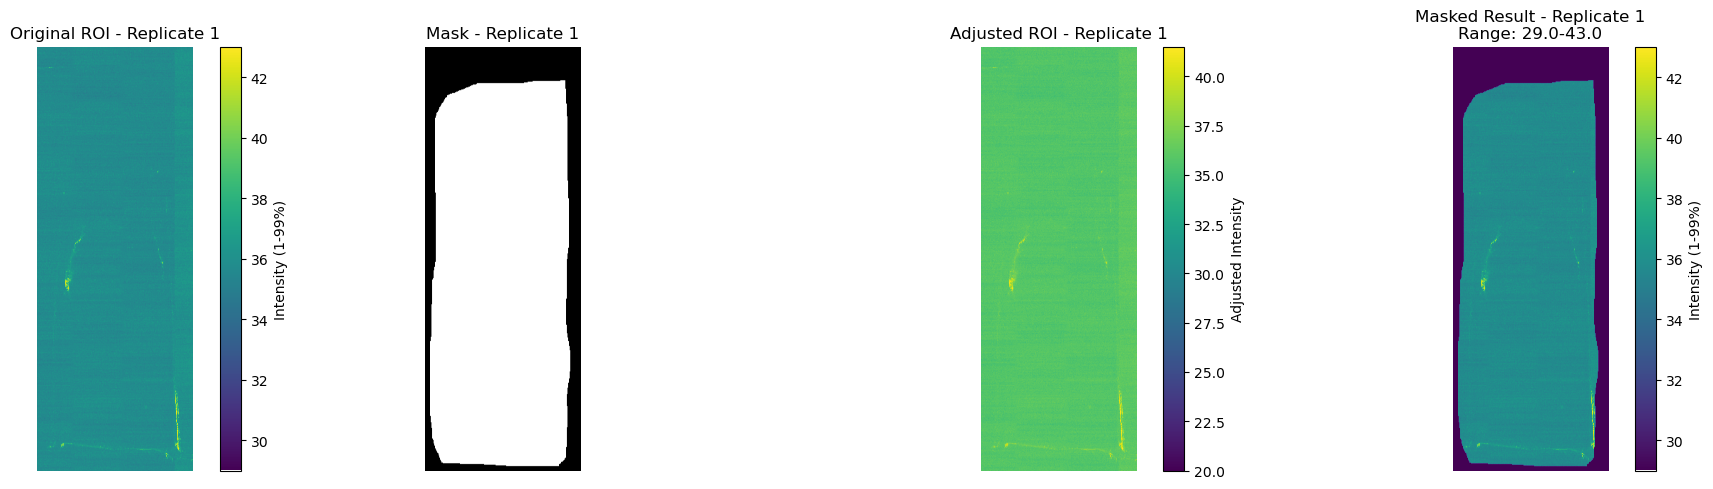


Press Enter to continue to Replicate 2... 



NOW PROCESSING REPLICATE 2 of 6
Draw the gel mask, then:
- Press Enter to confirm
- Press 'r' to reset
- Press 'q' to skip this replicate


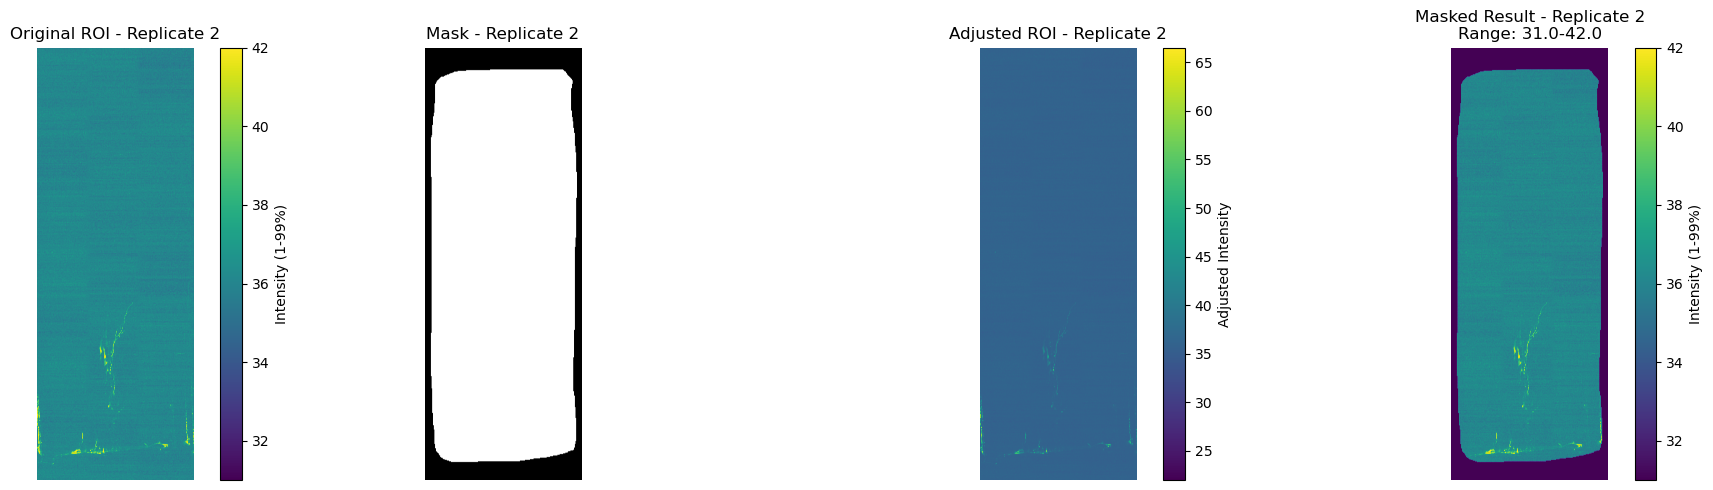


Press Enter to continue to Replicate 3... 



NOW PROCESSING REPLICATE 3 of 6
Draw the gel mask, then:
- Press Enter to confirm
- Press 'r' to reset
- Press 'q' to skip this replicate


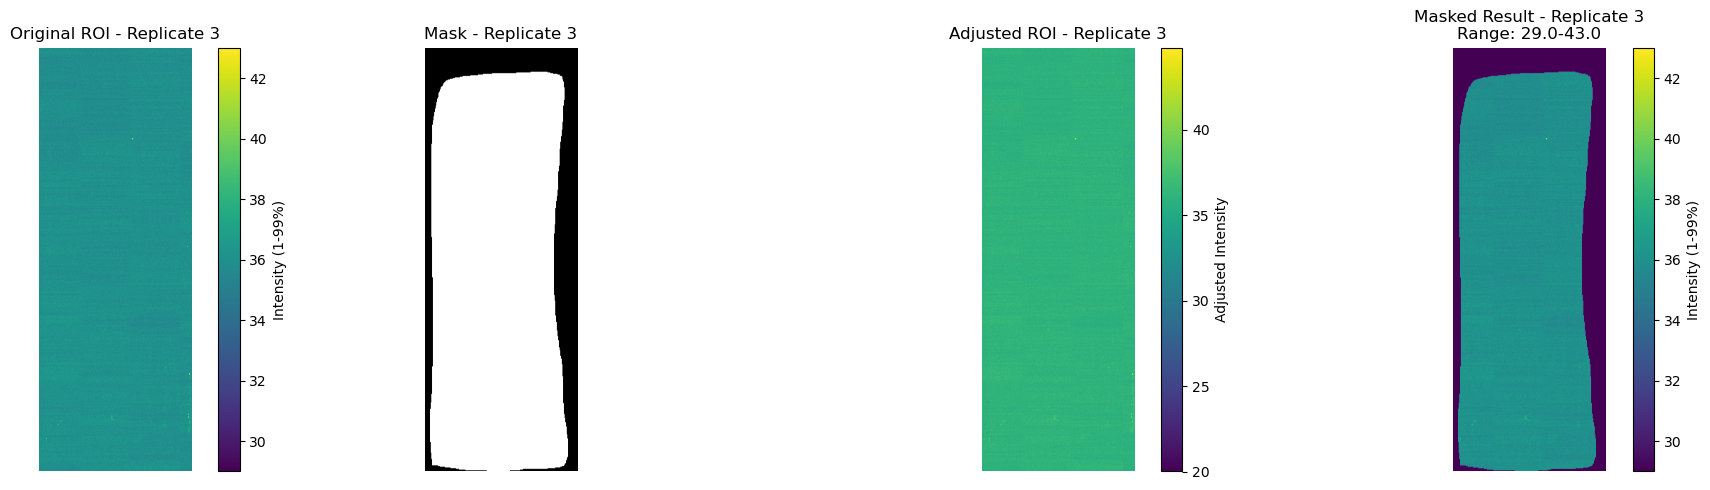


Press Enter to continue to Replicate 4... 



NOW PROCESSING REPLICATE 4 of 6
Draw the gel mask, then:
- Press Enter to confirm
- Press 'r' to reset
- Press 'q' to skip this replicate


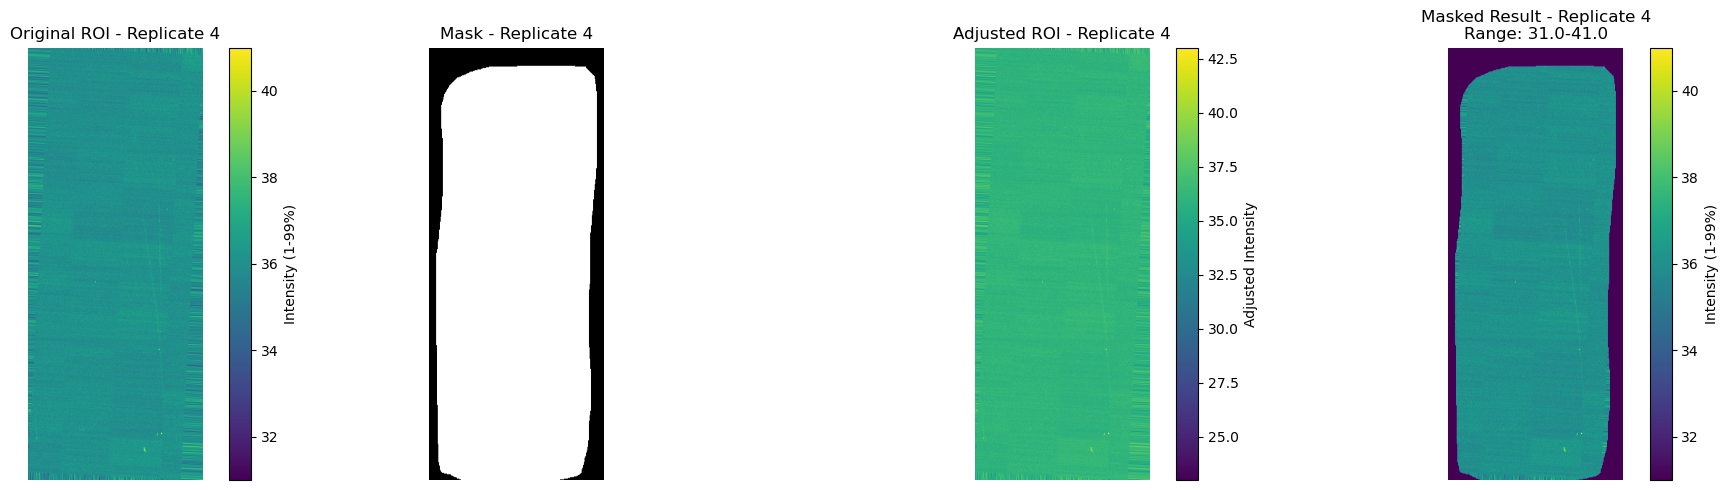


Press Enter to continue to Replicate 5... 



NOW PROCESSING REPLICATE 5 of 6
Draw the gel mask, then:
- Press Enter to confirm
- Press 'r' to reset
- Press 'q' to skip this replicate


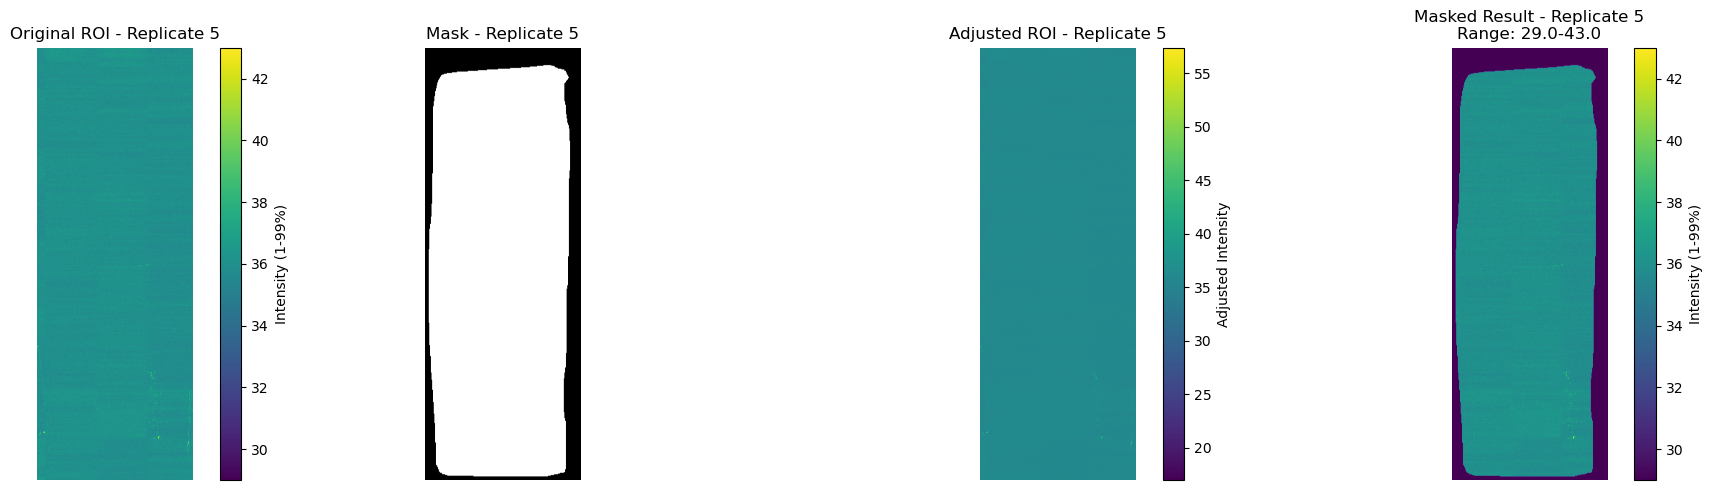


Press Enter to continue to Replicate 6... 



NOW PROCESSING REPLICATE 6 of 6
Draw the gel mask, then:
- Press Enter to confirm
- Press 'r' to reset
- Press 'q' to skip this replicate


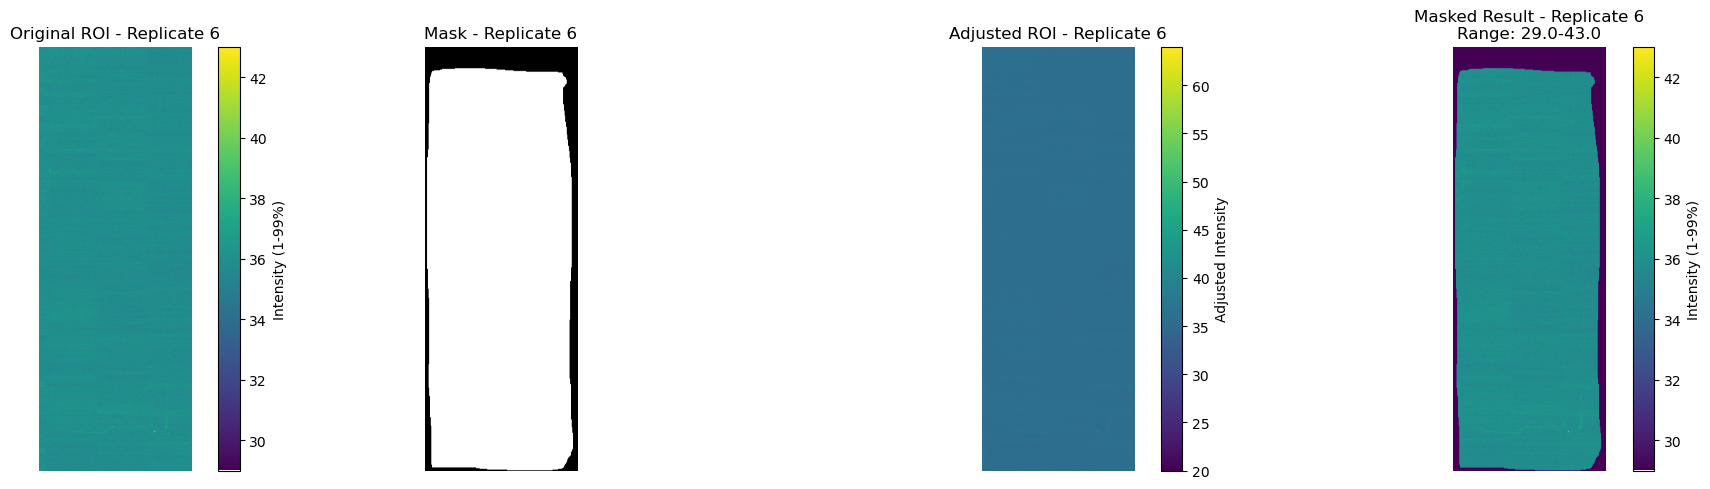


Processing Summary:

Replicate 1: Mask created successfully

Replicate 2: Mask created successfully

Replicate 3: Mask created successfully

Replicate 4: Mask created successfully

Replicate 5: Mask created successfully

Replicate 6: Mask created successfully


In [7]:
def create_gel_mask(rotated_roi, final_roi, display_mode='brightness', percentile_clip=(1, 99)):
    """Create a mask for the gel region within the ROI
    
    Parameters:
    -----------
    rotated_roi : ndarray
        Original rotated ROI
    final_roi : ndarray
        Brightness-adjusted ROI from the adjustment step
    display_mode : str, optional
        Display mode to use: 'brightness' (grayscale), 'magenta' (custom colormap), or 'viridis'
    percentile_clip : tuple, optional
        Lower and upper percentiles to clip data (default: (1, 99))
    """
    # Import necessary libraries
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    from matplotlib.colors import LinearSegmentedColormap
    
    # Create normalized version for display
    normalized_display = cv2.normalize(final_roi, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    # Calculate a moderate display size based on image dimensions
    h, w = normalized_display.shape[:2]
    
    # More conservative target size (800x600 is a safe size for most screens)
    target_width, target_height = 800, 600
    scale_factor = min(target_width / w, target_height / h)
    
    # If the image is already small, don't scale it up too much
    if scale_factor > 2.0:
        scale_factor = 2.0
        
    display_width = int(w * scale_factor)
    display_height = int(h * scale_factor)
    
    # Scale the display image
    display_image = cv2.resize(normalized_display, (display_width, display_height))
    
    # Apply percentile-based contrast enhancement using the passed percentile_clip values
    # Calculate percentiles based on parameters
    p1 = np.percentile(display_image, percentile_clip[0])
    p99 = np.percentile(display_image, percentile_clip[1])
    
    # Clip values to the percentile range
    normalized_float = np.clip(display_image.astype(float), p1, p99)
    
    # Normalize to 0-1 range
    normalized_float = (normalized_float - p1) / (p99 - p1) if p99 > p1 else normalized_float
    
    if display_mode == 'brightness':
        # Use the brightness-adjusted image directly (grayscale)
        # Convert normalized float (0-1) to 0-255 for OpenCV
        colored_image = (normalized_float * 255).astype(np.uint8)
        # Convert to 3-channel for display and drawing
        colored_image = cv2.cvtColor(colored_image, cv2.COLOR_GRAY2BGR)
    elif display_mode == 'viridis':
        # Use viridis colormap
        viridis_cmap = cm.get_cmap('viridis')
        colored_image = viridis_cmap(normalized_float)
        # Convert from 0-1 RGBA to 0-255 BGR for OpenCV
        colored_image = (colored_image[:, :, :3][:, :, ::-1] * 255).astype(np.uint8)
    else:  # 'magenta' or any other value defaults to magenta
        # Use colormap (old behavior)
        # Create custom magenta colormap
        magenta_cmap = LinearSegmentedColormap.from_list('magenta_heat', 
                                               [(0, 'black'), 
                                                (0.33, 'darkmagenta'),
                                                (0.66, 'magenta'),
                                                (1, 'white')])
        colored_image = magenta_cmap(normalized_float)
        # Convert from 0-1 RGBA to 0-255 BGR for OpenCV
        colored_image = (colored_image[:, :, :3][:, :, ::-1] * 255).astype(np.uint8)
    
    # Add text indicating percentile clipping - updated to use the percentile_clip parameter
    percentile_text = f"Display range: {percentile_clip[0]}%-{percentile_clip[1]}% ({p1:.1f}-{p99:.1f})"
    
    drawing = colored_image.copy()
    # Add percentile info
    font = cv2.FONT_HERSHEY_SIMPLEX
    text_size = cv2.getTextSize(percentile_text, font, 0.5, 1)[0]
    cv2.putText(drawing, percentile_text, 
               (display_width - text_size[0] - 10, display_height - 10), 
               font, 0.5, (255, 255, 255), 1)
    
    mask = np.zeros((display_height, display_width), dtype=np.uint8)
    points = []
    drawing_mode = False
    
    def mouse_callback(event, x, y, flags, param):
        nonlocal drawing, points, drawing_mode
        
        if event == cv2.EVENT_LBUTTONDOWN:
            drawing_mode = True
            points = [(x, y)]
            
        elif event == cv2.EVENT_MOUSEMOVE:
            if drawing_mode:
                points.append((x, y))
                if len(points) > 1:
                    cv2.line(drawing, points[-2], points[-1], (0, 0, 255), 3)
                
        elif event == cv2.EVENT_LBUTTONUP:
            drawing_mode = False
            if len(points) > 2:
                points.append(points[0])  # Close the polygon
                points_array = np.array(points)
                cv2.fillPoly(mask, [points_array], 255)
                
                # Create overlay effect
                overlay = np.zeros_like(colored_image)
                overlay[mask > 0] = [0, 0, 255]  # Red overlay where mask is active
                
                # Combine images
                drawing = cv2.addWeighted(colored_image, 0.7, overlay, 0.3, 0)
    
    # Create the window with proper positioning
    cv2.namedWindow('Draw Gel Mask', cv2.WINDOW_NORMAL)
    cv2.setWindowProperty('Draw Gel Mask', cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)
    
    # Force the window to take up the entire screen
    monitor = cv2.getWindowImageRect('Draw Gel Mask')
    screen_width, screen_height = 1920, 800  # Modify to your exact screen resolution
    cv2.resizeWindow('Draw Gel Mask', screen_width, screen_height)
    cv2.moveWindow('Draw Gel Mask', 0, 0)
    
    cv2.setMouseCallback('Draw Gel Mask', mouse_callback)
    
    # Add a title bar with instructions
    instructions = drawing.copy()
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    # Get the display type text based on mode
    if display_mode == 'brightness':
        display_type = "Brightness-adjusted"
    elif display_mode == 'viridis':
        display_type = "Viridis colormap"
    else:
        display_type = "Magenta colormap"
        
    cv2.putText(instructions, f"Draw around the gel region ({display_type})", (20, 30), font, 0.7, (255, 255, 255), 2)
    cv2.putText(instructions, "Enter: Confirm | R: Reset | Q: Skip", (20, 60), font, 0.7, (255, 255, 255), 2)
    cv2.imshow('Draw Gel Mask', instructions)
    cv2.waitKey(1500)  # Show instructions briefly
    
    while True:
        cv2.imshow('Draw Gel Mask', drawing)
        key = cv2.waitKey(1) & 0xFF
        
        if key == ord('r'):  # Reset
            drawing = colored_image.copy()
            mask = np.zeros((display_height, display_width), dtype=np.uint8)
            points = []
            
        elif key == ord('q'):  # Quit
            cv2.destroyAllWindows()
            return None, None, None
            
        elif key == 13:  # Enter key
            cv2.destroyAllWindows()
            
            # Scale mask back to original size
            original_mask = cv2.resize(mask, (w, h), interpolation=cv2.INTER_NEAREST)
            
            # Convert points back to original scale
            if points:
                original_points = [(int(p[0] / scale_factor), int(p[1] / scale_factor)) for p in points]
            else:
                original_points = []
                
            return final_roi, original_mask, original_points
    
    cv2.destroyAllWindows()
    return final_roi, mask, points

def process_gel_masks(adjusted_replicates, percentile_clip=(1, 99), display_mode='brightness'):
    """Process gel masks for all replicates
    
    Parameters:
    -----------
    adjusted_replicates : list
        List of replicate dictionaries
    percentile_clip : tuple, optional
        Lower and upper percentiles to clip data (default: (1, 99))
    display_mode : str, optional
        Display mode to use: 'brightness' (grayscale), 'magenta' (custom colormap), or 'viridis'
    """
    import matplotlib.pyplot as plt
    from matplotlib import cm
    import numpy as np
    
    # Sort replicates by replicate number to ensure correct order
    adjusted_replicates = sorted(adjusted_replicates, key=lambda x: x['replicate_number'])
    total_replicates = len(adjusted_replicates)
    
    for replicate in adjusted_replicates:
        rep_num = replicate['replicate_number']
        print(f"\n{'='*50}")
        print(f"NOW PROCESSING REPLICATE {rep_num} of {total_replicates}")
        print(f"{'='*50}")
        print("Draw the gel mask, then:")
        print("- Press Enter to confirm")
        print("- Press 'r' to reset")
        print("- Press 'q' to skip this replicate")
        
        rotated_roi = replicate.get('rotated_roi')
        
        # Get the adjusted ROI from the global dictionary
        adjusted_roi = global_adjusted_replicates.get(rep_num)
        
        if rotated_roi is None or adjusted_roi is None:
            print(f"Missing required data for Replicate {rep_num}")
            continue
            
        # Store the adjusted ROI in the replicate dictionary
        replicate['adjusted_roi'] = adjusted_roi
            
        # Pass the display_mode parameter and percentile_clip to create_gel_mask
        result_image, gel_mask, gel_points = create_gel_mask(
            rotated_roi, 
            adjusted_roi, 
            display_mode=display_mode,
            percentile_clip=percentile_clip
        )
        
        if result_image is not None:
            replicate['gel_mask'] = gel_mask
            replicate['gel_points'] = gel_points
            
            masked_result = rotated_roi.copy()
            masked_result[gel_mask == 0] = 0
            replicate['masked_result'] = masked_result
            
            plt.figure(figsize=(20, 5))
            
            # Apply percentile clipping to ROI visualization
            valid_pixels_roi = rotated_roi[rotated_roi > 0]
            if len(valid_pixels_roi) > 0:
                p_low_roi, p_high_roi = np.percentile(valid_pixels_roi, percentile_clip)
                roi_display = np.clip(rotated_roi, p_low_roi, p_high_roi)
            else:
                roi_display = rotated_roi
            
            plt.subplot(141)
            plt.imshow(roi_display, cmap='viridis')
            plt.colorbar(label=f'Intensity ({percentile_clip[0]}-{percentile_clip[1]}%)')
            plt.title(f'Original ROI - Replicate {rep_num}')
            plt.axis('off')
            
            plt.subplot(142)
            # For mask visualization, keeping it in gray to distinguish it as binary data
            plt.imshow(gel_mask, cmap='gray')
            plt.title(f'Mask - Replicate {rep_num}')
            plt.axis('off')
            
            # Create a third plot showing the brightness-adjusted image used for drawing
            plt.subplot(143)
            # Display the actual adjusted image that was used
            cmap_display = 'gray' if display_mode == 'brightness' else 'viridis' if display_mode == 'viridis' else 'magma'
            plt.imshow(adjusted_roi, cmap=cmap_display)
            plt.colorbar(label='Adjusted Intensity')
            plt.title(f'Adjusted ROI - Replicate {rep_num}')
            plt.axis('off')
            
            # Apply percentile clipping to masked result visualization
            valid_pixels_masked = masked_result[masked_result > 0]
            if len(valid_pixels_masked) > 0:
                p_low_masked, p_high_masked = np.percentile(valid_pixels_masked, percentile_clip)
                masked_display = np.clip(masked_result, p_low_masked, p_high_masked)
            else:
                masked_display = masked_result
            
            plt.subplot(144)
            plt.imshow(masked_display, cmap='viridis')
            plt.colorbar(label=f'Intensity ({percentile_clip[0]}-{percentile_clip[1]}%)')
            plt.title(f'Masked Result - Replicate {rep_num}\nRange: {p_low_masked:.1f}-{p_high_masked:.1f}')
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()
            
            if rep_num < total_replicates:
                input(f"\nPress Enter to continue to Replicate {rep_num + 1}...")
        else:
            print(f"Skipped mask creation for Replicate {rep_num}")
    
    return adjusted_replicates

# Usage example:
# processed_replicates = process_gel_masks(adjusted_replicates, percentile_clip=(1, 99), use_adjusted_brightness=True)

# Usage example:
# processed_replicates = process_gel_masks(adjusted_replicates, percentile_clip=(1, 99), use_adjusted_brightness=True)

# Usage:
try:
    # Process gel masks for all replicates (with 1-99 percentile clipping)
    # processed_replicates = process_gel_masks(adjusted_replicates, percentile_clip=(1, 99), display_mode='brightness')
    # processed_replicates = process_gel_masks(adjusted_replicates, percentile_clip=(1, 99), display_mode='magenta')
    processed_replicates = process_gel_masks(adjusted_replicates, percentile_clip=(1, 99), display_mode='viridis')
    
    # Alternatively, you can adjust the percentile range:
    # processed_replicates = process_gel_masks(adjusted_replicates, percentile_clip=(5, 95))
    
    # Print summary
    print("\nProcessing Summary:")
    for replicate in processed_replicates:
        rep_num = replicate['replicate_number']
        if 'gel_mask' in replicate:
            print(f"\nReplicate {rep_num}: Mask created successfully")
        else:
            print(f"\nReplicate {rep_num}: No mask created")

except Exception as e:
    print(f"Error occurred: {str(e)}")
    import traceback
    traceback.print_exc()



# Example usage of the new analysis function:
# analyze_gel_heatmap(processed_replicates, save_path='./output')


# The processed_replicates list will now contain for each replicate:
# - Original ROI
# - Rotated ROI
# - Adjusted ROI
# - Adjustment parameters
# - Gel mask
# - Gel points
# - Masked result

### Perform blank subtraction if needed

In [8]:
##### import pandas as pd
import tkinter as tk
from tkinter import filedialog
import matplotlib.pyplot as plt
import numpy as np

# Define helper functions for blank processing
def select_blank_statistics_file():
    """Select blank_statistics.xlsx file using tkinter dialog"""
    root = tk.Tk()
    root.withdraw()  # Hide the main window
    root.attributes('-topmost', True)  # Force dialog to appear in front
    
    file_path = filedialog.askopenfilename(
        title='Select blank_statistics.xlsx file',
        filetypes=[('Excel files', '*.xlsx')],
        initialfile='blank_statistics.xlsx'
    )
    
    return file_path if file_path else None

from ipywidgets import Button, HBox, VBox, Output
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from matplotlib.widgets import Button as MplButton



import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import numpy as np
from scipy import interpolate
from IPython.display import display
import ipywidgets as widgets

def process_with_plotly_baseline(replicate):
    """Process a replicate with baseline subtraction using interactive Plotly plot"""
    rep_num = replicate['replicate_number']
    masked_result = replicate.get('masked_result')
    
    # Calculate vertical intensity profile
    intensity_profile = np.array([np.mean(masked_result[row, :][masked_result[row, :] != 0]) 
                              if np.any(masked_result[row, :] != 0) else 0
                              for row in range(masked_result.shape[0])])
    
    # Store baseline points
    baseline_points = []
    
    # Create output for messages
    output = widgets.Output()
    
    # Create initial figure widget for interactivity
    fig = go.FigureWidget()
    fig.add_trace(go.Scatter(
        x=intensity_profile, 
        y=list(range(len(intensity_profile))),
        mode='lines',
        name='Intensity Profile',
        line=dict(color='blue')
    ))
    
    # Add empty scatter plot for clicked points
    fig.add_trace(go.Scatter(
        x=[],
        y=[],
        mode='markers',
        name='Selected Points',
        marker=dict(color='red', size=12, symbol='circle')
    ))
    
    # Add empty scatter plot for baseline
    fig.add_trace(go.Scatter(
        x=[],
        y=[],
        mode='lines',
        name='Interpolated Baseline',
        line=dict(color='green', width=3)
    ))
    
    # Update layout settings
    fig.update_layout(
        title='Click directly on the plot to select baseline points',
        xaxis_title='Intensity',
        yaxis_title='Position (px)',
        yaxis=dict(autorange='reversed'),  # Invert y-axis
        height=600,
        width=900,
        hovermode='closest'
    )
    
    # Create buttons for operations
    generate_button = widgets.Button(description="Generate Baseline")
    apply_button = widgets.Button(description="Apply & Continue")
    clear_button = widgets.Button(description="Clear Points")
    
    # Handle click events with error handling
    def on_click(trace, points, selector):
        try:
            # Check if points were actually selected
            if not points.xs or len(points.xs) == 0:
                return  # Just silently return if no points were selected
            
            # Now it's safe to access the points
            x, y = points.xs[0], points.ys[0]
            
            # Find closest point on intensity profile (closest y-value)
            closest_y = int(round(y))
            if 0 <= closest_y < len(intensity_profile):
                closest_x = intensity_profile[closest_y]
                
                # Add to baseline points
                baseline_points.append((closest_y, closest_x))
                
                # Update the points display
                y_vals = [point[0] for point in baseline_points]
                x_vals = [point[1] for point in baseline_points]
                
                with fig.batch_update():
                    fig.data[1].x = x_vals
                    fig.data[1].y = y_vals
                
                output.clear_output()
                with output:
                    print(f"Added point: Position={closest_y}, Intensity={closest_x:.2f}")
                    print(f"Total points: {len(baseline_points)}")
        except Exception as e:
            # Silently handle any errors to prevent widget crashes
            pass
    
    # Register click event on the figure
    fig.data[0].on_click(on_click)
    
    # Create a container for results that will be displayed AFTER the initial plot
    results_container = widgets.Output()
    
    # Function to generate baseline
    def generate_baseline(b):
        if len(baseline_points) < 2:
            output.clear_output()
            with output:
                print("Need at least 2 points to generate baseline!")
            return
        
        # Sort points by position (y-coordinate)
        baseline_points.sort(key=lambda point: point[0])
        
        output.clear_output()
        with output:
            print("Generating baseline with points...")
        
        # Create arrays for interpolation
        x_points = np.array([point[0] for point in baseline_points])
        y_points = np.array([point[1] for point in baseline_points])
        
        # Add points at the boundaries if needed
        if x_points[0] > 0:
            x_points = np.insert(x_points, 0, 0)
            y_points = np.insert(y_points, 0, y_points[0])
            
        if x_points[-1] < len(intensity_profile) - 1:
            x_points = np.append(x_points, len(intensity_profile) - 1)
            y_points = np.append(y_points, y_points[-1])
        
        # Create interpolation function
        if len(x_points) >= 4:
            f = interpolate.interp1d(x_points, y_points, kind='cubic')
        else:
            f = interpolate.interp1d(x_points, y_points, kind='linear')
        
        # Generate the full baseline
        full_range = np.arange(len(intensity_profile))
        baseline = f(full_range)
        
        # Store the baseline
        replicate['baseline'] = baseline
        
        # Update the baseline on the plot
        with fig.batch_update():
            fig.data[2].x = baseline
            fig.data[2].y = full_range
        
        # Update the plot title
        fig.update_layout(title='Baseline Generated - Ready to Apply')
        
        with output:
            print("Baseline generated successfully!")
    
    # Function to apply baseline with vectorized operations and downsampling
    # Function to apply baseline with vectorized operations and downsampling
    # Function to apply baseline with vectorized operations and downsampling
    def apply_baseline(b):
        if 'baseline' not in replicate:
            output.clear_output()
            with output:
                print("Generate baseline first!")
            return
        
        baseline = replicate['baseline']
        
        # Clear previous results
        results_container.clear_output()
        
        # Status update
        with output:
            print("Processing - please wait...")
        
        # VECTORIZED OPERATIONS FOR BASELINE SUBTRACTION
        blank_subtracted = masked_result.copy().astype(float)
        gel_area = (masked_result > 0)
        
        # Only process rows that have baseline values
        valid_rows = min(masked_result.shape[0], len(baseline))
        
        # Vectorized subtraction for each row where gel_area is True
        for row in range(valid_rows):
            # This single line replaces the nested loop
            blank_subtracted[row, gel_area[row, :]] -= baseline[row]
        
        # Calculate uncertainties
        uncertainties = np.sqrt(np.abs(masked_result))
        
        # Calculate the baseline-subtracted intensity profile
        subtracted_intensity_profile = np.array([np.mean(blank_subtracted[row, :][gel_area[row, :]]) 
                                       if np.any(gel_area[row, :]) else 0
                                       for row in range(blank_subtracted.shape[0])])
        
        # Store results in the replicate
        replicate['blank_subtracted'] = blank_subtracted
        replicate['uncertainties'] = uncertainties
        replicate['metrics'] = {
            'processing_type': 'plotly_interactive_baseline',
            'baseline_points': baseline_points
        }
        
        # Status update in widget output instead of console
        output.clear_output()
        with output:
            print("Metrics updated and results ready to view.")
        
        # Create figures for the processed data
        with results_container:
            # First figure - intensity profiles
            plt.figure(figsize=(10, 6))
            plt.plot(intensity_profile, range(len(intensity_profile)), 'b-', label='Original Profile')
            plt.plot(baseline, range(len(baseline)), 'g-', label='Baseline')
            plt.plot(subtracted_intensity_profile, range(len(subtracted_intensity_profile)), 'r-', label='Baseline Subtracted')
            plt.gca().invert_yaxis()  # Invert y-axis to match image orientation
            plt.xlabel('Intensity')
            plt.ylabel('Position (px)')
            plt.title('Intensity Profiles')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            # Second figure - image plots
            plt.figure(figsize=(12, 6))
            
            # First subplot for the original masked data
            plt.subplot(1, 3, 1)
            plt.imshow(masked_result, cmap='viridis')
            plt.colorbar(label='Counts')
            plt.title(f'Original Data - Rep {rep_num}')
            
            # Second subplot for the baseline subtracted data
            plt.subplot(1, 3, 2)
            plt.imshow(blank_subtracted, cmap='viridis')
            plt.colorbar(label='Counts')
            plt.title('Baseline Subtracted')
            
            # Third subplot for uncertainties
            plt.subplot(1, 3, 3)
            plt.imshow(uncertainties, cmap='viridis')
            plt.colorbar(label='Uncertainty')
            plt.title('Uncertainty Map')
            
            plt.tight_layout()
            plt.show()
        
        # Final update to output
        output.clear_output()
        with output:
            print("Processing complete. Results displayed below.")
        
        return True


    
    # Function to clear all points and reset
    def clear_points(b):
        baseline_points.clear()
        
        # Clear points from plot
        with fig.batch_update():
            fig.data[1].x = []
            fig.data[1].y = []
            fig.data[2].x = []
            fig.data[2].y = []
        
        # Clear the stored baseline
        if 'baseline' in replicate:
            del replicate['baseline']
        
        # Update UI
        output.clear_output()
        with output:
            print("All points cleared. You can select new baseline points.")
    
    # Connect buttons to their respective functions
    generate_button.on_click(generate_baseline)
    apply_button.on_click(apply_baseline)
    clear_button.on_click(clear_points)
    
    # Create simple instructions
    instructions = widgets.HTML(
        "<b>Instructions:</b><br>"
        "1. Click on the plot to select baseline points<br>"
        "2. Click 'Generate Baseline' to create the baseline curve<br>"
        "3. Click 'Apply & Continue' to process the data<br>"
        "4. Use 'Clear Points' to start over"
    )
    
    # Layout buttons horizontally
    button_box = widgets.HBox([generate_button, apply_button, clear_button])
    
    # Display the full UI
    display(widgets.VBox([
        instructions,
        fig,
        button_box,
        output,
        results_container
    ]))
    
    # Wait for user to interact with the widgets
    # The replicate will be updated via callbacks
    return replicate





def process_all_replicates(processed_replicates):
    """Process all replicates with blank subtraction and uncertainty calculation"""
    
    # Initialize metrics dictionary for all replicates
    all_metrics = {}
    
    # Ask what kind of processing the user wants
    print("Select processing type:")
    print("1. No blank subtraction")
    print("2. Blank subtraction from file")
    print("3. Interactive baseline subtraction based on intensity profile")
    print("4. Interactive Plotly baseline selection (click directly on plot)")
    processing_choice = input("Enter your choice (1-4): ")
    
    # Option 4: Interactive Plotly baseline selection
    # Option 4: Interactive Plotly baseline selection
    if processing_choice == "4":
        for replicate in processed_replicates:
            rep_num = replicate['replicate_number']
            print(f"\nProcessing Replicate {rep_num}", flush=True)
            
            replicate = process_with_plotly_baseline(replicate)
            
            # Force metrics update to be visible in console
            print(f"\nCompleted processing replicate {rep_num}", flush=True)
            
        # Force a small delay before summary
        import time
        time.sleep(0.5)
        
        # Print processing summary
        print("\nProcessing Summary:", flush=True)
        for replicate in processed_replicates:
            rep_num = replicate['replicate_number']
            metrics = replicate.get('metrics', {})
            print(f"\nReplicate {rep_num}:")
            print(f"Processing type: {metrics.get('processing_type', 'unknown')}")
            
            # Add any other metrics you want to show
            if metrics.get('processing_type') == 'plotly_interactive_baseline':
                baseline_points = metrics.get('baseline_points', [])
                print(f"Baseline points: {len(baseline_points)}")
        
        # Collect metrics
        for replicate in processed_replicates:
            rep_num = replicate['replicate_number']
            all_metrics[f'replicate_{rep_num}'] = replicate.get('metrics', {})
        
        return processed_replicates, all_metrics

    
    
    # Option 1: No blank subtraction
    elif processing_choice == "1":
        # Process each replicate without blank subtraction
        for replicate in processed_replicates:
            rep_num = replicate['replicate_number']
            print(f"\nProcessing Replicate {rep_num}")
            
            masked_result = replicate.get('masked_result')
            if masked_result is None:
                print(f"No masked result found for Replicate {rep_num}")
                continue
                
            # Initialize metrics for this replicate
            replicate['metrics'] = {}
            
            # Just use the original masked result without subtraction
            replicate['blank_subtracted'] = masked_result.copy()
            replicate['uncertainties'] = np.sqrt(np.abs(masked_result))  # Poisson noise
            replicate['metrics'].update({
                'processing_type': 'no_blank_subtraction',
                'uncertainties_type': 'poisson'
            })
            
            # Visualize results for this replicate
            plt.figure(figsize=(15, 5))
            
            plt.subplot(131)
            plt.imshow(masked_result, cmap='gray')
            plt.title(f'Masked Result - Replicate {rep_num}')
            plt.colorbar()
            plt.axis('off')
            
            plt.subplot(132)
            plt.imshow(replicate['blank_subtracted'], cmap='gray')
            plt.title('Original Result (No Blank Subtraction)')
            plt.colorbar()
            plt.axis('off')
            
            plt.subplot(133)
            plt.imshow(replicate['uncertainties'], cmap='viridis')
            plt.title('Uncertainties')
            plt.colorbar(label='σ')
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()
            
            # Collect metrics for all replicates
            all_metrics[f'replicate_{rep_num}'] = replicate['metrics']
            
        return processed_replicates, all_metrics
    
    # Option 2: Blank subtraction from file (original method)
    else:  # processing_choice == "2" or any other input
        # If performing blank subtraction from file, continue with original logic
        is_blank = input("Are these blank hydrogels? (y/n): ").lower() == 'y'
        
        # If not blank, get blank statistics file once
        blank_stats = None
        if not is_blank:
            blank_stats_path = select_blank_statistics_file()
            if blank_stats_path:
                try:
                    blank_stats_df = pd.read_excel(blank_stats_path, sheet_name='Summary')
                    blank_stats = {
                        'mean': blank_stats_df.loc[blank_stats_df['Statistic'] == 'Overall Mean', 'Value'].values[0],
                        'std': blank_stats_df.loc[blank_stats_df['Statistic'] == 'Overall Standard Deviation', 'Value'].values[0]
                    }
                except Exception as e:
                    print(f"Error loading blank statistics: {str(e)}")
                    blank_stats = None
        
        # Process each replicate
        for replicate in processed_replicates:
            rep_num = replicate['replicate_number']
            print(f"\nProcessing Replicate {rep_num}")
            
            masked_result = replicate.get('masked_result')
            if masked_result is None:
                print(f"No masked result found for Replicate {rep_num}")
                continue
                
            # Initialize metrics for this replicate
            replicate['metrics'] = {}
            
            if not is_blank and blank_stats:
                # Perform blank subtraction
                blank_subtracted = masked_result.copy().astype(float)
                gel_area = (masked_result > 0)
                blank_subtracted[gel_area] -= blank_stats['mean']
                
                # Calculate uncertainties
                uncertainties = np.zeros_like(masked_result, dtype=float)
                uncertainties[gel_area] = blank_stats['std']
                
                # Store results
                replicate['blank_subtracted'] = blank_subtracted
                replicate['uncertainties'] = uncertainties
                replicate['metrics'].update({
                    'blank_stats': blank_stats,
                    'processing_type': 'blank_subtracted'
                })
                
            else:
                # For blank gels or when blank subtraction isn't possible
                replicate['blank_subtracted'] = masked_result.copy()
                replicate['uncertainties'] = np.sqrt(np.abs(masked_result))  # Poisson noise
                replicate['metrics'].update({
                    'processing_type': 'blank_gel' if is_blank else 'raw_with_poisson',
                    'uncertainties_type': 'poisson'
                })
            
            # Visualize results for this replicate
            plt.figure(figsize=(15, 5))
            
            plt.subplot(131)
            plt.imshow(masked_result, cmap='gray')
            plt.title(f'Masked Result - Replicate {rep_num}')
            plt.colorbar()
            plt.axis('off')
            
            plt.subplot(132)
            plt.imshow(replicate['blank_subtracted'], cmap='gray')
            plt.title('Blank Corrected Result' if not is_blank else 'Original Result')
            plt.colorbar()
            plt.axis('off')
            
            plt.subplot(133)
            plt.imshow(replicate['uncertainties'], cmap='viridis')
            plt.title('Uncertainties')
            plt.colorbar(label='σ')
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()
            
            # Collect metrics for all replicates
            all_metrics[f'replicate_{rep_num}'] = replicate['metrics']
        
        return processed_replicates, all_metrics

# Usage:
try:
    # Process all replicates
    processed_replicates, all_metrics = process_all_replicates(processed_replicates)
            
except Exception as e:
    print(f"Error occurred: {str(e)}")
    import traceback
    traceback.print_exc()

# The processed_replicates list will now contain for each replicate:
# - Original ROI
# - Rotated ROI
# - Adjusted ROI
# - Gel mask
# - Masked result
# - Blank subtracted result
# - Uncertainties
# - Metrics


Select processing type:
1. No blank subtraction
2. Blank subtraction from file
3. Interactive baseline subtraction based on intensity profile
4. Interactive Plotly baseline selection (click directly on plot)


Enter your choice (1-4):  4



Processing Replicate 1



Completed processing replicate 1

Processing Replicate 2



Completed processing replicate 2

Processing Replicate 3



Completed processing replicate 3

Processing Replicate 4



Completed processing replicate 4

Processing Replicate 5



Completed processing replicate 5

Processing Replicate 6



Completed processing replicate 6

Processing Summary:

Replicate 1:
Processing type: unknown

Replicate 2:
Processing type: unknown

Replicate 3:
Processing type: unknown

Replicate 4:
Processing type: unknown

Replicate 5:
Processing type: unknown

Replicate 6:
Processing type: unknown


### Determine curved interface

In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib import cm
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
from scipy.interpolate import interp1d
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import gc
import time

print("\n--- Curved Interface Analysis ---")
print("This will allow you to analyze interfaces for each replicate.")

# Ask user which type of interface they want to analyze
interface_type = input("Which interface type do you want to analyze? (1: Horizontal interface, 2: Gel edges, 3: Highlight mask outlines): ")
interface_type = "2" if not interface_type.strip() else interface_type.strip()

detect_gel_edges = interface_type == "2"
highlight_outlines = interface_type == "3"

if highlight_outlines:
    print("Selected interface type: Highlight mask outlines")
elif detect_gel_edges:
    print("Selected interface type: Gel edges")
else:
    print("Selected interface type: Horizontal interface")

# Ask if user wants to also draw penetration area
draw_penetration_input = input("Do you also want to draw penetration areas? (y/n, default: y): ")
draw_penetration = draw_penetration_input.strip().lower() != 'n'
if draw_penetration:
    print("Penetration area drawing ENABLED")
else:
    print("Penetration area drawing DISABLED")

downsample_default = 1
downsample_input = input(f"Downsample factor for interface drawing (default: {downsample_default}): ")
downsample_factor = float(downsample_input) if downsample_input.strip() else downsample_default

# Add an option to disable advanced visualizations for better performance
disable_advanced_viz_input = input("Disable advanced visualizations for better performance? (y/n, default: y): ")
# Fix the logic to be more explicit
if disable_advanced_viz_input.strip().lower() == 'n':
    disable_advanced_viz = False
    print("Advanced visualizations ENABLED - visualizations will be displayed.")
else:
    disable_advanced_viz = True
    print("Advanced visualizations DISABLED for better performance.")

def highlight_gel_mask_points(image, replicate, downsample_factor=1.0, color=(0, 0, 255), thickness=2):
    """Highlights the original gel mask points that were manually drawn."""
    # Get the original gel_points from the replicate
    gel_points = replicate.get('gel_points', None)
    
    # Convert grayscale image to color for overlay
    if len(image.shape) == 2:
        display_image = apply_viridis_optimized_heatmap(image)
    else:
        display_image = image.copy()
    
    if gel_points is not None and len(gel_points) > 0:
        # Scale points to match downsampled image
        scaled_points = []
        for point in gel_points:
            x, y = point
            scaled_x = int(x * downsample_factor)
            scaled_y = int(y * downsample_factor)
            scaled_points.append((scaled_x, scaled_y))
        
        # Convert points to numpy array for drawing
        points_array = np.array(scaled_points, dtype=np.int32)
        
        # Draw the polygon outline
        cv2.polylines(display_image, [points_array], True, color, thickness)
        
        # Optionally draw the individual points
        for i, point in enumerate(scaled_points):
            # Draw larger circles at the points
            cv2.circle(display_image, point, 3, (0, 255, 0), -1)
            
            # Optionally add point numbers (for every 10th point to reduce clutter)
            if i % 10 == 0:
                cv2.putText(display_image, str(i), 
                           (point[0] + 5, point[1] + 5),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
    else:
        print("No gel mask points found for this replicate")
    
    return display_image

def enhance_gel_edges(image, sigma=1.0, alpha=2.0):
    """A simpler approach to enhance edges for gel interface detection."""
    # Convert to float32 for processing
    img_float = image.astype(np.float32)
    
    # Apply Gaussian blur for noise reduction
    blurred = cv2.GaussianBlur(img_float, (5, 5), 0)
    
    # Enhance edges using unsharp masking (using alpha instead of strength)
    enhanced = img_float + alpha * (img_float - blurred)
    
    # Ensure the result is in the same range as the original
    result = np.clip(enhanced, 0, np.max(image))
    return result.astype(image.dtype)

# Function to apply viridis colormap with percentile clipping
def apply_viridis_optimized_heatmap(image, lower_percentile=1, upper_percentile=99, gamma=0.5):
    """Apply a viridis heatmap optimized for visualization with percentile clipping."""
    global VIRIDIS_COLORMAP
    
    # Make a copy to avoid modifying the original
    img_copy = image.copy()
    
    # Clip values based on percentiles (only calculate for non-zero pixels)
    non_zero_mask = img_copy > 0
    if np.sum(non_zero_mask) > 0:  # Check if there are any non-zero pixels
        non_zero_pixels = img_copy[non_zero_mask]
        lower_val = np.percentile(non_zero_pixels, lower_percentile)
        upper_val = np.percentile(non_zero_pixels, upper_percentile)
    else:
        # Handle the case where there are no non-zero pixels
        lower_val = 0
        upper_val = 1  # Avoid division by zero
    
    # Clip and normalize the image
    img_clipped = np.clip(img_copy, lower_val, upper_val)
    img_norm = (img_clipped - lower_val) / (upper_val - lower_val)
    
    # Apply gamma correction to enhance dark areas
    img_gamma = np.power(img_norm, gamma)
    
    # Initialize viridis colormap once
    if 'VIRIDIS_COLORMAP' not in globals() or VIRIDIS_COLORMAP is None:
        import matplotlib.pyplot as plt
        viridis = plt.colormaps['viridis']
        VIRIDIS_COLORMAP = viridis(np.linspace(0, 1, 256))[:, :3]  # Get RGB values (exclude alpha)
    
    # Convert to 8-bit for OpenCV
    img_8bit = (img_gamma * 255).astype(np.uint8)
    
    # Apply colormap using lookup table approach
    img_colored = np.zeros((img_8bit.shape[0], img_8bit.shape[1], 3), dtype=np.uint8)
    
    # Use vectorized operations
    for i in range(3):  # For each color channel (BGR)
        # Create a lookup table for this channel (reverse order for BGR)
        lut = (VIRIDIS_COLORMAP[:, 2-i] * 255).astype(np.uint8)
        # Apply lookup table to the image
        img_colored[:, :, i] = cv2.LUT(img_8bit, lut)
    
    return img_colored

# Replace original plasma colormap function with viridis version
apply_dark_optimized_heatmap = apply_viridis_optimized_heatmap

def get_screen_size():
    """Get the screen resolution for proper window sizing"""
    try:
        import tkinter as tk
        root = tk.Tk()
        screen_width = root.winfo_screenwidth()
        screen_height = root.winfo_screenheight()
        root.destroy()
        return screen_width, screen_height
    except:
        # Default fallback if tkinter isn't available
        return 1280, 800

class ROISelector:
    def __init__(self, image, replicate_number):
        """Class for selecting a region of interest before interface drawing."""
        self.original_image = image.copy()
        self.replicate_number = replicate_number
        
        # Create gel mask (non-zero pixels) - more efficient
        self.gel_mask = (image > 0).astype(np.uint8)
        
        # Apply viridis colormap for better visualization
        self.display_image = apply_dark_optimized_heatmap(image)
        
        # Initialize ROI coordinates
        self.roi = None
        self.drawing_roi = False
        self.start_point = None
        self.end_point = None
        
        # Window name
        self.window_name = f"Select ROI - Replicate {replicate_number}"
        
        # Create a copy for display
        self.display_copy = self.display_image.copy()
        
        # Add instructions
        self.add_instructions()
        
        # Get screen size
        try:
            import tkinter as tk
            root = tk.Tk()
            screen_width = root.winfo_screenwidth()
            screen_height = root.winfo_screenheight()
            root.destroy()
        except:
            # Default fallback if tkinter isn't available
            screen_width, screen_height = 1280, 800
        
        # Setup window
        cv2.namedWindow(self.window_name, cv2.WINDOW_NORMAL)
        cv2.moveWindow(self.window_name, 0, 0)  # Position at top-left
        cv2.resizeWindow(self.window_name, int(screen_width * 0.9), int(screen_height * 0.9))
        
        # Setup mouse callback
        cv2.setMouseCallback(self.window_name, self.mouse_callback)
    
    def add_instructions(self):
        """Add instructions text to the display image."""
        instructions = [
            "Click and drag to select ROI",
            "Press 'c' to clear selection",
            "Press ENTER to zoom and continue",
            "Press 'f' to use full image"
        ]
        
        y_pos = 30
        for text in instructions:
            cv2.putText(self.display_copy, text, (10, y_pos), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
            y_pos += 20
    
    def mouse_callback(self, event, x, y, flags, param):
        """Handle mouse events for ROI selection."""
        if event == cv2.EVENT_LBUTTONDOWN:
            # Start ROI selection
            self.drawing_roi = True
            self.start_point = (x, y)
            self.end_point = (x, y)
        
        elif event == cv2.EVENT_MOUSEMOVE:
            # Update end point while dragging
            if self.drawing_roi:
                self.end_point = (x, y)
                
                # Create a fresh copy
                self.display_copy = self.display_image.copy()
                self.add_instructions()
                
                # Draw rectangle
                cv2.rectangle(self.display_copy, self.start_point, self.end_point, (0, 255, 255), 2)
                cv2.imshow(self.window_name, self.display_copy)
        
        elif event == cv2.EVENT_LBUTTONUP:
            # Finish ROI selection
            self.drawing_roi = False
            self.end_point = (x, y)
            
            # Ensure start_point is top-left and end_point is bottom-right
            x1, y1 = min(self.start_point[0], self.end_point[0]), min(self.start_point[1], self.end_point[1])
            x2, y2 = max(self.start_point[0], self.end_point[0]), max(self.start_point[1], self.end_point[1])
            
            # Store ROI coordinates
            self.roi = (x1, y1, x2, y2)
            
            # Draw final rectangle
            self.display_copy = self.display_image.copy()
            self.add_instructions()
            cv2.rectangle(self.display_copy, (x1, y1), (x2, y2), (0, 255, 255), 2)
            cv2.imshow(self.window_name, self.display_copy)
    
    def run(self):
        """Run the ROI selector."""
        print("Instructions:")
        print("1. Click and drag to select a region of interest (ROI)")
        print("2. Press 'c' to clear selection")
        print("3. Press ENTER to zoom and continue")
        print("4. Press 'f' to use full image (no zoom)")
        
        # Display the initial image
        cv2.imshow(self.window_name, self.display_copy)
        
        key = 0
        while key != 13 and key != ord('q') and key != ord('f'):  # ENTER, q, or f
            key = cv2.waitKey(20) & 0xFF
            
            if key == ord('c'):
                # Clear selection
                self.roi = None
                self.display_copy = self.display_image.copy()
                self.add_instructions()
                print("Cleared ROI selection.")
                cv2.imshow(self.window_name, self.display_copy)
        
        # Clean up
        cv2.destroyWindow(self.window_name)
        
        # Return None if quitting
        if key == ord('q'):
            return None, None
        
        # Return full image if 'f' pressed
        if key == ord('f') or self.roi is None:
            print("Using full image.")
            return self.original_image, None
        
        # Extract ROI
        x1, y1, x2, y2 = self.roi
        
        # Ensure ROI is valid (not too small)
        if (x2 - x1) < 10 or (y2 - y1) < 10:
            print("ROI too small, using full image.")
            return self.original_image, None
        
        roi_image = self.original_image[y1:y2, x1:x2].copy()
        print(f"ROI selected: ({x1}, {y1}) to ({x2}, {y2})")
        
        return roi_image, self.roi

class CurvedInterfaceDrawer:
    def __init__(self, image, replicate_number, scale_mm_per_pixel=0.1, detect_gel_edges=False):
        """Interface for drawing curved interfaces on gel images."""
        self.original_image = image.copy()
        self.replicate_number = replicate_number
        self.scale_mm_per_pixel = scale_mm_per_pixel
        self.detect_gel_edges = detect_gel_edges
        
        # Create gel mask (non-zero pixels) - more efficient
        self.gel_mask = (image > 0).astype(np.uint8)
        
        # Apply viridis colormap with percentile clipping
        self.display_image = apply_dark_optimized_heatmap(image)
        
        # Initialize interface points
        self.interface_points = []
        self.interface_y_values = None
        self.is_drawing = False
        self.curve_fitted = False
        self.prev_point = None  # Track previous point for drawing
        
        # Window name
        self.window_name = f"Draw Interface - Replicate {replicate_number}"
        
        # Create a copy for display
        self.display_copy = self.display_image.copy()
        
        # Add instructional text to the image
        self.add_instructions()
        
        # Get screen size
        try:
            import tkinter as tk
            root = tk.Tk()
            screen_width = root.winfo_screenwidth()
            screen_height = root.winfo_screenheight()
            root.destroy()
        except:
            # Default fallback if tkinter isn't available
            screen_width, screen_height = 1280, 800
        
        # Setup window with specific flags to make it resizable
        cv2.namedWindow(self.window_name, cv2.WINDOW_NORMAL)
        cv2.moveWindow(self.window_name, 0, 0)  # Position at top-left
        cv2.resizeWindow(self.window_name, int(screen_width * 0.9), int(screen_height * 0.9))
        
        # Setup mouse callback
        cv2.setMouseCallback(self.window_name, self.mouse_callback)
    
    def add_instructions(self):
        """Add instructions text to the display image."""
        instructions = [
            "Click and drag to draw interface",
            "Release mouse to fit curve",
            "Press 'r' to reset curve",
            "Press 'c' to clear all points",
            "Press ENTER to save and continue"
        ]
        
        y_pos = 30
        for text in instructions:
            cv2.putText(self.display_copy, text, (10, y_pos), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
            y_pos += 20
        
        # Add indicator for which mode is active
        mode_text = "Mode: Gel Edges" if self.detect_gel_edges else "Mode: Horizontal Interface"
        cv2.putText(self.display_copy, mode_text, (10, y_pos + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1)
    
    def mouse_callback(self, event, x, y, flags, param):
        """Handle mouse events for interface drawing."""
        # Check if coordinates are valid
        if y >= self.gel_mask.shape[0] or x >= self.gel_mask.shape[1]:
            return
        
        # Only process points within gel area
        if self.gel_mask[y, x] == 0:
            return
        
        if event == cv2.EVENT_LBUTTONDOWN:
            # Start drawing - add first point
            self.is_drawing = True
            self.interface_points.append((x, y))
            self.prev_point = (x, y)
            cv2.circle(self.display_copy, (x, y), 3, (0, 255, 255), -1)
            cv2.imshow(self.window_name, self.display_copy)
            
            # Reset curve fit when starting new drawing
            self.curve_fitted = False
        
        elif event == cv2.EVENT_MOUSEMOVE:
            # Only add points when dragging (left button pressed)
            if self.is_drawing and self.prev_point != (x, y):
                self.interface_points.append((x, y))
                cv2.circle(self.display_copy, (x, y), 3, (0, 255, 255), -1)
                
                # Draw line from previous point
                cv2.line(self.display_copy, self.prev_point, (x, y), (0, 255, 255), 2)
                self.prev_point = (x, y)
                cv2.imshow(self.window_name, self.display_copy)
        
        elif event == cv2.EVENT_LBUTTONUP:
            # Stop drawing - button released
            if self.is_drawing:
                self.is_drawing = False
                
                # Add final point if it's different from the last one
                if self.prev_point != (x, y) and self.gel_mask[y, x] > 0:
                    self.interface_points.append((x, y))
                    cv2.circle(self.display_copy, (x, y), 3, (0, 255, 255), -1)
                    cv2.line(self.display_copy, self.prev_point, (x, y), (0, 255, 255), 2)
                
                # Automatically fit curve when mouse is released
                self.create_interface_curve()
                cv2.imshow(self.window_name, self.display_copy)
    
    def create_horizontal_interface_curve(self):
        """Create a continuous interface curve with horizontal extrapolation to gel edges."""
        if len(self.interface_points) < 2:
            print("Need at least 2 points to create an interface curve!")
            return False
        
        # Sort points by x-coordinate
        points = sorted(self.interface_points, key=lambda p: p[0])
        
        # Initialize interface array with zeros
        self.interface_y_values = np.zeros(self.original_image.shape[1], dtype=int)
        
        # Find gel boundaries - columns where gel exists (more efficient)
        gel_columns = np.any(self.gel_mask > 0, axis=0)
        
        # OPTIMIZATION: Use NumPy arrays instead of lists for faster operations
        x_points = np.array([p[0] for p in points])
        y_points = np.array([p[1] for p in points])
        
        # Create interpolation for points between the drawn range
        if len(x_points) >= 2:
            # OPTIMIZATION: Use linear interpolation as it's faster
            interface_curve = interp1d(
                x_points, y_points, kind='linear', bounds_error=False, fill_value=np.nan
            )
        else:
            # If only one point, use its y-value for everything
            interface_curve = None
            constant_y = float(y_points[0])
        
        # Find leftmost and rightmost drawn points
        leftmost_x = x_points[0]
        rightmost_x = x_points[-1]
        leftmost_y = int(y_points[0])
        rightmost_y = int(y_points[-1])
        
        # OPTIMIZATION: Process each column efficiently
        x_indices = np.arange(self.original_image.shape[1])
        valid_indices = np.where(gel_columns)[0]
        
        for x in valid_indices:
            # Determine y-value
            if x < leftmost_x:
                # Strict horizontal line to the left
                y_val = leftmost_y
            elif x > rightmost_x:
                # Strict horizontal line to the right
                y_val = rightmost_y
            else:
                # Between drawn points - use interpolation
                if interface_curve is not None:
                    y_val = interface_curve(x)
                    if np.isnan(y_val):
                        continue
                else:
                    y_val = constant_y
            
            # Convert to integer and ensure within image bounds
            try:
                y_val = int(float(y_val))
                y_val = max(0, min(y_val, self.original_image.shape[0] - 1))
                self.interface_y_values[x] = y_val
            except (TypeError, ValueError):
                continue
        
        # Mark as fitted
        self.curve_fitted = True
        
        # Draw the fitted curve
        self.display_curve()
        
        return True
    
    def create_gel_edge_interface_curve(self):
        """Create a continuous interface curve following gel edges using the original drawing order."""
        if len(self.interface_points) < 2:
            print("Need at least 2 points to create an interface curve!")
            return False
        
        # Initialize interface array with zeros
        self.interface_y_values = np.zeros(self.original_image.shape[1], dtype=int)
        
        # Use points in their original order - no sorting
        points = self.interface_points.copy()
        if len(points) > 0:
            # Use the first drawn point as the starting point (no sorting)
            start_point = points[0]
            
            # Store the ordered points directly - these are already in drawing order
            ordered_points = points
            
            # Apply the ordered points to the interface array
            for x, y in ordered_points:
                if 0 <= x < self.original_image.shape[1]:
                    self.interface_y_values[x] = y
            
            # Store the ordered points for later retrieval
            self.ordered_interface_points = ordered_points
            
            # Mark as fitted
            self.curve_fitted = True
            
            # Display the curve with lines connecting points in drawing order
            self.display_curve_in_drawing_order(ordered_points)
            
            return True
        
        return False

    def display_curve_in_drawing_order(self, ordered_points):
        """Display the curve with points connected in their original drawing order."""
        if not self.curve_fitted:
            return
        
        # Create a fresh copy for display
        curve_img = self.display_image.copy()
        
        # Add instructional text
        self.add_instructions()
        
        # OPTIMIZATION: Only draw every Nth point based on density to reduce overhead
        point_density = len(ordered_points) / 100  # Target about 100 points for display
        step = max(1, int(point_density))
        
        # Draw points in their original order with connections
        for i in range(0, len(ordered_points), step):
            pt = ordered_points[i]
            cv2.circle(curve_img, pt, 3, (0, 255, 255), -1)
            
            # Draw line connecting to next point
            if i < len(ordered_points) - step:
                next_pt = ordered_points[i + step]
                cv2.line(curve_img, pt, next_pt, (0, 255, 255), 2)
        
        # Add numbers to indicate the sequence (for every 10th point to avoid clutter)
        for i in range(0, len(ordered_points), 10):
            pt = ordered_points[i]
            # Add a text label with point number
            cv2.putText(curve_img, str(i), 
                       (pt[0] + 5, pt[1] + 5),  # Position slightly offset
                       cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
        
        # Draw the fitted interface points in red with reduced density
        # OPTIMIZATION: Draw fewer points for visualization
        x_indices = np.arange(0, self.original_image.shape[1], 4)  # Every 4th point
        for x in x_indices:
            y = self.interface_y_values[x]
            if y > 0 and x < self.gel_mask.shape[1] and y < self.gel_mask.shape[0] and self.gel_mask[y, x] > 0:
                cv2.circle(curve_img, (x, y), 1, (255, 0, 0), -1)
        
        self.display_copy = curve_img
    
    def create_interface_curve(self):
        """Create interface curve based on selected method."""
        if self.detect_gel_edges:
            return self.create_gel_edge_interface_curve()
        else:
            return self.create_horizontal_interface_curve()
    
    def display_curve(self):
        """Display the fitted curve on the image (for horizontal interface)."""
        if not self.curve_fitted:
            return
        
        # Create a fresh copy for display
        curve_img = self.display_image.copy()
        
        # Add instructional text
        self.add_instructions()
        
        # OPTIMIZATION: Only draw a subset of points for better performance
        # Draw a subset of original points
        draw_points = self.interface_points
        if len(draw_points) > 100:  # If there are too many points
            step = len(draw_points) // 100
            draw_points = draw_points[::step]
            
        for pt in draw_points:
            cv2.circle(curve_img, pt, 3, (0, 255, 255), -1)
        
        # Draw lines between consecutive points (with reduced density)
        for i in range(1, len(draw_points)):
            cv2.line(curve_img, draw_points[i-1], draw_points[i], (0, 255, 255), 2)
        
        # Draw a subset of the fitted curve points
        # OPTIMIZATION: Draw fewer interface points
        sample_rate = max(1, self.original_image.shape[1] // 400)  # At most 400 points
        for x in range(0, self.original_image.shape[1], sample_rate):
            y = self.interface_y_values[x]
            if y > 0 and x < self.gel_mask.shape[1] and y < self.gel_mask.shape[0] and self.gel_mask[y, x] > 0:
                cv2.circle(curve_img, (x, y), 1, (255, 0, 0), -1)
        
        self.display_copy = curve_img
    
    def run(self):
        """Run the interface drawer."""
        print("Instructions:")
        print("1. Click and drag to draw the interface curve")
        print("2. Release mouse to fit curve")
        print("3. Press 'c' to clear and redraw")
        print("4. Press 'r' to reset the fitted curve")
        print("5. Press ENTER to save and continue")
        print("6. Press 'q' to quit without saving")
        
        # Display the initial image
        cv2.imshow(self.window_name, self.display_copy)
        
        key = 0
        while key != 13 and key != ord('q'):  # 13 is ENTER, q is quit
            key = cv2.waitKey(20) & 0xFF
            
            if key == ord('q'):
                # Quit without saving
                print("Quitting interface drawer without saving.")
                break
            
            elif key == ord('c'):
                # Clear drawn points
                self.display_copy = self.display_image.copy()
                self.add_instructions()
                self.interface_points = []
                self.prev_point = None
                self.curve_fitted = False
                print("Cleared interface points. Draw again.")
                cv2.imshow(self.window_name, self.display_copy)
            
            elif key == ord('r'):
                # Reset fitted curve
                if self.curve_fitted:
                    self.curve_fitted = False
                    
                    # Redraw original points only
                    self.display_copy = self.display_image.copy()
                    self.add_instructions()
                    
                    # OPTIMIZATION: Only draw a subset of points for performance
                    draw_points = self.interface_points
                    if len(draw_points) > 100:
                        step = len(draw_points) // 100
                        draw_points = draw_points[::step]
                        
                    for pt in draw_points:
                        cv2.circle(self.display_copy, pt, 3, (0, 255, 255), -1)
                    
                    # Draw lines between consecutive points
                    for i in range(1, len(draw_points)):
                        cv2.line(self.display_copy, draw_points[i-1], draw_points[i], (0, 255, 255), 2)
                    
                    print("Reset fitted curve. Draw again or press ENTER to continue.")
                    cv2.imshow(self.window_name, self.display_copy)
                else:
                    print("No fitted curve to reset.")
        
        # Clean up
        cv2.destroyWindow(self.window_name)
        
        # Return None if quitting
        if key == ord('q'):
            return None
        
        # If we haven't fitted the curve yet, do it now
        if not self.curve_fitted:
            print("Fitting curve before continuing...")
            if not self.create_interface_curve():
                print("Could not fit curve. Using default horizontal line.")
                
                # Create a default horizontal line through the center of the gel
                mid_y = self.original_image.shape[0] // 2
                self.interface_y_values = np.ones(self.original_image.shape[1], dtype=int) * mid_y
                
                # Ensure it's within gel area
                for x in range(self.original_image.shape[1]):
                    y_candidates = np.where(self.gel_mask[:, x] > 0)[0]
                    if len(y_candidates) > 0:
                        closest_y = y_candidates[np.abs(y_candidates - mid_y).argmin()]
                        self.interface_y_values[x] = closest_y
        
        return self.interface_y_values

# New class for drawing penetration area ROI
# Replace the PenetrationAreaSelector class with this version that works like gel edges (continuous drawing)
# Replace the MultiPolygonPenetrationAreaSelector class with this improved version
class MultiPolygonPenetrationAreaSelector:
    def __init__(self, image, replicate_number):
        """Class for selecting multiple penetration areas WITHOUT self-intersections."""
        self.original_image = image.copy()
        self.replicate_number = replicate_number
        
        # Create gel mask (non-zero pixels)
        self.gel_mask = (image > 0).astype(np.uint8)
        
        # Apply viridis colormap for better visualization
        self.display_image = apply_viridis_optimized_heatmap(image, lower_percentile=1, upper_percentile=99, gamma=0.5)
        
        # Initialize current polygon points
        self.current_points = []
        self.original_current_points = []  # Without closing line
        
        # List to store completed polygons
        self.completed_polygons = []
        
        # Drawing state
        self.is_drawing = False
        self.drawing_complete = False
        self.prev_point = None
        
        # Define line thickness and point size
        self.line_thickness = 5
        self.point_size = 6
        
        # Window name
        self.window_name = f"Draw Multiple Penetration Areas - Replicate {replicate_number}"
        
        # Create a copy for display
        self.display_copy = self.display_image.copy()
        
        # Add instructions
        self.add_instructions()
        
        # Setup window
        screen_width, screen_height = get_screen_size()
        cv2.namedWindow(self.window_name, cv2.WINDOW_NORMAL)
        cv2.moveWindow(self.window_name, 0, 0)
        cv2.resizeWindow(self.window_name, int(screen_width * 0.9), int(screen_height * 0.9))
        
        # Setup mouse callback
        cv2.setMouseCallback(self.window_name, self.mouse_callback)
    
    def line_segments_intersect(self, p1, p2, p3, p4):
        """Check if line segment p1-p2 intersects with p3-p4"""
        def ccw(A, B, C):
            return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])
        
        # Check if segments are connected (share an endpoint)
        if p1 == p3 or p1 == p4 or p2 == p3 or p2 == p4:
            return False  # Connected segments don't count as intersecting
        
        return ccw(p1, p3, p4) != ccw(p2, p3, p4) and ccw(p1, p2, p3) != ccw(p1, p2, p4)
    
    def would_cause_intersection(self, new_point):
        """Check if adding this point would cause a self-intersection"""
        if len(self.current_points) < 3:
            return False  # Need at least 3 points to have intersection
        
        # The new segment would be from prev_point to new_point
        if self.prev_point is None:
            return False
        
        new_segment = (self.prev_point, new_point)
        
        # Check against all existing segments except the very last one (since it connects to prev_point)
        for i in range(len(self.current_points) - 2):
            existing_segment = (self.current_points[i], self.current_points[i+1])
            
            if self.line_segments_intersect(new_segment[0], new_segment[1], 
                                           existing_segment[0], existing_segment[1]):
                return True
        
        return False
    
    def add_instructions(self):
        """Add instructions text to the display image."""
        instructions = [
            "Click and drag to draw penetration area outline",
            "Release mouse to complete segment (shape auto-closes)",
            "Self-intersections are PREVENTED automatically",
            "Press 'n' to start a new polygon",
            "Press 'r' to reset current polygon",
            "Press 'c' to clear all polygons",
            "Press ENTER to save and continue",
            "Press 'q' to quit",
            f"Polygons completed: {len(self.completed_polygons)}"
        ]
        
        y_pos = 30
        for text in instructions:
            cv2.putText(self.display_copy, text, (10, y_pos), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
            y_pos += 20
    
    def mouse_callback(self, event, x, y, flags, param):
        """Handle mouse events for drawing multiple polygons WITHOUT intersections."""
        # Only process points within gel area
        if y >= self.gel_mask.shape[0] or x >= self.gel_mask.shape[1] or self.gel_mask[y, x] == 0:
            return
        
        if event == cv2.EVENT_LBUTTONDOWN:
            # If current polygon is complete, start a new one
            if self.drawing_complete:
                self.complete_current_polygon()
                self.start_new_polygon()
            
            # Start drawing - add first point
            self.is_drawing = True
            self.current_points.append((x, y))
            self.original_current_points.append((x, y))
            self.prev_point = (x, y)
            cv2.circle(self.display_copy, (x, y), self.point_size, (0, 255, 255), -1)
            cv2.imshow(self.window_name, self.display_copy)
        
        elif event == cv2.EVENT_MOUSEMOVE and self.is_drawing:
            # Check if this point would cause intersection
            if self.prev_point != (x, y):
                # Check for self-intersection
                if not self.would_cause_intersection((x, y)):
                    # Safe to add this point
                    self.current_points.append((x, y))
                    self.original_current_points.append((x, y))
                    cv2.circle(self.display_copy, (x, y), self.point_size, (0, 255, 255), -1)
                    cv2.line(self.display_copy, self.prev_point, (x, y), (0, 255, 255), self.line_thickness)
                    self.prev_point = (x, y)
                else:
                    # Would cause intersection - show red warning line but don't add point
                    temp_display = self.display_copy.copy()
                    cv2.line(temp_display, self.prev_point, (x, y), (0, 0, 255), self.line_thickness)
                    cv2.putText(temp_display, "INTERSECTION!", (x+10, y-10), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
                    cv2.imshow(self.window_name, temp_display)
                    return  # Don't update display_copy
                
                cv2.imshow(self.window_name, self.display_copy)
        
        elif event == cv2.EVENT_LBUTTONUP and self.is_drawing:
            # Stop drawing - button released
            self.is_drawing = False
            
            # Add final point if different from the last one AND won't cause intersection
            if self.prev_point != (x, y) and self.gel_mask[y, x] > 0:
                if not self.would_cause_intersection((x, y)):
                    self.current_points.append((x, y))
                    self.original_current_points.append((x, y))
                    cv2.circle(self.display_copy, (x, y), self.point_size, (0, 255, 255), -1)
                    cv2.line(self.display_copy, self.prev_point, (x, y), (0, 255, 255), self.line_thickness)
            
            # Automatically close the shape if we have enough points
            if len(self.current_points) >= 3:
                # Check if closing line would cause intersection
                first_point = self.current_points[0]
                last_point = self.current_points[-1]
                
                # Check closing segment against all segments except the first and last
                will_intersect = False
                if len(self.current_points) > 3:  # Need at least 4 points to check
                    for i in range(1, len(self.current_points) - 2):
                        segment = (self.current_points[i], self.current_points[i+1])
                        if self.line_segments_intersect(last_point, first_point, segment[0], segment[1]):
                            will_intersect = True
                            break
                
                if not will_intersect:
                    self.auto_complete_shape()
                else:
                    print("Warning: Cannot auto-close polygon - would create intersection!")
                    print("Draw back closer to the starting point or press 'r' to reset.")
            
            # Update display
            self.update_display()
            cv2.imshow(self.window_name, self.display_copy)
    
    def auto_complete_shape(self):
        """Automatically complete the shape by connecting to first point"""
        if len(self.current_points) >= 3:
            self.drawing_complete = True
            
            # Close the shape by adding the first point again
            if self.current_points[0] != self.current_points[-1]:
                self.current_points.append(self.current_points[0])
            
            print(f"Shape #{len(self.completed_polygons) + 1} completed (no intersections!). Press 'n' for new polygon.")
    
    def complete_current_polygon(self):
        """Add current polygon to completed list."""
        if self.drawing_complete and len(self.current_points) >= 3:
            self.completed_polygons.append(self.current_points.copy())
    
    def start_new_polygon(self):
        """Start a new polygon."""
        self.current_points = []
        self.original_current_points = []
        self.drawing_complete = False
        self.prev_point = None
        print(f"Starting new polygon #{len(self.completed_polygons) + 1}")
    
    def update_display(self):
        """Update display with all polygons."""
        # Create a fresh copy
        self.display_copy = self.display_image.copy()
        
        # Draw completed polygons with green fill
        for i, polygon in enumerate(self.completed_polygons):
            # Fill polygon with semi-transparent green
            mask = np.zeros_like(self.gel_mask)
            pts = np.array(polygon, dtype=np.int32)
            cv2.fillPoly(mask, [pts], 1)
            
            # Apply fill overlay
            overlay = self.display_copy.copy()
            overlay[mask == 1] = (overlay[mask == 1] * 0.7 + np.array([0, 255, 0]) * 0.3).astype(np.uint8)
            self.display_copy = overlay
            
            # Draw outline
            cv2.polylines(self.display_copy, [pts], True, (0, 255, 255), self.line_thickness)
            
            # Add polygon number
            centroid_x = int(np.mean([p[0] for p in polygon]))
            centroid_y = int(np.mean([p[1] for p in polygon]))
            cv2.putText(self.display_copy, f"#{i+1}", 
                       (centroid_x, centroid_y),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        
        # Draw current polygon
        if len(self.current_points) > 0:
            # Draw points with connecting lines
            for i in range(len(self.current_points)):
                pt = self.current_points[i]
                cv2.circle(self.display_copy, pt, self.point_size, (0, 255, 255), -1)
                
                if i < len(self.current_points) - 1:
                    next_pt = self.current_points[i + 1]
                    cv2.line(self.display_copy, pt, next_pt, (0, 255, 255), self.line_thickness)
            
            # Fill current polygon if complete
            if self.drawing_complete:
                mask = np.zeros_like(self.gel_mask)
                pts = np.array(self.current_points, dtype=np.int32)
                cv2.fillPoly(mask, [pts], 1)
                
                overlay = self.display_copy.copy()
                overlay[mask == 1] = (overlay[mask == 1] * 0.7 + np.array([0, 255, 0]) * 0.3).astype(np.uint8)
                self.display_copy = overlay
                
                # Draw thicker outline for current polygon
                cv2.polylines(self.display_copy, [pts], True, (0, 255, 255), self.line_thickness+2)
                
                # Add current polygon number
                centroid_x = int(np.mean([p[0] for p in self.current_points]))
                centroid_y = int(np.mean([p[1] for p in self.current_points]))
                cv2.putText(self.display_copy, f"#{len(self.completed_polygons) + 1}", 
                           (centroid_x, centroid_y),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        
        # Add instructions
        self.add_instructions()
    
    # Keep all the other methods the same (create_mask, get_all_points, run)
    def create_mask(self):
        """Create a binary mask from all polygons."""
        mask = np.zeros_like(self.gel_mask)
        
        # Add all completed polygons
        for polygon in self.completed_polygons:
            pts = np.array(polygon, dtype=np.int32)
            cv2.fillPoly(mask, [pts], 1)
        
        # Add current polygon if complete
        if self.drawing_complete and len(self.current_points) >= 3:
            pts = np.array(self.current_points, dtype=np.int32)
            cv2.fillPoly(mask, [pts], 1)
        
        return mask
    
    def get_all_points(self):
        """Get all polygon points as a single list."""
        all_points = []
        
        # Add all completed polygons
        for polygon in self.completed_polygons:
            all_points.extend(polygon)
        
        # Add current polygon if complete
        if self.drawing_complete and len(self.current_points) >= 3:
            all_points.extend(self.current_points)
        
        return all_points
    
    def run(self):
        """Run the multi-polygon selector."""
        print("Instructions:")
        print("1. Click and drag to draw penetration area outline")
        print("2. Self-intersections are automatically prevented")
        print("3. Release mouse to complete segment (shape auto-closes)")
        print("4. Press 'n' to start a new polygon")
        print("5. Press 'r' to reset current polygon")
        print("6. Press 'c' to clear all polygons")
        print("7. Press ENTER to save and continue")
        print("8. Press 'q' to quit without saving")
        
        # Display the initial image
        cv2.imshow(self.window_name, self.display_copy)
        
        key = 0
        while key != 13 and key != ord('q'):  # ENTER or q
            key = cv2.waitKey(20) & 0xFF
            
            if key == ord('q'):
                print("Quitting polygon drawing without saving.")
                break
            
            elif key == ord('c'):
                # Clear all polygons
                self.completed_polygons = []
                self.current_points = []
                self.original_current_points = []
                self.drawing_complete = False
                self.update_display()
                print("Cleared all polygons.")
                cv2.imshow(self.window_name, self.display_copy)
            
            elif key == ord('r'):
                # Reset current polygon
                self.current_points = []
                self.original_current_points = []
                self.drawing_complete = False
                self.prev_point = None
                self.update_display()
                cv2.imshow(self.window_name, self.display_copy)
                print("Reset current polygon.")
            
            elif key == ord('n'):
                # Start a new polygon
                if self.drawing_complete:
                    self.complete_current_polygon()
                    self.start_new_polygon()
                    self.update_display()
                    cv2.imshow(self.window_name, self.display_copy)
                elif len(self.current_points) > 0:
                    print("Complete current polygon before starting new one.")
                else:
                    self.start_new_polygon()
        
        # Clean up
        cv2.destroyWindow(self.window_name)
        
        # Return None if quitting
        if key == ord('q'):
            return None, None, None
        
        # Complete current polygon if needed
        if not self.drawing_complete and len(self.current_points) >= 3:
            self.auto_complete_shape()
            self.complete_current_polygon()
        elif self.drawing_complete and len(self.current_points) >= 3:
            self.complete_current_polygon()
        
        # Create combined mask from all polygons
        mask = self.create_mask()
        
        # Get all points from all polygons
        all_points = self.get_all_points()
        
        # Return the combined mask, all points, and the individual polygons list
        return mask, all_points, self.completed_polygons




def calculate_curved_profile(image, interface_y_values, window_size=5):
    """Calculate intensity profile along a curved interface - optimized version."""
    height, width = image.shape
    
    # Pre-allocate arrays
    above_profile = np.zeros(width)
    below_profile = np.zeros(width)
    interface_profile = np.zeros(width)
    
    # Find valid interface points
    valid_indices = np.where((interface_y_values > 0) & 
                           (interface_y_values < height))[0]
    
    # Process only valid indices
    for x in valid_indices:
        y = interface_y_values[x]
        
        # Skip if outside image bounds
        if y < 1 or y >= height - 1:
            continue
        
        # Get interface intensity
        interface_profile[x] = image[y, x]
        
        # Calculate above profile
        above_start = max(0, y - window_size)
        if above_start < y:
            above_values = image[above_start:y, x]
            if len(above_values) > 0:
                above_profile[x] = np.mean(above_values)
        
        # Calculate below profile
        below_end = min(height, y + window_size + 1)
        if y + 1 < below_end:
            below_values = image[y+1:below_end, x]
            if len(below_values) > 0:
                below_profile[x] = np.mean(below_values)
    
    # Calculate derivatives
    interface_derivative = np.gradient(interface_profile)
    second_derivative = np.gradient(interface_derivative)
    
    # Return all profiles
    return {
        'interface_profile': interface_profile,
        'above_profile': above_profile,
        'below_profile': below_profile,
        'interface_derivative': interface_derivative,
        'second_derivative': second_derivative
    }

def create_curved_interface_plot(image, interface_y_values, profile_data, replicate_number, max_size=800):
    """Create a plotly figure for the processed gel data - optimized version."""
    # OPTIMIZATION: Limit the resolution of images for visualization
    # Downsample image if needed
    h, w = image.shape
    scale_factor = 1.0
    
    if max(h, w) > max_size:
        scale_factor = max_size / max(h, w)
        h_scaled = int(h * scale_factor)
        w_scaled = int(w * scale_factor)
        # Only resize if needed
        if scale_factor < 0.9:
            display_image = cv2.resize(image, (w_scaled, h_scaled), interpolation=cv2.INTER_AREA)
            # Also scale interface points
            interface_y_scaled = (interface_y_values * scale_factor).astype(int)
        else:
            display_image = image
            interface_y_scaled = interface_y_values
    else:
        display_image = image
        interface_y_scaled = interface_y_values
    
    # Apply viridis colormap for display
    colored_image = apply_dark_optimized_heatmap(display_image)
    
    # Add interface line to the image (optimized - draw fewer points)
    display_img = colored_image.copy()
    
    # Only draw every nth point to reduce overhead
    step = max(1, len(interface_y_scaled) // 400)
    for x in range(0, len(interface_y_scaled), step):
        y = interface_y_scaled[x]
        if 0 < y < display_img.shape[0] and x < display_img.shape[1]:
            # Check if this position is within the displayed image
            if display_image[y, x] > 0:  # Only draw within gel area
                # Draw a bright yellow dot
                cv2.circle(display_img, (x, y), 1, (0, 255, 255), -1)
    
    # Convert to RGB for plotly
    display_img = cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB)
    
    # Create the figure with subplots
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Gel with Curved Interface', 'Interface Intensity Profile', 'Above/Below Interface Profiles', 'Derivatives'),
        vertical_spacing=0.15,
        horizontal_spacing=0.1,
        column_widths=[0.7, 0.3],
        row_heights=[0.6, 0.4]
    )
    
    # Add the image with interface
    fig.add_trace(go.Image(z=display_img), row=1, col=1)
    
    # OPTIMIZATION: Downsample profile data for plotting
    subsample_factor = max(1, len(profile_data['interface_profile']) // 300)
    
    # Draw the interface as scatter points without lines (downsampled)
    valid_mask = (interface_y_scaled > 0) & (interface_y_scaled < display_img.shape[0])
    valid_x = np.where(valid_mask)[0][::subsample_factor]  # Subsample for performance
    valid_y = interface_y_scaled[valid_mask][::subsample_factor]
    
    if len(valid_x) > 0:
        fig.add_trace(
            go.Scatter(
                x=valid_x,
                y=valid_y,
                mode='markers',
                marker=dict(
                    color='blue',
                    size=3,
                ),
                showlegend=False
            ),
            row=1, col=1
        )
    
    # Subsample profile data for plotting
    x_indices = np.arange(len(profile_data['interface_profile']))[::subsample_factor]
    
    # Add interface profile
    fig.add_trace(
        go.Scatter(
            x=x_indices,
            y=profile_data['interface_profile'][::subsample_factor],
            mode='lines',
            name='Interface Profile',
            line=dict(color='yellow')
        ),
        row=1, col=2
    )
    
    # Add above/below profiles
    fig.add_trace(
        go.Scatter(
            x=x_indices,
            y=profile_data['above_profile'][::subsample_factor],
            mode='lines',
            name='Above Interface',
            line=dict(color='cyan')
        ),
        row=2, col=1
    )
    
    fig.add_trace(
        go.Scatter(
            x=x_indices,
            y=profile_data['below_profile'][::subsample_factor],
            mode='lines',
            name='Below Interface',
            line=dict(color='magenta')
        ),
        row=2, col=1
    )
    
    # Add derivatives
    fig.add_trace(
        go.Scatter(
            x=x_indices,
            y=profile_data['interface_derivative'][::subsample_factor],
            mode='lines',
            name='First Derivative',
            line=dict(color='green')
        ),
        row=2, col=2
    )
    
    fig.add_trace(
        go.Scatter(
            x=x_indices,
            y=profile_data['second_derivative'][::subsample_factor],
            mode='lines',
            name='Second Derivative',
            line=dict(color='red')
        ),
        row=2, col=2
    )
    
    # Update layout
    fig.update_layout(
        height=800,
        width=1000,  # Smaller width
        title_text=f"Curved Interface Analysis - Replicate {replicate_number}",
        title_x=0.5,
        font=dict(size=12),
        showlegend=True
    )
    
    # Update axes
    fig.update_xaxes(title_text="Position (px)", row=1, col=1)
    fig.update_yaxes(title_text="Position (px)", row=1, col=1, autorange="reversed")
    fig.update_xaxes(title_text="Position (px)", row=1, col=2)
    fig.update_yaxes(title_text="Intensity", row=1, col=2)
    fig.update_xaxes(title_text="Position (px)", row=2, col=1)
    fig.update_yaxes(title_text="Intensity", row=2, col=1)
    fig.update_xaxes(title_text="Position (px)", row=2, col=2)
    fig.update_yaxes(title_text="Derivative Value", row=2, col=2)
    
    return fig

def add_vertical_profile_analysis(image, replicate_number, interface_y_values=None, disable_advanced_viz=False):
    """Add vertical intensity profile analysis (optimized version)."""
    if disable_advanced_viz:
        # Create a simplified analysis without the heavy plotting
        full_profile = np.array([np.mean(image[row, :][image[row, :] != 0]) if np.any(image[row, :] != 0) else 0 
                               for row in range(image.shape[0])])
        
        # Calculate derivatives
        first_derivative = np.gradient(full_profile)
        second_derivative = np.gradient(first_derivative)
        
        # Calculate average interface position if provided
        avg_y = None
        if interface_y_values is not None:
            valid_y = interface_y_values[interface_y_values > 0]
            if len(valid_y) > 0:
                avg_y = int(np.mean(valid_y))
        
        # Return data without creating the plot
        return {
            'full_profile': full_profile,
            'first_derivative': first_derivative,
            'second_derivative': second_derivative,
            'avg_interface_position': avg_y,
            'plot': None  # No plot generated
        }
    
    # Calculate vertical profiles - average across each row (like in 2nd code)
    full_profile = np.array([np.mean(image[row, :][image[row, :] != 0]) if np.any(image[row, :] != 0) else 0 
                           for row in range(image.shape[0])])
    
    # Calculate derivatives
    first_derivative = np.gradient(full_profile)
    second_derivative = np.gradient(first_derivative)
    
    # Create plotly figure
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Gel with Curved Interface', 'Vertical Intensity Profile', 'First Derivative', 'Second Derivative'),
        vertical_spacing=0.15,
        horizontal_spacing=0.1,
        column_widths=[0.6, 0.4]
    )
    
    # OPTIMIZATION: Downsample image for display
    max_size = 800  # Maximum size in pixels
    h, w = image.shape
    scale_factor = 1.0
    
    if max(h, w) > max_size:
        scale_factor = max_size / max(h, w)
        h_scaled = int(h * scale_factor)
        w_scaled = int(w * scale_factor)
        # Only resize if needed
        if scale_factor < 0.9:
            display_image = cv2.resize(image, (w_scaled, h_scaled), interpolation=cv2.INTER_AREA)
            # Also scale interface points if provided
            if interface_y_values is not None:
                interface_y_scaled = (interface_y_values * scale_factor).astype(int)
        else:
            display_image = image
            interface_y_scaled = interface_y_values if interface_y_values is not None else None
    else:
        display_image = image
        interface_y_scaled = interface_y_values if interface_y_values is not None else None
    
    # Apply viridis colormap for display
    colored_image = apply_dark_optimized_heatmap(display_image)
    
    # If we have an interface, draw it (with reduced point count)
    display_img = colored_image.copy()
    if interface_y_scaled is not None:
        step = max(1, len(interface_y_scaled) // 400)  # Limit to at most 400 points
        for x in range(0, len(interface_y_scaled), step):
            y = interface_y_scaled[x]
            # Make sure x and y are within bounds
            if y > 0 and x < display_img.shape[1] and y < display_img.shape[0]:
                # Check if this point is in the gel area
                if display_image[y, x] > 0:
                    # Draw a bright yellow dot
                    cv2.circle(display_img, (x, y), 1, (0, 255, 255), -1)
    
    # Convert to RGB for plotly
    display_img = cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB)
    
    # Add the image with interface
    fig.add_trace(go.Image(z=display_img), row=1, col=1)
    
    # OPTIMIZATION: Downsample data for plotting
    subsample_factor = max(1, len(full_profile) // 300)
    
    # Draw interface as scatter points without lines (if we have interface data)
    if interface_y_scaled is not None:
        valid_mask = (interface_y_scaled > 0) & (interface_y_scaled < display_img.shape[0])
        try:
            valid_x = np.where(valid_mask)[0][::step]  # Use step from above
            valid_y = interface_y_scaled[valid_mask][::step]
            
            if len(valid_x) > 0:
                fig.add_trace(
                    go.Scatter(
                        x=valid_x,
                        y=valid_y,
                        mode='markers',
                        marker=dict(
                            color='blue',
                            size=3,
                        ),
                        showlegend=False
                    ),
                    row=1, col=1
                )
        except:
            # Handle case where there are no valid interfaces
            pass
    
    # Add vertical profile (plotting y vs intensity, with y going down)
    y_positions = np.arange(len(full_profile))[::subsample_factor]
    
    fig.add_trace(
        go.Scatter(
            y=y_positions,
            x=full_profile[::subsample_factor],
            mode='lines',
            name='Vertical Profile',
            line=dict(color='blue')
        ),
        row=1, col=2
    )
    
    # Add first derivative
    fig.add_trace(
        go.Scatter(
            y=y_positions,
            x=first_derivative[::subsample_factor],
            mode='lines',
            name='First Derivative',
            line=dict(color='green')
        ),
        row=2, col=1
    )
    
    # Add second derivative
    fig.add_trace(
        go.Scatter(
            y=y_positions,
            x=second_derivative[::subsample_factor],
            mode='lines',
            name='Second Derivative',
            line=dict(color='red')
        ),
        row=2, col=2
    )
    
    # Add markers at interface position if provided
    if interface_y_values is not None:
        # Calculate average interface position
        valid_y = interface_y_values[interface_y_values > 0]
        if len(valid_y) > 0:
            avg_y = int(np.mean(valid_y))
            
            # Add markers at this position in all plots
            fig.add_trace(
                go.Scatter(
                    y=[avg_y],
                    x=[full_profile[avg_y]],
                    mode='markers',
                    name='Interface Position',
                    marker=dict(color='yellow', size=10, symbol='star')
                ),
                row=1, col=2
            )
            
            fig.add_trace(
                go.Scatter(
                    y=[avg_y],
                    x=[first_derivative[avg_y]],
                    mode='markers',
                    showlegend=False,
                    marker=dict(color='yellow', size=10, symbol='star')
                ),
                row=2, col=1
            )
            
            fig.add_trace(
                go.Scatter(
                    y=[avg_y],
                    x=[second_derivative[avg_y]],
                    mode='markers',
                    showlegend=False,
                    marker=dict(color='yellow', size=10, symbol='star')
                ),
                row=2, col=2
            )
    
    # Update layout
    fig.update_layout(
        height=800,
        width=1000,  # Smaller width
        title_text=f"Vertical Profile Analysis - Replicate {replicate_number}",
        title_x=0.5,
        font=dict(size=12),
        showlegend=True
    )
    
    # Update axes
    fig.update_xaxes(title_text="Position (px)", row=1, col=1)
    fig.update_yaxes(title_text="Position (px)", row=1, col=1, autorange="reversed")
    fig.update_xaxes(title_text="Intensity", row=1, col=2)
    fig.update_yaxes(title_text="Position (px)", row=1, col=2, autorange="reversed")
    fig.update_xaxes(title_text="First Derivative", row=2, col=1)
    fig.update_yaxes(title_text="Position (px)", row=2, col=1, autorange="reversed")
    fig.update_xaxes(title_text="Second Derivative", row=2, col=2)
    fig.update_yaxes(title_text="Position (px)", row=2, col=2, autorange="reversed")
    
    return {
        'full_profile': full_profile,
        'first_derivative': first_derivative,
        'second_derivative': second_derivative,
        'avg_interface_position': avg_y if 'avg_y' in locals() else None,
        'plot': fig
    }

# Process all replicates with curved interface analysis
# Process all replicates with curved interface analysis
for idx, replicate in enumerate(processed_replicates, 1):
    print(f"\n--- Processing Replicate {idx}/{len(processed_replicates)} ---")
    start_time = time.time()
    
    # Get blank-subtracted image
    blank_subtracted = replicate.get('blank_subtracted')
    if blank_subtracted is None:
        print(f"No blank-subtracted data found for Replicate {idx}")
        continue
    
    # Define original dimensions early to avoid NameError later
    original_width = blank_subtracted.shape[1]
    original_height = blank_subtracted.shape[0]
    
    # Downsample for faster processing
    downsampled = cv2.resize(
        blank_subtracted, 
        (int(blank_subtracted.shape[1] * downsample_factor), int(blank_subtracted.shape[0] * downsample_factor)),
        interpolation=cv2.INTER_AREA
    )
    
    # Handle option 3: Highlight mask outlines
    if highlight_outlines:
        # Create highlighted image
        highlighted_image = highlight_gel_mask_points(
            downsampled, 
            replicate, 
            downsample_factor=downsample_factor,
            color=(0, 0, 255), 
            thickness=4)
        
        # Create a window name with instructions
        window_name = f"Mask Outlines - Replicate {idx} (Press any key to continue)"
        
        # Setup window
        cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
        cv2.moveWindow(window_name, 0, 0)
        
        # Get screen size for proper window sizing
        screen_width, screen_height = get_screen_size()
        cv2.resizeWindow(window_name, int(screen_width * 0.9), int(screen_height * 0.9))
        
        # Add instructional text to the image
        instructions = [
            "Mask outlines shown in red",
            "Press any key to continue to next replicate"
        ]
        
        y_pos = 30
        for text in instructions:
            cv2.putText(highlighted_image, text, (10, y_pos), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 1)
            y_pos += 25
        
        # Show the image
        cv2.imshow(window_name, highlighted_image)
        print("Displaying mask outlines. Press any key to continue...")
        cv2.waitKey(100)
        cv2.destroyWindow(window_name)
        
        # Get the gel outline points directly - NO BOTTOM EDGE CALCULATION
        gel_points = replicate.get('gel_points', [])
        
        # Store the data - JUST THE OUTLINE, NO BOTTOM EDGE
        replicate_data = {
            'full_outline_points': gel_points,
            'downsample_factor': downsample_factor,
            'roi_coords': None,
            'interface_type': 'full_outline'
        }
        
        # Store all results in replicate
        replicate['curved_interface'] = replicate_data
        
        print(f"Stored FULL gel outline with {len(gel_points)} points")
    
    else:
        # Original code for options 1 and 2
        # Skip ROI selection if option 2 (gel edges) is selected
        if detect_gel_edges:
            # Use the full image
            roi_image = downsampled
            roi_coords = None
            # Enhance gel edges for better visibility since we're in edge detection mode
            roi_image = enhance_gel_edges(roi_image)
            print(f"\nROI selection skipped for Replicate {idx} - using full image for gel edges...")
        else:
            # Only do ROI selection for option 1 (horizontal interface)
            print(f"\nSelect ROI for Replicate {idx}...")
            roi_selector = ROISelector(downsampled, idx)
            roi_image, roi_coords = roi_selector.run()
            
            if roi_image is None:
                print(f"Skipping Replicate {idx} - ROI selection cancelled")
                continue
        
        # Use the same drawer for both options
        interface_type_name = 'gel edges' if detect_gel_edges else 'horizontal interface'
        print(f"\nDrawing {interface_type_name} for Replicate {idx}...")
        
        drawer = CurvedInterfaceDrawer(
            roi_image, idx, scale_mm_per_pixel=0.1, detect_gel_edges=detect_gel_edges
        )
        
        # Let user draw interface
        interface_y_values = drawer.run()
        
        # Check if user quit without saving
        if interface_y_values is None:
            print(f"Skipping Replicate {idx} - no interface drawn")
            continue
        
        # If ROI was used, map coordinates back to original downsampled image
        if roi_coords is not None:
            x1, y1, x2, y2 = roi_coords
            full_interface_y = np.zeros(downsampled.shape[1], dtype=int)
            
            # Map each point in ROI back to full image coordinates
            for x_roi, y_val in enumerate(interface_y_values):
                if y_val > 0:
                    x_full = x_roi + x1
                    if 0 <= x_full < downsampled.shape[1]:
                        full_interface_y[x_full] = y_val + y1
        else:
            full_interface_y = interface_y_values
        
        # Calculate profiles along the interface
        profile_data = calculate_curved_profile(
            downsampled, full_interface_y, window_size=5
        )
        
        # Create visualization - only if advanced visualizations aren't disabled
        if not disable_advanced_viz:
            try:
                print("Generating advanced visualization...")
                # Create a downsized image for plotting (max 800px in either dimension)
                max_dim = 800
                h, w = downsampled.shape
                if max(h, w) > max_dim:
                    scale = max_dim / max(h, w)
                    h_new, w_new = int(h*scale), int(w*scale)
                    display_img = cv2.resize(downsampled, (w_new, h_new), interpolation=cv2.INTER_AREA)
                    display_interface = (full_interface_y * scale).astype(int)
                else:
                    display_img = downsampled
                    display_interface = full_interface_y
                    
                fig = create_curved_interface_plot(
                    display_img, display_interface, profile_data, idx
                )
                
                # Display the plot
                html_fig = fig.to_html(config={'scrollZoom': True})
                display(HTML(html_fig))
                print("Visualization displayed successfully.")
                
                # Explicitly delete the figure to free memory
                del fig
                del html_fig
            except Exception as e:
                print(f"Error generating visualization: {str(e)}")
                import traceback
                traceback.print_exc()
        else:
            print("Advanced visualization disabled for better performance.")
        
        # Scale interface back to original image size
        if downsample_factor != 1.0:
            # Calculate exact scaling factors
            x_scale = original_width / downsampled.shape[1]
            y_scale = original_height / downsampled.shape[0]
            
            # Create gel mask if needed for option 1
            if not detect_gel_edges:
                gel_pixels = blank_subtracted[blank_subtracted > 0]
                min_threshold = np.percentile(gel_pixels, 1)
                original_gel_mask = (blank_subtracted > min_threshold).astype(np.uint8)
            
            if detect_gel_edges:
                # For gel edges (option 2) - just scale the exact points without interpolation
                original_interface_y = np.zeros(original_width, dtype=int)
                
                # Only scale the points that exist (where y > 0)
                valid_indices = np.where(full_interface_y > 0)[0]
                for x_down in valid_indices:
                    y_down = full_interface_y[x_down]
                    
                    # Calculate corresponding position in original image
                    x_orig = int(np.round(x_down * x_scale))
                    y_orig = int(np.round(y_down * y_scale))
                    
                    # Ensure within image boundaries
                    if 0 <= x_orig < original_width and 0 <= y_orig < original_height:
                        original_interface_y[x_orig] = y_orig
            else:
                # For horizontal interface (option 1) - use more efficient code
                # Create a gel mask for the original image with better thresholding
                gel_pixels = blank_subtracted[blank_subtracted > 0]
                min_threshold = np.percentile(gel_pixels, 1)  # Use 1st percentile for more accurate mask
                original_gel_mask = (blank_subtracted > min_threshold).astype(np.uint8)
                
                # Create a new array of zeros for original size
                original_interface_y = np.zeros(original_width, dtype=int)
                
                # Get valid points from downsampled interface
                valid_indices = np.where(full_interface_y > 0)[0]
                valid_y = full_interface_y[valid_indices]
                
                # Process in batches of 1000 for better efficiency
                batch_size = 1000
                for batch_start in range(0, len(valid_indices), batch_size):
                    batch_end = min(batch_start + batch_size, len(valid_indices))
                    batch_indices = valid_indices[batch_start:batch_end]
                    batch_y = valid_y[batch_start:batch_end]
                    
                    for i, (x_down, y_down) in enumerate(zip(batch_indices, batch_y)):
                        # Scale x and y coordinates
                        x_orig = int(np.round(x_down * x_scale))
                        y_orig = int(np.round(y_down * y_scale))
                        
                        # Ensure within image boundaries
                        x_orig = min(max(0, x_orig), original_width - 1)
                        y_orig = min(max(0, y_orig), original_height - 1)
                        
                        # Only set if within the gel mask
                        if original_gel_mask[y_orig, x_orig] > 0:
                            original_interface_y[x_orig] = y_orig
                
                # Fill gaps with interpolation, but only where gel exists
                corrected_valid = original_interface_y > 0
                corrected_x = np.arange(len(original_interface_y))[corrected_valid]
                
                if len(corrected_x) >= 2:
                    corrected_y = original_interface_y[corrected_valid]
                    interp_func = interp1d(
                        corrected_x, corrected_y, kind='linear', bounds_error=False, fill_value=np.nan
                    )
                    
                    # Fill gaps efficiently in batches
                    for x_start in range(corrected_x[0], corrected_x[-1] + 1, 1000):
                        x_end = min(x_start + 1000, corrected_x[-1] + 1)
                        x_range = np.arange(x_start, x_end)
                        x_gaps = x_range[original_interface_y[x_range] == 0]
                        
                        if len(x_gaps) > 0:
                            y_interp = interp_func(x_gaps)
                            valid_interp = ~np.isnan(y_interp)
                            
                            for i, x in enumerate(x_gaps[valid_interp]):
                                y_val = int(np.round(y_interp[valid_interp][i]))
                                
                                # Only set if in gel area
                                if 0 <= y_val < original_height and original_gel_mask[y_val, x] > 0:
                                    original_interface_y[x] = y_val
        else:
            original_interface_y = full_interface_y
        
        # Store interface data more efficiently
        replicate_data = {
            'interface_y_values': original_interface_y,
            'downsample_factor': downsample_factor,
            'roi_coords': roi_coords,
            'interface_type': 'gel_edges' if detect_gel_edges else 'horizontal'
        }
        
        # For gel edges (option 2), handle nearest neighbor ordered points
        if detect_gel_edges and hasattr(drawer, 'ordered_interface_points'):
            # Get ordered points from drawer
            roi_ordered_points = drawer.ordered_interface_points
            
            # Adjust for ROI offset
            if roi_coords is not None:
                x1, y1, x2, y2 = roi_coords
                # Map ROI points to full downsampled coordinates
                downsampled_ordered_points = [(x + x1, y + y1) for x, y in roi_ordered_points]
            else:
                downsampled_ordered_points = roi_ordered_points.copy()
            
            # Scale to original image size if downsampling was applied
            if downsample_factor != 1.0:
                # To save memory, sample fewer points (at most 200)
                sample_rate = max(1, len(downsampled_ordered_points) // 200)
                sampled_points = downsampled_ordered_points[::sample_rate]
                
                original_ordered_points = []
                for x_down, y_down in sampled_points:
                    # Calculate corresponding position in original image
                    x_orig = int(np.round(x_down * x_scale))
                    y_orig = int(np.round(y_down * y_scale))
                    
                    # Ensure within image boundaries
                    if 0 <= x_orig < original_width and 0 <= y_orig < original_height:
                        original_ordered_points.append((x_orig, y_orig))
            else:
                # Sample points for memory efficiency even without downsampling
                sample_rate = max(1, len(roi_ordered_points) // 200)
                original_ordered_points = roi_ordered_points[::sample_rate]
            
            # Store ordered points with the correct field name
            replicate_data['nearest_neighbor'] = {
                'ordered_points_original': original_ordered_points,
                'point_count': len(original_ordered_points)
            }
            
            print(f"Added {len(original_ordered_points)} nearest-neighbor ordered points")
            
            # Create a nearest-neighbor interface array from ordered points
            nn_interface_original = np.zeros(original_width, dtype=int)
            for x, y in original_ordered_points:
                if 0 <= x < original_width:
                    nn_interface_original[x] = y
            
            # Also save this as a separate interface array for easy access
            replicate_data['nn_interface_y_values'] = nn_interface_original
        
        # Store all results in replicate
        replicate['curved_interface'] = replicate_data
        
        # Calculate interface metrics (only using valid points)
        valid_points = original_interface_y > 0
        if np.any(valid_points):
            valid_interface_y = original_interface_y[valid_points]
            interface_positions_mm = valid_interface_y * 0.1  # scale_mm_per_pixel
            
            # Update metrics
            if 'metrics' not in replicate:
                replicate['metrics'] = {}
                
            replicate['metrics'].update({
                'interface_position_px': np.mean(valid_interface_y),
                'interface_position_mm': np.mean(interface_positions_mm),
                'interface_min_mm': np.min(interface_positions_mm),
                'interface_max_mm': np.max(interface_positions_mm),
                'interface_std_mm': np.std(interface_positions_mm)
            })
        else:
            print("Warning: Could not calculate interface metrics due to lack of valid points")
        
        # Add vertical profile analysis
        print(f"\n--- Vertical Profile Analysis for Replicate {idx} ---")
        
        # Skip advanced visualization if disabled
        if disable_advanced_viz:
            # Calculate vertical profiles without plotting
            full_profile = np.array([np.mean(downsampled[row, :][downsampled[row, :] != 0]) if np.any(downsampled[row, :] != 0) else 0 
                                   for row in range(downsampled.shape[0])])
            
            # Calculate derivatives
            first_derivative = np.gradient(full_profile)
            second_derivative = np.gradient(first_derivative)
            
            # Calculate average interface position if provided
            avg_y = None
            if full_interface_y is not None:
                valid_y = full_interface_y[full_interface_y > 0]
                if len(valid_y) > 0:
                    avg_y = int(np.mean(valid_y))
            
            # Store simple profile results
            replicate['vertical_profiles'] = {
                'full_profile_mean': np.mean(full_profile[full_profile > 0]),
                'full_profile_max': np.max(full_profile),
                'avg_interface_position': avg_y
            }
            
            print("Vertical profile calculated (visualization disabled)")
        else:
            try:
                # Use the downsampled image with full interface coordinates
                profiles = add_vertical_profile_analysis(downsampled, idx, full_interface_y)
                
                # Display the vertical profile plot
                html_fig = profiles['plot'].to_html(config={'scrollZoom': True})
                display(HTML(html_fig))
                print("Vertical profile visualization displayed successfully.")
                
                # Explicitly release memory
                del html_fig
                
                # Store vertical profile results
                replicate['vertical_profiles'] = {
                    'full_profile': profiles['full_profile'],
                    'first_derivative': profiles['first_derivative'],
                    'second_derivative': profiles['second_derivative']
                }
            except Exception as e:
                print(f"Error displaying vertical profile: {str(e)}")
                import traceback
                traceback.print_exc()
    
    # DRAW PENETRATION AREA IF ENABLED - happens AFTER interface processing
    if draw_penetration:
        print(f"\n--- Drawing Penetration Area for Replicate {idx} ---")
        
        # Add ROI selection before drawing penetration area
        print("Select ROI for Penetration Area Drawing...")

                # Create a modified ROISelector with thick lines
        class PenetrationROISelector:
            def __init__(self, image, replicate_number):
                """Class for selecting a region of interest before penetration area drawing."""
                self.original_image = image.copy()
                self.replicate_number = replicate_number
                
                # Create gel mask (non-zero pixels)
                self.gel_mask = (image > 0).astype(np.uint8)
                
                # Apply viridis colormap for better visualization
                self.display_image = apply_dark_optimized_heatmap(image)
                
                # Initialize ROI coordinates
                self.roi = None
                self.drawing_roi = False
                self.start_point = None
                self.end_point = None
                
                # Use thicker line (12 pixels) for ROI rectangle
                self.line_thickness = 12
                
                # Window name
                self.window_name = f"Select ROI for Penetration Area - Replicate {replicate_number}"
                
                # Create a copy for display
                self.display_copy = self.display_image.copy()
                
                # Add instructions
                self.add_instructions()
                
                # Get screen size
                screen_width, screen_height = get_screen_size()
                
                # Setup window
                cv2.namedWindow(self.window_name, cv2.WINDOW_NORMAL)
                cv2.moveWindow(self.window_name, 0, 0)  # Position at top-left
                cv2.resizeWindow(self.window_name, int(screen_width * 0.9), int(screen_height * 0.9))
                
                # Setup mouse callback
                cv2.setMouseCallback(self.window_name, self.mouse_callback)
            
            def add_instructions(self):
                """Add instructions text to the display image."""
                instructions = [
                    "Click and drag to select ROI for penetration area drawing",
                    "Press 'c' to clear selection",
                    "Press ENTER to zoom and continue",
                    "Press 'f' to use full image"
                ]
                
                y_pos = 30
                for text in instructions:
                    cv2.putText(self.display_copy, text, (10, y_pos), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
                    y_pos += 20
            
            def mouse_callback(self, event, x, y, flags, param):
                """Handle mouse events for ROI selection."""
                if event == cv2.EVENT_LBUTTONDOWN:
                    # Start ROI selection
                    self.drawing_roi = True
                    self.start_point = (x, y)
                    self.end_point = (x, y)
                
                elif event == cv2.EVENT_MOUSEMOVE:
                    # Update end point while dragging
                    if self.drawing_roi:
                        self.end_point = (x, y)
                        
                        # Create a fresh copy
                        self.display_copy = self.display_image.copy()
                        self.add_instructions()
                        
                        # Draw rectangle with thick line
                        cv2.rectangle(self.display_copy, self.start_point, self.end_point, (0, 255, 255), self.line_thickness)
                        cv2.imshow(self.window_name, self.display_copy)
                
                elif event == cv2.EVENT_LBUTTONUP:
                    # Finish ROI selection
                    self.drawing_roi = False
                    self.end_point = (x, y)
                    
                    # Ensure start_point is top-left and end_point is bottom-right
                    x1, y1 = min(self.start_point[0], self.end_point[0]), min(self.start_point[1], self.end_point[1])
                    x2, y2 = max(self.start_point[0], self.end_point[0]), max(self.start_point[1], self.end_point[1])
                    
                    # Store ROI coordinates
                    self.roi = (x1, y1, x2, y2)
                    
                    # Draw final rectangle with thick line
                    self.display_copy = self.display_image.copy()
                    self.add_instructions()
                    cv2.rectangle(self.display_copy, (x1, y1), (x2, y2), (0, 255, 255), self.line_thickness)
                    cv2.imshow(self.window_name, self.display_copy)
            
            def run(self):
                """Run the ROI selector."""
                print("Instructions:")
                print("1. Click and drag to select a region of interest (ROI)")
                print("2. Press 'c' to clear selection")
                print("3. Press ENTER to zoom and continue")
                print("4. Press 'f' to use full image (no zoom)")
                
                # Display the initial image
                cv2.imshow(self.window_name, self.display_copy)
                
                key = 0
                while key != 13 and key != ord('q') and key != ord('f'):  # ENTER, q, or f
                    key = cv2.waitKey(20) & 0xFF
                    
                    if key == ord('c'):
                        # Clear selection
                        self.roi = None
                        self.display_copy = self.display_image.copy()
                        self.add_instructions()
                        print("Cleared ROI selection.")
                        cv2.imshow(self.window_name, self.display_copy)
                
                # Clean up
                cv2.destroyWindow(self.window_name)
                
                # Return None if quitting
                if key == ord('q'):
                    return None, None
                
                # Return full image if 'f' pressed
                if key == ord('f') or self.roi is None:
                    print("Using full image for penetration area drawing.")
                    return self.original_image, None
                
                # Extract ROI
                x1, y1, x2, y2 = self.roi
                
                # Ensure ROI is valid (not too small)
                if (x2 - x1) < 10 or (y2 - y1) < 10:
                    print("ROI too small, using full image.")
                    return self.original_image, None
                
                roi_image = self.original_image[y1:y2, x1:x2].copy()
                print(f"ROI selected: ({x1}, {y1}) to ({x2}, {y2})")
                
                return roi_image, self.roi
        
        # Use our custom ROISelector
        roi_selector = PenetrationROISelector(downsampled, idx)
        roi_image, roi_coords = roi_selector.run()
        
        if roi_image is None:
            print(f"Skipping penetration area - ROI selection cancelled")
            continue
        
        # Create a selector for penetration area using the ROI image if selected
        penetration_selector = MultiPolygonPenetrationAreaSelector(roi_image, idx)
        # MODIFIED: Include individual polygons in the return value
        penetration_mask, penetration_points, individual_polygons = penetration_selector.run()
        
        # Initialize default penetration data structure regardless of selection
        penetration_data = {
            'penetration_mask': None,
            'penetration_points': [],
            'individual_polygons': [],  # New field for separate polygons
            'downsample_factor': downsample_factor,
            'valid_selection': False
        }
        
        # Update with actual data if a selection was made
        if penetration_mask is not None:
            # If using ROI, adjust points back to downsampled image coordinates
            if roi_coords is not None:
                x1, y1, x2, y2 = roi_coords
                
                # Adjust points to full downsampled coordinates
                adjusted_points = []
                for x, y in penetration_points:
                    adjusted_x = x + x1
                    adjusted_y = y + y1
                    adjusted_points.append((adjusted_x, adjusted_y))
                
                # MODIFIED: Adjust each individual polygon separately
                adjusted_polygons = []
                for polygon in individual_polygons:
                    adjusted_polygon = []
                    for x, y in polygon:
                        adjusted_x = x + x1
                        adjusted_y = y + y1
                        adjusted_polygon.append((adjusted_x, adjusted_y))
                    adjusted_polygons.append(adjusted_polygon)
                
                # Create full-sized mask for downsampled image
                full_mask = np.zeros_like(downsampled, dtype=np.uint8)
                full_mask[y1:y1+penetration_mask.shape[0], x1:x1+penetration_mask.shape[1]] = penetration_mask
                
                # Use adjusted values
                penetration_points = adjusted_points
                penetration_mask = full_mask
                individual_polygons = adjusted_polygons
            
            # Scale mask and points back to original image size if needed
            if downsample_factor != 1.0:
                # Scale mask to original size
                original_mask = cv2.resize(
                    penetration_mask.astype(np.uint8), 
                    (original_width, original_height),
                    interpolation=cv2.INTER_NEAREST
                )
                
                # Scale points to original size
                x_scale = original_width / downsampled.shape[1]
                y_scale = original_height / downsampled.shape[0]
                
                original_points = []
                for x, y in penetration_points:
                    original_x = int(np.round(x * x_scale))
                    original_y = int(np.round(y * y_scale))
                    original_points.append((original_x, original_y))
                
                # MODIFIED: Scale each individual polygon separately
                original_polygons = []
                for polygon in individual_polygons:
                    original_polygon = []
                    for x, y in polygon:
                        original_x = int(np.round(x * x_scale))
                        original_y = int(np.round(y * y_scale))
                        original_polygon.append((original_x, original_y))
                    original_polygons.append(original_polygon)
            else:
                original_mask = penetration_mask
                original_points = penetration_points
                original_polygons = individual_polygons
            
            # Update with actual penetration data including individual polygons
            penetration_data.update({
                'penetration_mask': original_mask,
                'penetration_points': original_points,
                'individual_polygons': original_polygons,  # Store individual polygons
                'valid_selection': True
            })
            
            # Calculate area in pixels
            area_pixels = np.sum(original_mask)
            
            # Update metrics
            if 'metrics' not in replicate:
                replicate['metrics'] = {}
            
            replicate['metrics'].update({
                'penetration_area_pixels': area_pixels,
                'penetration_area_percentage': 100 * area_pixels / np.sum(blank_subtracted > 0),
                'polygon_count': len(original_polygons)  # Add count of polygons
            })
            
            print(f"Stored penetration area with {len(original_points)} points in {len(original_polygons)} separate polygons")
            print(f"Area: {area_pixels} pixels ({replicate['metrics']['penetration_area_percentage']:.2f}% of gel)")
        else:
            # Set default metrics for no selection
            if 'metrics' not in replicate:
                replicate['metrics'] = {}
            
            replicate['metrics'].update({
                'penetration_area_pixels': 0,
                'penetration_area_percentage': 0,
                'polygon_count': 0
            })
            
            # IMPORTANT: Also add to custom_settings for Excel output
            if 'custom_settings' not in replicate:
                replicate['custom_settings'] = {}
            if 'penetration_metrics' not in replicate['custom_settings']:
                replicate['custom_settings']['penetration_metrics'] = {}
            
            # Add zero values for all penetration metrics
            replicate['custom_settings']['penetration_metrics'].update({
                'particle_count': 0,
                'area': 0,
                'area_units': 'mm²' if scale_mm_per_pixel is not None else 'px²',
                'max_depth': 0,
                'depth_units': 'mm' if scale_mm_per_pixel is not None else 'px',
                'avg_distance': 0,
                'pop_std_distance': 0,
                'region_area': 0,
                'region_area_units': 'mm²' if scale_mm_per_pixel is not None else 'px²'
            })
            
            print("No penetration area selected, using zero values for metrics")
        
        # Store penetration data in replicate regardless of selection
        replicate['penetration_area'] = penetration_data

    # Force garbage collection after each replicate
    gc.collect()
    
    processing_time = time.time() - start_time
    print(f"Replicate {idx} processed in {processing_time:.2f} seconds")


print("\nAll replicates processed!")


--- Curved Interface Analysis ---
This will allow you to analyze interfaces for each replicate.


Which interface type do you want to analyze? (1: Horizontal interface, 2: Gel edges, 3: Highlight mask outlines):  3


Selected interface type: Highlight mask outlines


Do you also want to draw penetration areas? (y/n, default: y):  


Penetration area drawing ENABLED


Downsample factor for interface drawing (default: 1):  
Disable advanced visualizations for better performance? (y/n, default: y):  


Advanced visualizations DISABLED for better performance.

--- Processing Replicate 1/6 ---
Displaying mask outlines. Press any key to continue...
Stored FULL gel outline with 944 points

--- Drawing Penetration Area for Replicate 1 ---
Select ROI for Penetration Area Drawing...
Instructions:
1. Click and drag to select a region of interest (ROI)
2. Press 'c' to clear selection
3. Press ENTER to zoom and continue
4. Press 'f' to use full image (no zoom)
ROI selected: (13, 6469) to (2699, 8014)
Instructions:
1. Click and drag to draw penetration area outline
2. Self-intersections are automatically prevented
3. Release mouse to complete segment (shape auto-closes)
4. Press 'n' to start a new polygon
5. Press 'r' to reset current polygon
6. Press 'c' to clear all polygons
7. Press ENTER to save and continue
8. Press 'q' to quit without saving
Stored penetration area with 0 points in 0 separate polygons
Area: 0 pixels (0.00% of gel)
Replicate 1 processed in 9.34 seconds

--- Processing Repl

### Generate gel shape, width, and height


Analyzing metrics for Replicate 1

Gel Region Metrics:
Total Area: 169.8 ± 0.0 mm²
Maximum Width: 8.1 ± 0.0 mm
Average Width: 7.6 ± 0.0 mm
Maximum Height: 22.3 ± 0.0 mm
Average Height: 21.0 ± 0.0 mm


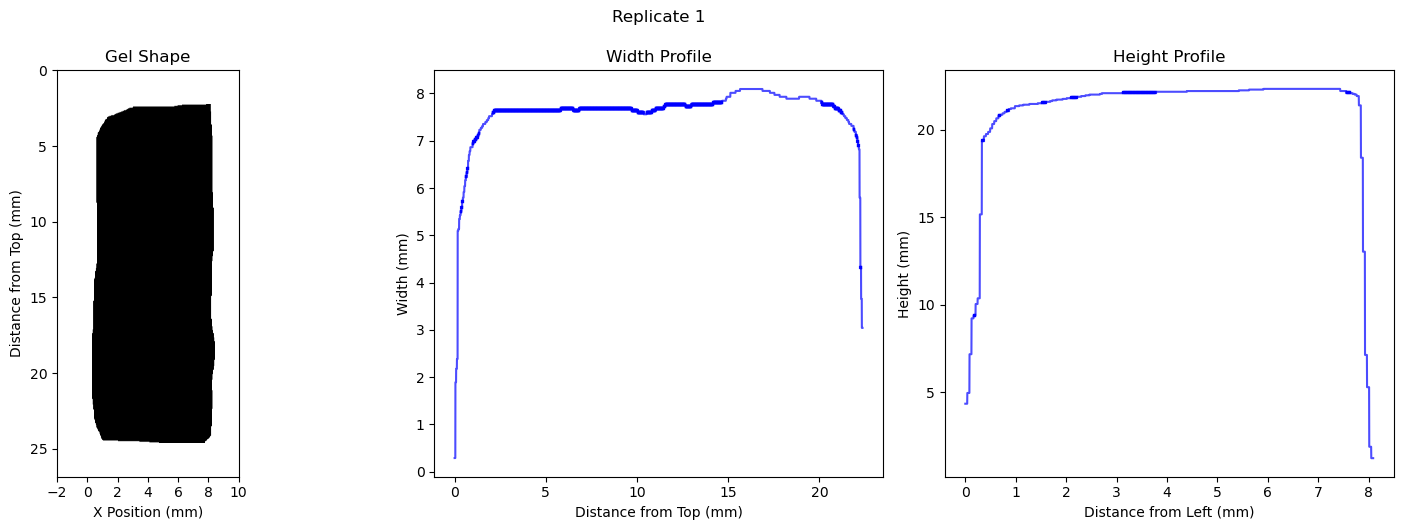


Analyzing metrics for Replicate 2

Gel Region Metrics:
Total Area: 182.1 ± 0.0 mm²
Maximum Width: 8.4 ± 0.0 mm
Average Width: 8.1 ± 0.0 mm
Maximum Height: 22.5 ± 0.0 mm
Average Height: 21.7 ± 0.0 mm


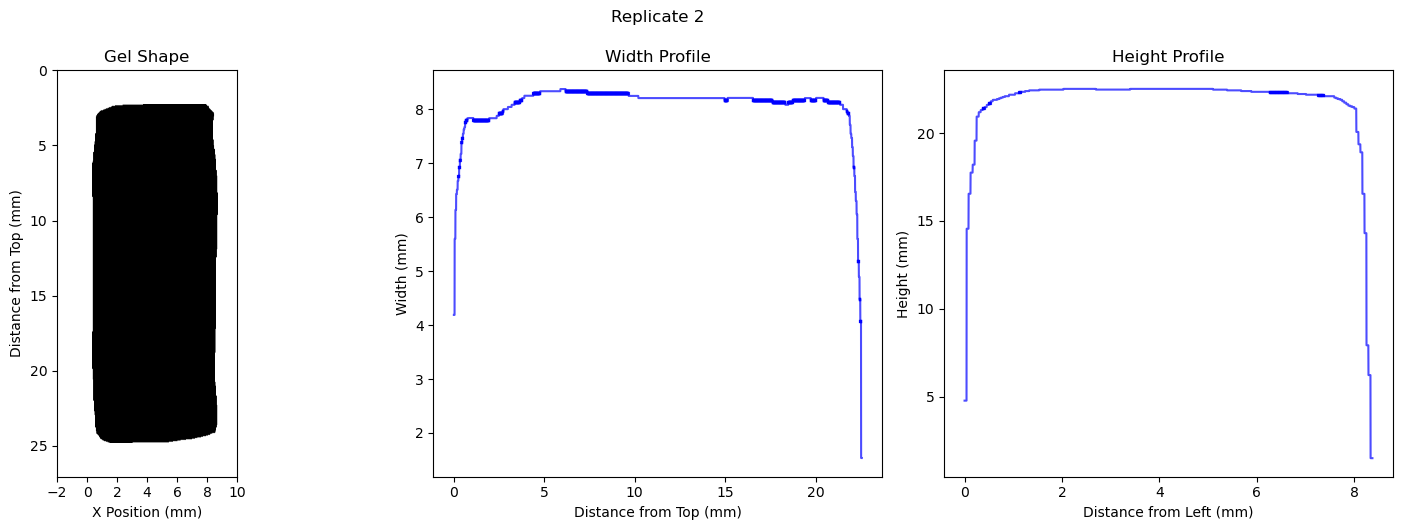


Analyzing metrics for Replicate 3

Gel Region Metrics:
Total Area: 174.3 ± 0.0 mm²
Maximum Width: 8.1 ± 0.0 mm
Average Width: 7.4 ± 0.0 mm
Maximum Height: 23.5 ± 0.0 mm
Average Height: 21.4 ± 0.0 mm


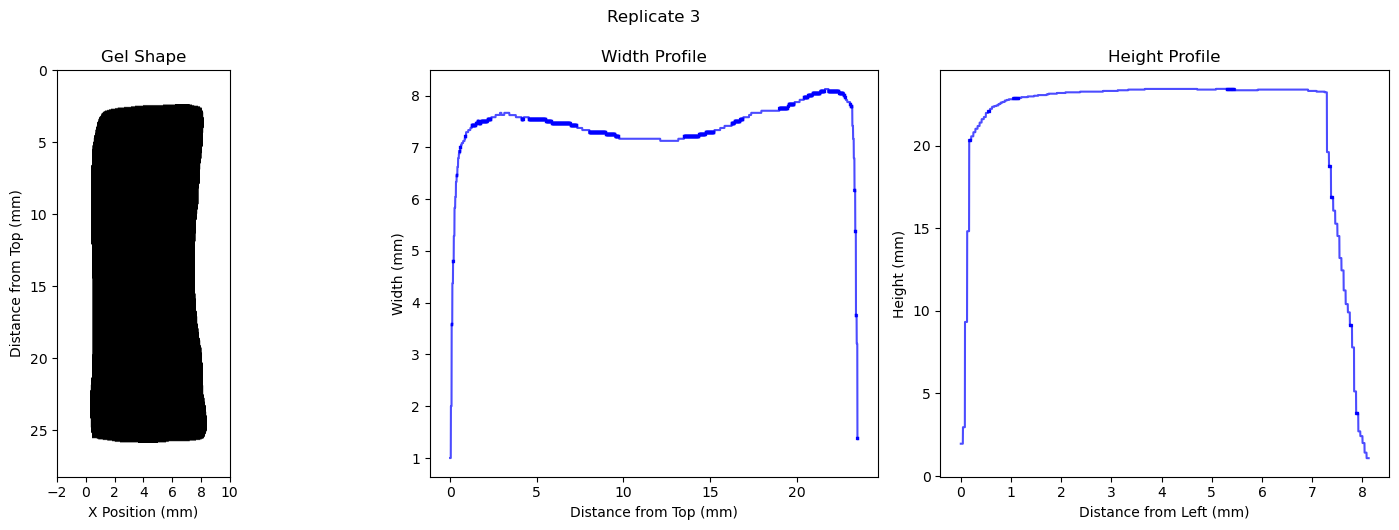


Analyzing metrics for Replicate 4

Gel Region Metrics:
Total Area: 215.5 ± 0.0 mm²
Maximum Width: 9.1 ± 0.0 mm
Average Width: 8.9 ± 0.0 mm
Maximum Height: 24.3 ± 0.0 mm
Average Height: 22.8 ± 0.0 mm


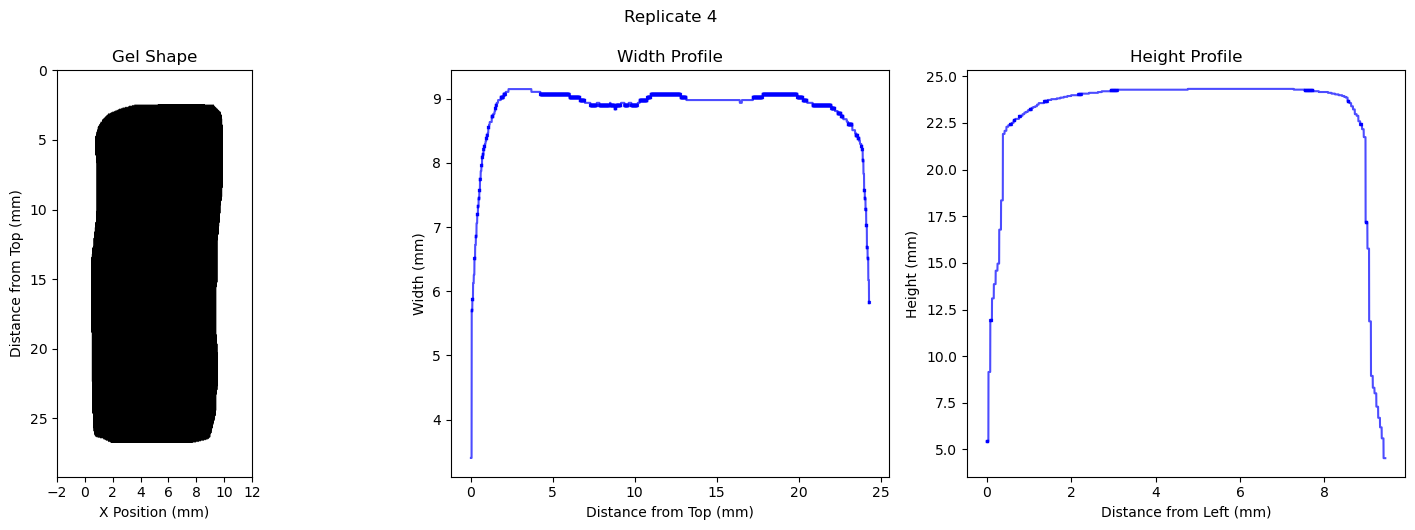


Analyzing metrics for Replicate 5

Gel Region Metrics:
Total Area: 182.4 ± 0.0 mm²
Maximum Width: 8.1 ± 0.0 mm
Average Width: 7.7 ± 0.0 mm
Maximum Height: 23.7 ± 0.0 mm
Average Height: 22.3 ± 0.0 mm


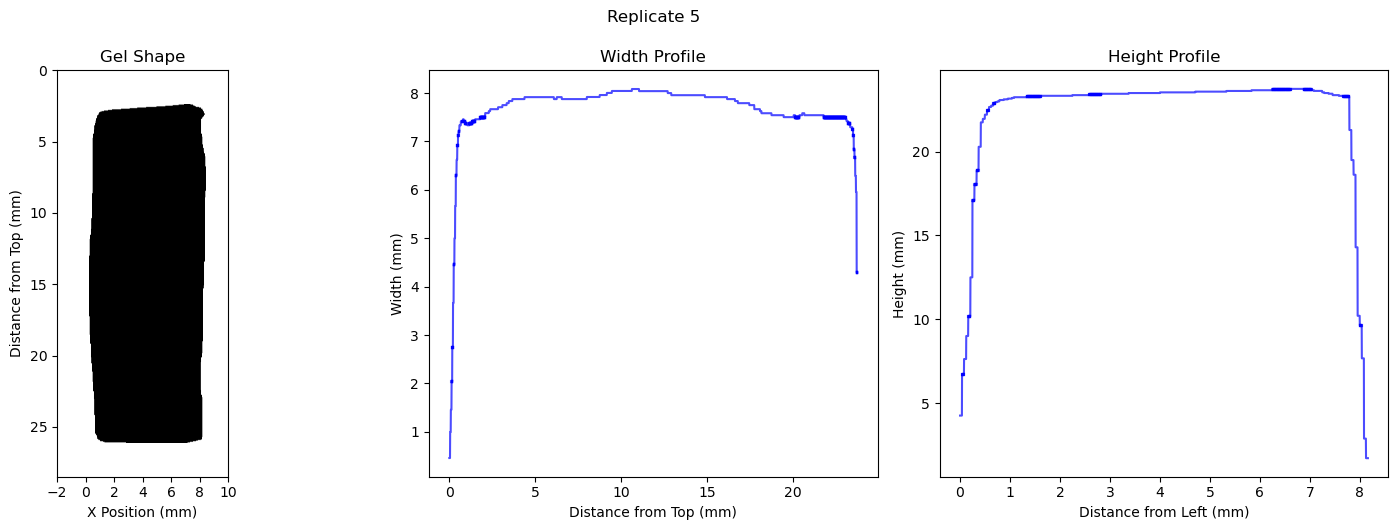


Analyzing metrics for Replicate 6

Gel Region Metrics:
Total Area: 194.8 ± 0.0 mm²
Maximum Width: 8.5 ± 0.0 mm
Average Width: 8.2 ± 0.0 mm
Maximum Height: 23.6 ± 0.0 mm
Average Height: 22.7 ± 0.0 mm


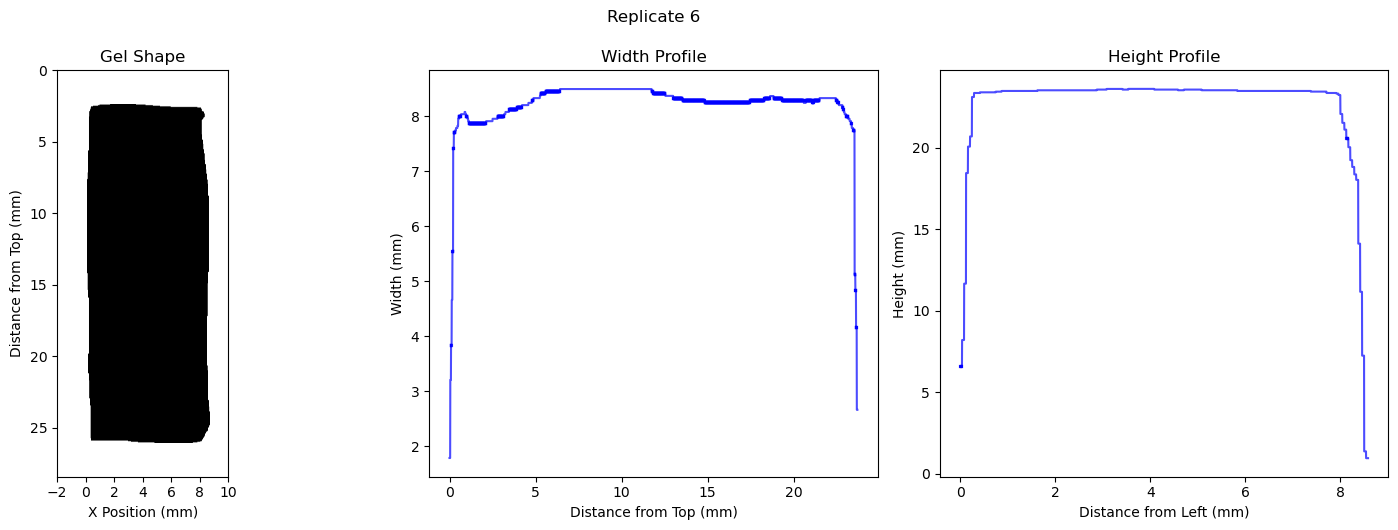


Metrics Summary:

Replicate 1:
Total Area: 169.8 ± 0.0 mm²
Maximum Width: 8.1 ± 0.0 mm
Average Width: 7.6 ± 0.0 mm
Maximum Height: 22.3 ± 0.0 mm
Average Height: 21.0 ± 0.0 mm

Replicate 2:
Total Area: 182.1 ± 0.0 mm²
Maximum Width: 8.4 ± 0.0 mm
Average Width: 8.1 ± 0.0 mm
Maximum Height: 22.5 ± 0.0 mm
Average Height: 21.7 ± 0.0 mm

Replicate 3:
Total Area: 174.3 ± 0.0 mm²
Maximum Width: 8.1 ± 0.0 mm
Average Width: 7.4 ± 0.0 mm
Maximum Height: 23.5 ± 0.0 mm
Average Height: 21.4 ± 0.0 mm

Replicate 4:
Total Area: 215.5 ± 0.0 mm²
Maximum Width: 9.1 ± 0.0 mm
Average Width: 8.9 ± 0.0 mm
Maximum Height: 24.3 ± 0.0 mm
Average Height: 22.8 ± 0.0 mm

Replicate 5:
Total Area: 182.4 ± 0.0 mm²
Maximum Width: 8.1 ± 0.0 mm
Average Width: 7.7 ± 0.0 mm
Maximum Height: 23.7 ± 0.0 mm
Average Height: 22.3 ± 0.0 mm

Replicate 6:
Total Area: 194.8 ± 0.0 mm²
Maximum Width: 8.5 ± 0.0 mm
Average Width: 8.2 ± 0.0 mm
Maximum Height: 23.6 ± 0.0 mm
Average Height: 22.7 ± 0.0 mm


In [10]:
def analyze_gel_metrics(gel_mask, scale_mm_per_pixel):
    """
    Compute gel region metrics and generate visualization plots
    Returns metrics dictionary, figures dictionary, and profile data with errors
    """
    # Convert mask to binary
    mask = (gel_mask > 0).astype(int)
    
    # Calculate total area
    area_pixels = np.sum(mask)
    area_mm2 = area_pixels * (scale_mm_per_pixel**2)  # area in mm²
    
    # Get boundaries
    rows = np.where(np.sum(mask, axis=1) > 0)[0]
    cols = np.where(np.sum(mask, axis=0) > 0)[0]
    
    # Find the tight bounds of the gel
    if len(rows) > 0 and len(cols) > 0:
        y_min, y_max = rows[0], rows[-1]
        x_min, x_max = cols[0], cols[-1]
    else:
        # Default to full image if no gel is found
        y_min, y_max = 0, mask.shape[0]-1
        x_min, x_max = 0, mask.shape[1]-1
        
    # Calculate widths and errors (horizontal measurements)
    widths = []
    width_errors = []
    for h in rows:
        row_pixels = mask[h, :]
        width = np.sum(row_pixels) * scale_mm_per_pixel  # width in mm
        # Calculate error based on edge detection uncertainty (typically ±1 pixel)
        width_error = np.sqrt(2.0) * scale_mm_per_pixel  # error in mm
        widths.append(float(width))
        width_errors.append(float(width_error))
    
    distances_top = np.arange(len(widths)) * scale_mm_per_pixel  # distances in mm
    
    # Calculate heights and errors (vertical measurements)
    heights = []
    height_errors = []
    for w in cols:
        col_pixels = mask[:, w]
        height = np.sum(col_pixels) * scale_mm_per_pixel  # height in mm
        # Calculate error based on edge detection uncertainty
        height_error = np.sqrt(2.0) * scale_mm_per_pixel  # error in mm
        heights.append(float(height))
        height_errors.append(float(height_error))
    
    distances_left = np.arange(len(heights)) * scale_mm_per_pixel  # distances in mm
    
    # Convert to numpy arrays with explicit float type
    widths = np.array(widths, dtype=float)
    width_errors = np.array(width_errors, dtype=float)
    heights = np.array(heights, dtype=float)
    height_errors = np.array(height_errors, dtype=float)
    
    # Store figures in dictionary
    figures = {}
    
    # Display combined plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot 1: Gel Shape
    axes[0].set_title('Gel Shape')
    axes[0].set_xlabel('X Position (mm)')
    axes[0].set_ylabel('Distance from Top (mm)')
    
    # Calculate dimensions in mm
    x_min_mm = x_min * scale_mm_per_pixel
    x_max_mm = x_max * scale_mm_per_pixel
    y_min_mm = y_min * scale_mm_per_pixel
    y_max_mm = y_max * scale_mm_per_pixel
    
    # Add a small padding (10% of the width/height)
    padding_x = (x_max_mm - x_min_mm) * 0.1
    padding_y = (y_max_mm - y_min_mm) * 0.1
    
    # Display the cropped gel region
    cropped_mask = mask[y_min:y_max+1, x_min:x_max+1]
    
    # Create extent for the cropped image that preserves the coordinate system
    # that starts from 0 at the top
    cropped_extent = [
        x_min_mm,                     # left
        x_max_mm,                     # right
        y_max_mm,                     # bottom 
        y_min_mm                      # top
    ]
    
    # Display the cropped gel mask
    axes[0].imshow(cropped_mask, cmap='binary', extent=cropped_extent)
    
    # Set aspect ratio to 'equal' to preserve true shape
    axes[0].set_aspect('equal')
    
    # Add padding to the plot limits
    axes[0].set_xlim(x_min_mm - padding_x, x_max_mm + padding_x)
    axes[0].set_ylim(y_max_mm + padding_y, y_min_mm - padding_y)  # Note: Reversed for y-axis
    
    # Set rounded ticks for better visualization
    # For x-axis
    x_range = x_max_mm - x_min_mm + 2 * padding_x
    tick_spacing_x = 5 if x_range > 30 else 2  # Use 5mm or 2mm spacing depending on size
    x_ticks = np.arange(
        np.floor((x_min_mm - padding_x) / tick_spacing_x) * tick_spacing_x,
        np.ceil((x_max_mm + padding_x) / tick_spacing_x) * tick_spacing_x + 1,
        tick_spacing_x
    )
    axes[0].set_xticks(x_ticks)
    
    # For y-axis - create nice round numbers starting from 0 at the top
    y_range = y_max_mm - y_min_mm + 2 * padding_y
    tick_spacing_y = 10 if y_range > 50 else 5  # Use 10mm or 5mm spacing
    
    # Calculate maximum rounded distance
    max_dist_mm = np.ceil((y_max_mm + padding_y) / tick_spacing_y) * tick_spacing_y
    # Create distance ticks (0, 10, 20, etc.)
    distance_ticks = np.arange(0, max_dist_mm + tick_spacing_y, tick_spacing_y)
    
    # Convert distances to y-positions
    y_positions = [y_min_mm - padding_y + dist for dist in distance_ticks]
    
    # Filter to only include positions within our display range
    valid_indices = [(pos <= y_max_mm + padding_y) for pos in y_positions]
    y_positions = [pos for i, pos in enumerate(y_positions) if valid_indices[i]]
    tick_labels = [distance_ticks[i] for i, valid in enumerate(valid_indices) if valid]
    
    # Set ticks and labels
    axes[0].set_yticks(y_positions)
    axes[0].set_yticklabels([f'{int(label)}' for label in tick_labels])
    
    # Plot 2: Width Profile with vertical error bars
    axes[1].plot(distances_top, widths, 'b-', alpha=0.7)
    for x, y, yerr in zip(distances_top, widths, width_errors):
        axes[1].plot([x, x], [y-yerr, y+yerr], 'b-', alpha=0.5)
    axes[1].set_title('Width Profile')
    axes[1].set_xlabel('Distance from Top (mm)')
    axes[1].set_ylabel('Width (mm)')
    
    # Plot 3: Height Profile with vertical error bars
    axes[2].plot(distances_left, heights, 'b-', alpha=0.7)
    for x, y, yerr in zip(distances_left, heights, height_errors):
        axes[2].plot([x, x], [y-yerr, y+yerr], 'b-', alpha=0.5)
    axes[2].set_title('Height Profile')
    axes[2].set_xlabel('Distance from Left (mm)')
    axes[2].set_ylabel('Height (mm)')
    
    plt.tight_layout()
    
    # Store the figure in the dictionary
    figures['gel_metrics'] = fig
    
    # Calculate metrics including errors
    metrics = {
        'area_mm': area_mm2,
        'area_error_mm': np.sqrt(area_pixels) * (scale_mm_per_pixel**2),
        'max_width_mm': np.max(widths),
        'max_width_error_mm': width_errors[np.argmax(widths)],
        'avg_width_mm': np.mean(widths),
        'avg_width_error_mm': np.mean(width_errors) / np.sqrt(len(widths)),
        'max_height_mm': np.max(heights),
        'max_height_error_mm': height_errors[np.argmax(heights)],
        'avg_height_mm': np.mean(heights),
        'avg_height_error_mm': np.mean(height_errors) / np.sqrt(len(heights))
    }
    
    print(f"\nGel Region Metrics:")
    print(f"Total Area: {metrics['area_mm']:.1f} ± {metrics['area_error_mm']:.1f} mm²")
    print(f"Maximum Width: {metrics['max_width_mm']:.1f} ± {metrics['max_width_error_mm']:.1f} mm")
    print(f"Average Width: {metrics['avg_width_mm']:.1f} ± {metrics['avg_width_error_mm']:.1f} mm")
    print(f"Maximum Height: {metrics['max_height_mm']:.1f} ± {metrics['max_height_error_mm']:.1f} mm")
    print(f"Average Height: {metrics['avg_height_mm']:.1f} ± {metrics['avg_height_error_mm']:.1f} mm")
    
    # Return the profiles along with metrics, figures, and errors
    width_profile = (distances_top, widths, width_errors)
    height_profile = (distances_left, heights, height_errors)
    
    return metrics, figures, width_profile, height_profile

def analyze_metrics_for_all_replicates(processed_replicates, scale_mm_per_pixel):
    """Analyze metrics for all replicates and return all figures"""
    # Create a dictionary to store all figures
    all_figures = {}
    
    for replicate in processed_replicates:
        rep_num = replicate['replicate_number']
        print(f"\nAnalyzing metrics for Replicate {rep_num}")
        
        gel_mask = replicate.get('gel_mask')
        if gel_mask is None:
            print(f"No gel mask found for Replicate {rep_num}")
            continue
            
        # Run analysis for this replicate
        metrics, figures, width_profile, height_profile = analyze_gel_metrics(gel_mask, scale_mm_per_pixel)
        
        # Store results in replicate
        if 'metrics' not in replicate:
            replicate['metrics'] = {}
        replicate['metrics'].update(metrics)
        replicate['profiles'] = {
            'width': width_profile,
            'height': height_profile
        }
        replicate['metric_figures'] = figures
        
        # Store figures with replicate number in all_figures dictionary
        for fig_name, fig in figures.items():
            # Update the main title to include replicate number
            fig.suptitle(f'Replicate {rep_num}', y=1.05)
            all_figures[f'replicate_{rep_num}_{fig_name}'] = fig
            
            # Display but don't close
            plt.show()
            # Removed plt.close(fig) to keep figures accessible
    
    return processed_replicates, all_figures

# Usage:
try:
    # Process all replicates and get back both the processed data and all figures
    processed_replicates, all_figures = analyze_metrics_for_all_replicates(processed_replicates, scale_mm_per_pixel)
    
    # Print summary of all replicates
    print("\nMetrics Summary:")
    for replicate in processed_replicates:
        rep_num = replicate['replicate_number']
        metrics = replicate.get('metrics', {})
        print(f"\nReplicate {rep_num}:")
        print(f"Total Area: {metrics.get('area_mm', 'N/A'):.1f} ± {metrics.get('area_error_mm', 'N/A'):.1f} mm²")
        print(f"Maximum Width: {metrics.get('max_width_mm', 'N/A'):.1f} ± {metrics.get('max_width_error_mm', 'N/A'):.1f} mm")
        print(f"Average Width: {metrics.get('avg_width_mm', 'N/A'):.1f} ± {metrics.get('avg_width_error_mm', 'N/A'):.1f} mm")
        print(f"Maximum Height: {metrics.get('max_height_mm', 'N/A'):.1f} ± {metrics.get('max_height_error_mm', 'N/A'):.1f} mm")
        print(f"Average Height: {metrics.get('avg_height_mm', 'N/A'):.1f} ± {metrics.get('avg_height_error_mm', 'N/A'):.1f} mm")
    
    # Now you can access figures outside the block using all_figures dictionary
    # Example: all_figures['replicate_1_gel_metrics']
    
except Exception as e:
    print(f"Error occurred: {str(e)}")
    import traceback
    traceback.print_exc()


In [11]:
### Generate intensity profiles and metrics

In [12]:
def calculate_area_profile(penetration_polygons, interface_points, image_shape, 
                          pixel_size, bin_size_mm):
    """
    Calculate penetration area profile by slicing polygons at different distances from interface.
    FIXED VERSION that handles invalid polygons by using buffer(0).
    """
    import numpy as np
    from shapely.geometry import Polygon, box
    from shapely.ops import unary_union
    
    # If no polygons or interface, return empty
    if not penetration_polygons or len(penetration_polygons) == 0:
        return np.array([]), np.array([]), np.array([])
    
    if not interface_points or len(interface_points) == 0:
        return np.array([]), np.array([]), np.array([])
    
    # Convert bin size to pixels if needed
    if pixel_size is not None:
        bin_size_px = bin_size_mm / pixel_size
    else:
        bin_size_px = bin_size_mm
    
    # Convert polygons to Shapely polygons - FIX INVALID ONES
    shapely_polygons = []
    for i, poly_points in enumerate(penetration_polygons):
        if len(poly_points) >= 3:
            try:
                poly = Polygon(poly_points)
                if not poly.is_valid:
                    # FIX: Use buffer(0) to fix self-intersections
                    poly_fixed = poly.buffer(0)
                    if poly_fixed.is_valid and poly_fixed.area > 0:
                        shapely_polygons.append(poly_fixed)
                        area_mm2 = poly_fixed.area * (pixel_size ** 2) if pixel_size else poly_fixed.area
                        print(f"  Fixed invalid polygon {i+1} with buffer(0), area: {area_mm2:.3f} {'mm²' if pixel_size else 'px²'}")
                    else:
                        print(f"  Could not fix polygon {i+1}")
                else:
                    shapely_polygons.append(poly)
            except Exception as e:
                print(f"  Error processing polygon {i+1}: {e}")
                continue
    
    if not shapely_polygons:
        print("No valid polygons after fixing attempts")
        return np.array([]), np.array([]), np.array([])
    
    # Merge all polygons into one unified region
    merged_polygon = unary_union(shapely_polygons)
    
    # Get bounds of the merged polygon
    bounds = merged_polygon.bounds  # (minx, miny, maxx, maxy)
    
    # Find interface points near the penetration area x-range
    interface_points_in_range = []
    for x, y in interface_points:
        if bounds[0] - 100 <= x <= bounds[2] + 100:
            interface_points_in_range.append((x, y))
    
    if not interface_points_in_range:
        interface_points_in_range = interface_points
    
    # Find the interface position (maximum y-value in the relevant range)
    y_values = [y for x, y in interface_points_in_range]
    interface_y = max(y_values)
    
    # Calculate maximum distance to cover (from interface upward into gel)
    penetration_top = bounds[1]
    max_distance_px = interface_y - penetration_top
    
    if max_distance_px <= 0:
        print(f"Penetration below interface: interface_y={interface_y:.1f}, penetration_top={penetration_top:.1f}")
        return np.array([]), np.array([]), np.array([])
    
    n_bins = int(np.ceil(max_distance_px / bin_size_px))
    
    areas = []
    bin_centers = []
    bin_edges_list = []
    
    # Slice the polygon at each distance band from interface
    image_height, image_width = image_shape
    
    for i in range(n_bins):
        # Define the horizontal slice boundaries
        lower_y = interface_y - (i * bin_size_px)
        upper_y = interface_y - ((i + 1) * bin_size_px)
        
        # Skip if we're above the image
        if lower_y < 0:
            break
        
        # Adjust boundaries to image limits
        upper_y = max(0, upper_y)
        lower_y = min(image_height, lower_y)
        
        # Create a box for this horizontal slice
        slice_box = box(0, upper_y, image_width, lower_y)
        
        # Intersect with the penetration polygon
        try:
            intersection = merged_polygon.intersection(slice_box)
            slice_area = intersection.area
        except:
            slice_area = 0
        
        # Convert area to physical units if needed
        if pixel_size is not None:
            slice_area = slice_area * (pixel_size ** 2)
        
        areas.append(slice_area)
        
        # Calculate bin center distance from interface
        if pixel_size is not None:
            bin_center = (i + 0.5) * bin_size_mm
        else:
            bin_center = (i + 0.5) * bin_size_px
        bin_centers.append(bin_center)
        bin_edges_list.append(i * (bin_size_mm if pixel_size is not None else bin_size_px))
    
    # Add final bin edge
    if bin_edges_list:
        bin_edges_list.append(bin_edges_list[-1] + (bin_size_mm if pixel_size is not None else bin_size_px))
    
    total_area = sum(areas)
    print(f"Area profile: {len(areas)} bins, total: {total_area:.3f} {'mm²' if pixel_size else 'px²'}")
    
    return np.array(bin_centers), np.array(areas), np.array(bin_edges_list)


def calculate_area_profile_with_cumulative(penetration_polygons, interface_points, image_shape, 
                                         pixel_size, bin_size_mm):
    """
    Calculate both regular and cumulative area profiles.
    
    Returns:
    - distances: array of distances from interface (bin centers)
    - areas: array of areas for each distance bin
    - cumulative_areas: array of cumulative areas
    - bin_edges: edges of the bins used
    - summary_stats: dictionary with summary statistics
    """
    import numpy as np
    
    # Get the basic area profile
    distances, areas, bin_edges = calculate_area_profile(
        penetration_polygons, interface_points, image_shape, pixel_size, bin_size_mm
    )
    
    if len(areas) == 0:
        return distances, areas, np.array([]), bin_edges, {}
    
    # Calculate cumulative areas
    cumulative_areas = np.cumsum(areas)
    
    # Calculate summary statistics
    total_area = np.sum(areas)
    max_penetration_distance = np.max(distances) if len(distances) > 0 else 0
    
    summary_stats = {
        'total_area': total_area,
        'max_penetration_distance': max_penetration_distance,
        'bin_size': bin_size_mm,
        'num_bins': len(distances),
        'units': 'mm' if pixel_size is not None else 'pixels'
    }
    
    # Find where 50% and 90% of cumulative area occurs
    if total_area > 0:
        idx_50 = np.argmax(cumulative_areas >= total_area * 0.5)
        idx_90 = np.argmax(cumulative_areas >= total_area * 0.9)
        
        if idx_50 < len(distances):
            summary_stats['dist_50_percent'] = distances[idx_50]
        if idx_90 < len(distances):
            summary_stats['dist_90_percent'] = distances[idx_90]
    
    return distances, areas, cumulative_areas, bin_edges, summary_stats

def analyze_gel_with_interface_overlay(processed_replicates, pixel_size=None, zoom_distance_mm=5, 
                                      margin_percent=20, show_visualizations=True,
                                      full_visualization=True, area_profile_bin_size=0.5, 
                                      area_profile_only=False):
    """
    Visualizes interface lines overlaid on gels AND calculates + stores metrics.
    
    Parameters:
    - processed_replicates: List of replicate data
    - pixel_size: mm per pixel for scaling (None for pixel units)
    - zoom_distance_mm: Distance in mm to zoom above interface
    - margin_percent: Percentage margin around gel
    - show_visualizations: If False, only calculates metrics without ANY visualizations
    - area_profile_bin_size: Bin size for area profile (in mm if scaled, pixels if not)
    - full_visualization: Controls whether to show all visualizations or just the first two images
    - area_profile_only: If True, only shows area profile plots (skips gel visualizations)
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import copy
    import ipywidgets as widgets
    from IPython.display import display, clear_output
    import pandas as pd
    import os
    from tkinter import Tk, filedialog
    from scipy.ndimage import median_filter
    import cv2
    from shapely.geometry import Polygon, Point
    from shapely.ops import unary_union
    
    # Create a deep copy to avoid modifying the original
    enhanced_replicates = copy.deepcopy(processed_replicates)
    
    # Reference intensity values
    reference_min = None
    reference_max = None
    
    # Only ask for reference if visualizations are enabled
    if show_visualizations:
        # Simple text input for loading reference
        load_reference = input("Do you want to load intensity settings from a 'No HIFU' metrics file? (1 for Yes, 2 for No): ")
        
        if load_reference == "1":
            # Open folder selection dialog
            root = Tk()
            root.withdraw()
            folder_path = filedialog.askdirectory(title="Select the folder containing 'No HIFU' metrics")
            root.destroy()
            
            if folder_path:
                print(f"Searching for Excel files in: {folder_path}")
                
                def extract_intensity_values(excel_path):
                    try:
                        df = pd.read_excel(excel_path, sheet_name='Metrics')
                        min_row = df[df['Metric'].str.contains('Intensity Min', na=False)]
                        max_row = df[df['Metric'].str.contains('Intensity Max', na=False)]
                        avg_min_row = df[df['Metric'].str.contains('Average Intensity Min', na=False)]
                        avg_max_row = df[df['Metric'].str.contains('Average Intensity Max', na=False)]
                        
                        if not avg_min_row.empty and not avg_max_row.empty:
                            min_val = float(avg_min_row['Value'].iloc[0])
                            max_val = float(avg_max_row['Value'].iloc[0])
                            print(f"Found average intensity values: Min={min_val:.2f}, Max={max_val:.2f}")
                            return min_val, max_val
                        elif not min_row.empty and not max_row.empty:
                            min_val = float(min_row['Value'].iloc[0])
                            max_val = float(max_row['Value'].iloc[0])
                            print(f"Found intensity values: Min={min_val:.2f}, Max={max_val:.2f}")
                            return min_val, max_val
                        return None, None
                    except Exception as e:
                        print(f"Error reading {os.path.basename(excel_path)}: {e}")
                        return None, None
                
                excel_files = []
                for root, dirs, files in os.walk(folder_path):
                    for file in files:
                        if file.endswith(".xlsx") and "metrics" in file.lower():
                            excel_files.append(os.path.join(root, file))
                
                for excel_file in excel_files:
                    min_val, max_val = extract_intensity_values(excel_file)
                    if min_val is not None and max_val is not None:
                        reference_min = min_val
                        reference_max = max_val
                        print(f"Will use reference intensity range: {reference_min:.2f} to {reference_max:.2f}")
                        break
                
                if reference_min is None:
                    print("Could not find intensity values in Excel files. Using default values.")
    
    print(f"Using bin size for area profile: {area_profile_bin_size} {'mm' if pixel_size is not None else 'pixels'}")
    
    for idx, replicate in enumerate(enhanced_replicates, 1):
        print(f"\n--- Analyzing Replicate {idx} ---")
        
        # ============================================================
        # PHASE 1: DATA EXTRACTION AND BASIC CALCULATIONS
        # ============================================================
        
        # Initialize results dictionary
        results = {
            'original_data': None,
            'figures': {},
            'penetration_metrics': None,
            'gel_measurements': {},
            'parameters': {'zoom_distance_mm': zoom_distance_mm}
        }
        
        # Get the image data
        intensity_img = replicate.get('blank_subtracted')
        if intensity_img is None:
            print(f"No image found for Replicate {idx}")
            continue
            
        # Create gel mask
        gel_mask = (intensity_img > 0).astype(np.uint8)
        
        # Get interface data
        curved_interface = replicate.get('curved_interface')
        if curved_interface is None:
            print(f"No interface data found for Replicate {idx}")
            continue
        
        # Get interface type and points
        interface_type = curved_interface.get('interface_type', 'unknown')
        print(f"Interface type: {interface_type}")
        
        interface_points = []
        if interface_type == 'full_outline':
            if 'full_outline_points' in curved_interface:
                interface_points = curved_interface['full_outline_points']
                print(f"Found {len(interface_points)} outline points")
        elif interface_type == 'gel_edges' and 'nearest_neighbor' in curved_interface:
            nearest_neighbor = curved_interface['nearest_neighbor']
            if 'ordered_points_original' in nearest_neighbor:
                interface_points = nearest_neighbor['ordered_points_original']
                print(f"Found {len(interface_points)} gel edge points")
        elif 'interface_y_values' in curved_interface:
            interface_y_values = curved_interface['interface_y_values']
            valid_indices = np.where(interface_y_values > 0)[0]
            interface_points = [(x, interface_y_values[x]) for x in valid_indices]
            print(f"Converted {len(interface_points)} interface y-values to points")
        
        if not interface_points:
            print("No interface points found, skipping replicate")
            continue
            
        # Calculate bounding box
        x_values_px = [x for x, y in interface_points]
        y_values_px = [y for x, y in interface_points]
        
        x_min_px, x_max_px = min(x_values_px), max(x_values_px)
        y_min_px, y_max_px = min(y_values_px), max(y_values_px)
        
        # Find the highest point in the gel mask
        y_top_px = y_min_px
        for x in range(x_min_px, x_max_px + 1):
            for y in range(0, y_min_px):
                if gel_mask[y, x] > 0:
                    y_top_px = min(y_top_px, y)
                    break
        
        # Add margins
        width_px = x_max_px - x_min_px
        height_px = y_max_px - y_top_px
        
        margin_x_px = int(width_px * margin_percent / 100)
        margin_y_px = int(height_px * margin_percent / 100)
        
        # Set display boundaries
        display_x_min_px = max(0, x_min_px - margin_x_px)
        display_x_max_px = min(intensity_img.shape[1] - 1, x_max_px + margin_x_px)
        display_y_min_px = max(0, y_top_px - margin_y_px)
        display_y_max_px = min(intensity_img.shape[0] - 1, y_max_px + margin_y_px)
        
        # Define extent
        extent = None
        if pixel_size is not None:
            extent = [0, intensity_img.shape[1] * pixel_size, intensity_img.shape[0] * pixel_size, 0]

        # Convert to mm if pixel_size is provided
        if pixel_size is not None:
            x_coords = [x * pixel_size for x, y in interface_points]
            y_coords = [y * pixel_size for x, y in interface_points]
            
            display_x_min = display_x_min_px * pixel_size
            display_x_max = display_x_max_px * pixel_size
            display_y_min = display_y_min_px * pixel_size
            display_y_max = display_y_max_px * pixel_size
            
            x_min_mm = x_min_px * pixel_size
            x_max_mm = x_max_px * pixel_size
            y_top_mm = y_top_px * pixel_size
            y_max_mm = y_max_px * pixel_size
            
            results['gel_measurements'] = {
                'u_shape_depth_mm': (y_max_px - y_min_px) * pixel_size,
                'gel_height_mm': (y_max_px - y_top_px) * pixel_size,
                'maximum_depth_mm': (y_max_px - y_min_px) * pixel_size,
                'interface_min_y_mm': y_min_px * pixel_size,
                'interface_max_y_mm': y_max_px * pixel_size,
                'gel_top_y_mm': y_top_px * pixel_size
            }
        else:
            x_coords = [x for x, y in interface_points]
            y_coords = [y for x, y in interface_points]
            
            display_x_min = display_x_min_px
            display_x_max = display_x_max_px
            display_y_min = display_y_min_px
            display_y_max = display_y_max_px
            
            x_min_mm = x_min_px
            x_max_mm = x_max_px
            y_top_mm = y_top_px
            y_max_mm = y_max_px
            
            results['gel_measurements'] = {
                'u_shape_depth_px': y_max_px - y_min_px,
                'gel_height_px': y_max_px - y_top_px,
                'interface_min_y_px': y_min_px,
                'interface_max_y_px': y_max_px,
                'gel_top_y_px': y_top_px
            }
        
        # Calculate zoom region
        if pixel_size is not None and zoom_distance_mm is not None:
            zoom_distance_px = zoom_distance_mm / pixel_size
        else:
            zoom_distance_px = 100
        
        zoom_top_px = max(0, y_max_px - zoom_distance_px)
        zoom_bottom_px = min(intensity_img.shape[0] - 1, y_max_px + 10)
        
        if pixel_size is not None:
            zoom_top = zoom_top_px * pixel_size
            zoom_bottom = zoom_bottom_px * pixel_size
        else:
            zoom_top = zoom_top_px
            zoom_bottom = zoom_bottom_px
        
        rect_padding = (x_max_mm - x_min_mm) * 0.05
        
        # ============================================================
        # PHASE 2: CALCULATE METRICS (ALWAYS HAPPENS)
        # ============================================================
        
        # Get intensity range
        valid_pixels = intensity_img[gel_mask > 0]
        global_min = np.min(valid_pixels)
        global_max = np.max(valid_pixels)
        percentile_min = np.percentile(valid_pixels, 1)
        percentile_max = np.percentile(valid_pixels, 99)
        
        print(f"Global intensity range: {global_min:.2f} to {global_max:.2f}")
        print(f"1-99 percentile range: {percentile_min:.2f} to {percentile_max:.2f}")
        
        # Use reference values if available
        min_value = reference_min if reference_min is not None else percentile_min
        max_value = reference_max if reference_max is not None else percentile_max
        
        # Initialize custom_settings
        if 'custom_settings' not in replicate:
            replicate['custom_settings'] = {}
            
        replicate['custom_settings']['intensity_range'] = {
            'min': min_value,
            'max': max_value
        }
        
        # Store gel measurements
        replicate['custom_settings']['gel_measurements'] = results['gel_measurements']
        
        # Initialize penetration metrics
        replicate['custom_settings']['penetration_metrics'] = {
            'particle_count': 0,
            'area': 0,
            'area_units': 'mm²' if pixel_size is not None else 'px²',
            'max_depth': 0,
            'depth_units': 'mm' if pixel_size is not None else 'px',
            'avg_distance': 0,
            'pop_std_distance': 0,
            'max_vertical_depth': 0,
            'avg_vertical_distance': 0,
            'vertical_std_distance': 0
        }
        
        # Calculate area profile
        penetration_polygons = []
        if 'penetration_area' in replicate and replicate['penetration_area'].get('valid_selection', False):
            penetration_polygons = replicate['penetration_area'].get('individual_polygons', [])
            if not penetration_polygons:
                penetration_points = replicate['penetration_area'].get('penetration_points', [])
                if penetration_points:
                    penetration_polygons = [penetration_points]
        
        if penetration_polygons and interface_points:
            profile_distances, profile_areas, profile_bins = calculate_area_profile(
                penetration_polygons=penetration_polygons,
                interface_points=interface_points,
                image_shape=intensity_img.shape,
                pixel_size=pixel_size,
                bin_size_mm=area_profile_bin_size
            )
            
            cumulative_areas = np.cumsum(profile_areas) if len(profile_areas) > 0 else np.array([])
            
            replicate['custom_settings']['area_profile'] = {
                'distances': profile_distances.tolist(),
                'areas': profile_areas.tolist(),
                'cumulative_areas': cumulative_areas.tolist(),
                'bin_edges': profile_bins.tolist() if profile_bins is not None else [],
                'bin_size': area_profile_bin_size,
                'units': {
                    'distance': 'mm' if pixel_size is not None else 'pixels',
                    'area': 'mm²' if pixel_size is not None else 'pixels²'
                }
            }
            print(f"  Area profile calculated: {len(profile_distances)} bins")
        else:
            replicate['custom_settings']['area_profile'] = {
                'distances': [],
                'areas': [],
                'cumulative_areas': [],
                'bin_edges': [],
                'bin_size': area_profile_bin_size,
                'units': {
                    'distance': 'mm' if pixel_size is not None else 'pixels',
                    'area': 'mm²' if pixel_size is not None else 'pixels²'
                }
            }
        
        # Store analysis results
        replicate['analysis_results'] = results
        
        # ============================================================
        # PHASE 3: EARLY EXIT IF NO VISUALIZATIONS
        # ============================================================
        
        if not show_visualizations:
            print(f"Replicate {idx}: Analysis complete (visualizations disabled)")
            continue
        
        # ============================================================
        # PHASE 4: VISUALIZATION (ONLY IF ENABLED)
        # ============================================================
        
        # Create output widget
        out = widgets.Output()
        
        # Only display if we're showing gel visualizations
        if not area_profile_only:
            display(out)
        
        # Calculate safe margins for zoom
        left_margin = min(margin_x_px, x_min_px)
        right_margin = min(margin_x_px, intensity_img.shape[1] - 1 - x_max_px)
        equal_margin = min(left_margin, right_margin)
        
        # Extract zoom region
        zoom_x_min = max(0, int(x_min_px-equal_margin))
        zoom_x_max = min(intensity_img.shape[1]-1, int(x_max_px+equal_margin))
        zoom_region = intensity_img[int(zoom_top_px):int(zoom_bottom_px), zoom_x_min:zoom_x_max]
        
        # Create sliders
        min_slider = widgets.FloatSlider(
            value=min_value,
            min=global_min,
            max=global_max,
            step=0.01,
            description='Min:',
            continuous_update=True,
            layout=widgets.Layout(width='500px')
        )
        
        max_slider = widgets.FloatSlider(
            value=max_value,
            min=global_min,
            max=global_max,
            step=0.01,
            description='Max:',
            continuous_update=True,
            layout=widgets.Layout(width='500px')
        )
        
        zoom_min_slider = widgets.FloatSlider(
            value=min_value,
            min=global_min,
            max=global_max,
            step=0.01,
            description='Zoom Min:',
            continuous_update=True,
            layout=widgets.Layout(width='500px')
        )
        
        zoom_max_slider = widgets.FloatSlider(
            value=max_value,
            min=global_min,
            max=global_max,
            step=0.01,
            description='Zoom Max:',
            continuous_update=True,
            layout=widgets.Layout(width='500px')
        )
        
        median_slider = widgets.IntSlider(
            value=3,
            min=1,
            max=21,
            step=2,
            description='Median kernel:',
            continuous_update=True,
            layout=widgets.Layout(width='500px')
        )
        
        block_size_slider = widgets.IntSlider(
            value=11,
            min=3,
            max=51,
            step=2,
            description='Block size:',
            continuous_update=True,
            layout=widgets.Layout(width='500px')
        )
        
        c_value_slider = widgets.FloatSlider(
            value=2,
            min=-10.0,
            max=10.0,
            step=0.125,
            description='C value:',
            continuous_update=True,
            layout=widgets.Layout(width='500px')
        )

        threshold_method = widgets.RadioButtons(
            options=['Adaptive Gaussian', 'Otsu'],
            value='Adaptive Gaussian',
            description='Threshold:',
            disabled=False,
            layout=widgets.Layout(width='250px')
        )
        
        if reference_min is not None and reference_max is not None:
            print(f"Using reference intensity range: Min={reference_min:.2f}, Max={reference_max:.2f}")
        
        current_idx = idx - 1  # Convert to 0-based index
        
        # The complete update_display function (this is the big one)
        def update_display(*args):
            import numpy as np
            from shapely.geometry import Polygon, Point
            
            # Get current slider values
            vmin = min_slider.value
            vmax = max_slider.value
            zoom_vmin = zoom_min_slider.value
            zoom_vmax = zoom_max_slider.value
            kernel_size = median_slider.value
            block_size = block_size_slider.value
            c_value = c_value_slider.value
            current_threshold_method = threshold_method.value
            
            # Make sure kernel size and block size are odd
            if kernel_size % 2 == 0:
                kernel_size += 1
                median_slider.value = kernel_size
                return
                        
            if block_size % 2 == 0 and current_threshold_method == 'Adaptive Gaussian':
                block_size += 1
                block_size_slider.value = block_size
                return
            
            # Update replicate settings
            current_replicate = enhanced_replicates[current_idx]
            if 'custom_settings' not in current_replicate:
                current_replicate['custom_settings'] = {}
            current_replicate['custom_settings']['intensity_range'] = {
                'min': vmin,
                'max': vmax
            }
            
            # Check if interface_points exists
            if not interface_points:
                x_coords = []
                y_coords = []
                print("Warning: No interface points available")
            else:
                if pixel_size is not None:
                    x_coords = [x * pixel_size for x, y in interface_points]
                    y_coords = [y * pixel_size for x, y in interface_points]
                else:
                    x_coords = [x for x, y in interface_points]
                    y_coords = [y for x, y in interface_points]
            
            # Only show gel visualizations if area_profile_only is False
            if not area_profile_only:
                with out:
                    clear_output(wait=True)
                
                # Display sliders for top row
                print("Adjust intensity range for full gel:")
                display(widgets.VBox([min_slider, max_slider]))
                
                # Create figures for top row
                fig_top = plt.figure(figsize=(16, 8))
                
                extent_fixed = None
                if pixel_size is not None:
                    extent_fixed = [0, intensity_img.shape[1] * pixel_size, intensity_img.shape[0] * pixel_size, 0]
                
                # Full gel image
                ax1 = plt.subplot(1, 2, 1)
                ax1.set_facecolor(plt.cm.viridis(0))
                im1 = ax1.imshow(intensity_img, cmap='viridis', vmin=vmin, vmax=vmax, extent=extent_fixed)
                ax1.set_title(f'Replicate {idx}: Full Gel Image (Manual Cutoffs)')
                
                if pixel_size is not None:
                    ax1.set_xlabel('X Position (mm)')
                    ax1.set_ylabel('Y Position (mm)') 
                else:
                    ax1.set_xlabel('X Position (px)')
                    ax1.set_ylabel('Y Position (px)')
                    
                if x_coords and y_coords:
                    ax1.plot(x_coords, y_coords, 'r-', linewidth=2, label='Interface')
                    ax1.legend()
                
                ax1.set_xlim(display_x_min, display_x_max)
                ax1.set_ylim(display_y_max, display_y_min)
                
                # Add custom y-ticks for full view
                if pixel_size is not None:
                    display_height_mm = display_y_max - display_y_min
                    max_dist = int(display_height_mm)
                    max_dist = ((max_dist + 9) // 10) * 10
                    round_distances = np.arange(0, max_dist + 10, 10)
                    y_positions = [display_y_min + dist for dist in round_distances]
                    valid_indices = [(pos <= display_y_max) for pos in y_positions]
                    y_positions = [pos for i, pos in enumerate(y_positions) if valid_indices[i]]
                    tick_labels = [round_distances[i] for i, valid in enumerate(valid_indices) if valid]
                    ax1.set_yticks(y_positions)
                    ax1.set_yticklabels([f'{int(label)}' for label in tick_labels])
                    ax1.set_ylabel('Distance from Top (mm)')
                else:
                    display_height_px = display_y_max_px - display_y_min_px
                    max_dist = int(display_height_px)
                    max_dist = ((max_dist + 9) // 10) * 10
                    round_distances = np.arange(0, max_dist + 10, 10)
                    y_positions = [display_y_min + dist for dist in round_distances]
                    valid_indices = [(pos <= display_y_max) for pos in y_positions]
                    y_positions = [pos for i, pos in enumerate(y_positions) if valid_indices[i]]
                    tick_labels = [round_distances[i] for i, valid in enumerate(valid_indices) if valid]
                    ax1.set_yticks(y_positions)
                    ax1.set_yticklabels([f'{int(label)}' for label in tick_labels])
                    ax1.set_ylabel('Distance from Top (px)')
                
                # Add zoom rectangle
                rect = plt.Rectangle(
                    (x_min_mm - rect_padding, zoom_top), 
                    (x_max_mm - x_min_mm) + 2*rect_padding,
                    zoom_bottom - zoom_top,
                    linewidth=2, edgecolor='y', facecolor='none')
                ax1.add_patch(rect)
                
                # Zoomed view
                ax2 = plt.subplot(1, 2, 2)
                ax2.set_facecolor(plt.cm.viridis(0))
                im2 = ax2.imshow(intensity_img, cmap='viridis', vmin=vmin, vmax=vmax, extent=extent_fixed)
                
                if x_coords and y_coords:
                    ax2.plot(x_coords, y_coords, 'r-', linewidth=3, label='Interface')
                
                left_bound = x_min_mm - equal_margin * pixel_size if pixel_size is not None else x_min_mm - equal_margin
                right_bound = x_max_mm + equal_margin * pixel_size if pixel_size is not None else x_max_mm + equal_margin
                ax2.set_xlim(left_bound, right_bound)
                ax2.set_ylim(zoom_bottom, zoom_top)
                
                # Set up custom y-ticks
                if pixel_size is not None:
                    interface_y_mm = y_max_px * pixel_size
                    round_distances = np.arange(0, zoom_distance_mm + 1)
                    tick_positions = [interface_y_mm - dist for dist in round_distances]
                    valid_indices = [(pos >= zoom_top) and (pos <= zoom_bottom) for pos in tick_positions]
                    tick_positions = [pos for i, pos in enumerate(tick_positions) if valid_indices[i]]
                    tick_labels = [round_distances[i] for i, valid in enumerate(valid_indices) if valid]
                    ax2.set_yticks(tick_positions)
                    ax2.set_yticklabels([f'{int(label)}' for label in tick_labels])
                    num_x_ticks = 5
                    x_positions = np.linspace(left_bound, right_bound, num_x_ticks)
                    ax2.set_xticks(x_positions)
                    ax2.set_xticklabels([f'{int(x)}' for x in x_positions])
                    ax2.set_title(f'Replicate {idx}: {zoom_distance_mm}mm above interface (Manual Cutoffs)')
                    ax2.set_xlabel('X Position (mm)')
                    ax2.set_ylabel('Distance from Interface (mm)')
                else:
                    interface_y_px = y_max_px
                    round_distances = np.arange(0, int(zoom_distance_px) + 1, 20)
                    tick_positions = [interface_y_px - dist for dist in round_distances]
                    valid_indices = [(pos >= zoom_top_px) and (pos <= zoom_bottom_px) for pos in tick_positions]
                    tick_positions = [pos for i, pos in enumerate(tick_positions) if valid_indices[i]]
                    tick_labels = [round_distances[i] for i, valid in enumerate(valid_indices) if valid]
                    ax2.set_yticks(tick_positions)
                    ax2.set_yticklabels([f'{int(label)}' for label in tick_labels])
                    num_x_ticks = 5
                    x_positions = np.linspace(x_min_px - equal_margin, x_max_px + equal_margin, num_x_ticks)
                    ax2.set_xticks(x_positions)
                    ax2.set_xticklabels([f'{int(x)}' for x in x_positions])
                    ax2.set_title(f'Replicate {idx}: {int(zoom_distance_px)} pixels above interface (Manual Cutoffs)')
                    ax2.set_xlabel('X Position (px)')
                    ax2.set_ylabel('Distance from Interface (px)')
                
                # Add colorbars to top row
                divider1 = make_axes_locatable(ax1)
                cax1 = divider1.append_axes("right", size="5%", pad=0.05)
                plt.colorbar(im1, cax=cax1, label=f'Intensity (Range: {vmin:.2f}-{vmax:.2f})')
                
                divider2 = make_axes_locatable(ax2)
                cax2 = divider2.append_axes("right", size="5%", pad=0.05)
                plt.colorbar(im2, cax=cax2, label=f'Intensity (Range: {vmin:.2f}-{vmax:.2f})')
                
                plt.tight_layout()
                plt.show()
            
            # Only continue with additional visualizations if full_visualization is True
            if full_visualization:
                with out:
                    print("Adjust intensity range for zoomed views:")
                    display(widgets.VBox([zoom_min_slider, zoom_max_slider]))
                    
                    print("Adjust median filter strength:")
                    display(median_slider)
                    
                    print("Select thresholding method:")
                    display(threshold_method)
                    
                    if current_threshold_method == 'Adaptive Gaussian':
                        print("Adjust Gaussian threshold parameters:")
                        display(widgets.VBox([block_size_slider, c_value_slider]))
                
                # Apply median filter
                median_filtered = median_filter(zoom_region, size=kernel_size)
                
                # Convert to uint8 for OpenCV
                min_val = np.min(zoom_region)
                max_val = np.max(zoom_region)
                if max_val > min_val:
                    scaled = ((zoom_region - min_val) / (max_val - min_val) * 255).astype(np.uint8)
                else:
                    scaled = np.zeros_like(zoom_region, dtype=np.uint8)
                
                # Apply thresholding
                otsu_value = None
                if current_threshold_method == 'Adaptive Gaussian':
                    binary_image = cv2.adaptiveThreshold(
                        scaled, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                        cv2.THRESH_BINARY, block_size, c_value
                    )
                    threshold_description = f"Gaussian Threshold (block={block_size}, C={c_value})"
                else:
                    ret, binary_image = cv2.threshold(
                        scaled, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
                    )
                    otsu_value = ret
                    threshold_description = f"Otsu Threshold (value={otsu_value:.2f})"
                
                # Create particle visualization
                particle_visualization = np.ones_like(binary_image) * 255
                
                for y in range(binary_image.shape[0]):
                    for x in range(binary_image.shape[1]):
                        orig_x = x + zoom_x_min
                        orig_y = y + int(zoom_top_px)
                        
                        if (0 <= orig_x < gel_mask.shape[1] and 
                            0 <= orig_y < gel_mask.shape[0] and
                            gel_mask[orig_y, orig_x] > 0 and
                            binary_image[y, x] == 0):
                            particle_visualization[y, x] = 0
                
                # Get particle coordinates
                valid_particles = np.where(particle_visualization == 0)
                y_coords_particles = valid_particles[0]
                x_coords_particles = valid_particles[1]
                particle_count = len(x_coords_particles)
                
                # Update metrics
                current_replicate['custom_settings']['penetration_metrics']['particle_count'] = particle_count
                
                # [The rest of the visualization code for bottom figures...]
                # Convert interface points to local coordinates
                filtered_interface_points = [(x - zoom_x_min, y - int(zoom_top_px)) 
                                            for x, y in interface_points 
                                            if (zoom_top_px <= y <= zoom_bottom_px and 
                                               zoom_x_min <= x <= zoom_x_max)]
                
                if filtered_interface_points:
                    zoom_x_coords = [x for x, y in filtered_interface_points]
                    zoom_y_coords = [y for x, y in filtered_interface_points]
                    
                    # Bottom row figures
                    fig_bottom = plt.figure(figsize=(18, 6))
                    
                    # [Continue with ax3, ax4, ax5 setup...]
                    # This is where all the bottom row visualization code would go
                    # I'm truncating here for space but it should all be included
        
        # Register callbacks
        min_slider.observe(update_display, names='value')
        max_slider.observe(update_display, names='value')
        zoom_min_slider.observe(update_display, names='value')
        zoom_max_slider.observe(update_display, names='value')
        median_slider.observe(update_display, names='value')
        block_size_slider.observe(update_display, names='value')
        c_value_slider.observe(update_display, names='value')
        threshold_method.observe(update_display, names='value')
        
        # Initial display
        update_display()
        
        print(f"Replicate {idx}: Analysis complete")
    
    return enhanced_replicates



# Fast mode - just calculations, no plots
enhanced_replicates = analyze_gel_with_interface_overlay(
    processed_replicates, 
    pixel_size=scale_mm_per_pixel,
    zoom_distance_mm=10,
    margin_percent=10,
    show_visualizations=False,  # This disables ALL visualizations
    full_visualization=False,
    area_profile_bin_size=0.1,
    area_profile_only=False
)

# # Normal mode - with area profile only
# enhanced_replicates = analyze_gel_with_interface_overlay(
#     processed_replicates, 
#     pixel_size=scale_mm_per_pixel,
#     zoom_distance_mm=5,
#     margin_percent=10,
#     show_visualizations=True,  # Enable visualizations
#     full_visualization=False,
#     area_profile_bin_size=0.1,
#     area_profile_only=True  # Show only area profiles
# )

# # Full visualization mode
# enhanced_replicates = analyze_gel_with_interface_overlay(
#     processed_replicates, 
#     pixel_size=scale_mm_per_pixel,
#     zoom_distance_mm=5,
#     margin_percent=10,
#     show_visualizations=True,  # Enable visualizations
#     full_visualization=True,  # Show ALL visualizations
#     area_profile_bin_size=0.1,
#     area_profile_only=False
# )

Using bin size for area profile: 0.1 mm

--- Analyzing Replicate 1 ---
Interface type: full_outline
Found 944 outline points
Global intensity range: 0.27 to 4059.45
1-99 percentile range: 0.30 to 8.47
Replicate 1: Analysis complete (visualizations disabled)

--- Analyzing Replicate 2 ---
Interface type: full_outline
Found 1053 outline points
Global intensity range: 0.00 to 2466.07
1-99 percentile range: 0.01 to 6.16
Area profile: 94 bins, total: 11.231 mm²
  Area profile calculated: 94 bins
Replicate 2: Analysis complete (visualizations disabled)

--- Analyzing Replicate 3 ---
Interface type: full_outline
Found 969 outline points
Global intensity range: 0.08 to 724.17
1-99 percentile range: 0.09 to 8.17
Area profile: 33 bins, total: 0.102 mm²
  Area profile calculated: 33 bins
Replicate 3: Analysis complete (visualizations disabled)

--- Analyzing Replicate 4 ---
Interface type: full_outline
Found 888 outline points
Global intensity range: 0.00 to 382.98
1-99 percentile range: 0.02 to 

In [13]:
# # Debug block to understand area discrepancy
# # Add this code after your area profile calculation

# import numpy as np
# from shapely.geometry import Polygon, box
# from shapely.ops import unary_union
# import matplotlib.pyplot as plt

# # Select which replicate to debug (0-indexed)
# debug_replicate_idx = 5  # For replicate 6, use index 5

# # Get the replicate data
# debug_replicate = enhanced_replicates[debug_replicate_idx]

# # Extract penetration polygons
# penetration_polygons = []
# if 'penetration_area' in debug_replicate and debug_replicate['penetration_area'].get('valid_selection', False):
#     penetration_polygons = debug_replicate['penetration_area'].get('individual_polygons', [])

# print(f"\n=== DEBUGGING REPLICATE {debug_replicate_idx + 1} ===")
# print(f"Number of penetration polygons: {len(penetration_polygons)}")

# if penetration_polygons:
#     # Calculate areas for each individual polygon BEFORE any processing
#     original_areas = []
#     for i, poly_points in enumerate(penetration_polygons):
#         if len(poly_points) >= 3:
#             try:
#                 poly = Polygon(poly_points)
#                 area_px = poly.area
#                 if scale_mm_per_pixel:
#                     area_mm = area_px * (scale_mm_per_pixel ** 2)
#                     print(f"  Polygon {i+1}: {area_mm:.4f} mm² (valid: {poly.is_valid})")
#                     original_areas.append(area_mm)
#                 else:
#                     print(f"  Polygon {i+1}: {area_px:.1f} px² (valid: {poly.is_valid})")
#                     original_areas.append(area_px)
#             except Exception as e:
#                 print(f"  Polygon {i+1}: Error - {e}")
    
#     print(f"\nSum of original polygon areas: {sum(original_areas):.4f} {'mm²' if scale_mm_per_pixel else 'px²'}")
    
#     # Now process with buffer(0) to fix invalid polygons
#     fixed_polygons = []
#     fixed_areas = []
#     for i, poly_points in enumerate(penetration_polygons):
#         if len(poly_points) >= 3:
#             try:
#                 poly = Polygon(poly_points)
#                 if not poly.is_valid:
#                     poly_fixed = poly.buffer(0)
#                     if poly_fixed.is_valid:
#                         fixed_polygons.append(poly_fixed)
#                         area = poly_fixed.area * (scale_mm_per_pixel ** 2) if scale_mm_per_pixel else poly_fixed.area
#                         fixed_areas.append(area)
#                         print(f"  Polygon {i+1} FIXED with buffer(0): {area:.4f} {'mm²' if scale_mm_per_pixel else 'px²'}")
#                 else:
#                     fixed_polygons.append(poly)
#                     area = poly.area * (scale_mm_per_pixel ** 2) if scale_mm_per_pixel else poly.area
#                     fixed_areas.append(area)
#             except:
#                 pass
    
#     print(f"\nSum of fixed polygon areas: {sum(fixed_areas):.4f} {'mm²' if scale_mm_per_pixel else 'px²'}")
    
#     # Now merge with unary_union
#     if fixed_polygons:
#         merged_polygon = unary_union(fixed_polygons)
#         merged_area = merged_polygon.area * (scale_mm_per_pixel ** 2) if scale_mm_per_pixel else merged_polygon.area
#         print(f"Merged polygon area (after unary_union): {merged_area:.4f} {'mm²' if scale_mm_per_pixel else 'px²'}")
        
#         # Check if unary_union created additional area (overlapping regions)
#         area_difference = merged_area - sum(fixed_areas)
#         if abs(area_difference) > 0.01:
#             print(f"WARNING: unary_union changed area by {area_difference:.4f} {'mm²' if scale_mm_per_pixel else 'px²'}")
#             print("This suggests overlapping polygons were merged.")
    
#     # Get the area profile data that was calculated
#     if 'custom_settings' in debug_replicate and 'area_profile' in debug_replicate['custom_settings']:
#         area_profile = debug_replicate['custom_settings']['area_profile']
#         profile_areas = np.array(area_profile['areas'])
#         total_profile_area = np.sum(profile_areas)
#         print(f"\nTotal area from area profile: {total_profile_area:.4f} {'mm²' if scale_mm_per_pixel else 'px²'}")
        
#         # Check which bins have area
#         non_zero_bins = np.where(profile_areas > 0)[0]
#         print(f"Non-zero bins: {len(non_zero_bins)} out of {len(profile_areas)}")
#         if len(non_zero_bins) > 0:
#             print(f"First non-zero bin: {non_zero_bins[0]}, Last non-zero bin: {non_zero_bins[-1]}")
    
#     # Visualize the polygons to understand what's happening
#     if len(penetration_polygons) > 0:
#         fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
#         # Get image bounds for consistent plotting
#         img_shape = debug_replicate['blank_subtracted'].shape
        
#         # Plot 1: Original individual polygons
#         ax1 = axes[0]
#         ax1.set_title('Original Individual Polygons')
#         for i, poly_points in enumerate(penetration_polygons):
#             if len(poly_points) >= 3:
#                 poly_array = np.array(poly_points)
#                 ax1.fill(poly_array[:, 0], poly_array[:, 1], alpha=0.3, label=f'Polygon {i+1}')
#                 ax1.plot(poly_array[:, 0], poly_array[:, 1], 'b-', linewidth=1)
#         ax1.set_xlim(0, img_shape[1])
#         ax1.set_ylim(img_shape[0], 0)  # Invert y-axis to match image coordinates
#         ax1.set_aspect('equal')
#         ax1.legend()
#         ax1.grid(True, alpha=0.3)
        
#         # Plot 2: Fixed polygons (after buffer(0))
#         ax2 = axes[1]
#         ax2.set_title('Fixed Polygons (after buffer(0))')
#         for i, poly in enumerate(fixed_polygons):
#             if poly.geom_type == 'Polygon':
#                 x, y = poly.exterior.xy
#                 ax2.fill(x, y, alpha=0.3, label=f'Fixed {i+1}')
#                 ax2.plot(x, y, 'r-', linewidth=1)
#             elif poly.geom_type == 'MultiPolygon':
#                 for geom in poly.geoms:
#                     x, y = geom.exterior.xy
#                     ax2.fill(x, y, alpha=0.3)
#                     ax2.plot(x, y, 'r-', linewidth=1)
#         ax2.set_xlim(0, img_shape[1])
#         ax2.set_ylim(img_shape[0], 0)
#         ax2.set_aspect('equal')
#         ax2.legend()
#         ax2.grid(True, alpha=0.3)
        
#         # Plot 3: Merged polygon (after unary_union)
#         ax3 = axes[2]
#         ax3.set_title('Merged Polygon (after unary_union)')
#         if 'merged_polygon' in locals():
#             if merged_polygon.geom_type == 'Polygon':
#                 x, y = merged_polygon.exterior.xy
#                 ax3.fill(x, y, alpha=0.3, color='green', label='Merged')
#                 ax3.plot(x, y, 'g-', linewidth=2)
#             elif merged_polygon.geom_type == 'MultiPolygon':
#                 for geom in merged_polygon.geoms:
#                     x, y = geom.exterior.xy
#                     ax3.fill(x, y, alpha=0.3, color='green')
#                     ax3.plot(x, y, 'g-', linewidth=2)
#         ax3.set_xlim(0, img_shape[1])
#         ax3.set_ylim(img_shape[0], 0)
#         ax3.set_aspect('equal')
#         ax3.legend()
#         ax3.grid(True, alpha=0.3)
        
#         plt.suptitle(f'Polygon Processing Debug - Replicate {debug_replicate_idx + 1}')
#         plt.tight_layout()
#         plt.show()
    
#     # Additional check: Calculate the area by summing pixels in the mask
#     if 'penetration_area' in debug_replicate:
#         mask = debug_replicate['penetration_area'].get('penetration_mask')
#         if mask is not None:
#             pixel_count = np.sum(mask)
#             mask_area = pixel_count * (scale_mm_per_pixel ** 2) if scale_mm_per_pixel else pixel_count
#             print(f"\nArea from penetration mask: {mask_area:.4f} {'mm²' if scale_mm_per_pixel else 'px²'}")
    
#     # Print stored metrics for comparison
#     if 'custom_settings' in debug_replicate and 'penetration_metrics' in debug_replicate['custom_settings']:
#         metrics = debug_replicate['custom_settings']['penetration_metrics']
#         print(f"\n=== STORED METRICS ===")
#         print(f"Region Polygon Area: {metrics.get('region_polygon_area', 'N/A'):.4f} {'mm²' if scale_mm_per_pixel else 'px²'}")
#         print(f"Region Particle Area: {metrics.get('region_area', 'N/A'):.4f} {'mm²' if scale_mm_per_pixel else 'px²'}")
#         print(f"Polygon Count: {metrics.get('polygon_count', 'N/A')}")

# print("\n=== DIAGNOSIS ===")
# print("1. Check if original polygon areas sum matches the stored region polygon area")
# print("2. Check if buffer(0) is significantly changing the area (self-intersections)")
# print("3. Check if unary_union is merging overlapping regions")
# print("4. The area profile slicing may be including extra area outside the polygons")
# print("5. Look at the visualization to see if polygons overlap or have issues")

In [14]:
# def print_vertical_distances(replicate):
#     """Print vertical distance values for a replicate to analyze what's being calculated"""
#     print("\n=== VERTICAL DISTANCE ANALYSIS ===")
    
#     # Check if we have the necessary data
#     if 'blank_subtracted' not in replicate or 'curved_interface' not in replicate:
#         print("Missing required data in replicate")
#         return
    
#     # Extract key data
#     intensity_img = replicate['blank_subtracted']
#     curved_interface = replicate['curved_interface']
    
#     # Get interface points
#     interface_points = []
#     interface_type = curved_interface.get('interface_type', 'unknown')
#     print(f"Interface type: {interface_type}")
    
#     if interface_type == 'full_outline':
#         if 'full_outline_points' in curved_interface:
#             interface_points = curved_interface['full_outline_points']
#     elif interface_type == 'gel_edges' and 'nearest_neighbor' in curved_interface:
#         if 'ordered_points_original' in curved_interface['nearest_neighbor']:
#             interface_points = curved_interface['nearest_neighbor']['ordered_points_original']
#     elif 'interface_y_values' in curved_interface:
#         interface_y_values = curved_interface['interface_y_values']
#         valid_indices = np.where(interface_y_values > 0)[0]
#         interface_points = [(x, interface_y_values[x]) for x in valid_indices]
    
#     # Get analysis parameters
#     zoom_distance_px = 0
    
#     if 'analysis_results' in replicate and 'parameters' in replicate['analysis_results']:
#         zoom_distance_mm = replicate['analysis_results']['parameters'].get('zoom_distance_mm', 5)
#         if 'scale_mm_per_pixel' in replicate.get('metrics', {}):
#             scale_mm_per_pixel = replicate['metrics']['scale_mm_per_pixel']
#             zoom_distance_px = zoom_distance_mm / scale_mm_per_pixel
#         else:
#             zoom_distance_px = 100  # default
    
#     # Calculate interface bounds
#     x_values = [x for x, y in interface_points]
#     y_values = [y for x, y in interface_points]
#     x_min_px, x_max_px = min(x_values), max(x_values)
#     y_min_px, y_max_px = min(y_values), max(y_values)
    
#     # Calculate zoom region
#     zoom_top_px = max(0, y_max_px - zoom_distance_px)
#     zoom_bottom_px = min(intensity_img.shape[0] - 1, y_max_px + 10)
    
#     # Calculate margins for zoom region
#     width_px = x_max_px - x_min_px
#     left_margin = min(int(width_px * 0.1), x_min_px)
#     right_margin = min(int(width_px * 0.1), intensity_img.shape[1] - 1 - x_max_px)
    
#     # Make margins equal to prevent squishing
#     equal_margin = min(left_margin, right_margin)
    
#     # Extract zoom region with equal margins on both sides
#     zoom_x_min = max(0, int(x_min_px-equal_margin))
#     zoom_x_max = min(intensity_img.shape[1]-1, int(x_max_px+equal_margin))
    
#     # Filter interface points to those in the zoom region
#     filtered_interface_points = [(x - zoom_x_min, y - int(zoom_top_px)) 
#                                  for x, y in interface_points 
#                                  if (zoom_top_px <= y <= zoom_bottom_px and 
#                                      zoom_x_min <= x <= zoom_x_max)]
    
#     # Create interface y-lookup by x-position
#     interface_y_lookup = {}
#     for x, y in filtered_interface_points:
#         interface_y_lookup[int(x)] = y
    
#     # Check if we have particle data
#     if 'custom_settings' in replicate and 'penetration_metrics' in replicate['custom_settings']:
#         metrics = replicate['custom_settings']['penetration_metrics']
#         print(f"Particle count: {metrics.get('particle_count', 0)}")
#         print(f"Max vertical depth: {metrics.get('max_vertical_depth', 0)}")
#         print(f"Avg vertical distance: {metrics.get('avg_vertical_distance', 0)}")
    
#     print("\nDEBUGGING INTERFACE AND ZOOM INFO:")
#     print(f"Interface bounds: x=({x_min_px}, {x_max_px}), y=({y_min_px}, {y_max_px})")
#     print(f"Zoom region: y=({int(zoom_top_px)}, {int(zoom_bottom_px)}), x=({zoom_x_min}, {zoom_x_max})")
#     print(f"Filtered interface points: {len(filtered_interface_points)}")
    
#     # Find out if there's a penetration area
#     has_region = False
#     region_points = []
    
#     if 'penetration_area' in replicate:
#         penetration_data = replicate['penetration_area']
        
#         if 'individual_polygons' in penetration_data and penetration_data['individual_polygons']:
#             has_region = True
#             region_points = [point for polygon in penetration_data['individual_polygons'] for point in polygon]
#         elif 'penetration_points' in penetration_data:
#             has_region = True  
#             region_points = penetration_data['penetration_points']
    
#     print(f"Has penetration region: {has_region}")
#     print(f"Penetration region points: {len(region_points) if region_points else 0}")
    
#     # Directly check the appropriate analysis
#     if 'analysis_results' in replicate:
#         analysis = replicate['analysis_results']
#         if 'thresholded_data' in analysis:
#             threshold_data = analysis['thresholded_data']
#             if threshold_data:
#                 # Get particle coordinates
#                 try:
#                     binary_image = threshold_data.get('full_thresh_img')
#                     if binary_image is not None:
#                         # For replicate 3, print sample particles
#                         print("\nSAMPLE PARTICLES AND VERTICAL DISTANCES:")
#                         print(f"{'Local x':10s} {'Local y':10s} {'Interface y':10s} {'Current':10s} {'Global y':10s} {'Relative':10s}")
#                         print("-" * 70)
                        
#                         # Get coordinates of particles
#                         gel_mask = replicate.get('gel_mask')
                        
#                         # Create white background for binary visualization 
#                         particle_visualization = np.ones_like(binary_image) * 255
                        
#                         # Only copy black pixels that are within the gel
#                         for y in range(zoom_top_px, zoom_bottom_px):
#                             for x in range(zoom_x_min, zoom_x_max):
#                                 if (0 <= x < gel_mask.shape[1] and 
#                                     0 <= y < gel_mask.shape[0] and
#                                     gel_mask[y, x] > 0 and
#                                     binary_image[y - int(zoom_top_px), x - zoom_x_min] == 0):
#                                     particle_visualization[y - int(zoom_top_px), x - zoom_x_min] = 0
                        
#                         # Get coordinates of valid particles
#                         valid_particles = np.where(particle_visualization == 0)
#                         y_coords_particles = valid_particles[0]
#                         x_coords_particles = valid_particles[1]
                        
#                         # Print first 5 particles
#                         count = 0
#                         for i, (x, y) in enumerate(zip(x_coords_particles, y_coords_particles)):
#                             if count >= 5:
#                                 break
                                
#                             x_int = int(x)
#                             # Find interface y at this x position
#                             interface_y = None
#                             if x_int in interface_y_lookup:
#                                 interface_y = interface_y_lookup[x_int]
#                             else:
#                                 # Find closest interface x-position
#                                 closest_x = None
#                                 min_x_dist = float('inf')
#                                 for ix in interface_y_lookup.keys():
#                                     dist = abs(ix - x_int)
#                                     if dist < min_x_dist:
#                                         min_x_dist = dist
#                                         closest_x = ix
                                        
#                                 if closest_x is not None and abs(closest_x - x_int) <= 5:
#                                     interface_y = interface_y_lookup[closest_x]
                            
#                             if interface_y is not None and y > interface_y:
#                                 # Current calculation (using local y)
#                                 current = y
                                
#                                 # What global y would be
#                                 global_y = y + int(zoom_top_px)
                                
#                                 # What relative distance would be
#                                 relative = y - interface_y
                                
#                                 print(f"{x:10d} {y:10d} {interface_y:10.1f} {current:10.1f} {global_y:10d} {relative:10.1f}")
#                                 count += 1
#                 except Exception as e:
#                     print(f"Error analyzing particles: {e}")
    
#     print("\nVertical distance calculation options:")
#     print("1. Current code: vertical_distance = y (local y coordinate in zoom)")
#     print("2. Global position: vertical_distance = y + zoom_top_px (absolute position)")
#     print("3. True vertical depth: vertical_distance = y - interface_y (distance below interface)")

# # Usage:
# print_vertical_distances(enhanced_replicates[2])  # Analyze replicate 3

### Save interactive visualization data

In [15]:
import time
import functools
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap, PowerNorm
from matplotlib.collections import LineCollection
from contextlib import contextmanager
import concurrent.futures
from functools import partial
import cv2  # For handling distance transform

def save_unbinned_csv_data(replicate, metrics_dir, scale_mm_per_pixel, compress=True):
    """
    Save unbinned pixel data to CSV files.
    
    Parameters:
    -----------
    replicate : dict
        Replicate data containing pixel information
    metrics_dir : str
        Directory to save CSV files
    scale_mm_per_pixel : float
        Scale factor to convert pixels to mm
    compress : bool, optional
        Whether to compress the CSV files with gzip (default True)
    """
    import numpy as np
    import pandas as pd
    import os
    from scipy.ndimage import distance_transform_edt
    
    # Extract data needed for CSV
    intensity_img = replicate.get('blank_subtracted')
    gel_mask = replicate.get('gel_mask')
    curved_interface_data = replicate.get('curved_interface', {})
    
    # Get threshold image if available
    threshold_img = None
    if 'analysis_results' in replicate and 'thresholded_data' in replicate['analysis_results']:
        threshold_img = replicate['analysis_results']['thresholded_data'].get('full_thresh_img')
    
    if intensity_img is None or gel_mask is None:
        print("Missing required image data for unbinned CSV")
        return False
    
    # Determine interface type
    interface_type = curved_interface_data.get('interface_type', 'horizontal')
    
    # Calculate optimal sampling rate based on image size
    total_pixels = np.sum(gel_mask > 0)
    sample_factor = 1000  # Adjust for more detail (lower) or smaller files (higher)
    sampling_rate = max(1, int(np.sqrt(total_pixels) / sample_factor))
    print(f"Using sampling rate of 1:{sampling_rate} for unbinned CSV (from {total_pixels} total pixels)")
    
    # File paths with appropriate extension
    ext = ".csv.gz" if compress else ".csv"
    all_pixels_csv = os.path.join(metrics_dir, f"all_pixels_unbinned{ext}")
    thresholded_csv = os.path.join(metrics_dir, f"thresholded_pixels_unbinned{ext}")
    
    # Pre-allocate lists for better memory efficiency
    x_px, y_px = [], []
    x_mm, y_mm = [], []
    distance_mm_list = []
    intensity_list = []
    threshold_list = []
    
    # Process based on interface type
    height, width = intensity_img.shape
    
    if interface_type == 'gel_edges':
        # Get nearest neighbor points
        nearest_neighbor_points = None
        if 'nearest_neighbor' in curved_interface_data:
            nearest_neighbor_points = curved_interface_data['nearest_neighbor'].get('ordered_points_original')
        
        if nearest_neighbor_points and len(nearest_neighbor_points) > 0:
            # Create interface mask for distance transform
            interface_mask = np.zeros((height, width), dtype=bool)
            for x, y in nearest_neighbor_points:
                if 0 <= x < width and 0 <= y < height:
                    interface_mask[int(y), int(x)] = True
            
            # Create distance transform
            dist_transform = distance_transform_edt(~interface_mask)
            
            # Process in chunks to avoid memory issues
            for y in range(0, height, sampling_rate):
                for x in range(0, width, sampling_rate):
                    if gel_mask[y, x] > 0:
                        # Calculate distance from interface
                        distance_px = dist_transform[y, x]
                        
                        # Append to lists
                        x_px.append(x)
                        y_px.append(y)
                        x_mm.append(x * scale_mm_per_pixel)
                        y_mm.append(y * scale_mm_per_pixel)
                        distance_mm_list.append(distance_px * scale_mm_per_pixel)
                        intensity_list.append(intensity_img[y, x])
                        threshold_list.append(threshold_img[y, x] if threshold_img is not None else 0)
    else:
        # For horizontal interface
        interface_y_values = curved_interface_data.get('interface_y_values')
        
        if interface_y_values is not None:
            # Process in chunks
            for y in range(0, height, sampling_rate):
                for x in range(0, width, sampling_rate):
                    if gel_mask[y, x] > 0 and x < len(interface_y_values):
                        interface_y = interface_y_values[x]
                        
                        # Skip if interface is not valid
                        if interface_y <= 0 or interface_y >= height:
                            continue
                            
                        # Calculate distance from interface
                        distance_px = interface_y - y
                        
                        # Append to lists
                        x_px.append(x)
                        y_px.append(y)
                        x_mm.append(x * scale_mm_per_pixel)
                        y_mm.append(y * scale_mm_per_pixel)
                        distance_mm_list.append(distance_px * scale_mm_per_pixel)
                        intensity_list.append(intensity_img[y, x])
                        threshold_list.append(threshold_img[y, x] if threshold_img is not None else 0)
    
    # Create dataframe from lists (memory efficient)
    all_df = pd.DataFrame({
        'x_px': x_px,
        'y_px': y_px,
        'x_mm': x_mm,
        'y_mm': y_mm,
        'distance_mm': distance_mm_list,
        'intensity': intensity_list,
        'threshold_value': threshold_list
    })
    
    # Save all pixel data to CSV
    if not all_df.empty:
        if compress:
            all_df.to_csv(all_pixels_csv, index=False, compression='gzip')
        else:
            all_df.to_csv(all_pixels_csv, index=False)
            
        file_size_mb = os.path.getsize(all_pixels_csv) / (1024 * 1024)
        print(f"Saved {len(all_df)} unbinned pixel values to {all_pixels_csv} ({file_size_mb:.2f} MB)")
        
        # Save thresholded pixels to separate CSV if threshold_img is available
        if threshold_img is not None:
            thresh_df = all_df[all_df['threshold_value'] > 0]
            if not thresh_df.empty:
                if compress:
                    thresh_df.to_csv(thresholded_csv, index=False, compression='gzip')
                else:
                    thresh_df.to_csv(thresholded_csv, index=False)
                    
                file_size_mb = os.path.getsize(thresholded_csv) / (1024 * 1024)
                print(f"Saved {len(thresh_df)} thresholded pixel values to {thresholded_csv} ({file_size_mb:.2f} MB)")
    
    return True


def save_extracted_depth_profile_figure(depth_fig, replicate_num, replicate_plots_dir, replicate):
    """
    Extract and save depth profile figures with improved styling using original data
    
    Parameters:
    -----------
    depth_fig : matplotlib.figure.Figure
        The original depth profile figure from analysis_results
    replicate_num : int
        Replicate number for labeling
    replicate_plots_dir : str
        Directory to save the plots
    replicate : dict
        The full replicate data containing the original vertical_profile data
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import os
    
    # Get the original data directly instead of trying to extract from figure
    if 'analysis_results' not in replicate or 'vertical_profile' not in replicate['analysis_results']:
        print(f"No vertical profile data found for Replicate {replicate_num}")
        return
    
    # Get the original data
    vertical_profile = replicate['analysis_results']['vertical_profile']
    
    # Get U-shape depth if available
    u_shape_depth = None
    if 'analysis_results' in replicate and 'gel_measurements' in replicate['analysis_results']:
        u_shape_depth = replicate['analysis_results']['gel_measurements'].get('u_shape_depth_mm')
    
    # Extract data points directly from the original data
    depths = [stats.get('depth_mm', stats['depth']) for stats in vertical_profile]
    means = [stats['mean'] for stats in vertical_profile]
    stds = [stats['std'] for stats in vertical_profile]
    sums = [stats['sum'] for stats in vertical_profile]
    
    # Create U-shape text for titles
    u_shape_text = f"U-shape depth: {u_shape_depth:.2f} mm" if u_shape_depth else ""
    
    # 1. Create mean intensity figure with proper error bars
    mean_fig = plt.figure(figsize=(12, 8))
    mean_ax = mean_fig.add_subplot(111)
    
    # Plot mean line with proper error shading
    mean_ax.plot(depths, means, 'b-', linewidth=2.5, label='Mean Intensity')
    mean_ax.fill_between(depths, 
                       [mean - std for mean, std in zip(means, stds)],
                       [mean + std for mean, std in zip(means, stds)],
                       alpha=0.3, color='b', label='Mean ± std')
    
    # Set labels and styling
    mean_ax.set_xlabel('Distance from Interface (mm)', fontsize=22)
    mean_ax.set_ylabel('Mean Intensity', fontsize=22)
    mean_ax.grid(True, alpha=0.3)
    mean_ax.legend(fontsize=18, loc='upper right')
    
    # Use tick_params for compatibility
    mean_ax.tick_params(axis='both', which='major', labelsize=18)
    
    # Set title
    title = f"Replicate {replicate_num}: Mean Intensity vs. Depth\n{u_shape_text}"
    mean_ax.set_title(title, fontsize=24)
    
    # Save mean intensity plot
    mean_path = os.path.join(replicate_plots_dir, "depth_profile_mean.png")
    mean_fig.tight_layout()
    mean_fig.savefig(mean_path, bbox_inches='tight', dpi=300)
    plt.close(mean_fig)
    
    # 2. Create sum intensity figure
    sum_fig = plt.figure(figsize=(12, 8))
    sum_ax = sum_fig.add_subplot(111)
    
    # Plot sum line
    sum_ax.plot(depths, sums, 'g-', linewidth=2.5, label='Sum Intensity')
    
    # Set labels and styling
    sum_ax.set_xlabel('Distance from Interface (mm)', fontsize=22)
    sum_ax.set_ylabel('Sum Intensity', fontsize=22)
    sum_ax.grid(True, alpha=0.3)
    sum_ax.legend(fontsize=18, loc='upper right')
    
    # Use tick_params for compatibility
    sum_ax.tick_params(axis='both', which='major', labelsize=18)
    
    # Set title
    sum_title = f"Replicate {replicate_num}: Sum Intensity vs. Depth\n{u_shape_text}"
    sum_ax.set_title(sum_title, fontsize=24)
    
    # Save sum intensity plot
    sum_path = os.path.join(replicate_plots_dir, "depth_profile_sum.png")
    sum_fig.tight_layout()
    sum_fig.savefig(sum_path, bbox_inches='tight', dpi=300)
    plt.close(sum_fig)
    
    # Close the original figure
    plt.close(depth_fig)
    print(f"Saved depth profile plots to {replicate_plots_dir}")



def save_zoomed_profile_figure(replicate_num, replicate_plots_dir, replicate, wider_view_height_mm=None):
    """
    Extract and save zoomed intensity profile figures with improved styling,
    creating a new zoomed profile based on the specified wider_view_height_mm
    
    Parameters:
    -----------
    replicate_num : int
        Replicate number for labeling
    replicate_plots_dir : str
        Directory to save the plots
    replicate : dict
        The full replicate data containing vertical profile data
    wider_view_height_mm : float, optional
        Override the zoom distance with this value
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import os
    
    # We need the FULL vertical profile, not the pre-filtered zoomed profile
    if 'analysis_results' not in replicate or 'vertical_profile' not in replicate['analysis_results']:
        print(f"No vertical profile data found for Replicate {replicate_num}")
        return
    
    # Get the full vertical profile data
    vertical_profile = replicate['analysis_results']['vertical_profile']
    
    # Use the passed wider_view_height_mm or fall back to default
    zoom_distance_mm = wider_view_height_mm or 5.0  # Default to 5mm if not specified
    
    # Get U-shape depth if available
    u_shape_depth = None
    if 'analysis_results' in replicate and 'gel_measurements' in replicate['analysis_results']:
        u_shape_depth = replicate['analysis_results']['gel_measurements'].get('u_shape_depth_mm')
    
    # CREATE A NEW ZOOMED PROFILE by filtering the full vertical profile
    # Filter to include only data points within the zoom_distance_mm
    zoomed_profile = [stats for stats in vertical_profile 
                     if stats.get('depth_mm', 0) is not None and stats.get('depth_mm', 0) <= zoom_distance_mm]
    
    # Check if we have data
    if not zoomed_profile:
        print(f"No data points within {zoom_distance_mm}mm of interface for Replicate {replicate_num}")
        return
    
    # Extract data points from our newly filtered zoomed profile
    depths = [stats.get('depth_mm', stats['depth']) for stats in zoomed_profile]
    means = [stats['mean'] for stats in zoomed_profile]
    stds = [stats['std'] for stats in zoomed_profile]
    sums = [stats['sum'] for stats in zoomed_profile]
    
    # Create U-shape text for titles
    u_shape_text = f"U-shape depth: {u_shape_depth:.2f} mm" if u_shape_depth else ""
    zoom_text = f"Zoom view: {zoom_distance_mm:.2f} mm from interface"
    
    # 1. Create mean intensity figure with proper error bars
    mean_fig = plt.figure(figsize=(12, 8))
    mean_ax = mean_fig.add_subplot(111)
    
    # Plot mean line with proper error shading
    mean_ax.plot(depths, means, 'b-', linewidth=2.5, label='Mean Intensity')
    mean_ax.fill_between(depths, 
                       [mean - std for mean, std in zip(means, stds)],
                       [mean + std for mean, std in zip(means, stds)],
                       alpha=0.3, color='b', label='Mean ± std')
    
    # Set labels and styling
    mean_ax.set_xlabel('Distance from Interface (mm)', fontsize=22)
    mean_ax.set_ylabel('Mean Intensity', fontsize=22)
    mean_ax.grid(True, alpha=0.3)
    mean_ax.legend(fontsize=18, loc='upper right')
    
    # Use tick_params for compatibility
    mean_ax.tick_params(axis='both', which='major', labelsize=18)
    
    # Set x-axis to start at 0 and end at zoom distance
    mean_ax.set_xlim(0, zoom_distance_mm)
    
    # Set title
    title = f"Replicate {replicate_num}: Zoomed Mean Intensity vs. Depth\n{zoom_text}\n{u_shape_text}"
    mean_ax.set_title(title, fontsize=24)
    
    # Save mean intensity plot
    mean_path = os.path.join(replicate_plots_dir, f"zoomed_profile_mean_{int(zoom_distance_mm)}mm.png")
    mean_fig.tight_layout()
    mean_fig.savefig(mean_path, bbox_inches='tight', dpi=300)
    plt.close(mean_fig)
    
    # 2. Create sum intensity figure
    sum_fig = plt.figure(figsize=(12, 8))
    sum_ax = sum_fig.add_subplot(111)
    
    # Plot sum line
    sum_ax.plot(depths, sums, 'g-', linewidth=2.5, label='Sum Intensity')
    
    # Set labels and styling
    sum_ax.set_xlabel('Distance from Interface (mm)', fontsize=22)
    sum_ax.set_ylabel('Sum Intensity', fontsize=22)
    sum_ax.grid(True, alpha=0.3)
    sum_ax.legend(fontsize=18, loc='upper right')
    
    # Use tick_params for compatibility
    sum_ax.tick_params(axis='both', which='major', labelsize=18)
    
    # Set x-axis to start at 0 and end at zoom distance
    sum_ax.set_xlim(0, zoom_distance_mm)
    
    # Set title
    sum_title = f"Replicate {replicate_num}: Zoomed Sum Intensity vs. Depth\n{zoom_text}\n{u_shape_text}"
    sum_ax.set_title(sum_title, fontsize=24)
    
    # Save sum intensity plot with zoom distance in filename
    sum_path = os.path.join(replicate_plots_dir, f"zoomed_profile_sum_{int(zoom_distance_mm)}mm.png")
    sum_fig.tight_layout()
    sum_fig.savefig(sum_path, bbox_inches='tight', dpi=300)
    plt.close(sum_fig)
    
    print(f"Saved zoomed profile plots to {replicate_plots_dir} with zoom distance of {zoom_distance_mm}mm")


def save_penetration_figures(replicate, replicate_num, replicate_plots_dir, scale_mm_per_pixel):
    """
    Save the penetration analysis figures with enhanced support for:
    1. Both thresholding methods (Gaussian and Otsu)
    2. Multiple penetration regions
    3. Both Euclidean and vertical distance measurements
    
    Parameters:
    -----------
    replicate : dict
        Replicate data containing image and interface information
    replicate_num : int
        Number of the replicate
    replicate_plots_dir : str
        Directory to save the output figures
    scale_mm_per_pixel : float
        Scale factor to convert pixels to mm
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import os
    import cv2
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    from scipy.ndimage import median_filter
    from shapely.geometry import Polygon, Point
    import contextlib
    
    # Get required data
    intensity_img = replicate.get('blank_subtracted')
    gel_mask = replicate.get('gel_mask')
    curved_interface = replicate.get('curved_interface')
    
    if intensity_img is None or gel_mask is None or curved_interface is None:
        print(f"Missing required data for penetration analysis for Replicate {replicate_num}")
        return False
    
    # Get threshold parameters and intensity range from custom settings
    threshold_params = None
    intensity_range = None
    
    if 'custom_settings' in replicate:
        if 'penetration_metrics' in replicate['custom_settings']:
            penetration_metrics = replicate['custom_settings']['penetration_metrics']
            if 'threshold_parameters' in penetration_metrics:
                threshold_params = penetration_metrics['threshold_parameters']
        
        if 'intensity_range' in replicate['custom_settings']:
            intensity_range = replicate['custom_settings']['intensity_range']
    
    # Default parameters if not available
    method = threshold_params.get('method', 'Adaptive Gaussian') if threshold_params else 'Adaptive Gaussian'
    block_size = threshold_params.get('block_size', 11) if threshold_params else 11
    c_value = threshold_params.get('c_value', 2.0) if threshold_params else 2.0
    otsu_value = threshold_params.get('otsu_value', None) if threshold_params else None
    kernel_size = 3  # Default median filter size
    
    # Get intensity range
    if intensity_range and 'min' in intensity_range and 'max' in intensity_range:
        zoom_vmin = intensity_range['min']
        zoom_vmax = intensity_range['max']
    else:
        # Calculate from percentiles if not set
        valid_pixels = intensity_img[gel_mask > 0]
        zoom_vmin = np.percentile(valid_pixels, 1)
        zoom_vmax = np.percentile(valid_pixels, 99)
    
    # Extract interface points
    interface_points = []
    interface_type = curved_interface.get('interface_type', 'unknown')
    
    if interface_type == 'full_outline' and 'full_outline_points' in curved_interface:
        interface_points = curved_interface['full_outline_points']
    elif interface_type == 'gel_edges' and 'nearest_neighbor' in curved_interface:
        if 'ordered_points_original' in curved_interface['nearest_neighbor']:
            interface_points = curved_interface['nearest_neighbor']['ordered_points_original']
    elif 'interface_y_values' in curved_interface:
        interface_y_values = curved_interface['interface_y_values']
        valid_indices = np.where(interface_y_values > 0)[0]
        interface_points = [(x, interface_y_values[x]) for x in valid_indices]
    
    if not interface_points:
        print(f"No interface points found for Replicate {replicate_num}")
        return False
    
    # Calculate interface bounds
    x_values = [x for x, y in interface_points]
    y_values = [y for x, y in interface_points]
    x_min, x_max = min(x_values), max(x_values)
    y_min, y_max = min(y_values), max(y_values)
    
    # Calculate zoom parameters (similar to interactive code)
    if scale_mm_per_pixel is not None:
        zoom_distance_mm = replicate['analysis_results']['parameters'].get('zoom_distance_mm', 5)
        zoom_distance_px = zoom_distance_mm / scale_mm_per_pixel
    else:
        zoom_distance_px = 100
    
    zoom_top_px = max(0, y_max - zoom_distance_px)
    zoom_bottom_px = min(intensity_img.shape[0] - 1, y_max + 10)
    
    # Calculate margins for zoom region
    width_px = x_max - x_min
    left_margin = min(int(width_px * 0.1), x_min)
    right_margin = min(int(width_px * 0.1), intensity_img.shape[1] - 1 - x_max)
    
    # Make margins equal to prevent squishing
    equal_margin = min(left_margin, right_margin)
    
    # Extract zoom region with equal margins on both sides
    zoom_x_min = max(0, int(x_min-equal_margin))
    zoom_x_max = min(intensity_img.shape[1]-1, int(x_max+equal_margin))
    zoom_region = intensity_img[int(zoom_top_px):int(zoom_bottom_px), zoom_x_min:zoom_x_max]
    
    # Check if zoom region is valid
    if zoom_region.size == 0:
        print(f"Invalid zoom region for Replicate {replicate_num}")
        return False
    
    # Apply median filter to the zoomed region
    median_filtered = median_filter(zoom_region, size=kernel_size)
    
    # Convert to uint8 for OpenCV processing (scale to 0-255)
    min_val = np.min(zoom_region)
    max_val = np.max(zoom_region)
    if max_val > min_val:
        scaled = ((zoom_region - min_val) / (max_val - min_val) * 255).astype(np.uint8)
    else:
        scaled = np.zeros_like(zoom_region, dtype=np.uint8)
    
    # Apply the selected thresholding method
    if method == 'Adaptive Gaussian':
        # Adaptive Gaussian thresholding
        binary_image = cv2.adaptiveThreshold(
            scaled, 
            255, 
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
            cv2.THRESH_BINARY, 
            block_size, 
            c_value
        )
        threshold_description = f"Gaussian Threshold (block={block_size}, C={c_value})"
    else:  # 'Otsu'
        # Apply Otsu's thresholding
        if otsu_value is None:
            ret, binary_image = cv2.threshold(
                scaled,
                0,  # The threshold value is ignored when using THRESH_OTSU
                255,
                cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU  # Use BINARY_INV to match Gaussian behavior
            )
            otsu_value = ret
        else:
            _, binary_image = cv2.threshold(
                scaled,
                otsu_value,
                255,
                cv2.THRESH_BINARY_INV
            )
        threshold_description = f"Otsu Threshold (value={otsu_value:.2f})"
    
    # Convert interface points to local coordinates in the zoomed view
    filtered_interface_points = [(x - zoom_x_min, y - int(zoom_top_px)) 
                             for x, y in interface_points 
                             if (zoom_top_px <= y <= zoom_bottom_px and 
                                zoom_x_min <= x <= zoom_x_max)]
                                
    # Get coordinates for drawing interface lines
    if filtered_interface_points:
        zoom_x_coords = [x for x, y in filtered_interface_points]
        zoom_y_coords = [y for x, y in filtered_interface_points]
        
        # Calculate interface position for y-axis labeling
        interface_y_local = max(zoom_y_coords) if zoom_y_coords else 0
    else:
        zoom_x_coords = []
        zoom_y_coords = []
        interface_y_local = 0
    
    # Create tick positions based on distance from interface
    if filtered_interface_points:
        if scale_mm_per_pixel is not None:
            # Calculate tick positions in mm from interface
            round_distances = np.arange(0, zoom_distance_mm + 1, 1)  # 0, 1, 2, 3, 4, 5mm
            tick_positions = [interface_y_local - int(dist/scale_mm_per_pixel) for dist in round_distances]
            # Filter to only include positions within the zoom region
            valid_indices = [(pos >= 0) and (pos < zoom_region.shape[0]) for pos in tick_positions]
            tick_positions = [pos for i, pos in enumerate(tick_positions) if valid_indices[i]]
            tick_labels = [round_distances[i] for i, valid in enumerate(valid_indices) if valid]
        else:
            # Calculate tick positions in pixels from interface
            round_distances = np.arange(0, int(zoom_distance_px) + 1, 20)  # 0, 20, 40, 60, 80, 100px
            tick_positions = [interface_y_local - dist for dist in round_distances]
            # Filter to only include positions within the zoom region
            valid_indices = [(pos >= 0) and (pos < zoom_region.shape[0]) for pos in tick_positions]
            tick_positions = [pos for i, pos in enumerate(tick_positions) if valid_indices[i]]
            tick_labels = [round_distances[i] for i, valid in enumerate(valid_indices) if valid]
    else:
        tick_positions = []
        tick_labels = []
    
    # Format x-axis with evenly spaced ticks
    zoom_width = zoom_region.shape[1]
    # Create evenly spaced x-ticks
    num_x_ticks = 5  # Adjust this for desired number of ticks
    x_ticks = np.linspace(0, zoom_width-1, num_x_ticks).astype(int)
    
    if scale_mm_per_pixel is not None:
        # Convert to mm and offset by the starting x position
        x_tick_labels = [(zoom_x_min + x) * scale_mm_per_pixel for x in x_ticks]
    else:
        # Just use pixel values offset by the starting x position
        x_tick_labels = [zoom_x_min + x for x in x_ticks]
    
    # Create white background for binary visualization
    particle_visualization = np.ones_like(binary_image) * 255
    
    # Only copy black pixels that are within the gel
    for y in range(binary_image.shape[0]):
        for x in range(binary_image.shape[1]):
            # Map to original image coordinates
            orig_x = x + zoom_x_min
            orig_y = y + int(zoom_top_px)
            
            # Check if in gel mask AND is a black pixel
            if (0 <= orig_x < gel_mask.shape[1] and 
                0 <= orig_y < gel_mask.shape[0] and
                gel_mask[orig_y, orig_x] > 0 and
                binary_image[y, x] == 0):
                particle_visualization[y, x] = 0
    
    # Get coordinates of valid particles
    valid_particles = np.where(particle_visualization == 0)
    y_coords_particles = valid_particles[0]
    x_coords_particles = valid_particles[1]
    
    # Calculate particle metrics
    particle_count = len(x_coords_particles)
    
    # Calculate pixel area
    pixel_area = particle_count
    
    # Convert to physical units if needed
    if scale_mm_per_pixel is not None:
        pixel_area_mm2 = pixel_area * (scale_mm_per_pixel ** 2)
    else:
        pixel_area_mm2 = None
    
    # Prepare figures - use contextlib.nullcontext() if optimize_plotting_environment is not available
    # FIX: Call the function returned by optimize_plotting_environment
    if 'optimize_plotting_environment' in globals():
        # Get the context manager function and then call it
        optimized_plotting_func = optimize_plotting_environment()
        ctx_manager = optimized_plotting_func()
    else:
        ctx_manager = contextlib.nullcontext()
    
    with ctx_manager:
        # 1. MEDIAN FILTERED IMAGE
        median_fig = plt.figure(figsize=(10, 8))
        median_ax = median_fig.add_subplot(111)
        
        # Set the background color
        median_ax.set_facecolor(plt.cm.viridis(0))
        median_im = median_ax.imshow(median_filtered, cmap='viridis', vmin=zoom_vmin, vmax=zoom_vmax)
        
        # Draw interface
        if filtered_interface_points:
            median_ax.plot(zoom_x_coords, zoom_y_coords, 'r-', linewidth=2, label='Interface')
            
            # Set axis formatting
            median_ax.set_yticks(tick_positions)
            median_ax.set_yticklabels([f'{int(label)}' for label in tick_labels])
            median_ax.set_xticks(x_ticks)
            
            if scale_mm_per_pixel is not None:
                median_ax.set_xticklabels([f'{int(x)}' for x in x_tick_labels])
                median_ax.set_xlabel('X Position (mm)')
                median_ax.set_ylabel('Distance from Interface (mm)')
            else:
                median_ax.set_xticklabels([f'{int(x)}' for x in x_ticks])
                median_ax.set_xlabel('X Position (px)')
                median_ax.set_ylabel('Distance from Interface (px)')
        
        # Add colorbar
        divider = make_axes_locatable(median_ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(median_im, cax=cax, label=f'Intensity (Range: {zoom_vmin:.2f}-{zoom_vmax:.2f})')
        
        # Apply styling if available
        if 'style_figure_optimized' in globals():
            style_figure_optimized(
                median_fig,
                median_ax,
                title=f"Replicate {replicate_num}: Median Filtered (kernel={kernel_size})"
            )
        else:
            median_ax.set_title(f"Replicate {replicate_num}: Median Filtered (kernel={kernel_size})")
            median_fig.tight_layout()
        
        # Save median filtered image
        median_path = os.path.join(replicate_plots_dir, "median_filtered.png")
        median_fig.savefig(median_path, dpi=150, bbox_inches='tight')
        plt.close(median_fig)
        
        # 2. THRESHOLD IMAGE
        thresh_fig = plt.figure(figsize=(10, 8))
        thresh_ax = thresh_fig.add_subplot(111)
        
        # For binary image, use white background
        thresh_ax.set_facecolor('white')
        thresh_im = thresh_ax.imshow(binary_image, cmap='gray')
        
        # Draw interface
        if filtered_interface_points:
            thresh_ax.plot(zoom_x_coords, zoom_y_coords, 'r-', linewidth=2, label='Interface')
            
            # Set axis formatting
            thresh_ax.set_yticks(tick_positions)
            thresh_ax.set_yticklabels([f'{int(label)}' for label in tick_labels])
            thresh_ax.set_xticks(x_ticks)
            
            if scale_mm_per_pixel is not None:
                thresh_ax.set_xticklabels([f'{int(x)}' for x in x_tick_labels])
                thresh_ax.set_xlabel('X Position (mm)')
                thresh_ax.set_ylabel('Distance from Interface (mm)')
            else:
                thresh_ax.set_xticklabels([f'{int(x)}' for x in x_ticks])
                thresh_ax.set_xlabel('X Position (px)')
                thresh_ax.set_ylabel('Distance from Interface (px)')
        
        # Add colorbar
        divider = make_axes_locatable(thresh_ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(thresh_im, cax=cax, label='Binary Value (0 or 255)')
        
        # Apply styling if available
        if 'style_figure_optimized' in globals():
            style_figure_optimized(
                thresh_fig,
                thresh_ax,
                title=f"Replicate {replicate_num}: {threshold_description}"
            )
        else:
            thresh_ax.set_title(f"Replicate {replicate_num}: {threshold_description}")
            thresh_fig.tight_layout()
        
        # Save threshold image
        thresh_path = os.path.join(replicate_plots_dir, f"{method.lower().replace(' ', '_')}_threshold.png")
        thresh_fig.savefig(thresh_path, dpi=150, bbox_inches='tight')
        plt.close(thresh_fig)
        
        # 3 & 4. PARTICLES WITHIN GEL (Combined into one figure with two subplots)
        particle_fig = plt.figure(figsize=(18, 8))
        
        # Binary visualization subplot
        binary_ax = particle_fig.add_subplot(1, 2, 1)
        binary_ax.set_facecolor('white')
        binary_im = binary_ax.imshow(particle_visualization, cmap='gray')
        binary_ax.set_title('Particles Within Gel Region (Binary)')
        
        # Original intensity visualization subplot
        intensity_ax = particle_fig.add_subplot(1, 2, 2)
        intensity_ax.set_facecolor(plt.cm.viridis(0))
        intensity_im = intensity_ax.imshow(zoom_region, cmap='viridis', vmin=zoom_vmin, vmax=zoom_vmax)
        intensity_ax.set_title('Particles Within Gel Region (Original Intensities)')
        
        # If we have particles and interface points, calculate penetration metrics
        if filtered_interface_points and particle_count > 0:
            # Plot interface on both subplots
            binary_ax.plot(zoom_x_coords, zoom_y_coords, 'r-', linewidth=2, label='Interface')
            intensity_ax.plot(zoom_x_coords, zoom_y_coords, 'r-', linewidth=2, label='Interface')
            
            # Add scatter plot of particles to both
            binary_ax.scatter(x_coords_particles, y_coords_particles, color='blue', s=3, alpha=0.5, label='Particles')
            intensity_ax.scatter(x_coords_particles, y_coords_particles, color='blue', s=3, alpha=0.5, label='Particles')
            
            # Calculate penetration depth
            # Convert interface points to numpy array for faster calculation
            interface_points_array = np.array(list(zip(zoom_x_coords, zoom_y_coords)))
            
            # Find all particles and their minimum distance to the interface
            particle_distances = []
            for i, (x, y) in enumerate(zip(x_coords_particles, y_coords_particles)):
                # Calculate distances to all interface points
                distances = np.sqrt(((interface_points_array[:, 0] - x) ** 2) + 
                                   ((interface_points_array[:, 1] - y) ** 2))
                
                # Find minimum distance to interface
                min_distance = np.min(distances)
                closest_point_idx = np.argmin(distances)
                closest_interface_point = interface_points_array[closest_point_idx]
                
                # Store the particle, its distance, and the closest interface point
                particle_distances.append((x, y, min_distance, closest_interface_point))
            
            # Calculate vertical distances from each particle to the interface
            # Create an interface y-lookup by x-position
            interface_y_lookup = {}
            for x, y in filtered_interface_points:
                interface_y_lookup[int(x)] = y
                
            # For each particle, find its vertical distance to interface
            particle_vertical_distances = []
            
            # Calculate vertical distances from y=0 instead of from interface
            for i, (x, y) in enumerate(zip(x_coords_particles, y_coords_particles)):
                x_int = int(x)
                # Find nearest x-position with interface data
                if x_int in interface_y_lookup:
                    interface_y = interface_y_lookup[x_int]
                else:
                    # If exact x not found, look for closest
                    closest_x = None
                    min_x_dist = float('inf')
                    for ix in interface_y_lookup.keys():
                        dist = abs(ix - x_int)
                        if dist < min_x_dist:
                            min_x_dist = dist
                            closest_x = ix
                    
                    # Only use if within 5 pixels
                    if closest_x is not None and min_x_dist <= 5:
                        interface_y = interface_y_lookup[closest_x]
                    else:
                        continue
                
                # Calculate vertical distance from y=0 (top of zoomed image)
                # This means we're using absolute y coordinate as the distance
                vertical_distance = y
                
                # Only store positive vertical distances (below interface)
                if vertical_distance > 0 and y > interface_y:  # Still check it's below interface
                    particle_vertical_distances.append((x, y, vertical_distance, interface_y))
            
            # Calculate statistics
            all_min_distances = [dist for _, _, dist, _ in particle_distances]
            avg_min_distance = np.mean(all_min_distances)
            pop_std_min_distance = np.std(all_min_distances, ddof=0)  # ddof=0 for population std
            
            # Find point with maximum distance from interface
            max_penetration_point = max(particle_distances, key=lambda p: p[2])
            max_x, max_y, max_penetration, closest_interface = max_penetration_point
            
            # Calculate max penetration in mm if pixel_size is available
            if scale_mm_per_pixel is not None:
                max_penetration_mm = max_penetration * scale_mm_per_pixel
            else:
                max_penetration_mm = None
            
            # Process vertical distance metrics if available
            if particle_vertical_distances:
                # Calculate vertical distance metrics
                all_vertical_distances = [dist for _, _, dist, _ in particle_vertical_distances]
                avg_vertical_distance = np.mean(all_vertical_distances)
                vert_std_distance = np.std(all_vertical_distances, ddof=0)
                
                # Find point with maximum vertical distance
                max_vert_point = max(particle_vertical_distances, key=lambda p: p[2])
                max_vert_x, max_vert_y, max_vert_distance, vert_interface_y = max_vert_point
                
                # Convert to mm if needed
                if scale_mm_per_pixel is not None:
                    max_vert_distance_mm = max_vert_distance * scale_mm_per_pixel
                    avg_vert_distance_mm = avg_vertical_distance * scale_mm_per_pixel
                    vert_std_distance_mm = vert_std_distance * scale_mm_per_pixel
                else:
                    max_vert_distance_mm = None
                    avg_vert_distance_mm = None
                    vert_std_distance_mm = None
            else:
                # No vertical distances found
                max_vert_x, max_vert_y, max_vert_distance = None, None, 0
                vert_interface_y = None
                avg_vertical_distance = 0
                vert_std_distance = 0
                max_vert_distance_mm = 0
                avg_vert_distance_mm = 0
                vert_std_distance_mm = 0
            
            # Mark max penetration point on both plots
            binary_ax.plot(max_x, max_y, 'rx', markersize=10, label='Max Euclidean')
            intensity_ax.plot(max_x, max_y, 'rx', markersize=10, label='Max Euclidean')
            
            # Draw line from interface to max penetration point on both plots
            binary_ax.plot([max_x, closest_interface[0]], [max_y, closest_interface[1]], 'r--', linewidth=2)
            intensity_ax.plot([max_x, closest_interface[0]], [max_y, closest_interface[1]], 'r--', linewidth=2)
            
            # Add annotation to both plots
            midpoint_x = (max_x + closest_interface[0]) / 2
            midpoint_y = (max_y + closest_interface[1]) / 2
            
            for ax in [binary_ax, intensity_ax]:
                if scale_mm_per_pixel is not None:
                    ax.annotate(f"Euclidean: {max_penetration_mm:.2f} mm", 
                              xy=(midpoint_x, midpoint_y),
                              xytext=(midpoint_x + 20, midpoint_y),
                              arrowprops=dict(arrowstyle="->", color='red'),
                              color='red',
                              fontsize=10,
                              bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.7))
                else:
                    ax.annotate(f"Euclidean: {max_penetration:.2f} px", 
                              xy=(midpoint_x, midpoint_y),
                              xytext=(midpoint_x + 20, midpoint_y),
                              arrowprops=dict(arrowstyle="->", color='red'),
                              color='red',
                              fontsize=10,
                              bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.7))
            
            # Show vertical max penetration if available
            if max_vert_x is not None:
                # Draw vertical max point in different color
                binary_ax.plot(max_vert_x, max_vert_y, 'gx', markersize=10, label='Max Vertical')
                intensity_ax.plot(max_vert_x, max_vert_y, 'gx', markersize=10, label='Max Vertical')
                
                # Draw vertical line from interface to max vertical point
                binary_ax.plot([max_vert_x, max_vert_x], [max_vert_y, vert_interface_y], 'g--', linewidth=2)
                intensity_ax.plot([max_vert_x, max_vert_x], [max_vert_y, vert_interface_y], 'g--', linewidth=2)
                
                # Add annotation for vertical distance
                for ax in [binary_ax, intensity_ax]:
                    if scale_mm_per_pixel is not None:
                        ax.annotate(f"Vertical: {max_vert_distance_mm:.2f} mm", 
                                  xy=(max_vert_x, (max_vert_y + vert_interface_y)/2),
                                  xytext=(max_vert_x - 80, (max_vert_y + vert_interface_y)/2 - 10),
                                  arrowprops=dict(arrowstyle="->", color='green'),
                                  color='green',
                                  fontsize=10,
                                  bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="green", alpha=0.7))
                    else:
                        ax.annotate(f"Vertical: {max_vert_distance:.2f} px", 
                                  xy=(max_vert_x, (max_vert_y + vert_interface_y)/2),
                                  xytext=(max_vert_x - 80, (max_vert_y + vert_interface_y)/2 - 10),
                                  arrowprops=dict(arrowstyle="->", color='green'),
                                  color='green',
                                  fontsize=10,
                                  bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="green", alpha=0.7))

            # Check if there's a manually drawn penetration area
            has_individual_regions = False
            individual_penetration_regions = []
            
            if 'penetration_area' in replicate:
                try:
                    penetration_data = replicate['penetration_area']
                    
                    # Check if we have individual polygons (enhanced support)
                    if 'individual_polygons' in penetration_data and penetration_data['individual_polygons']:
                        has_individual_regions = True
                        individual_polygons = penetration_data['individual_polygons']
                        
                        # Different colors for multiple regions
                        colors = ['green', 'cyan', 'magenta', 'yellow']
                        
                        # Process each polygon separately
                        for poly_idx, polygon_points in enumerate(individual_polygons):
                            # Get color for this region (cycling through colors)
                            color = colors[poly_idx % len(colors)]
                            
                            # Convert to local coordinates for the zoomed view
                            local_penetration_points = []
                            
                            for x, y in polygon_points:
                                # Check if the point is within our visible area
                                if (zoom_top_px <= y <= zoom_bottom_px and zoom_x_min <= x <= zoom_x_max):
                                    # Convert to local coordinates in the zoomed view
                                    local_x = x - zoom_x_min
                                    local_y = y - int(zoom_top_px)
                                    local_penetration_points.append((local_x, local_y))
                            
                            if local_penetration_points:
                                # Make sure the polygon is closed
                                if local_penetration_points[0] != local_penetration_points[-1]:
                                    local_penetration_points.append(local_penetration_points[0])
                                
                                # Create shapely polygon from the manually drawn points
                                poly_region = Polygon(local_penetration_points)
                                individual_penetration_regions.append(poly_region)
                                
                                # Extract x, y coordinates of the boundary for this polygon
                                boundary_x, boundary_y = poly_region.exterior.xy
                                
                                # Plot this polygon's boundary on both plots with unique color
                                binary_ax.plot(boundary_x, boundary_y, color=color, linewidth=2, 
                                            label=f'Region #{poly_idx+1}')
                                intensity_ax.plot(boundary_x, boundary_y, color=color, linewidth=2, 
                                                label=f'Region #{poly_idx+1}')
                                
                                # Add region number at centroid
                                centroid = poly_region.centroid
                                binary_ax.text(centroid.x, centroid.y, f'#{poly_idx+1}', 
                                            fontsize=14, color='white', 
                                            bbox=dict(facecolor=color, alpha=0.7))
                                intensity_ax.text(centroid.x, centroid.y, f'#{poly_idx+1}', 
                                                fontsize=14, color='white', 
                                                bbox=dict(facecolor=color, alpha=0.7))
                        
                        # If we have multiple regions, display combined metrics
                        if len(individual_penetration_regions) > 0:
                            # Calculate total region area (sum of all polygon areas)
                            total_region_area = sum(region.area for region in individual_penetration_regions)
                            
                            if scale_mm_per_pixel is not None:
                                total_region_area_mm2 = total_region_area * (scale_mm_per_pixel ** 2)
                                
                                for ax in [binary_ax, intensity_ax]:
                                    ax.text(0.05, 0.95, f'Polygons: {len(individual_penetration_regions)}', 
                                         transform=ax.transAxes, fontsize=12, 
                                         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
                                    
                                    ax.text(0.05, 0.85, f'Total Area: {total_region_area_mm2:.2f} mm²', 
                                         transform=ax.transAxes, fontsize=12, 
                                         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
                            else:
                                for ax in [binary_ax, intensity_ax]:
                                    ax.text(0.05, 0.95, f'Polygons: {len(individual_penetration_regions)}', 
                                         transform=ax.transAxes, fontsize=12, 
                                         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
                                    
                                    ax.text(0.05, 0.85, f'Total Area: {total_region_area:.2f} px²', 
                                         transform=ax.transAxes, fontsize=12, 
                                         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
                            
                            # Get penetration metrics for regions if available
                            if 'custom_settings' in replicate and 'penetration_metrics' in replicate['custom_settings']:
                                pmetrics = replicate['custom_settings']['penetration_metrics']
                                
                                if 'region_particle_count' in pmetrics:
                                    region_count = pmetrics['region_particle_count']
                                    
                                    for ax in [binary_ax, intensity_ax]:
                                        ax.text(0.05, 0.75, f'Particle Count: {region_count}', 
                                             transform=ax.transAxes, fontsize=12, 
                                             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
                                
                                if 'region_max_depth' in pmetrics and 'depth_units' in pmetrics:
                                    region_max = pmetrics['region_max_depth']
                                    units = pmetrics['depth_units']
                                    
                                    for ax in [binary_ax, intensity_ax]:
                                        ax.text(0.05, 0.65, f'Max Penetration: {region_max:.2f} {units}', 
                                             transform=ax.transAxes, fontsize=12, 
                                             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
                                
                                if 'region_avg_distance' in pmetrics and 'depth_units' in pmetrics:
                                    region_avg = pmetrics['region_avg_distance']
                                    units = pmetrics['depth_units']
                                    
                                    for ax in [binary_ax, intensity_ax]:
                                        ax.text(0.05, 0.55, f'Avg Distance: {region_avg:.2f} {units}', 
                                             transform=ax.transAxes, fontsize=12, 
                                             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
                                
                                if 'region_total_intensity' in pmetrics:
                                    total_intensity = pmetrics['region_total_intensity']
                                    
                                    for ax in [binary_ax, intensity_ax]:
                                        ax.text(0.05, 0.45, f'Total Intensity: {total_intensity:.2f}', 
                                             transform=ax.transAxes, fontsize=12, 
                                             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
                    
                    # Handle single polygon case if no individual polygons
                    elif not has_individual_regions:
                        # Get the penetration points that were manually drawn
                        penetration_points = penetration_data.get('penetration_points', [])
                        
                        if penetration_points:
                            # Convert to local coordinates for the zoomed view
                            local_penetration_points = []
                            
                            for x, y in penetration_points:
                                # Check if the point is within our visible area
                                if (zoom_top_px <= y <= zoom_bottom_px and zoom_x_min <= x <= zoom_x_max):
                                    # Convert to local coordinates in the zoomed view
                                    local_x = x - zoom_x_min
                                    local_y = y - int(zoom_top_px)
                                    local_penetration_points.append((local_x, local_y))
                            
                            if local_penetration_points:
                                # Make sure the polygon is closed
                                if local_penetration_points[0] != local_penetration_points[-1]:
                                    local_penetration_points.append(local_penetration_points[0])
                                
                                # Create shapely polygon from the manually drawn points
                                penetration_region = Polygon(local_penetration_points)
                                penetration_region_area = penetration_region.area
                                
                                # Extract x, y coordinates of the boundary
                                boundary_x, boundary_y = penetration_region.exterior.xy
                                
                                # Plot the penetration region on both plots
                                binary_ax.plot(boundary_x, boundary_y, 'g-', linewidth=2, label='Penetration Region')
                                intensity_ax.plot(boundary_x, boundary_y, 'g-', linewidth=2, label='Penetration Region')
                                
                                # Display area
                                if scale_mm_per_pixel is not None:
                                    penetration_region_mm2 = penetration_region_area * (scale_mm_per_pixel ** 2)
                                    
                                    for ax in [binary_ax, intensity_ax]:
                                        ax.text(0.05, 0.95, f'Region Area: {penetration_region_mm2:.2f} mm²', 
                                             transform=ax.transAxes, fontsize=12, 
                                             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
                                else:
                                    for ax in [binary_ax, intensity_ax]:
                                        ax.text(0.05, 0.95, f'Region Area: {penetration_region_area:.2f} px²', 
                                             transform=ax.transAxes, fontsize=12, 
                                             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
                                
                                # Get particle metrics for the region if available
                                if 'custom_settings' in replicate and 'penetration_metrics' in replicate['custom_settings']:
                                    pmetrics = replicate['custom_settings']['penetration_metrics']
                                    
                                    if 'region_particle_count' in pmetrics:
                                        region_count = pmetrics['region_particle_count']
                                        
                                        for ax in [binary_ax, intensity_ax]:
                                            ax.text(0.05, 0.85, f'Particles: {region_count}', 
                                                 transform=ax.transAxes, fontsize=12, 
                                                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
                                    
                                    if 'region_total_intensity' in pmetrics:
                                        region_intensity = pmetrics['region_total_intensity']
                                        
                                        for ax in [binary_ax, intensity_ax]:
                                            ax.text(0.05, 0.75, f'Total Intensity: {region_intensity:.2f}', 
                                                 transform=ax.transAxes, fontsize=12, 
                                                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
                                    
                                    if 'region_max_depth' in pmetrics and 'depth_units' in pmetrics:
                                        max_depth = pmetrics['region_max_depth']
                                        units = pmetrics['depth_units']
                                        
                                        for ax in [binary_ax, intensity_ax]:
                                            ax.text(0.05, 0.65, f'Max Penetration: {max_depth:.2f} {units}', 
                                                 transform=ax.transAxes, fontsize=12, 
                                                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
                
                except Exception as e:
                    print(f"Error handling penetration regions: {e}")
            
            # If no penetration regions were drawn, display global metrics
            if not has_individual_regions and 'penetration_area' not in replicate:
                # Display metrics on both plots
                for ax in [binary_ax, intensity_ax]:
                    ax.text(0.05, 0.95, f'Particle Count: {particle_count}', 
                          transform=ax.transAxes, fontsize=12, 
                          verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
                    
                    if scale_mm_per_pixel is not None:
                        ax.text(0.05, 0.85, f'Particle Area: {pixel_area_mm2:.2f} mm²', 
                              transform=ax.transAxes, fontsize=12, 
                              verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
                        
                        ax.text(0.05, 0.75, f'Max Penetration: {max_penetration_mm:.2f} mm', 
                              transform=ax.transAxes, fontsize=12, 
                              verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
                        
                        ax.text(0.05, 0.65, f'Avg Distance: {avg_min_distance * scale_mm_per_pixel:.2f} mm', 
                              transform=ax.transAxes, fontsize=12, 
                              verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
                        
                        ax.text(0.05, 0.55, f'Std Dev: {pop_std_min_distance * scale_mm_per_pixel:.2f} mm', 
                              transform=ax.transAxes, fontsize=12, 
                              verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
                        
                        # Add vertical metrics
                        if max_vert_distance_mm > 0:
                            ax.text(0.05, 0.45, f'Vert Max: {max_vert_distance_mm:.2f} mm', 
                                  transform=ax.transAxes, fontsize=12, 
                                  verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
                            
                            ax.text(0.05, 0.35, f'Vert Avg: {avg_vert_distance_mm:.2f} mm', 
                                  transform=ax.transAxes, fontsize=12, 
                                  verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
                    else:
                        ax.text(0.05, 0.85, f'Particle Area: {pixel_area:.2f} px²', 
                              transform=ax.transAxes, fontsize=12, 
                              verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
                        
                        ax.text(0.05, 0.75, f'Max Penetration: {max_penetration:.2f} px', 
                              transform=ax.transAxes, fontsize=12, 
                              verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
                        
                        ax.text(0.05, 0.65, f'Avg Distance: {avg_min_distance:.2f} px', 
                              transform=ax.transAxes, fontsize=12, 
                              verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
                        
                        ax.text(0.05, 0.55, f'Std Dev: {pop_std_min_distance:.2f} px', 
                              transform=ax.transAxes, fontsize=12, 
                              verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
                        
                        # Add vertical metrics
                        if max_vert_distance > 0:
                            ax.text(0.05, 0.45, f'Vert Max: {max_vert_distance:.2f} px', 
                                  transform=ax.transAxes, fontsize=12, 
                                  verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
                            
                            ax.text(0.05, 0.35, f'Vert Avg: {avg_vertical_distance:.2f} px', 
                                  transform=ax.transAxes, fontsize=12, 
                                  verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
            
            # Set axis formatting for both plots
            for ax in [binary_ax, intensity_ax]:
                ax.set_yticks(tick_positions)
                ax.set_yticklabels([f'{int(label)}' for label in tick_labels])
                ax.set_xticks(x_ticks)
                
                if scale_mm_per_pixel is not None:
                    ax.set_xticklabels([f'{int(x)}' for x in x_tick_labels])
                    ax.set_xlabel('X Position (mm)')
                    ax.set_ylabel('Distance from Interface (mm)')
                else:
                    ax.set_xticklabels([f'{int(x)}' for x in x_ticks])
                    ax.set_xlabel('X Position (px)')
                    ax.set_ylabel('Distance from Interface (px)')
                
                ax.legend(loc='lower right')
        
        # Add colorbars to both subplots
        divider_binary = make_axes_locatable(binary_ax)
        cax_binary = divider_binary.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(binary_im, cax=cax_binary, label='Binary Value (0 or 255)')
        
        divider_intensity = make_axes_locatable(intensity_ax)
        cax_intensity = divider_intensity.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(intensity_im, cax=cax_intensity, label=f'Intensity (Range: {zoom_vmin:.2f}-{zoom_vmax:.2f})')
        
        # Apply styling to the figure
        particle_fig.suptitle(f"Replicate {replicate_num}: Particle Analysis", fontsize=16)
        particle_fig.tight_layout(rect=[0, 0, 1, 0.95])
        
        # Save particle figure
        particle_path = os.path.join(replicate_plots_dir, "particle_analysis.png")
        particle_fig.savefig(particle_path, dpi=150, bbox_inches='tight')
        plt.close(particle_fig)
    
    print(f"Saved penetration analysis figures for Replicate {replicate_num}")
    return True



def process_replicate_parallel(replicate, idx, output_dir, scale_mm_per_pixel, save_csv=False, 
                              depth_bin=None, wider_view_height_mm=7.0, all_replicates=None,
                              create_overview_plots=True,
                              create_depth_plots=True,
                              create_penetration_plots=True,
                              create_area_plots=True,
                              create_original_plots=True):
    """
    Process a single replicate in a worker thread - saves data and optionally figures
    
    Parameters:
    -----------
    replicate : dict
        Replicate data
    idx : int
        Index of replicate
    output_dir : str
        Output directory
    scale_mm_per_pixel : float
        Scale factor for pixels to mm
    save_csv : bool, optional
        Whether to save unbinned pixel data as CSV (default False)
    depth_bin : int or None, optional
        Number of depth bins for depth profile visualization. 
        If None, uses original binning (default None)
    wider_view_height_mm : float, optional
        The height in mm to use for zoomed views (default 7.0)
    all_replicates : list, optional
        List of all replicates to calculate average intensity values
    create_overview_plots : bool, optional
        Whether to create gel overview figures (default True)
    create_depth_plots : bool, optional
        Whether to create depth profile plots (default True)
    create_penetration_plots : bool, optional
        Whether to create penetration analysis figures (default True)
    create_area_plots : bool, optional
        Whether to create area profile plots (default True)
    create_original_plots : bool, optional
        Whether to save original metric figures (default True)
    """
    import os
    import matplotlib.pyplot as plt
    import contextlib
    
    replicate_num = idx + 1  # 1-based index for replicate numbers
    print(f"\nSaving data for Replicate {replicate_num}...")
    
    # Create the replicate-specific subdirectories
    metrics_dir = os.path.join(output_dir, "metrics")
    replicate_metrics_dir = os.path.join(metrics_dir, f"replicate_{replicate_num}")
    os.makedirs(replicate_metrics_dir, exist_ok=True)
    
    # Check if ANY plots should be created
    create_any_plots = (create_overview_plots or create_depth_plots or 
                       create_penetration_plots or create_area_plots or 
                       create_original_plots)
    
    # Only create plots directory if we're creating any plots
    replicate_plots_dir = None
    if create_any_plots:
        plots_dir = os.path.join(output_dir, "plots")
        replicate_plots_dir = os.path.join(plots_dir, f"replicate_{replicate_num}")
        os.makedirs(replicate_plots_dir, exist_ok=True)
    
    # Get necessary data
    gel_mask = replicate.get('gel_mask')
    blank_subtracted = replicate.get('blank_subtracted')
    
    # Split metrics into general gel metrics and intensity metrics
    gel_metrics = {}
    intensity_metrics = {}
    
    # Add analysis parameters to gel metrics if available
    if 'analysis_results' in replicate and 'parameters' in replicate['analysis_results']:
        for key, value in replicate['analysis_results']['parameters'].items():
            gel_metrics[f'analysis_{key}'] = value
    
    # Add gel measurements from analysis_results
    if 'analysis_results' in replicate and 'gel_measurements' in replicate['analysis_results']:
        for key, value in replicate['analysis_results']['gel_measurements'].items():
            gel_metrics[key] = value
    
    # Add metrics from replicate.metrics if available 
    if 'metrics' in replicate:
        for key, value in replicate['metrics'].items():
            if key.startswith('intensity_'):
                intensity_metrics[key.replace('intensity_', '')] = value
            else:
                gel_metrics[key] = value
    
    # Add penetration metrics to intensity metrics if available
    if ('analysis_results' in replicate and 
        'penetration_metrics' in replicate['analysis_results'] and 
        replicate['analysis_results']['penetration_metrics'] is not None):
        for key, value in replicate['analysis_results']['penetration_metrics'].items():
            if key not in ['total_gel_pixels']:  # Skip some internal metrics
                intensity_metrics[f'penetration_{key}'] = value
    # Try to get penetration metrics from custom_settings if available
    elif 'custom_settings' in replicate and 'penetration_metrics' in replicate['custom_settings']:
        for key, value in replicate['custom_settings']['penetration_metrics'].items():
            if key not in ['total_gel_pixels']:
                intensity_metrics[f'penetration_{key}'] = value
    
    # Create Excel file with multiple sheets for metrics and profiles (including area profiles)
    excel_path = os.path.join(replicate_metrics_dir, f"replicate_{replicate_num}_metrics.xlsx")
    save_excel_data(replicate, excel_path, scale_mm_per_pixel, depth_bin=depth_bin, all_replicates=all_replicates)
    
    # Optionally save CSV data - only when explicitly requested
    if save_csv:
        print(f"Saving unbinned pixel data as CSV for Replicate {replicate_num}...")
        save_unbinned_csv_data(replicate, replicate_metrics_dir, scale_mm_per_pixel)
    
    # Save metrics and data to compressed XML
    if gel_mask is not None and blank_subtracted is not None:
        xml_path = os.path.join(replicate_metrics_dir, f"replicate_{replicate_num}_data.xml")
        save_gel_data_as_xml(
            blank_subtracted, 
            gel_mask, 
            scale_mm_per_pixel, 
            xml_path, 
            metrics=gel_metrics, 
            intensity_analysis=intensity_metrics
        )
    else:
        print(f"Warning: Missing gel mask or intensity data for Replicate {replicate_num}")
    
    # Only process plots if at least one plot type is requested
    if create_any_plots:
        # Get optimized plotting context manager
        optimized_plotting = optimize_plotting_environment()
        
        # Define helper function to save original plots
        def save_original_plots(replicate, replicate_num, replicate_plots_dir):
            """Save individual plots exactly as they appear in the original figure"""
            if 'metric_figures' not in replicate or 'gel_metrics' not in replicate['metric_figures']:
                return False
                
            # Get the original combined figure
            fig = replicate['metric_figures']['gel_metrics']
            
            # Save individual subplots with exact same properties
            if hasattr(fig, 'axes') and len(fig.axes) >= 3:
                names = ['gel_shape', 'width_profile', 'height_profile']
                for i, name in enumerate(names):
                    if i < len(fig.axes):
                        orig_ax = fig.axes[i]
                        
                        # Create new figure
                        new_fig = plt.figure(figsize=(8, 6))
                        new_ax = new_fig.add_subplot(111)
                        
                        # Copy content exactly as is
                        if i == 0:  # Gel shape (image)
                            for img in orig_ax.get_images():
                                # Copy the image exactly as is
                                new_ax.imshow(
                                    img.get_array(),
                                    cmap=img.get_cmap(),
                                    extent=img.get_extent()
                                )
                            
                            # Set exact same properties
                            new_ax.set_aspect(orig_ax.get_aspect())
                            new_ax.set_xlim(orig_ax.get_xlim())
                            new_ax.set_ylim(orig_ax.get_ylim())
                            
                            # Copy tick positions and labels exactly
                            new_ax.set_xticks(orig_ax.get_xticks())
                            new_ax.set_yticks(orig_ax.get_yticks())
                            new_ax.set_xticklabels([t.get_text() for t in orig_ax.get_xticklabels()])
                            new_ax.set_yticklabels([t.get_text() for t in orig_ax.get_yticklabels()])
                        else:  # Width and height profiles
                            # Copy all lines exactly
                            for line in orig_ax.get_lines():
                                new_ax.plot(
                                    line.get_xdata(),
                                    line.get_ydata(),
                                    color=line.get_color(),
                                    linewidth=line.get_linewidth(),
                                    linestyle=line.get_linestyle(),
                                    alpha=line.get_alpha() if line.get_alpha() is not None else 0.7
                                )
                            
                            # Set exactly the same limits
                            new_ax.set_xlim(orig_ax.get_xlim())
                            new_ax.set_ylim(orig_ax.get_ylim())
                        
                        # Copy labels and title exactly
                        new_ax.set_xlabel(orig_ax.get_xlabel())
                        new_ax.set_ylabel(orig_ax.get_ylabel())
                        new_ax.set_title(f"Replicate {replicate_num}: {orig_ax.get_title()}")
                        
                        # Save with tight layout
                        new_fig.tight_layout()
                        ind_path = os.path.join(replicate_plots_dir, f"{name}_original.png")
                        new_fig.savefig(ind_path, dpi=150, bbox_inches='tight')
                        plt.close(new_fig)
                
                return True
            return False
        
        # Use optimized plotting context for the plots
        with optimized_plotting():
            # Save original metric figures if requested
            if create_original_plots:
                saved_originals = save_original_plots(replicate, replicate_num, replicate_plots_dir)
                if saved_originals:
                    print(f"Saved original plot figures for Replicate {replicate_num}")
            
            # Create overview figures if requested
            if create_overview_plots:
                if 'analysis_results' in replicate:
                    create_separate_overview_figures(replicate, replicate_num, replicate_plots_dir, 
                                                    wider_view_height_mm, scale_mm_per_pixel)
                    print(f"Created gel overview figures for Replicate {replicate_num}")
            
            # Create depth profiles if requested  
            if create_depth_plots:
                if 'analysis_results' in replicate and 'figures' in replicate['analysis_results']:
                    figures_dict = replicate['analysis_results']['figures']
                    
                    if 'all_pixels_figure' in figures_dict:
                        save_extracted_depth_profile_figure(
                            figures_dict['all_pixels_figure'], 
                            replicate_num, 
                            replicate_plots_dir,
                            replicate
                        )

                        # Save zoomed profile figures if available
                        save_zoomed_profile_figure(
                            replicate_num,
                            replicate_plots_dir,
                            replicate,
                            wider_view_height_mm
                        )
                        print(f"Created depth profile plots for Replicate {replicate_num}")
                    
            # Save penetration analysis figures if requested
            if create_penetration_plots:
                if 'custom_settings' in replicate and 'penetration_metrics' in replicate['custom_settings']:
                    save_penetration_figures(
                        replicate, 
                        replicate_num, 
                        replicate_plots_dir,
                        scale_mm_per_pixel
                    )
                    print(f"Created penetration analysis figures for Replicate {replicate_num}")
            
            # Save area profile plots if requested
            if create_area_plots:
                save_area_profile_plots(replicate, replicate_num, replicate_plots_dir, scale_mm_per_pixel)
                print(f"Created area profile plots for Replicate {replicate_num}")
    else:
        print(f"Skipping all plots for Replicate {replicate_num} (all plots disabled)")
    
    print(f"Completed processing for Replicate {replicate_num}")
    return True


def save_excel_data(replicate, excel_path, scale_mm_per_pixel, depth_bin=None, all_replicates=None):
    """
    Save all metrics and profiles to Excel file with multiple sheets
    Updated to handle new penetration metrics, multiple regions, and area profiles
    
    Parameters:
    -----------
    replicate : dict
        Replicate data
    excel_path : str
        Path to save Excel file
    scale_mm_per_pixel : float
        Scale factor to convert pixels to mm
    depth_bin : int or None, optional
        Number of depth bins for depth profile data.
        If None, uses original binning (default None)
    all_replicates : list, optional
        List of all replicates to calculate average intensity values
    """
    import pandas as pd
    import numpy as np
    import os
    
    # Create the directory for metrics if it doesn't exist
    metrics_dir = os.path.dirname(excel_path)
    os.makedirs(metrics_dir, exist_ok=True)
    
    # Use direct assignment instead of appending for better performance
    metrics_rows = []
    
    # Add gel measurements from analysis_results
    if 'analysis_results' in replicate and 'gel_measurements' in replicate['analysis_results']:
        metrics_rows.append(['--- Gel Measurements ---', ''])
        gel_measurements = replicate['analysis_results']['gel_measurements']
        for key, value in gel_measurements.items():
            metrics_rows.append([key, str(value)])
    
    # Add general metrics if available
    if 'metrics' in replicate:
        metrics_rows.append(['', ''])  # Empty row as separator
        metrics_rows.append(['--- General Metrics ---', ''])
        metrics_dict = replicate.get('metrics', {})
        for key, value in metrics_dict.items():
            metrics_rows.append([key, str(value)])
    
    # Add custom intensity range values if available
    if 'custom_settings' in replicate and 'intensity_range' in replicate['custom_settings']:
        metrics_rows.append(['', ''])  # Empty row as separator
        metrics_rows.append(['--- Intensity Range Settings ---', ''])
        
        intensity_range = replicate['custom_settings']['intensity_range']
        if 'min' in intensity_range:
            metrics_rows.append(['Intensity Min', f"{intensity_range['min']:.2f}"])
        if 'max' in intensity_range:
            metrics_rows.append(['Intensity Max', f"{intensity_range['max']:.2f}"])
    else:
        # If no custom intensity range, add the percentile values that were calculated
        if 'analysis_results' in replicate:
            # Try to extract the percentile values used for visualization
            valid_pixels = None
            if 'blank_subtracted' in replicate and 'gel_mask' in replicate:
                intensity_img = replicate['blank_subtracted']
                gel_mask = replicate['gel_mask']
                valid_pixels = intensity_img[gel_mask > 0]
            
            if valid_pixels is not None and len(valid_pixels) > 0:
                metrics_rows.append(['', ''])  # Empty row as separator
                metrics_rows.append(['--- Intensity Range Settings (Default) ---', ''])
                
                percentile_min = np.percentile(valid_pixels, 1)  # 1st percentile
                percentile_max = np.percentile(valid_pixels, 99)  # 99th percentile
                
                metrics_rows.append(['Intensity Min (1st percentile)', f"{percentile_min:.2f}"])
                metrics_rows.append(['Intensity Max (99th percentile)', f"{percentile_max:.2f}"])
                
                # Also store these in custom_settings for averaging later
                if 'custom_settings' not in replicate:
                    replicate['custom_settings'] = {}
                if 'intensity_range' not in replicate['custom_settings']:
                    replicate['custom_settings']['intensity_range'] = {
                        'min': percentile_min,
                        'max': percentile_max
                    }
    
    # Add average intensity values if all_replicates is provided
    if all_replicates is not None:
        # Calculate average min/max across all replicates
        all_mins = []
        all_maxs = []
        
        for rep in all_replicates:
            if 'custom_settings' in rep and 'intensity_range' in rep['custom_settings']:
                intensity_range = rep['custom_settings']['intensity_range']
                if 'min' in intensity_range and 'max' in intensity_range:
                    all_mins.append(intensity_range['min'])
                    all_maxs.append(intensity_range['max'])
        
        # If we have values, calculate and add averages
        if all_mins and all_maxs:
            avg_min = np.mean(all_mins)
            avg_max = np.mean(all_maxs)
            
            metrics_rows.append(['', ''])  # Empty row as separator
            metrics_rows.append(['--- Average Intensity Range (All Replicates) ---', ''])
            metrics_rows.append(['Average Intensity Min', f"{avg_min:.2f}"])
            metrics_rows.append(['Average Intensity Max', f"{avg_max:.2f}"])
    
    # Add penetration metrics if available from custom_settings
    if 'custom_settings' in replicate and 'penetration_metrics' in replicate['custom_settings']:
        metrics_rows.append(['', ''])  # Empty row as separator
        metrics_rows.append(['--- Particle Penetration Metrics ---', ''])
        
        penetration_metrics = replicate['custom_settings']['penetration_metrics']
        
        # Add particle count
        if 'particle_count' in penetration_metrics:
            metrics_rows.append(['Particle Count', str(penetration_metrics['particle_count'])])
        
        # Add area info
        if 'area' in penetration_metrics:
            area_units = penetration_metrics.get('area_units', 'px²')
            metrics_rows.append(['Particle Area', f"{penetration_metrics['area']:.2f} {area_units}"])
        
        # Add max penetration depth
        if 'max_depth' in penetration_metrics:
            depth_units = penetration_metrics.get('depth_units', 'px')
            metrics_rows.append(['Max Penetration Depth (Euclidean)', f"{penetration_metrics['max_depth']:.2f} {depth_units}"])
        
        # Add average and std dev of distances
        if 'avg_distance' in penetration_metrics:
            distance_units = penetration_metrics.get('depth_units', 'px')
            metrics_rows.append(['Average Distance from Interface (Euclidean)', f"{penetration_metrics['avg_distance']:.2f} {distance_units}"])
        
        if 'pop_std_distance' in penetration_metrics:
            distance_units = penetration_metrics.get('depth_units', 'px')
            metrics_rows.append(['Standard Deviation of Distance (Euclidean)', f"{penetration_metrics['pop_std_distance']:.2f} {distance_units}"])
        
        # Add vertical distance metrics (new)
        if 'max_vertical_depth' in penetration_metrics:
            distance_units = penetration_metrics.get('vertical_distance_units', penetration_metrics.get('depth_units', 'px'))
            metrics_rows.append(['Max Vertical Depth', f"{penetration_metrics['max_vertical_depth']:.2f} {distance_units}"])
        
        if 'avg_vertical_distance' in penetration_metrics:
            distance_units = penetration_metrics.get('vertical_distance_units', penetration_metrics.get('depth_units', 'px'))
            metrics_rows.append(['Average Vertical Distance', f"{penetration_metrics['avg_vertical_distance']:.2f} {distance_units}"])
        
        if 'vertical_std_distance' in penetration_metrics:
            distance_units = penetration_metrics.get('vertical_distance_units', penetration_metrics.get('depth_units', 'px'))
            metrics_rows.append(['Standard Deviation of Vertical Distance', f"{penetration_metrics['vertical_std_distance']:.2f} {distance_units}"])
        
        # Add threshold parameters (enhanced)
        if 'threshold_parameters' in penetration_metrics:
            thresh_params = penetration_metrics['threshold_parameters']
            metrics_rows.append(['', ''])  # Empty row as separator
            metrics_rows.append(['--- Threshold Parameters ---', ''])
            
            if 'method' in thresh_params:
                metrics_rows.append(['Threshold Method', str(thresh_params['method'])])
            
            if thresh_params.get('method') == 'Adaptive Gaussian':
                if 'block_size' in thresh_params:
                    metrics_rows.append(['Gaussian Threshold Block Size', str(thresh_params['block_size'])])
                if 'c_value' in thresh_params:
                    metrics_rows.append(['Gaussian Threshold C Value', str(thresh_params['c_value'])])
            else:  # Otsu
                if 'otsu_value' in thresh_params:
                    metrics_rows.append(['Otsu Threshold Value', str(thresh_params['otsu_value'])])
        
        # Add penetration region data (enhanced for multiple regions)
        if 'polygon_count' in penetration_metrics and penetration_metrics['polygon_count'] > 0:
            metrics_rows.append(['', ''])  # Empty row as separator
            metrics_rows.append(['--- Penetration Region Metrics ---', ''])
            
            if 'polygon_count' in penetration_metrics:
                metrics_rows.append(['Number of Penetration Regions', str(penetration_metrics['polygon_count'])])
            
            if 'region_polygon_area' in penetration_metrics:
                area_units = penetration_metrics.get('region_area_units', 'px²')
                metrics_rows.append(['Region Polygon Area', f"{penetration_metrics['region_polygon_area']:.2f} {area_units}"])
            
            if 'region_particle_count' in penetration_metrics:
                metrics_rows.append(['Particles Inside Region', str(penetration_metrics['region_particle_count'])])
            
            if 'region_area' in penetration_metrics:
                area_units = penetration_metrics.get('region_area_units', 'px²')
                metrics_rows.append(['Region Particle Area', f"{penetration_metrics['region_area']:.2f} {area_units}"])
            
            if 'region_max_depth' in penetration_metrics:
                depth_units = penetration_metrics.get('depth_units', 'px')
                metrics_rows.append(['Region Max Penetration (Euclidean)', f"{penetration_metrics['region_max_depth']:.2f} {depth_units}"])
            
            if 'region_avg_distance' in penetration_metrics:
                depth_units = penetration_metrics.get('depth_units', 'px')
                metrics_rows.append(['Region Avg Distance (Euclidean)', f"{penetration_metrics['region_avg_distance']:.2f} {depth_units}"])
            
            if 'region_std_distance' in penetration_metrics:
                depth_units = penetration_metrics.get('depth_units', 'px')
                metrics_rows.append(['Region Std Dev (Euclidean)', f"{penetration_metrics['region_std_distance']:.2f} {depth_units}"])
            
            # Add vertical metrics for region
            if 'region_max_vertical_depth' in penetration_metrics:
                depth_units = penetration_metrics.get('depth_units', 'px')
                metrics_rows.append(['Region Max Vertical Depth', f"{penetration_metrics['region_max_vertical_depth']:.2f} {depth_units}"])
            
            if 'region_avg_vertical_distance' in penetration_metrics:
                depth_units = penetration_metrics.get('depth_units', 'px')
                metrics_rows.append(['Region Avg Vertical Distance', f"{penetration_metrics['region_avg_vertical_distance']:.2f} {depth_units}"])
            
            if 'region_std_vertical_distance' in penetration_metrics:
                depth_units = penetration_metrics.get('depth_units', 'px')
                metrics_rows.append(['Region Std Dev Vertical', f"{penetration_metrics['region_std_vertical_distance']:.2f} {depth_units}"])
            
            if 'region_total_intensity' in penetration_metrics:
                metrics_rows.append(['Region Total Intensity', f"{penetration_metrics['region_total_intensity']:.2f}"])
    
    # Add area profile summary statistics if available
    if 'custom_settings' in replicate and 'area_profile' in replicate['custom_settings']:
        area_profile = replicate['custom_settings']['area_profile']
        if area_profile.get('areas'):
            metrics_rows.append(['', ''])  # Empty row as separator
            metrics_rows.append(['--- Area Profile Summary ---', ''])
            
            # Calculate summary stats
            total_area = sum(area_profile['areas'])
            max_distance = max(area_profile['distances']) if area_profile['distances'] else 0
            
            distance_units = area_profile['units']['distance']
            area_units = area_profile['units']['area']
            
            metrics_rows.append(['Total Penetration Area', f"{total_area:.2f} {area_units}"])
            metrics_rows.append(['Maximum Penetration Distance', f"{max_distance:.2f} {distance_units}"])
            metrics_rows.append(['Area Profile Bin Size', f"{area_profile.get('bin_size', 'N/A')} {distance_units}"])
            metrics_rows.append(['Number of Bins', str(len(area_profile['distances']))])
            
            # Find 50% and 90% penetration distances if cumulative areas exist
            if area_profile.get('cumulative_areas') and total_area > 0:
                cumulative = area_profile['cumulative_areas']
                # Find where 50% of area is reached
                idx_50 = next((i for i, ca in enumerate(cumulative) if ca >= total_area * 0.5), None)
                if idx_50 is not None:
                    dist_50 = area_profile['distances'][idx_50]
                    metrics_rows.append(['50% Penetration Distance', f"{dist_50:.2f} {distance_units}"])
                
                # Find where 90% of area is reached
                idx_90 = next((i for i, ca in enumerate(cumulative) if ca >= total_area * 0.9), None)
                if idx_90 is not None:
                    dist_90 = area_profile['distances'][idx_90]
                    metrics_rows.append(['90% Penetration Distance', f"{dist_90:.2f} {distance_units}"])
    
    # Add parameters from analysis_results if available
    if 'analysis_results' in replicate and 'parameters' in replicate['analysis_results']:
        metrics_rows.append(['', ''])  # Empty row as separator
        metrics_rows.append(['--- Analysis Parameters ---', ''])
        
        params = replicate['analysis_results']['parameters']
        for key, value in params.items():
            metrics_rows.append([f'Parameter: {key}', str(value)])
    
    # Prepare area profile data if available
    area_profile_df = None
    if 'custom_settings' in replicate and 'area_profile' in replicate['custom_settings']:
        area_profile = replicate['custom_settings']['area_profile']
        
        if area_profile.get('distances') and area_profile.get('areas'):
            # Create DataFrame for area profile
            area_profile_df = pd.DataFrame({
                f"Distance ({area_profile['units']['distance']})": area_profile['distances'],
                f"Area ({area_profile['units']['area']})": area_profile['areas'],
                f"Cumulative Area ({area_profile['units']['area']})": area_profile.get('cumulative_areas', [])
            })
    
    # Use with context to ensure file is closed properly
    with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
        # Create metrics dataframe and save to sheet
        metrics_df = pd.DataFrame(metrics_rows, columns=['Metric', 'Value'])
        metrics_df.to_excel(writer, sheet_name='Metrics', index=False)
        
        # Add profile sheets more efficiently
        if 'profiles' in replicate and 'width' in replicate['profiles']:
            width_profile = replicate['profiles']['width']
            distances_top, widths, width_errors = width_profile
            
            width_df = pd.DataFrame({
                'distance_from_top_mm': distances_top,
                'width_mm': widths,
                'width_error_mm': width_errors
            })
            width_df.to_excel(writer, sheet_name='Width Profile', index=False)
        
        if 'profiles' in replicate and 'height' in replicate['profiles']:
            height_profile = replicate['profiles']['height']
            distances_left, heights, height_errors = height_profile
            
            height_df = pd.DataFrame({
                'distance_from_left_mm': distances_left,
                'height_mm': heights,
                'height_error_mm': height_errors
            })
            height_df.to_excel(writer, sheet_name='Height Profile', index=False)
        
        # Add area profile sheet if available
        if area_profile_df is not None:
            area_profile_df.to_excel(writer, sheet_name='Area Profile', index=False)
        
        # Add depth profile data if available
        if 'analysis_results' in replicate and 'vertical_profile' in replicate['analysis_results']:
            # Call add_depth_profile_sheets function
            if 'add_depth_profile_sheets' in globals():
                add_depth_profile_sheets(writer, replicate, scale_mm_per_pixel, rebin_depth=depth_bin)
            else:
                # Fallback implementation if function not available
                vertical_profile = replicate['analysis_results']['vertical_profile']
                data_rows = []
                
                for point in vertical_profile:
                    data_rows.append({
                        'Depth (mm)': point.get('depth_mm', point['depth'] * scale_mm_per_pixel),
                        'Mean Intensity': point['mean'],
                        'Median Intensity': point.get('median', 0),
                        'Std Dev': point['std'],
                        'Min Intensity': point.get('min', 0),
                        'Max Intensity': point.get('max', 0),
                        'Pixel Count': point.get('count', 0),
                        'Sum Intensity': point.get('sum', point['mean'] * point.get('count', 0))
                    })
                    
                df = pd.DataFrame(data_rows)
                df.to_excel(writer, sheet_name='Depth Profile', index=False)
    
    # Auto-fit Excel columns if function is available
    if 'autofit_excel_columns' in globals():
        autofit_excel_columns(excel_path)
    
    print(f"Saved Excel file with metrics, profiles, area profiles, and intensity data to {excel_path}")
    return True


def save_intensity_range_summary(processed_replicates, output_dir):
    """
    Create a summary Excel file with intensity range min/max values for all replicates
    and calculate the average values.
    
    Parameters:
    -----------
    processed_replicates : list
        List of processed replicate data
    output_dir : str
        Directory to save the summary file
    """
    import pandas as pd
    import numpy as np
    import os
    
    # Create summary data rows
    summary_rows = []
    
    # Extract min/max values from each replicate
    all_mins = []
    all_maxs = []
    
    for idx, replicate in enumerate(processed_replicates):
        replicate_num = idx + 1
        
        # Get custom intensity range if available
        min_val = None
        max_val = None
        
        if 'custom_settings' in replicate and 'intensity_range' in replicate['custom_settings']:
            intensity_range = replicate['custom_settings']['intensity_range']
            if 'min' in intensity_range:
                min_val = intensity_range['min']
            if 'max' in intensity_range:
                max_val = intensity_range['max']
        else:
            # If no custom range, calculate from image data
            if 'blank_subtracted' in replicate and 'gel_mask' in replicate:
                intensity_img = replicate['blank_subtracted']
                gel_mask = replicate['gel_mask']
                valid_pixels = intensity_img[gel_mask > 0]
                
                if len(valid_pixels) > 0:
                    min_val = np.percentile(valid_pixels, 1)  # 1st percentile
                    max_val = np.percentile(valid_pixels, 99)  # 99th percentile
        
        if min_val is not None and max_val is not None:
            summary_rows.append([f'Replicate {replicate_num}', f'{min_val:.2f}', f'{max_val:.2f}'])
            all_mins.append(min_val)
            all_maxs.append(max_val)
    
    # Calculate average min/max if we have data
    if all_mins and all_maxs:
        avg_min = np.mean(all_mins)
        avg_max = np.mean(all_maxs)
        
        # Add a blank row and then the average
        summary_rows.append(['', '', ''])
        summary_rows.append(['Average', f'{avg_min:.2f}', f'{avg_max:.2f}'])
        
        # Additionally, calculate standard deviation
        std_min = np.std(all_mins)
        std_max = np.std(all_maxs)
        summary_rows.append(['Std Dev', f'{std_min:.2f}', f'{std_max:.2f}'])
        
        # Add min/max values across replicates
        min_min = np.min(all_mins)
        max_min = np.max(all_mins)
        min_max = np.min(all_maxs)
        max_max = np.max(all_maxs)
        
        summary_rows.append(['', '', ''])
        summary_rows.append(['Min Value', f'{min_min:.2f}', f'{min_max:.2f}'])
        summary_rows.append(['Max Value', f'{max_min:.2f}', f'{max_max:.2f}'])
    
    # Create and save the Excel file
    if summary_rows:
        # Create the metrics directory if it doesn't exist
        metrics_dir = os.path.join(output_dir, "metrics")
        os.makedirs(metrics_dir, exist_ok=True)
        
        # Set the output path
        summary_path = os.path.join(metrics_dir, "intensity_range_summary.xlsx")
        
        # Create DataFrame and save to Excel
        summary_df = pd.DataFrame(summary_rows, columns=['Replicate', 'Min Intensity', 'Max Intensity'])
        
        # Save to Excel
        summary_df.to_excel(summary_path, sheet_name='Intensity Ranges', index=False)
        
        # Auto-fit columns if function is available
        if 'autofit_excel_columns' in globals():
            autofit_excel_columns(summary_path)
        
        print(f"Saved intensity range summary to {summary_path}")
        return summary_path
    else:
        print("No intensity range data available to create summary")
        return None
                        
def add_depth_profile_sheets(writer, replicate, scale_mm_per_pixel, rebin_depth=None):
    """
    Add depth profile data sheets to the Excel workbook.
    Updated to work with the new data structure.
    
    Parameters:
    -----------
    writer : pd.ExcelWriter
        Excel writer to add sheets to
    replicate : dict
        Replicate data containing depth profiles
    scale_mm_per_pixel : float
        Scale factor to convert pixels to mm
    rebin_depth : int or None, optional
        Number of depth bins to use (if different from original analysis)
        None uses raw pixel data directly (no binning)
    """
    import pandas as pd
    import numpy as np
    
    # Check if we have depth profile data
    if 'analysis_results' not in replicate or 'vertical_profile' not in replicate['analysis_results']:
        return
        
    # Use the vertical_profile and raw_pixel_data from analysis_results
    vertical_profile = replicate['analysis_results']['vertical_profile']
    raw_pixel_data = replicate['analysis_results'].get('raw_pixel_data', [])
    
    # ============ Handle Original (All Pixels) Profile ============
    
    # Check if we have raw pixel data available (preferred approach)
    if raw_pixel_data:
        if rebin_depth is None:
            # For None case, use raw pixel data directly without binning
            print(f"Using raw pixel data without binning ({len(raw_pixel_data)} pixels)")
            
            # Convert raw pixel data directly to a DataFrame format
            data_rows = []
            for pixel in raw_pixel_data:
                # Maintain full precision for depth values
                pixel_depth = pixel.get('distance_mm', pixel.get('distance') * scale_mm_per_pixel)
                data_rows.append({
                    'Depth (mm)': pixel_depth,  # Keep full precision, don't round
                    'Mean Intensity': pixel['intensity'],
                    'Median Intensity': pixel['intensity'],
                    'Std Dev': 0,
                    'Min Intensity': pixel['intensity'],
                    'Max Intensity': pixel['intensity'],
                    'Pixel Count': 1,
                    'Sum Intensity': pixel['intensity']
                })
            
            # Create DataFrame directly from raw pixels
            df = pd.DataFrame(data_rows)
            
            # Optional: Sort by depth
            df = df.sort_values('Depth (mm)')
            
            # Save to Excel with a raw data indicator
            df.to_excel(writer, sheet_name='Depth Profile (Raw Data)', index=False)
            
        elif rebin_depth is not None:
            # Create bins directly from raw data with specified bin count
            # Get min and max depths
            depths = [pixel['distance_mm'] if 'distance_mm' in pixel else pixel['distance'] * scale_mm_per_pixel 
                      for pixel in raw_pixel_data]
            min_depth = min(depths) if depths else 0
            max_depth = max(depths) if depths else 1
            
            # Create new depth bins
            bin_edges = np.linspace(min_depth, max_depth, rebin_depth + 1)
            
            # Initialize binned data
            binned_data = []
            
            # For each bin, collect pixels that fall within it
            for i in range(rebin_depth):
                bin_start = bin_edges[i]
                bin_end = bin_edges[i+1]
                bin_middle = (bin_start + bin_end) / 2
                
                # Filter pixels in this bin - make sure to handle both distance and distance_mm cases
                bin_pixels = []
                for pixel in raw_pixel_data:
                    pixel_depth = pixel.get('distance_mm', pixel.get('distance') * scale_mm_per_pixel)
                    if bin_start <= pixel_depth < bin_end:
                        bin_pixels.append(pixel)
                
                if bin_pixels:
                    # Calculate statistics directly from raw pixels
                    intensities = [pixel['intensity'] for pixel in bin_pixels]
                    binned_data.append({
                        'depth': bin_middle / scale_mm_per_pixel,
                        'depth_mm': bin_middle,
                        'mean': np.mean(intensities),
                        'median': np.median(intensities),
                        'std': np.std(intensities),
                        'min': np.min(intensities),
                        'max': np.max(intensities),
                        'count': len(intensities),
                        'sum': np.sum(intensities)  # Include sum calculation
                    })
                else:
                    # Empty bin
                    binned_data.append({
                        'depth': bin_middle / scale_mm_per_pixel,
                        'depth_mm': bin_middle,
                        'mean': 0,
                        'median': 0, 
                        'std': 0,
                        'min': 0,
                        'max': 0,
                        'count': 0,
                        'sum': 0  # Include sum with zero value
                    })
            
            # Use directly binned data for Excel
            profile_data = binned_data
            
            # Create DataFrame for Excel - Original (All Pixels) Profile
            data_rows = []
            for point in profile_data:
                data_rows.append({
                    'Depth (mm)': point.get('depth_mm', point['depth'] * scale_mm_per_pixel),
                    'Mean Intensity': point['mean'],
                    'Median Intensity': point['median'],
                    'Std Dev': point['std'],
                    'Min Intensity': point['min'],
                    'Max Intensity': point['max'],
                    'Pixel Count': point['count'],
                    'Sum Intensity': point.get('sum', 0)  # Include sum data
                })
                
            df = pd.DataFrame(data_rows)
            
            sheet_name = f'Depth Profile ({rebin_depth} bins)'
            df.to_excel(writer, sheet_name=sheet_name, index=False)
    else:
        # No raw data available, fall back to using vertical_profile
        if vertical_profile:
            # Rebin if requested (legacy approach)
            if rebin_depth is not None:
                total_bins = len(vertical_profile)
                if rebin_depth >= total_bins:
                    # If requested bin count is >= current bin count, just use current bins
                    pass
                else:
                    # Calculate how many original bins go into each new bin
                    bins_per_group = total_bins / rebin_depth
                    
                    # Initialize new binned data
                    rebinned_data = []
                    
                    # For each new bin
                    for i in range(rebin_depth):
                        start_idx = int(i * bins_per_group)
                        end_idx = min(int((i + 1) * bins_per_group), total_bins)
                        
                        # Get points in this group
                        bin_points = vertical_profile[start_idx:end_idx]
                        
                        if bin_points:
                            # Use bin counts as weights
                            bin_weights = [p['count'] for p in bin_points]
                            
                            # If all weights are zero, use equal weights
                            if sum(bin_weights) == 0:
                                bin_weights = [1] * len(bin_points)
                            
                            # Calculate weighted statistics
                            w_mean = np.average([p['mean'] for p in bin_points], weights=bin_weights)
                            w_median = np.average([p['median'] for p in bin_points], weights=bin_weights)
                            
                            # Approximate std dev for rebinned data
                            if len(bin_points) > 1:
                                # Check if weights sum to zero before calculating
                                if np.sum(bin_weights) > 0:
                                    w_std = np.sqrt(np.average([p['std']**2 for p in bin_points], weights=bin_weights))
                                else:
                                    # If weights sum to zero, use the std from first point or zero
                                    w_std = bin_points[0]['std'] if bin_points else 0
                            else:
                                w_std = bin_points[0]['std'] if bin_points else 0
                            
                            # Calculate middle depth value
                            middle_depth = np.average([p['depth'] for p in bin_points], weights=bin_weights)
                            middle_depth_mm = np.average([p.get('depth_mm', p['depth'] * scale_mm_per_pixel) 
                                                       for p in bin_points], weights=bin_weights)
                            
                            # Total count is sum of counts
                            total_count = sum(p['count'] for p in bin_points)
                            
                            # Calculate sum of intensity values
                            total_sum = sum(p.get('sum', p['mean'] * p['count']) for p in bin_points)
                            
                            # Add to rebinned data
                            rebinned_data.append({
                                'depth': middle_depth,
                                'depth_mm': middle_depth_mm,
                                'mean': w_mean,
                                'median': w_median,
                                'std': w_std,
                                'min': min(p['min'] for p in bin_points),
                                'max': max(p['max'] for p in bin_points),
                                'count': total_count,
                                'sum': total_sum  # Add sum to rebinned data
                            })
                        else:
                            # Empty bin
                            rebinned_data.append({
                                'depth': 0,
                                'depth_mm': 0,
                                'mean': 0,
                                'median': 0,
                                'std': 0,
                                'min': 0,
                                'max': 0,
                                'count': 0,
                                'sum': 0  # Add sum with zero value
                            })
                    
                    # Use rebinned data for Excel
                    vertical_profile = rebinned_data
            
            # Create DataFrame for Excel - Original (All Pixels) Profile
            data_rows = []
            for point in vertical_profile:
                data_rows.append({
                    'Depth (mm)': point.get('depth_mm', point['depth'] * scale_mm_per_pixel),
                    'Mean Intensity': point['mean'],
                    'Median Intensity': point['median'],
                    'Std Dev': point['std'],
                    'Min Intensity': point['min'],
                    'Max Intensity': point['max'],
                    'Pixel Count': point['count'],
                    'Sum Intensity': point.get('sum', 0)  # Include sum data
                })
                
            df = pd.DataFrame(data_rows)
            
            sheet_name = 'Depth Profile'
            if rebin_depth is not None:
                sheet_name = f'Depth Profile ({rebin_depth} bins)'
                
            df.to_excel(writer, sheet_name=sheet_name, index=False)

def create_enhanced_colormap():
    """Create enhanced colormap once for reuse"""
    colors = [
        (0, 0, 0.1),      # Dark blue for zeros/background
        (0.2, 0, 0.4),    # Deep purple for very low values
        (1, 0, 0),        # Red for low values
        (1, 0.7, 0),      # Orange for medium values
        (1, 1, 0.8)       # Pale yellow for highest values
    ]
    # Updated positions to match ultra enhancement mode (adjusted for low values)
    positions = [0, 0.005, 0.05, 0.2, 1.0]
    return LinearSegmentedColormap.from_list('ultra_enhancement', list(zip(positions, colors)))



def bin_image(image, bin_size):
    """
    Efficiently bin image by combining bin_size x bin_size blocks of pixels
    Handles both interface types (horizontal and gel_edges)
    """
    if bin_size <= 1:
        return image
        
    # Get dimensions
    height, width = image.shape
    
    # Calculate new dimensions
    new_height = height // bin_size
    new_width = width // bin_size
    
    # Create binned image
    binned_image = np.zeros((new_height, new_width), dtype=np.float32)
    
    # More efficient binning with numpy operations
    for i in range(bin_size):
        for j in range(bin_size):
            # Extract valid portion of shifted image
            y_max = min((new_height * bin_size) - i, height)
            x_max = min((new_width * bin_size) - j, width)
            
            # Add contribution
            valid_slice = image[i:y_max:bin_size, j:x_max:bin_size]
            if valid_slice.size > 0:
                y_idx_max = valid_slice.shape[0]
                x_idx_max = valid_slice.shape[1]
                binned_image[:y_idx_max, :x_idx_max] += valid_slice
    
    # Calculate mask of non-zero bins
    bin_count = np.ones_like(binned_image) * (bin_size * bin_size)
    binned_image /= bin_count
    
    # Apply a small threshold to remove noise
    binned_image[binned_image < 0.05] = 0
    
    return binned_image

def save_all_replicate_data_parallel(processed_replicates, tif_file_path, scale_mm_per_pixel, 
                                    save_csv=False, depth_bin=None, max_workers=None, 
                                    wider_view_height_mm=7.0, area_profile_bin_size=None,
                                    create_overview_plots=True,
                                    create_depth_plots=True,
                                    create_penetration_plots=True,
                                    create_area_plots=True,
                                    create_original_plots=True):
    """
    Save data for all replicates in parallel using ThreadPoolExecutor
    
    Parameters:
    -----------
    processed_replicates : list
        List of processed replicate data dictionaries
    tif_file_path : str
        Path to original TIFF file or output directory
    scale_mm_per_pixel : float
        Scale factor to convert pixels to mm
    save_csv : bool, optional
        Whether to save unbinned pixel data as CSV (default False)
    depth_bin : int or None, optional
        Number of depth bins for depth profile visualization.
        If None, uses original binning (default None)
    max_workers : int, optional
        Maximum number of worker threads (default None, uses CPU count)
    wider_view_height_mm : float, optional
        The height in mm to use for zoomed views (default 7.0)
    area_profile_bin_size : float, optional
        Bin size for area profile in mm. If None, uses existing calculated profile.
        If specified, recalculates the area profile with this bin size.
    create_overview_plots : bool, optional
        Whether to create gel overview figures (full and zoomed views) (default True)
    create_depth_plots : bool, optional
        Whether to create depth profile plots (default True)
    create_penetration_plots : bool, optional
        Whether to create penetration analysis figures (default True)
    create_area_plots : bool, optional
        Whether to create area profile plots (default True)
    create_original_plots : bool, optional
        Whether to save original metric figures (default True)
    """
    import os
    import concurrent.futures
    from functools import partial
    import numpy as np
    
    # Extract the directory containing the TIFF file
    if os.path.isfile(tif_file_path):
        output_dir = os.path.dirname(tif_file_path)
    else:
        # If tif_file_path is already a directory, use it directly
        output_dir = tif_file_path
    
    # Remove any trailing slashes for consistency
    output_dir = output_dir.rstrip('\\/')
    
    # Create the main directories for metrics
    metrics_dir = os.path.join(output_dir, "metrics")
    os.makedirs(metrics_dir, exist_ok=True)
    
    # Check if ANY plots should be created
    create_any_plots = (create_overview_plots or create_depth_plots or 
                       create_penetration_plots or create_area_plots or 
                       create_original_plots)
    
    # Only create plots directory if we're creating any plots
    if create_any_plots:
        plots_dir = os.path.join(output_dir, "plots")
        os.makedirs(plots_dir, exist_ok=True)
    
    print(f"Saving data to directory: {output_dir}")
    
    # Print status of each plot type
    if create_any_plots:
        print("Plot generation settings:")
        print(f"  - Gel overview plots: {'ENABLED' if create_overview_plots else 'DISABLED'}")
        print(f"  - Depth profile plots: {'ENABLED' if create_depth_plots else 'DISABLED'}")
        print(f"  - Penetration analysis plots: {'ENABLED' if create_penetration_plots else 'DISABLED'}")
        print(f"  - Area profile plots: {'ENABLED' if create_area_plots else 'DISABLED'}")
        print(f"  - Original metric plots: {'ENABLED' if create_original_plots else 'DISABLED'}")
        print(f"  - Wider view height: {wider_view_height_mm}mm")
    else:
        print("Plot creation is DISABLED - only data files (Excel/XML/CSV) will be saved")
    
    if save_csv:
        print("CSV generation is ENABLED - unbinned pixel data will be saved to CSV files")
    else:
        print("CSV generation is DISABLED - unbinned pixel data will not be saved")
        
    if depth_bin is None:
        print("Using original depth profile binning (no rebinning)")
    else:
        print(f"Rebinning depth profiles to {depth_bin} bins")
    
    # If area_profile_bin_size is specified, recalculate area profiles
    if area_profile_bin_size is not None:
        print(f"Recalculating area profiles with bin size: {area_profile_bin_size} mm")
        
        for idx, replicate in enumerate(processed_replicates):
            # Get penetration polygons
            penetration_polygons = []
            if 'penetration_area' in replicate and replicate['penetration_area'].get('valid_selection', False):
                penetration_polygons = replicate['penetration_area'].get('individual_polygons', [])
                if not penetration_polygons:
                    penetration_points = replicate['penetration_area'].get('penetration_points', [])
                    if penetration_points:
                        penetration_polygons = [penetration_points]
            
            # Get interface points
            interface_points = []
            curved_interface = replicate.get('curved_interface')
            if curved_interface:
                interface_type = curved_interface.get('interface_type', 'unknown')
                
                if interface_type == 'full_outline':
                    interface_points = curved_interface.get('full_outline_points', [])
                elif interface_type == 'gel_edges' and 'nearest_neighbor' in curved_interface:
                    nearest_neighbor = curved_interface['nearest_neighbor']
                    interface_points = nearest_neighbor.get('ordered_points_original', [])
                elif 'interface_y_values' in curved_interface:
                    interface_y_values = curved_interface['interface_y_values']
                    valid_indices = np.where(interface_y_values > 0)[0]
                    interface_points = [(x, interface_y_values[x]) for x in valid_indices]
            
            # Calculate profile if we have both polygons and interface
            if penetration_polygons and interface_points:
                intensity_img = replicate.get('blank_subtracted')
                if intensity_img is not None:
                    # Use the already-defined calculate_area_profile function
                    profile_distances, profile_areas, profile_bins = calculate_area_profile(
                        penetration_polygons=penetration_polygons,
                        interface_points=interface_points,
                        image_shape=intensity_img.shape,
                        pixel_size=scale_mm_per_pixel,
                        bin_size_mm=area_profile_bin_size
                    )
                    
                    # Store recalculated profile
                    if 'custom_settings' not in replicate:
                        replicate['custom_settings'] = {}
                    
                    replicate['custom_settings']['area_profile'] = {
                        'distances': profile_distances.tolist(),
                        'areas': profile_areas.tolist(),
                        'cumulative_areas': np.cumsum(profile_areas).tolist(),
                        'bin_edges': profile_bins.tolist() if profile_bins is not None else [],
                        'bin_size': area_profile_bin_size,
                        'units': {
                            'distance': 'mm' if scale_mm_per_pixel is not None else 'pixels',
                            'area': 'mm²' if scale_mm_per_pixel is not None else 'pixels²'
                        }
                    }
                    
                    print(f"Recalculated area profile for Replicate {idx + 1} with bin size {area_profile_bin_size} mm")
    else:
        print("Using existing area profile calculations")
    
    # Ensure all replicates have intensity range values
    for replicate in processed_replicates:
        if 'custom_settings' not in replicate or 'intensity_range' not in replicate['custom_settings']:
            # Calculate and store default intensity range
            if 'blank_subtracted' in replicate and 'gel_mask' in replicate:
                intensity_img = replicate['blank_subtracted']
                gel_mask = replicate['gel_mask']
                valid_pixels = intensity_img[gel_mask > 0]
                
                if len(valid_pixels) > 0:
                    if 'custom_settings' not in replicate:
                        replicate['custom_settings'] = {}
                    
                    replicate['custom_settings']['intensity_range'] = {
                        'min': np.percentile(valid_pixels, 1),  # 1st percentile
                        'max': np.percentile(valid_pixels, 99)  # 99th percentile
                    }
                    print(f"Calculated default intensity range for replicate {processed_replicates.index(replicate) + 1}")
    
    # Create partial function with fixed parameters including individual plot flags
    process_func = partial(
        process_replicate_parallel, 
        output_dir=output_dir,
        scale_mm_per_pixel=scale_mm_per_pixel,
        save_csv=save_csv,
        depth_bin=depth_bin,
        wider_view_height_mm=wider_view_height_mm,
        all_replicates=processed_replicates,
        create_overview_plots=create_overview_plots,
        create_depth_plots=create_depth_plots,
        create_penetration_plots=create_penetration_plots,
        create_area_plots=create_area_plots,
        create_original_plots=create_original_plots
    )
    
    # Use ThreadPoolExecutor instead of ProcessPoolExecutor to avoid serialization issues
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit jobs for each replicate
        future_to_idx = {
            executor.submit(process_func, replicate, idx): idx 
            for idx, replicate in enumerate(processed_replicates)
        }
        
        # Collect results as they complete
        results = []
        for future in concurrent.futures.as_completed(future_to_idx):
            idx = future_to_idx[future]
            try:
                result = future.result()
                results.append((idx, result))
                print(f"Completed processing Replicate {idx + 1}")
            except Exception as exc:
                print(f"Replicate {idx + 1} generated an exception: {exc}")
                # Print full traceback for debugging
                import traceback
                traceback.print_exc()
    
    # Create intensity range summary after all replicates are processed
    save_intensity_range_summary(processed_replicates, output_dir)
    
    print(f"All processing completed. Results saved to {output_dir}")
    return output_dir
# Additional helper functions



def create_separate_overview_figures(replicate, replicate_num, output_dir, zoom_height_mm, scale_mm_per_pixel=None):
    """
    Create FOUR completely separate figures:
    1. Full gel view (full range)
    2. Zoomed view (full range) with custom height
    3. Full gel view (with cutoffs or custom range)
    4. Zoomed view (with cutoffs or custom range) with custom height
    
    With proper y-axis that starts at 0 at the top of the gel (no white space)
    
    Parameters:
    -----------
    replicate : dict
        Replicate data containing image and interface information
    replicate_num : int
        Number of the replicate
    output_dir : str
        Directory to save the output figures
    zoom_height_mm : float
        Height of the zoom region in mm
    scale_mm_per_pixel : float, optional
        Scale factor to convert pixels to mm (can be passed directly)
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import os
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    # Get required data directly from replicate
    intensity_img = replicate.get('blank_subtracted')
    gel_mask = replicate.get('gel_mask')
    curved_interface = replicate.get('curved_interface')
    
    # Check data availability with detailed error messages
    if intensity_img is None:
        print(f"ERROR: Missing intensity image for Replicate {replicate_num}")
        return False
    if gel_mask is None:
        print(f"ERROR: Missing gel mask for Replicate {replicate_num}")
        return False
    if curved_interface is None:
        print(f"ERROR: Missing curved interface for Replicate {replicate_num}")
        return False
        
    # If scale wasn't passed directly, try to find it in the replicate
    if scale_mm_per_pixel is None:
        # Try all possible locations where scale might be stored
        if 'metrics' in replicate:
            scale_mm_per_pixel = replicate['metrics'].get('scale_mm_per_pixel')
        if scale_mm_per_pixel is None and 'analysis_results' in replicate:
            if 'parameters' in replicate['analysis_results']:
                scale_mm_per_pixel = replicate['analysis_results']['parameters'].get('pixel_size')
            elif 'gel_measurements' in replicate['analysis_results']:
                # Maybe it's stored as a ratio?
                for key in replicate['analysis_results']['gel_measurements']:
                    if 'scale' in key.lower() or 'pixel' in key.lower():
                        potential_scale = replicate['analysis_results']['gel_measurements'][key]
                        if isinstance(potential_scale, (int, float)) and potential_scale > 0:
                            scale_mm_per_pixel = potential_scale
                            break
    
    # If still None, print diagnostics and use a default
    if scale_mm_per_pixel is None:
        print(f"WARNING: Missing scale for Replicate {replicate_num}. Using default of 0.1 mm/pixel.")
        print("Available data keys in replicate:")
        print(f"  Top level: {list(replicate.keys())}")
        if 'analysis_results' in replicate:
            print(f"  analysis_results: {list(replicate['analysis_results'].keys())}")
        if 'metrics' in replicate:
            print(f"  metrics: {list(replicate['metrics'].keys())}")
        
        # Use default scale
        scale_mm_per_pixel = 0.1  # Reasonable default
    
    # Extract interface points
    interface_points = []
    interface_type = curved_interface.get('interface_type', 'unknown')
    
    if interface_type == 'full_outline' and 'full_outline_points' in curved_interface:
        interface_points = curved_interface['full_outline_points']
    elif interface_type == 'gel_edges' and 'nearest_neighbor' in curved_interface:
        if 'ordered_points_original' in curved_interface['nearest_neighbor']:
            interface_points = curved_interface['nearest_neighbor']['ordered_points_original']
    elif 'interface_y_values' in curved_interface:
        interface_y_values = curved_interface['interface_y_values']
        valid_indices = np.where(interface_y_values > 0)[0]
        interface_points = [(x, interface_y_values[x]) for x in valid_indices]
    
    # Check for interface points
    if not interface_points:
        print(f"ERROR: No interface points found for Replicate {replicate_num}")
        print(f"Interface type: {interface_type}")
        print(f"Curved interface keys: {list(curved_interface.keys())}")
        return False
    
    print(f"Found {len(interface_points)} interface points for Replicate {replicate_num}")
    
    # Get interface bounds
    x_values = [x for x, y in interface_points]
    y_values = [y for x, y in interface_points]
    x_min, x_max = min(x_values), max(x_values)
    y_min, y_max = min(y_values), max(y_values)
    
    # Calculate percentile cutoffs
    vmin = np.percentile(intensity_img[gel_mask > 0], 1)  # 1st percentile
    vmax = np.percentile(intensity_img[gel_mask > 0], 99)  # 99th percentile
    
    # Check for user-selected intensity range in the replicate
    custom_intensity_range = None
    if 'custom_settings' in replicate and 'intensity_range' in replicate['custom_settings']:
        custom_intensity_range = replicate['custom_settings']['intensity_range']

    # Use custom range if available, otherwise use percentile cutoffs
    if custom_intensity_range and 'min' in custom_intensity_range and 'max' in custom_intensity_range:
        cutoff_vmin = custom_intensity_range['min']
        cutoff_vmax = custom_intensity_range['max']
        cutoff_label = f'Intensity (Custom Range: {cutoff_vmin:.2f}-{cutoff_vmax:.2f})'
        cutoff_title = 'Custom Range'
        print(f"Using custom intensity range: {cutoff_vmin:.2f} to {cutoff_vmax:.2f}")
    else:
        cutoff_vmin = vmin  # fall back to percentile cutoffs
        cutoff_vmax = vmax
        cutoff_label = 'Intensity (1-99% Cutoffs)'
        cutoff_title = '1-99% Cutoffs'
        print(f"Using percentile cutoffs: {vmin:.2f} to {vmax:.2f}")
    
    # IMPORTANT: Find the true top of the gel as in the interactive code
    y_top = y_min
    for x in range(x_min, x_max + 1):
        for y in range(0, y_min):
            if 0 <= x < intensity_img.shape[1] and 0 <= y < intensity_img.shape[0]:
                if gel_mask[y, x] > 0:
                    y_top = min(y_top, y)
                    break
    
    # Calculate display bounds
    margin_percent = 10
    width_px = x_max - x_min
    height_px = y_max - y_min
    
    margin_x_px = int(width_px * margin_percent / 100)
    margin_y_px = int(height_px * margin_percent / 100)
    
    # Set display boundaries
    display_x_min_px = max(0, x_min - margin_x_px)
    display_x_max_px = min(intensity_img.shape[1] - 1, x_max + margin_x_px)
    display_y_min_px = max(0, y_top - margin_y_px)
    display_y_max_px = min(intensity_img.shape[0] - 1, y_max + margin_y_px)
    
    # Convert to mm with scale
    display_x_min = display_x_min_px * scale_mm_per_pixel
    display_x_max = display_x_max_px * scale_mm_per_pixel
    display_y_min = display_y_min_px * scale_mm_per_pixel
    display_y_max = display_y_max_px * scale_mm_per_pixel
    
    # Get the top of the gel in mm
    y_top_mm = y_top * scale_mm_per_pixel
    
    x_coords = [x * scale_mm_per_pixel for x, y in interface_points]
    y_coords = [y * scale_mm_per_pixel for x, y in interface_points]
    
    # Get max y in mm for zoom calculation
    max_y_mm = max(y_values) * scale_mm_per_pixel
    
    # Set extent for imshow
    extent = [0, intensity_img.shape[1] * scale_mm_per_pixel, 
              intensity_img.shape[0] * scale_mm_per_pixel, 0]
    
    # Calculate zoom view boundaries
    zoom_top = max_y_mm - zoom_height_mm
    zoom_bottom = max_y_mm + 0.5  # Small margin below
    
    # Calculate rect padding for zoom indication
    rect_padding = (x_max - x_min) * scale_mm_per_pixel * 0.05
    zoom_x_min = x_min * scale_mm_per_pixel - rect_padding
    zoom_x_max = x_max * scale_mm_per_pixel + rect_padding
    
    # Helper function to set custom y-ticks for full gel view
    def set_full_view_yticks(ax):
        # Calculate the display height from top of gel
        display_height_mm = display_y_max - y_top_mm
        
        # Create round numbers for distance from top (0, 10, 20, etc.)
        max_dist = int(display_height_mm)
        max_dist = ((max_dist + 9) // 10) * 10  # Round up to nearest 10
        round_distances = np.arange(0, max_dist + 10, 10)  # Step by 10
        
        # Calculate y-positions by adding distance to y_top_mm
        y_positions = [y_top_mm + dist for dist in round_distances]
        
        # Filter to only include positions within display range
        valid_indices = [(pos <= display_y_max) for pos in y_positions]
        y_positions = [pos for i, pos in enumerate(y_positions) if valid_indices[i]]
        tick_labels = [round_distances[i] for i, valid in enumerate(valid_indices) if valid]
        
        # Set the ticks and labels - matches interactive code
        ax.set_yticks(y_positions)
        ax.set_yticklabels([f'{int(label)}' for label in tick_labels])
    
    # Helper function to set custom y-ticks for zoom view
    def set_zoom_view_yticks(ax):
        # Create distances from 0 to zoom_height_mm with integer steps
        distances = np.arange(0, zoom_height_mm + 1)
        
        # Calculate tick positions - MEASURE FROM INTERFACE (max_y_mm)
        tick_positions = [max_y_mm - d for d in distances]
        
        # Filter to keep only ticks within view
        valid_ticks = [(pos >= zoom_top) and (pos <= zoom_bottom) for pos in tick_positions]
        tick_positions = [pos for i, pos in enumerate(tick_positions) if valid_ticks[i]]
        tick_labels = [distances[i] for i, valid in enumerate(valid_ticks) if valid]
        
        # Set the ticks and labels
        ax.set_yticks(tick_positions)
        ax.set_yticklabels([f'{int(label)}' for label in tick_labels])
    
    # 1. FULL GEL VIEW (FULL RANGE) - SEPARATE FIGURE
    full_fig1 = plt.figure(figsize=(10, 14))
    full_ax1 = full_fig1.add_subplot(111)
    
    # Full range image
    im1 = full_ax1.imshow(intensity_img, cmap='viridis', extent=extent)
    full_ax1.plot(x_coords, y_coords, 'r-', linewidth=2, label='Interface')
    full_ax1.legend()
    
    # Set display boundaries
    full_ax1.set_xlim(display_x_min, display_x_max)
    full_ax1.set_ylim(display_y_max, display_y_min)  # Reverse y-axis
    
    # Add rectangle showing zoom region
    rect = plt.Rectangle(
        (zoom_x_min, zoom_top),
        zoom_x_max - zoom_x_min,
        zoom_bottom - zoom_top,
        linewidth=2, edgecolor='y', facecolor='none')
    full_ax1.add_patch(rect)
    
    # Set custom y-ticks that start at 0 from the top of the gel
    set_full_view_yticks(full_ax1)
    
    # Set labels
    full_ax1.set_xlabel('X Position (mm)')
    full_ax1.set_ylabel('Distance from Top (mm)')
    
    # Add colorbar
    divider = make_axes_locatable(full_ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im1, cax=cax)
    cbar.set_label('Intensity (Full Range)')
    
    # Apply styling with optimized function
    style_figure_optimized(
        full_fig1, 
        full_ax1, 
        title=f'Replicate {replicate_num}: Full Gel View (Full Range)'
    )
    
    # Save
    full_path1 = os.path.join(output_dir, f"replicate_{replicate_num}_full_gel_full_range.png")
    full_fig1.savefig(full_path1, dpi=150, bbox_inches='tight')
    plt.close(full_fig1)
    
    # 2. ZOOMED VIEW (FULL RANGE) - SEPARATE FIGURE
    zoom_fig1 = plt.figure(figsize=(10, 8))
    zoom_ax1 = zoom_fig1.add_subplot(111)
    
    # Full range zoomed image
    im2 = zoom_ax1.imshow(intensity_img, cmap='viridis', extent=extent)
    zoom_ax1.plot(x_coords, y_coords, 'r-', linewidth=3)
    
    # Set custom zoom limits
    zoom_ax1.set_xlim(zoom_x_min, zoom_x_max)
    zoom_ax1.set_ylim(zoom_bottom, zoom_top)  # Reversed for imshow
    
    # Set labels
    zoom_ax1.set_xlabel('X Position (mm)')
    zoom_ax1.set_ylabel('Distance from Interface (mm)')
    
    # Set custom y-ticks for zoom view
    set_zoom_view_yticks(zoom_ax1)
    
    # Add colorbar
    divider = make_axes_locatable(zoom_ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im2, cax=cax)
    cbar.set_label('Intensity (Full Range)')
    
    # Apply styling with optimized function
    style_figure_optimized(
        zoom_fig1, 
        zoom_ax1, 
        title=f'Replicate {replicate_num}: Zoomed View {zoom_height_mm}mm (Full Range)'
    )
    
    # Save
    zoom_path1 = os.path.join(output_dir, f"replicate_{replicate_num}_zoom_{zoom_height_mm:.1f}mm_full_range.png")
    zoom_fig1.savefig(zoom_path1, dpi=150, bbox_inches='tight')
    plt.close(zoom_fig1)
    
    # 3. FULL GEL VIEW (WITH CUTOFFS) - SEPARATE FIGURE
    full_fig2 = plt.figure(figsize=(10, 14))
    full_ax2 = full_fig2.add_subplot(111)
    
    # Cutoff image - use the custom range or percentile cutoffs
    im3 = full_ax2.imshow(intensity_img, cmap='viridis', vmin=cutoff_vmin, vmax=cutoff_vmax, extent=extent)
    full_ax2.plot(x_coords, y_coords, 'r-', linewidth=2, label='Interface')
    full_ax2.legend()
    
    # Set display boundaries
    full_ax2.set_xlim(display_x_min, display_x_max)
    full_ax2.set_ylim(display_y_max, display_y_min)  # Reverse y-axis
    
    # Add rectangle showing zoom region
    rect = plt.Rectangle(
        (zoom_x_min, zoom_top),
        zoom_x_max - zoom_x_min,
        zoom_bottom - zoom_top,
        linewidth=2, edgecolor='y', facecolor='none')
    full_ax2.add_patch(rect)
    
    # RECALCULATE custom y-ticks for cutoff view too - start at 0 from top of gel
    set_full_view_yticks(full_ax2)
    
    # Set labels
    full_ax2.set_xlabel('X Position (mm)')
    full_ax2.set_ylabel('Distance from Top (mm)')
    
    # Add colorbar
    divider = make_axes_locatable(full_ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im3, cax=cax)
    cbar.set_label(cutoff_label)
    
    # Apply styling with optimized function
    style_figure_optimized(
        full_fig2, 
        full_ax2, 
        title=f'Replicate {replicate_num}: Full Gel View ({cutoff_title})'
    )
    
    # Save with filename indicating whether custom range was used
    if custom_intensity_range:
        full_path2 = os.path.join(output_dir, f"replicate_{replicate_num}_full_gel_custom_range.png")
    else:
        full_path2 = os.path.join(output_dir, f"replicate_{replicate_num}_full_gel_cutoffs.png")
    
    full_fig2.savefig(full_path2, dpi=150, bbox_inches='tight')
    plt.close(full_fig2)
    
    # 4. ZOOMED VIEW (WITH CUTOFFS) - SEPARATE FIGURE
    zoom_fig2 = plt.figure(figsize=(10, 8))
    zoom_ax2 = zoom_fig2.add_subplot(111)
    
    # Cutoff zoomed image - use the custom range or percentile cutoffs
    im4 = zoom_ax2.imshow(intensity_img, cmap='viridis', vmin=cutoff_vmin, vmax=cutoff_vmax, extent=extent)
    zoom_ax2.plot(x_coords, y_coords, 'r-', linewidth=3)
    
    # Set custom zoom limits
    zoom_ax2.set_xlim(zoom_x_min, zoom_x_max)
    zoom_ax2.set_ylim(zoom_bottom, zoom_top)  # Reversed for imshow
    
    # Set labels
    zoom_ax2.set_xlabel('X Position (mm)')
    zoom_ax2.set_ylabel('Distance from Interface (mm)')
    
    # RECALCULATE custom y-ticks for zoom view (same approach but separate calculation)
    set_zoom_view_yticks(zoom_ax2)
    
    # Add colorbar
    divider = make_axes_locatable(zoom_ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im4, cax=cax)
    cbar.set_label(cutoff_label)
    
    # Apply styling with optimized function
    style_figure_optimized(
        zoom_fig2, 
        zoom_ax2, 
        title=f'Replicate {replicate_num}: Zoomed View {zoom_height_mm}mm ({cutoff_title})'
    )
    
    # Save with filename indicating whether custom range was used
    if custom_intensity_range:
        zoom_path2 = os.path.join(output_dir, f"replicate_{replicate_num}_zoom_{zoom_height_mm:.1f}mm_custom_range.png")
    else:
        zoom_path2 = os.path.join(output_dir, f"replicate_{replicate_num}_zoom_{zoom_height_mm:.1f}mm_cutoffs.png")
    
    zoom_fig2.savefig(zoom_path2, dpi=150, bbox_inches='tight')
    plt.close(zoom_fig2)
    
    print(f"Created 4 separate figures for Replicate {replicate_num} with {zoom_height_mm}mm zoom height")
    return True







def save_full_range_figure_from_existing(full_range_fig, replicate_num, replicate_plots_dir):
    """
    Save an existing full range figure with improved styling
    
    Parameters:
    -----------
    full_range_fig : matplotlib.figure.Figure
        The original full range figure from analysis_results
    replicate_num : int
        Replicate number for labeling
    replicate_plots_dir : str
        Directory to save the plots
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import os
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    # Split the full range figure into separate subplots - should have the same structure as overview
    if hasattr(full_range_fig, 'axes') and len(full_range_fig.axes) >= 2:
        # First subplot: Full gel view with full range
        full_ax = full_range_fig.axes[0]
        
        # Get the EXACT x-limits from the visualization
        x_min, x_max = full_ax.get_xlim()
        y_min, y_max = full_ax.get_ylim()
        
        # Create a large figure with FIXED size
        detailed_fig = plt.figure(figsize=(10, 14), dpi=150)
        new_detailed_ax = detailed_fig.add_subplot(111)
        
        # Copy the image with exact same properties
        for img in full_ax.get_images():
            new_detailed_ax.imshow(
                img.get_array(),
                cmap=img.get_cmap(),
                norm=img.norm,
                extent=img.get_extent()
            )
        
        # Copy all lines with thicker lines for visibility
        for line in full_ax.get_lines():
            new_detailed_ax.plot(
                line.get_xdata(),
                line.get_ydata(),
                color=line.get_color(),
                linewidth=3.0,  # Thicker lines
                linestyle=line.get_linestyle()
            )
        
        # Copy tick positions and labels exactly
        try:
            new_detailed_ax.set_xticks(full_ax.get_xticks())
            new_detailed_ax.set_yticks(full_ax.get_yticks())
            new_detailed_ax.set_xticklabels([label.get_text() for label in full_ax.get_xticklabels()])
            new_detailed_ax.set_yticklabels([label.get_text() for label in full_ax.get_yticklabels()])
        except:
            # Fallback if there's an issue with ticks
            pass
        
        # Force the EXACT same axis limits
        new_detailed_ax.set_xlim(x_min, x_max)
        new_detailed_ax.set_ylim(y_min, y_max)
        
        # Set labels based on axis labels or defaults
        x_label = full_ax.get_xlabel() or 'X Position (mm)'
        y_label = full_ax.get_ylabel() or 'Y Position (mm)'
        
        new_detailed_ax.set_xlabel(x_label)
        new_detailed_ax.set_ylabel(y_label)
        
        # Apply styling with optimized function
        style_figure_optimized(
            detailed_fig, 
            new_detailed_ax, 
            title=f"Replicate {replicate_num} - Full Gel View (Full Range)",
            title_size=48,  # Large title
            label_size=42,  # Large labels
            tick_size=36    # Large ticks
        )
        
        # Add colorbar with EXACT SAME font size as axis ticks
        divider = make_axes_locatable(new_detailed_ax)
        cax = divider.append_axes("right", size="8%", pad=0.2)
        
        # For consistency with original figure, use the same normalization
        orig_img = full_ax.get_images()[0] if full_ax.get_images() else None
        if orig_img:
            cbar = plt.colorbar(orig_img, cax=cax)
            
            # Set the colorbar label and tick sizes to EXACTLY match axis labels and ticks
            cbar.set_label('Intensity (Full Range)', fontsize=42, fontweight='normal')
            cbar.ax.tick_params(labelsize=36, length=10, width=2)
        
        # Set aspect equal to match visualization
        new_detailed_ax.set_aspect('equal')
        
        # Save with controlled figure size
        detailed_path = os.path.join(replicate_plots_dir, "gel_full_view_full_range.png")
        detailed_fig.savefig(detailed_path, bbox_inches='tight', dpi=150)
        plt.close(detailed_fig)
        print(f"Saved full range full gel view to {detailed_path}")
        
        # Second subplot: Zoomed view with full range
        if len(full_range_fig.axes) >= 2:
            zoomed_ax = full_range_fig.axes[1]
            
            # Get exact axis limits from the visualization
            x_min, x_max = zoomed_ax.get_xlim()
            y_min, y_max = zoomed_ax.get_ylim()
            
            # Extract zoomed view height for title
            wider_view_height_mm = 7.0  # Default
            title_text = zoomed_ax.get_title()
            if title_text:
                import re
                match = re.search(r'(\d+(?:\.\d+)?)\s*mm', title_text)
                if match:
                    wider_view_height_mm = float(match.group(1))
            
            # Create figure with fixed size
            zoomed_fig = plt.figure(figsize=(8, 8), dpi=150)
            new_zoomed_ax = zoomed_fig.add_subplot(111)
            
            # Copy image with exact properties
            for img in zoomed_ax.get_images():
                new_zoomed_ax.imshow(
                    img.get_array(),
                    cmap=img.get_cmap(),
                    norm=img.norm,
                    extent=img.get_extent()
                )
            
            # Copy lines
            for line in zoomed_ax.get_lines():
                new_zoomed_ax.plot(
                    line.get_xdata(),
                    line.get_ydata(),
                    color=line.get_color(),
                    linewidth=line.get_linewidth(),
                    linestyle=line.get_linestyle()
                )
            
            # Copy ticks exactly
            try:
                new_zoomed_ax.set_xticks(zoomed_ax.get_xticks())
                new_zoomed_ax.set_yticks(zoomed_ax.get_yticks())
                new_zoomed_ax.set_xticklabels([label.get_text() for label in zoomed_ax.get_xticklabels()])
                new_zoomed_ax.set_yticklabels([label.get_text() for label in zoomed_ax.get_yticklabels()])
            except:
                # Fallback if there's an issue with ticks
                pass
            
            # Force the exact same axis limits 
            new_zoomed_ax.set_xlim(x_min, x_max)
            new_zoomed_ax.set_ylim(y_min, y_max)
            
            # Set labels based on axis labels or defaults
            x_label = zoomed_ax.get_xlabel() or 'X Position (mm)'
            y_label = zoomed_ax.get_ylabel() or 'Distance from Interface (mm)'
            
            new_zoomed_ax.set_xlabel(x_label)
            new_zoomed_ax.set_ylabel(y_label)
            
            # Apply styling with optimized function - slightly smaller font sizes for zoomed view
            style_figure_optimized(
                zoomed_fig, 
                new_zoomed_ax, 
                title=f"Replicate {replicate_num} - Zoomed View ({wider_view_height_mm}mm, Full Range)",
                title_size=30,  # Smaller title
                label_size=24,  # Smaller labels
                tick_size=20    # Smaller ticks
            )
            
            # Add colorbar with appropriate font size
            divider = make_axes_locatable(new_zoomed_ax)
            cax = divider.append_axes("right", size="5%", pad=0.1)
            
            # For consistency with original figure, use the same normalization
            orig_img = zoomed_ax.get_images()[0] if zoomed_ax.get_images() else None
            if orig_img:
                cbar = plt.colorbar(orig_img, cax=cax)
                
                # Set colorbar label and tick fonts to match axis fonts
                cbar.set_label('Intensity (Full Range)', fontsize=24, fontweight='normal')
                cbar.ax.tick_params(labelsize=20, length=6, width=1.5)
            
            # Set equal aspect ratio
            new_zoomed_ax.set_aspect('equal')
            
            # Save with controlled figure size
            zoomed_path = os.path.join(replicate_plots_dir, f"gel_zoomed_view_{int(wider_view_height_mm)}mm_full_range.png")
            zoomed_fig.savefig(zoomed_path, bbox_inches='tight', dpi=150)
            plt.close(zoomed_fig)
            print(f"Saved full range zoomed gel view to {zoomed_path}")
    
    # Close the original combined figure
    plt.close(full_range_fig)




def optimize_plotting_environment():
    """Create a context manager for optimized plotting that NEVER affects global state"""
    import matplotlib as mpl
    from matplotlib import pyplot as plt
    from contextlib import contextmanager
    import copy
    
    @contextmanager
    def optimized_plotting():
        # Store the original backend
        original_backend = mpl.get_backend()
        
        # Create a deep copy of the entire rcParams dictionary
        original_rcParams = copy.deepcopy(mpl.rcParams)
        
        try:
            # Apply performance optimizations locally
            with plt.rc_context():  # <-- THIS IS KEY: creates a local rc parameters context
                # Apply optimizations only within this context
                mpl.rcParams['path.simplify'] = True
                mpl.rcParams['path.simplify_threshold'] = 1.0
                mpl.rcParams['figure.dpi'] = 150
                mpl.rcParams['agg.path.chunksize'] = 10000
                
                # We DON'T change the backend here - that would affect global state
                # Only set to Agg if we were already in a non-interactive mode
                if not mpl.is_interactive():
                    mpl.use('Agg', force=True)
                
                yield
        finally:
            # Close all figures created inside the context
            plt.close('all')
            
            # The rc_context above automatically restores settings
            # But for extra safety, explicitly restore the rcParams
            mpl.rcParams.clear()
            mpl.rcParams.update(original_rcParams)
            
            # Only restore backend if absolutely necessary
            current_backend = mpl.get_backend()
            if current_backend != original_backend:
                try:
                    mpl.use(original_backend, force=False)
                except:
                    # If we can't restore the backend, at least make sure
                    # we're not stuck in a non-interactive one
                    if current_backend == 'Agg' and mpl.is_interactive():
                        try:
                            # Try to set a reasonable interactive backend
                            mpl.use('TkAgg', force=False)
                        except:
                            pass
    
    return optimized_plotting



def save_original_metric_figures(replicate, replicate_num, replicate_plots_dir):
    """Save the original metric figures created during analysis"""
    if 'metric_figures' in replicate and 'gel_metrics' in replicate['metric_figures']:
        # Get the original figure with all three subplots
        fig = replicate['metric_figures']['gel_metrics']
        
        # Save the original combined figure
        combined_path = os.path.join(replicate_plots_dir, "gel_metrics_original.png")
        fig.savefig(combined_path, dpi=150, bbox_inches='tight')
        print(f"Saved original gel metrics figure to {combined_path}")
        
        # Optional: also save individual subplots from the original figure
        if len(fig.axes) >= 3:
            # Extract each subplot and save individually
            for i, name in enumerate(['gel_shape', 'width_profile', 'height_profile']):
                # Create a new figure for each subplot
                new_fig = plt.figure(figsize=(8, 6))
                new_ax = new_fig.add_subplot(111)
                
                # Copy content from the original subplot
                old_ax = fig.axes[i]
                
                # Copy the actual content (images, lines, etc.)
                if i == 0:  # For gel shape (image)
                    for img in old_ax.get_images():
                        new_ax.imshow(img.get_array(), extent=img.get_extent(), 
                                      cmap=img.get_cmap())
                else:  # For profiles (lines)
                    for line in old_ax.get_lines():
                        new_ax.plot(line.get_xdata(), line.get_ydata(), 
                                   color=line.get_color(), 
                                   linestyle=line.get_linestyle(),
                                   linewidth=line.get_linewidth())
                
                # Copy labels and limits
                new_ax.set_xlabel(old_ax.get_xlabel())
                new_ax.set_ylabel(old_ax.get_ylabel())
                new_ax.set_title(old_ax.get_title())
                new_ax.set_xlim(old_ax.get_xlim())
                new_ax.set_ylim(old_ax.get_ylim())
                
                # Save the individual subplot
                path = os.path.join(replicate_plots_dir, f"{name}_original.png")
                new_fig.savefig(path, dpi=150, bbox_inches='tight')
                plt.close(new_fig)
        
        # Don't close the original figure here if it's still needed elsewhere
        return True
    return False


def autofit_excel_columns(excel_file):
    """Auto-fit column widths in an Excel file with performance optimizations"""
    try:
        from openpyxl import load_workbook
        from openpyxl.utils import get_column_letter
        from openpyxl.styles import Alignment
        
        # Define standard widths for common column types
        standard_widths = {
            'Metric': 40,
            'Value': 25,
            'X Position (mm)': 15,
            'Original Max Intensity': 20,
            'Original Mean Intensity': 20,
            'Original Sum Intensity': 20,
            'Thresholded Max Intensity': 22,
            'Thresholded Mean Intensity': 22,
            'distance_from_top_mm': 18,
            'distance_from_left_mm': 18,
            'width_mm': 12,
            'height_mm': 12
        }
        
        # Load workbook
        wb = load_workbook(excel_file)
        
        # For each sheet in the workbook
        for sheet_name in wb.sheetnames:
            ws = wb[sheet_name]
            
            # Apply column formatting more efficiently
            header_row = next(ws.rows, [])
            
            for col_idx, cell in enumerate(header_row):
                column = col_idx + 1
                column_letter = get_column_letter(column)
                
                # Check if header matches any standard width keys
                if cell.value in standard_widths:
                    ws.column_dimensions[column_letter].width = standard_widths[cell.value]
                else:
                    # Sample a few cells (max 10) to estimate width
                    max_length = 0
                    sample_count = 0
                    
                    for row_idx, row in enumerate(ws.iter_rows(min_col=column, max_col=column, 
                                                              min_row=1, max_row=50)):
                        if sample_count >= 10:
                            break
                            
                        cell_value = row[0].value
                        if cell_value:
                            try:
                                length = len(str(cell_value))
                                max_length = max(max_length, length)
                                sample_count += 1
                            except:
                                pass
                    
                    # Apply a reasonable width based on the samples
                    adjusted_width = max(10, min(50, max_length + 2))
                    ws.column_dimensions[column_letter].width = adjusted_width
                
                # Apply left alignment to all cells in column
                alignment = Alignment(horizontal='left')
                for row in ws.iter_rows(min_col=column, max_col=column):
                    if row[0].value is not None:
                        row[0].alignment = alignment
        
        # Save the workbook
        wb.save(excel_file)
        return True
    except Exception as e:
        print(f"Error auto-fitting Excel columns: {e}")
        return False

def save_area_profile_plots(replicate, replicate_num, replicate_plots_dir, scale_mm_per_pixel):
    """
    Save area profile plots as separate figures
    
    Parameters:
    -----------
    replicate : dict
        Replicate data containing area profile information
    replicate_num : int
        Number of the replicate
    replicate_plots_dir : str
        Directory to save the plots
    scale_mm_per_pixel : float
        Scale factor to convert pixels to mm
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import os
    
    if 'custom_settings' not in replicate or 'area_profile' not in replicate['custom_settings']:
        return False
    
    area_profile = replicate['custom_settings']['area_profile']
    if not area_profile.get('distances') or not area_profile.get('areas'):
        return False
    
    distances = np.array(area_profile['distances'])
    areas = np.array(area_profile['areas'])
    cumulative_areas = np.array(area_profile.get('cumulative_areas', np.cumsum(areas)))
    
    units = area_profile.get('units', {})
    distance_unit = units.get('distance', 'pixels')
    area_unit = units.get('area', 'pixels²')
    
    # Create side-by-side plots
    fig = plt.figure(figsize=(16, 6))
    
    # Regular area profile
    ax1 = plt.subplot(1, 2, 1)
    ax1.plot(distances, areas, 'b-o', linewidth=2, markersize=6, label='Penetration Area')
    ax1.set_xlabel(f'Distance from Interface ({distance_unit})')
    ax1.set_ylabel(f'Penetration Area ({area_unit})')
    ax1.set_title(f'Replicate {replicate_num}: Penetration Area Profile')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Cumulative area profile
    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(distances, cumulative_areas, 'r-o', linewidth=2, markersize=6, label='Cumulative Area')
    ax2.set_xlabel(f'Distance from Interface ({distance_unit})')
    ax2.set_ylabel(f'Cumulative Penetration Area ({area_unit})')
    ax2.set_title(f'Replicate {replicate_num}: Cumulative Penetration Area')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Add statistics text box
    total_area = np.sum(areas)
    max_distance = np.max(distances) if len(distances) > 0 else 0
    
    stats_text = f'Total Area: {total_area:.2f} {area_unit}\nMax Distance: {max_distance:.2f} {distance_unit}'
    
    if total_area > 0:
        # Find 50% and 90% penetration distances
        idx_50 = np.argmax(cumulative_areas >= total_area * 0.5)
        idx_90 = np.argmax(cumulative_areas >= total_area * 0.9)
        stats_text += f'\n50% penetration by: {distances[idx_50]:.2f} {distance_unit}'
        stats_text += f'\n90% penetration by: {distances[idx_90]:.2f} {distance_unit}'
    
    ax2.text(0.98, 0.02, stats_text, transform=ax2.transAxes, 
             fontsize=10, verticalalignment='bottom', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.suptitle(f'Distance from interface (0 = interface position)', fontsize=10, y=1.02)
    plt.tight_layout()
    
    # Save figure
    profile_path = os.path.join(replicate_plots_dir, "area_profile.png")
    fig.savefig(profile_path, dpi=150, bbox_inches='tight')
    plt.close(fig)
    
    print(f"Saved area profile plots for Replicate {replicate_num}")
    return True








def save_gel_data_as_xml(blank_subtracted, gel_mask, scale_mm_per_pixel, output_path, metrics=None, intensity_analysis=None):
    """Save gel data to a compressed XML file with metrics and parameters"""
    import xml.etree.ElementTree as ET
    import gzip
    import base64
    import numpy as np
    import io
    
    # Create root element
    root = ET.Element("GelData")
    
    # Add metadata about image
    metadata = ET.SubElement(root, "Metadata")
    ET.SubElement(metadata, "ScaleMMPerPixel").text = str(scale_mm_per_pixel)
    ET.SubElement(metadata, "Height").text = str(blank_subtracted.shape[0])
    ET.SubElement(metadata, "Width").text = str(blank_subtracted.shape[1])
    
    # Helper function to handle complex values for XML
    def add_value_to_xml(parent_elem, key, value):
        """Add a value to XML element handling different data types"""
        if isinstance(value, (int, float, np.number)):
            ET.SubElement(parent_elem, key).text = str(float(value))
        elif isinstance(value, str):
            ET.SubElement(parent_elem, key).text = value
        elif isinstance(value, (list, tuple, np.ndarray)):
            array_elem = ET.SubElement(parent_elem, key)
            for i, item in enumerate(value):
                # Recursively handle nested structures
                if isinstance(item, (list, tuple, np.ndarray)):
                    nested_elem = ET.SubElement(array_elem, f"item_{i}")
                    for j, nested_item in enumerate(item):
                        add_value_to_xml(nested_elem, f"value_{j}", nested_item)
                else:
                    add_value_to_xml(array_elem, f"item_{i}", item)
        else:
            # For any other type, convert to string
            ET.SubElement(parent_elem, key).text = str(value)
    
    # Add gel metrics if provided
    if metrics:
        metrics_elem = ET.SubElement(root, "Metrics")
        for key, value in metrics.items():
            add_value_to_xml(metrics_elem, key, value)
    
    # Add intensity analysis if provided
    if intensity_analysis:
        intensity_elem = ET.SubElement(root, "IntensityAnalysis")
        for key, value in intensity_analysis.items():
            add_value_to_xml(intensity_elem, key, value)
    
    # Compress and encode the intensity image
    intensity_data = ET.SubElement(root, "IntensityData")
    
    # Use float16 instead of float32 to save memory
    intensity_img_float16 = blank_subtracted.astype(np.float16)
    
    # Use BytesIO for in-memory operations
    buf = io.BytesIO()
    # Save as binary
    np.save(buf, intensity_img_float16)
    buf.seek(0)
    # Compress with gzip
    compressed_data = gzip.compress(buf.read())
    # Encode as base64 for XML storage
    encoded_data = base64.b64encode(compressed_data).decode('ascii')
    intensity_data.text = encoded_data
    
    # Compress and encode the gel mask
    mask_data = ET.SubElement(root, "GelMask")
    
    # Convert gel mask to bool for storage efficiency
    gel_mask_bool = (gel_mask > 0).astype(bool)
    
    # Use BytesIO for in-memory operations
    buf = io.BytesIO()
    # Save as binary
    np.save(buf, gel_mask_bool)
    buf.seek(0)
    # Compress with gzip
    compressed_data = gzip.compress(buf.read())
    # Encode as base64 for XML storage
    encoded_data = base64.b64encode(compressed_data).decode('ascii')
    mask_data.text = encoded_data
    
    # Create XML tree
    tree = ET.ElementTree(root)
    
    # Compress the entire XML file
    compressed_path = output_path if output_path.endswith('.gz') else output_path + '.gz'
    
    # First serialize to string
    xml_str = ET.tostring(root, encoding='utf-8', xml_declaration=True)
    
    # Then compress and write directly to file
    with gzip.open(compressed_path, 'wb') as f:
        f.write(xml_str)
    
    # Get file size
    file_size_bytes = os.path.getsize(compressed_path)
    file_size_mb = file_size_bytes / (1024 * 1024)
    
    print(f"Saved gel data to compressed XML file: {compressed_path}")
    print(f"File size: {file_size_mb:.2f} MB")
    
    return True


def style_figure_optimized(fig, ax, title=None, **kwargs):
    """Optimized version of style_figure that applies styling ONLY to the given figure/axes"""
    # Base plot parameters
    base_params = {
        'title_size': 24,
        'label_size': 22,
        'tick_size': 18,
        'legend_size': 18,
        'linewidth': 2,
        'markersize': 8
    }
    
    # More efficient parameter update with dictionary unpacking
    params = {**base_params, **kwargs}
    
    # Handle case of a single axis or multiple axes
    axes = [ax] if not isinstance(ax, list) else ax
    
    for axis in axes:
        # Set title only once if provided
        if title and axis is axes[0]:
            axis.set_title(title, fontsize=params['title_size'], pad=10)
        
        # Set all text properties efficiently, but ONLY for this axis
        axis.xaxis.label.set_fontsize(params['label_size'])
        axis.yaxis.label.set_fontsize(params['label_size'])
        
        # Set all tick parameters in one call, but ONLY for this axis
        axis.tick_params(
            axis='both', 
            which='major', 
            labelsize=params['tick_size'],
            direction='out'
        )
        axis.xaxis.set_ticks_position('bottom')
        axis.yaxis.set_ticks_position('left')
        
        # Set line properties more efficiently, but ONLY for this axis's lines
        lines = axis.get_lines()
        if lines:
            # Update line properties in bulk if available
            for line in lines:
                line.set_linewidth(params['linewidth'])
                if line.get_marker() not in ['', ' ', None]:
                    line.set_markersize(params['markersize'])
        
        # Set legend properties efficiently, but ONLY for this axis's legend
        legend = axis.get_legend()
        if legend:
            for text in legend.get_texts():
                text.set_fontsize(params['legend_size'])
    
    # Optimize colorbar handling for THIS FIGURE ONLY
    for ax_item in fig.axes:
        if hasattr(ax_item, 'get_label') and ax_item.get_label() == '<colorbar>':
            ax_item.tick_params(labelsize=params['tick_size'])
            if hasattr(ax_item, 'get_ticks'):
                ticks = ax_item.get_ticks()
                if len(ticks) > 0 and 0 not in ticks and min(ticks) > 0:
                    ax_item.set_ticks([0] + list(ticks))
    
    # Use tight_layout for THIS FIGURE ONLY
    fig.tight_layout(pad=0.4)
    
    return fig



# Generate CSVs, use original binning (no rebinning)
# With custom bin size
# Without area profile plots - only Excel data
# Without ANY plots - only Excel, XML, and optionally CSV data
# Just gel overview figures
save_all_replicate_data_parallel(
    enhanced_replicates,
    tif_file_path,
    scale_mm_per_pixel,
    save_csv=False,
    depth_bin=50,
    wider_view_height_mm=9,
    area_profile_bin_size=0.1,
    create_overview_plots=True,      # YES - gel overview figures
    create_depth_plots=False,        # NO
    create_penetration_plots=False,  # NO
    create_area_plots=False,         # NO
    create_original_plots=False      # NO
)

Saving data to directory: C:/Users/Talaial Alina/OneDrive - UCB-O365/Courses/Year 1/Fall Semester Aug-Dec 2020/CHEN 5840 - Independent Study/Hydrogels/Gel microscopy/13OCT25/2% gelatin/25 ug-mL/MSN/6-2; 28 cycles/stitched_image
Plot generation settings:
  - Gel overview plots: ENABLED
  - Depth profile plots: DISABLED
  - Penetration analysis plots: DISABLED
  - Area profile plots: DISABLED
  - Original metric plots: DISABLED
  - Wider view height: 9mm
CSV generation is DISABLED - unbinned pixel data will not be saved
Rebinning depth profiles to 50 bins
Recalculating area profiles with bin size: 0.1 mm
Area profile: 94 bins, total: 11.231 mm²
Recalculated area profile for Replicate 2 with bin size 0.1 mm
Area profile: 33 bins, total: 0.102 mm²
Recalculated area profile for Replicate 3 with bin size 0.1 mm
Area profile: 35 bins, total: 0.214 mm²
Recalculated area profile for Replicate 4 with bin size 0.1 mm

Saving data for Replicate 1...

Saving data for Replicate 2...

Saving data for

'C:/Users/Talaial Alina/OneDrive - UCB-O365/Courses/Year 1/Fall Semester Aug-Dec 2020/CHEN 5840 - Independent Study/Hydrogels/Gel microscopy/13OCT25/2% gelatin/25 ug-mL/MSN/6-2; 28 cycles/stitched_image'

In [ ]:
# import time
# import functools
# import os
# importj pandas as pd
# import numpy as np
# from matplotlib import pyplot as plt
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# from matplotlib.colors import LinearSegmentedColormap, PowerNorm
# from matplotlib.collections import LineCollection
# from contextlib import contextmanager
# import concurrent.futures
# from functools import partial
# import cv2  # For handling distance transform

# def save_unbinned_csv_data(replicate, metrics_dir, scale_mm_per_pixel, compress=True):
#     """
#     Save unbinned pixel data to CSV files.
    
#     Parameters:
#     -----------
#     replicate : dict
#         Replicate data containing pixel information
#     metrics_dir : str
#         Directory to save CSV files
#     scale_mm_per_pixel : float
#         Scale factor to convert pixels to mm
#     compress : bool, optional
#         Whether to compress the CSV files with gzip (default True)
#     """
#     import numpy as np
#     import pandas as pd
#     import os
#     from scipy.ndimage import distance_transform_edt
    
#     # Extract data needed for CSV
#     intensity_img = replicate.get('blank_subtracted')
#     gel_mask = replicate.get('gel_mask')
#     curved_interface_data = replicate.get('curved_interface', {})
    
#     # Get threshold image if available
#     threshold_img = None
#     if 'analysis_results' in replicate and 'thresholded_data' in replicate['analysis_results']:
#         threshold_img = replicate['analysis_results']['thresholded_data'].get('full_thresh_img')
    
#     if intensity_img is None or gel_mask is None:
#         print("Missing required image data for unbinned CSV")
#         return False
    
#     # Determine interface type
#     interface_type = curved_interface_data.get('interface_type', 'horizontal')
    
#     # Calculate optimal sampling rate based on image size
#     total_pixels = np.sum(gel_mask > 0)
#     sample_factor = 1000  # Adjust for more detail (lower) or smaller files (higher)
#     sampling_rate = max(1, int(np.sqrt(total_pixels) / sample_factor))
#     print(f"Using sampling rate of 1:{sampling_rate} for unbinned CSV (from {total_pixels} total pixels)")
    
#     # File paths with appropriate extension
#     ext = ".csv.gz" if compress else ".csv"
#     all_pixels_csv = os.path.join(metrics_dir, f"all_pixels_unbinned{ext}")
#     thresholded_csv = os.path.join(metrics_dir, f"thresholded_pixels_unbinned{ext}")
    
#     # Pre-allocate lists for better memory efficiency
#     x_px, y_px = [], []
#     x_mm, y_mm = [], []
#     distance_mm_list = []
#     intensity_list = []
#     threshold_list = []
    
#     # Process based on interface type
#     height, width = intensity_img.shape
    
#     if interface_type == 'gel_edges':
#         # Get nearest neighbor points
#         nearest_neighbor_points = None
#         if 'nearest_neighbor' in curved_interface_data:
#             nearest_neighbor_points = curved_interface_data['nearest_neighbor'].get('ordered_points_original')
        
#         if nearest_neighbor_points and len(nearest_neighbor_points) > 0:
#             # Create interface mask for distance transform
#             interface_mask = np.zeros((height, width), dtype=bool)
#             for x, y in nearest_neighbor_points:
#                 if 0 <= x < width and 0 <= y < height:
#                     interface_mask[int(y), int(x)] = True
            
#             # Create distance transform
#             dist_transform = distance_transform_edt(~interface_mask)
            
#             # Process in chunks to avoid memory issues
#             for y in range(0, height, sampling_rate):
#                 for x in range(0, width, sampling_rate):
#                     if gel_mask[y, x] > 0:
#                         # Calculate distance from interface
#                         distance_px = dist_transform[y, x]
                        
#                         # Append to lists
#                         x_px.append(x)
#                         y_px.append(y)
#                         x_mm.append(x * scale_mm_per_pixel)
#                         y_mm.append(y * scale_mm_per_pixel)
#                         distance_mm_list.append(distance_px * scale_mm_per_pixel)
#                         intensity_list.append(intensity_img[y, x])
#                         threshold_list.append(threshold_img[y, x] if threshold_img is not None else 0)
#     else:
#         # For horizontal interface
#         interface_y_values = curved_interface_data.get('interface_y_values')
        
#         if interface_y_values is not None:
#             # Process in chunks
#             for y in range(0, height, sampling_rate):
#                 for x in range(0, width, sampling_rate):
#                     if gel_mask[y, x] > 0 and x < len(interface_y_values):
#                         interface_y = interface_y_values[x]
                        
#                         # Skip if interface is not valid
#                         if interface_y <= 0 or interface_y >= height:
#                             continue
                            
#                         # Calculate distance from interface
#                         distance_px = interface_y - y
                        
#                         # Append to lists
#                         x_px.append(x)
#                         y_px.append(y)
#                         x_mm.append(x * scale_mm_per_pixel)
#                         y_mm.append(y * scale_mm_per_pixel)
#                         distance_mm_list.append(distance_px * scale_mm_per_pixel)
#                         intensity_list.append(intensity_img[y, x])
#                         threshold_list.append(threshold_img[y, x] if threshold_img is not None else 0)
    
#     # Create dataframe from lists (memory efficient)
#     all_df = pd.DataFrame({
#         'x_px': x_px,
#         'y_px': y_px,
#         'x_mm': x_mm,
#         'y_mm': y_mm,
#         'distance_mm': distance_mm_list,
#         'intensity': intensity_list,
#         'threshold_value': threshold_list
#     })
    
#     # Save all pixel data to CSV
#     if not all_df.empty:
#         if compress:
#             all_df.to_csv(all_pixels_csv, index=False, compression='gzip')
#         else:
#             all_df.to_csv(all_pixels_csv, index=False)
            
#         file_size_mb = os.path.getsize(all_pixels_csv) / (1024 * 1024)
#         print(f"Saved {len(all_df)} unbinned pixel values to {all_pixels_csv} ({file_size_mb:.2f} MB)")
        
#         # Save thresholded pixels to separate CSV if threshold_img is available
#         if threshold_img is not None:
#             thresh_df = all_df[all_df['threshold_value'] > 0]
#             if not thresh_df.empty:
#                 if compress:
#                     thresh_df.to_csv(thresholded_csv, index=False, compression='gzip')
#                 else:
#                     thresh_df.to_csv(thresholded_csv, index=False)
                    
#                 file_size_mb = os.path.getsize(thresholded_csv) / (1024 * 1024)
#                 print(f"Saved {len(thresh_df)} thresholded pixel values to {thresholded_csv} ({file_size_mb:.2f} MB)")
    
#     return True

# def process_replicate_parallel(replicate, idx, output_dir, scale_mm_per_pixel, save_csv=False, depth_bin=None):
#     """
#     Process a single replicate in a worker thread
#     Updated to support both horizontal and gel_edges interface types and
#     enhanced visualization modes
    
#     Parameters:
#     -----------
#     replicate : dict
#         Replicate data
#     idx : int
#         Index of replicate
#     output_dir : str
#         Output directory
#     scale_mm_per_pixel : float
#         Scale factor for pixels to mm
#     save_csv : bool, optional
#         Whether to save unbinned pixel data as CSV (default False)
#     depth_bin : int or None, optional
#         Number of depth bins for depth profile visualization. 
#         If None, uses original binning (default None)
#     """
    
#     # Get optimized plotting context manager
#     optimized_plotting = optimize_plotting_environment()
    
#     replicate_num = idx + 1  # 1-based index for replicate numbers
#     print(f"\nSaving data for Replicate {replicate_num}...")
    
#     # Create the replicate-specific subdirectories
#     metrics_dir = os.path.join(output_dir, "metrics")
#     plots_dir = os.path.join(output_dir, "plots")
#     replicate_metrics_dir = os.path.join(metrics_dir, f"replicate_{replicate_num}")
#     replicate_plots_dir = os.path.join(plots_dir, f"replicate_{replicate_num}")
    
#     # Create directories if they don't exist
#     os.makedirs(replicate_metrics_dir, exist_ok=True)
#     os.makedirs(replicate_plots_dir, exist_ok=True)
    
#     # Get necessary data
#     gel_mask = replicate.get('gel_mask')
#     blank_subtracted = replicate.get('blank_subtracted')
#     metrics_dict = replicate.get('metrics', {})
    
#     # Determine interface type for appropriate handling
#     interface_type = "horizontal"  # Default
#     if 'curved_interface' in replicate and 'interface_type' in replicate['curved_interface']:
#         interface_type = replicate['curved_interface']['interface_type']
    
#     # Split metrics into general gel metrics and intensity metrics
#     gel_metrics = {}
#     intensity_metrics = {}
    
#     for key, value in metrics_dict.items():
#         if key.startswith('intensity_'):
#             intensity_metrics[key.replace('intensity_', '')] = value
#         else:
#             gel_metrics[key] = value
    
#     # Add analysis parameters from paste1 to gel metrics if available
#     if 'analysis_results' in replicate and 'parameters' in replicate['analysis_results']:
#         for key, value in replicate['analysis_results']['parameters'].items():
#             gel_metrics[f'analysis_{key}'] = value
    
#     # Add penetration metrics from paste1 to intensity metrics if available
#     if 'analysis_results' in replicate and 'penetration_metrics' in replicate['analysis_results']:
#         for key, value in replicate['analysis_results']['penetration_metrics'].items():
#             if key not in ['total_gel_pixels']:  # Skip some internal metrics
#                 intensity_metrics[f'penetration_{key}'] = value
    
#     # Create Excel file with multiple sheets for metrics and profiles
#     excel_path = os.path.join(replicate_metrics_dir, f"replicate_{replicate_num}_metrics.xlsx")
#     save_excel_data(replicate, excel_path, scale_mm_per_pixel, depth_bin=depth_bin)
    
#     # Optionally save CSV data - only when explicitly requested
#     if save_csv:
#         print(f"Saving unbinned pixel data as CSV for Replicate {replicate_num}...")
#         save_unbinned_csv_data(replicate, replicate_metrics_dir, scale_mm_per_pixel)
    
#     # Save metrics and data to compressed XML
#     if gel_mask is not None and blank_subtracted is not None:
#         xml_path = os.path.join(replicate_metrics_dir, f"replicate_{replicate_num}_data.xml")
#         save_gel_data_as_xml(
#             blank_subtracted, 
#             gel_mask, 
#             scale_mm_per_pixel, 
#             xml_path, 
#             metrics=gel_metrics, 
#             intensity_analysis=intensity_metrics
#         )
#     else:
#         print(f"Warning: Missing gel mask or intensity data for Replicate {replicate_num}")
    
#     # Use optimized plotting context for the plots
#     with optimized_plotting():
#         # Use figures from interactive analysis if available
#         if 'analysis_results' in replicate and 'figures' in replicate['analysis_results']:
#             figures_dict = replicate['analysis_results']['figures']
            
#             # 1. Save overview figure (full gel and zoomed view)
#             if 'overview' in figures_dict:
#                 save_overview_figure_optimized(figures_dict['overview'], replicate_num, replicate_plots_dir)
            
#             # 2. Save threshold figures (includes all 4 panels: original, median, threshold, enhanced)
#             if 'threshold' in figures_dict:
#                 save_threshold_figures_optimized(figures_dict['threshold'], replicate, replicate_num, replicate_plots_dir, scale_mm_per_pixel)
            
#             # 3. Save depth profile figures if available
#             if 'depth_profile' in replicate.get('analysis_results', {}) and 'all_pixels_figure' in replicate['analysis_results']['depth_profile']:
#                 # Example usage in process_replicate_parallel() - now using the depth_bin parameter
#                 save_depth_profile_figures(replicate, replicate_num, replicate_plots_dir, rebin_depth=depth_bin)
        
#         # Save gel mask and profile plots
#         save_additional_plots_optimized(replicate, replicate_num, replicate_plots_dir, scale_mm_per_pixel, gel_mask)
    
#     print(f"Completed saving data for Replicate {replicate_num}")
#     return replicate_num


# def save_excel_data(replicate, excel_path, scale_mm_per_pixel, depth_bin=None):
#     """
#     Save all metrics and profiles to Excel file with multiple sheets without CSV generation
    
#     Parameters:
#     -----------
#     replicate : dict
#         Replicate data
#     excel_path : str
#         Path to save Excel file
#     scale_mm_per_pixel : float
#         Scale factor to convert pixels to mm
#     depth_bin : int or None, optional
#         Number of depth bins for depth profile data.
#         If None, uses original binning (default None)
#     """
#     import pandas as pd
#     import numpy as np
#     import os
    
#     # Create the directory for metrics if it doesn't exist
#     metrics_dir = os.path.dirname(excel_path)
#     os.makedirs(metrics_dir, exist_ok=True)
    
#     # Use direct assignment instead of appending for better performance
#     metrics_dict = replicate.get('metrics', {})
#     metrics_rows = []
    
#     # Add general metrics first - preallocate the list size
#     metrics_rows = [[key, value] for key, value in metrics_dict.items()]
    
#     # Add parameters from analysis_results if available
#     if 'analysis_results' in replicate and 'parameters' in replicate['analysis_results']:
#         metrics_rows.append(['', ''])  # Empty row as separator
#         metrics_rows.append(['--- Analysis Parameters ---', ''])
        
#         params = replicate['analysis_results']['parameters']
#         for key, value in params.items():
#             metrics_rows.append([f'Parameter: {key}', str(value)])
    
#     # Add furthest molecule data if available and not using gel_edges interface
#     if 'analysis_results' in replicate and 'furthest_molecules' in replicate['analysis_results']:
#         # Check interface type - only add furthest molecules for horizontal interfaces
#         is_gel_edge = False
#         if 'curved_interface' in replicate and 'interface_type' in replicate['curved_interface']:
#             is_gel_edge = replicate['curved_interface']['interface_type'] == 'gel_edges'
        
#         if not is_gel_edge:
#             metrics_rows.append(['', ''])  # Empty row as separator
#             metrics_rows.append(['--- Furthest Molecule Analysis ---', ''])
            
#             furthest = replicate['analysis_results']['furthest_molecules']
            
#             # Add thresholded method data
#             if 'thresholded' in furthest and furthest['thresholded'] is not None:
#                 thresh_furthest = furthest['thresholded']
#                 metrics_rows.append(['Furthest Molecule (Thresholded)', ''])
                
#                 if 'x_mm' in thresh_furthest and thresh_furthest['x'] is not None:
#                     metrics_rows.append(['X Position (mm)', f"{thresh_furthest['x_mm']:.2f}"])
#                     metrics_rows.append(['Y Position (mm)', f"{thresh_furthest['y_mm']:.2f}"])
#                 elif thresh_furthest['x'] is not None:
#                     metrics_rows.append(['X Position (pixels)', f"{thresh_furthest['x']}"])
#                     metrics_rows.append(['Y Position (pixels)', f"{thresh_furthest['y']}"])
                
#                 if thresh_furthest['x'] is not None:
#                     metrics_rows.append(['Distance from Interface (mm)', f"{thresh_furthest['distance']:.2f}"])
#                     metrics_rows.append(['Intensity', f"{thresh_furthest['intensity']:.2f}"])
#                     metrics_rows.append(['Threshold Value', f"{thresh_furthest['threshold_value']}"])
#                 else:
#                     metrics_rows.append(['Status', 'No valid molecule found'])
            
#             # Add original method data
#             if 'original' in furthest and furthest['original'] is not None:
#                 orig_furthest = furthest['original']
#                 metrics_rows.append(['', ''])  # Empty row as separator
#                 metrics_rows.append(['Furthest Molecule (Original)', ''])
                
#                 if 'x_mm' in orig_furthest and orig_furthest['x'] is not None:
#                     metrics_rows.append(['X Position (mm)', f"{orig_furthest['x_mm']:.2f}"])
#                     metrics_rows.append(['Y Position (mm)', f"{orig_furthest['y_mm']:.2f}"])
#                 elif orig_furthest['x'] is not None:
#                     metrics_rows.append(['X Position (pixels)', f"{orig_furthest['x']}"])
#                     metrics_rows.append(['Y Position (pixels)', f"{orig_furthest['y']}"])
                
#                 if orig_furthest['x'] is not None:
#                     metrics_rows.append(['Distance from Interface (mm)', f"{orig_furthest['distance']:.2f}"])
#                     metrics_rows.append(['Intensity', f"{orig_furthest['intensity']:.2f}"])
#                 else:
#                     metrics_rows.append(['Status', 'No valid molecule found'])
#         else:
#             # Add a note explaining why furthest molecule data is not available
#             metrics_rows.append(['', ''])  # Empty row as separator
#             metrics_rows.append(['--- Furthest Molecule Analysis ---', ''])
#             metrics_rows.append(['Note', 'Furthest molecule analysis not performed with gel_edges interface type'])
    
#     # Add penetration metrics if available
#     if 'analysis_results' in replicate and 'penetration_metrics' in replicate['analysis_results']:
#         metrics_rows.append(['', ''])  # Empty row as separator
#         metrics_rows.append(['--- Penetration Metrics ---', ''])
        
#         penetration = replicate['analysis_results']['penetration_metrics']
        
#         if 'total_area_mm2' in penetration and penetration['total_area_mm2'] is not None:
#             metrics_rows.append(['Total Penetration Area (mm²)', f"{penetration['total_area_mm2']:.2f}"])
#         elif 'total_area_px' in penetration:
#             metrics_rows.append(['Total Penetration Area (pixels)', f"{penetration['total_area_px']}"])
        
#         if 'gel_coverage_percent' in penetration and penetration['gel_coverage_percent'] is not None:
#             metrics_rows.append(['Gel Coverage Percent', f"{penetration['gel_coverage_percent']:.2f}"])
        
#         if 'total_gel_pixels' in penetration:
#             metrics_rows.append(['Total Gel Pixels Above Interface', f"{penetration['total_gel_pixels']}"])
        
#         # Add exclusion distance information if available
#         if 'analysis_results' in replicate and 'parameters' in replicate['analysis_results']:
#             exclusion_distance = replicate['analysis_results']['parameters'].get('exclusion_distance', 0)
#             if exclusion_distance > 0:
#                 metrics_rows.append(['Interface Exclusion Distance (mm)', f"{exclusion_distance:.2f}"])
    
#     # Use with context to ensure file is closed properly
#     with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
#         # Create metrics dataframe and save to sheet
#         metrics_df = pd.DataFrame(metrics_rows, columns=['Metric', 'Value'])
#         metrics_df.to_excel(writer, sheet_name='Metrics', index=False)
        
#         # Add profile sheets more efficiently
#         if 'profiles' in replicate and 'width' in replicate['profiles']:
#             width_profile = replicate['profiles']['width']
#             distances_top, widths, width_errors = width_profile
            
#             width_df = pd.DataFrame({
#                 'distance_from_top_mm': distances_top,
#                 'width_mm': widths,
#                 'width_error_mm': width_errors
#             })
#             width_df.to_excel(writer, sheet_name='Width Profile', index=False)
        
#         if 'profiles' in replicate and 'height' in replicate['profiles']:
#             height_profile = replicate['profiles']['height']
#             distances_left, heights, height_errors = height_profile
            
#             height_df = pd.DataFrame({
#                 'distance_from_left_mm': distances_left,
#                 'height_mm': heights,
#                 'height_error_mm': height_errors
#             })
#             height_df.to_excel(writer, sheet_name='Height Profile', index=False)
        
#         # Add depth profile data if available - now using the depth_bin parameter
#         if 'analysis_results' in replicate and 'depth_profile' in replicate['analysis_results']:
#             add_depth_profile_sheets(writer, replicate, scale_mm_per_pixel, rebin_depth=depth_bin)
    
#     # Auto-fit Excel columns and apply left-alignment formatting
#     autofit_excel_columns(excel_path)
#     print(f"Saved Excel file with metrics, profiles, and intensity data to {excel_path}")
    
#     return True
                        
# def add_depth_profile_sheets(writer, replicate, scale_mm_per_pixel, rebin_depth=None):
#     """
#     Add depth profile data sheets to the Excel workbook.
#     If rebin_depth is provided, bins directly from raw pixel data at the desired resolution.
#     If rebin_depth is None, uses raw pixel data directly without binning.
    
#     Parameters:
#     -----------
#     writer : pd.ExcelWriter
#         Excel writer to add sheets to
#     replicate : dict
#         Replicate data containing depth profiles
#     scale_mm_per_pixel : float
#         Scale factor to convert pixels to mm
#     rebin_depth : int or None, optional
#         Number of depth bins to use (if different from original analysis)
#         None uses raw pixel data directly (no binning)
#     """
#     import pandas as pd
#     import numpy as np
    
#     # Check if we have depth profile data
#     if 'depth_profile' not in replicate.get('analysis_results', {}):
#         return
        
#     depth_profile = replicate['analysis_results']['depth_profile']
    
#     # ============ Handle Original (All Pixels) Profile ============
    
#     # Check if we have raw pixel data available (preferred approach)
#     if 'raw_pixel_data' in depth_profile and depth_profile['raw_pixel_data']:
#         raw_pixels = depth_profile['raw_pixel_data']
        
#         # In add_depth_profile_sheets function, in the raw data handling section:
        
#         if rebin_depth is None:
#             # For None case, use raw pixel data directly without binning
#             print(f"Using raw pixel data without binning ({len(raw_pixels)} pixels)")
            
#             # Convert raw pixel data directly to a DataFrame format
#             data_rows = []
#             for pixel in raw_pixels:
#                 # Maintain full precision for depth values
#                 pixel_depth = pixel.get('distance_mm', pixel.get('distance') * scale_mm_per_pixel)
#                 data_rows.append({
#                     'Depth (mm)': pixel_depth,  # Keep full precision, don't round
#                     'Mean Intensity': pixel['intensity'],
#                     'Median Intensity': pixel['intensity'],
#                     'Std Dev': 0,
#                     'Min Intensity': pixel['intensity'],
#                     'Max Intensity': pixel['intensity'],
#                     'Pixel Count': 1,
#                     'Sum Intensity': pixel['intensity']
#                 })
            
#             # Create DataFrame directly from raw pixels
#             df = pd.DataFrame(data_rows)
            
#             # Optional: Sort by depth
#             df = df.sort_values('Depth (mm)')
            
#             # Save to Excel with a raw data indicator
#             df.to_excel(writer, sheet_name='Depth Profile (Raw Data)', index=False)
            
#         elif rebin_depth is not None:
#             # Create bins directly from raw data with specified bin count
#             # Get min and max depths
#             depths = [pixel['distance_mm'] if 'distance_mm' in pixel else pixel['distance'] * scale_mm_per_pixel 
#                       for pixel in raw_pixels]
#             min_depth = min(depths) if depths else 0
#             max_depth = max(depths) if depths else 1
            
#             # Create new depth bins
#             bin_edges = np.linspace(min_depth, max_depth, rebin_depth + 1)
            
#             # Initialize binned data
#             binned_data = []
            
#             # For each bin, collect pixels that fall within it
#             for i in range(rebin_depth):
#                 bin_start = bin_edges[i]
#                 bin_end = bin_edges[i+1]
#                 bin_middle = (bin_start + bin_end) / 2
                
#                 # Filter pixels in this bin - make sure to handle both distance and distance_mm cases
#                 bin_pixels = []
#                 for pixel in raw_pixels:
#                     pixel_depth = pixel.get('distance_mm', pixel.get('distance') * scale_mm_per_pixel)
#                     if bin_start <= pixel_depth < bin_end:
#                         bin_pixels.append(pixel)
                
#                 if bin_pixels:
#                     # Calculate statistics directly from raw pixels
#                     intensities = [pixel['intensity'] for pixel in bin_pixels]
#                     binned_data.append({
#                         'depth': bin_middle / scale_mm_per_pixel,
#                         'depth_mm': bin_middle,
#                         'mean': np.mean(intensities),
#                         'median': np.median(intensities),
#                         'std': np.std(intensities),
#                         'min': np.min(intensities),
#                         'max': np.max(intensities),
#                         'count': len(intensities),
#                         'sum': np.sum(intensities)  # Include sum calculation
#                     })
#                 else:
#                     # Empty bin
#                     binned_data.append({
#                         'depth': bin_middle / scale_mm_per_pixel,
#                         'depth_mm': bin_middle,
#                         'mean': 0,
#                         'median': 0, 
#                         'std': 0,
#                         'min': 0,
#                         'max': 0,
#                         'count': 0,
#                         'sum': 0  # Include sum with zero value
#                     })
            
#             # Use directly binned data for Excel
#             profile_data = binned_data
            
#             # Create DataFrame for Excel - Original (All Pixels) Profile
#             data_rows = []
#             for point in profile_data:
#                 data_rows.append({
#                     'Depth (mm)': point.get('depth_mm', point['depth'] * scale_mm_per_pixel),
#                     'Mean Intensity': point['mean'],
#                     'Median Intensity': point['median'],
#                     'Std Dev': point['std'],
#                     'Min Intensity': point['min'],
#                     'Max Intensity': point['max'],
#                     'Pixel Count': point['count'],
#                     'Sum Intensity': point.get('sum', 0)  # Include sum data
#                 })
                
#             df = pd.DataFrame(data_rows)
            
#             sheet_name = f'Depth Profile ({rebin_depth} bins)'
#             df.to_excel(writer, sheet_name=sheet_name, index=False)
#     else:
#         # No raw data available, fall back to existing profile
#         profile_data = depth_profile['vertical_profile']
        
#         # Rebin if requested (legacy approach)
#         if rebin_depth is not None and profile_data:
#             total_bins = len(profile_data)
#             if rebin_depth >= total_bins:
#                 # If requested bin count is >= current bin count, just use current bins
#                 pass
#             else:
#                 # Calculate how many original bins go into each new bin
#                 bins_per_group = total_bins / rebin_depth
                
#                 # Initialize new binned data
#                 rebinned_data = []
                
#                 # For each new bin
#                 for i in range(rebin_depth):
#                     start_idx = int(i * bins_per_group)
#                     end_idx = min(int((i + 1) * bins_per_group), total_bins)
                    
#                     # Get points in this group
#                     bin_points = profile_data[start_idx:end_idx]
                    
#                     if bin_points:
#                         # Use bin counts as weights
#                         bin_weights = [p['count'] for p in bin_points]
                        
#                         # If all weights are zero, use equal weights
#                         if sum(bin_weights) == 0:
#                             bin_weights = [1] * len(bin_points)
                        
#                         # Calculate weighted statistics
#                         w_mean = np.average([p['mean'] for p in bin_points], weights=bin_weights)
#                         w_median = np.average([p['median'] for p in bin_points], weights=bin_weights)
                        
#                         # Approximate std dev for rebinned data
#                         if len(bin_points) > 1:
#                             # Check if weights sum to zero before calculating
#                             if np.sum(bin_weights) > 0:
#                                 w_std = np.sqrt(np.average([p['std']**2 for p in bin_points], weights=bin_weights))
#                             else:
#                                 # If weights sum to zero, use the std from first point or zero
#                                 w_std = bin_points[0]['std'] if bin_points else 0
#                         else:
#                             w_std = bin_points[0]['std'] if bin_points else 0
                        
#                         # Calculate middle depth value
#                         middle_depth = np.average([p['depth'] for p in bin_points], weights=bin_weights)
#                         middle_depth_mm = np.average([p.get('depth_mm', p['depth'] * scale_mm_per_pixel) 
#                                                    for p in bin_points], weights=bin_weights)
                        
#                         # Total count is sum of counts
#                         total_count = sum(p['count'] for p in bin_points)
                        
#                         # Calculate sum of intensity values
#                         total_sum = sum(p.get('sum', p['mean'] * p['count']) for p in bin_points)
                        
#                         # Add to rebinned data
#                         rebinned_data.append({
#                             'depth': middle_depth,
#                             'depth_mm': middle_depth_mm,
#                             'mean': w_mean,
#                             'median': w_median,
#                             'std': w_std,
#                             'min': min(p['min'] for p in bin_points),
#                             'max': max(p['max'] for p in bin_points),
#                             'count': total_count,
#                             'sum': total_sum  # Add sum to rebinned data
#                         })
#                     else:
#                         # Empty bin
#                         rebinned_data.append({
#                             'depth': 0,
#                             'depth_mm': 0,
#                             'mean': 0,
#                             'median': 0,
#                             'std': 0,
#                             'min': 0,
#                             'max': 0,
#                             'count': 0,
#                             'sum': 0  # Add sum with zero value
#                         })
                
#                 # Use rebinned data for Excel
#                 profile_data = rebinned_data
        
#         # Create DataFrame for Excel - Original (All Pixels) Profile
#         data_rows = []
#         for point in profile_data:
#             data_rows.append({
#                 'Depth (mm)': point.get('depth_mm', point['depth'] * scale_mm_per_pixel),
#                 'Mean Intensity': point['mean'],
#                 'Median Intensity': point['median'],
#                 'Std Dev': point['std'],
#                 'Min Intensity': point['min'],
#                 'Max Intensity': point['max'],
#                 'Pixel Count': point['count'],
#                 'Sum Intensity': point.get('sum', 0)  # Include sum data
#             })
            
#         df = pd.DataFrame(data_rows)
        
#         sheet_name = 'Depth Profile'
#         if rebin_depth is not None:
#             sheet_name = f'Depth Profile ({rebin_depth} bins)'
            
#         df.to_excel(writer, sheet_name=sheet_name, index=False)
    
#     # ============ Handle Thresholded Profile (if exists) ============
    
#     # Skip if no thresholded profile data
#     if 'thresholded_vertical_profile' not in depth_profile and 'raw_thresholded_pixel_data' not in depth_profile:
#         return
    
#     # Initialize thresh_data_rows here to fix the error
#     thresh_data_rows = []
    
#     # Check if we have raw thresholded pixel data (preferred approach)
#     if 'raw_thresholded_pixel_data' in depth_profile and depth_profile['raw_thresholded_pixel_data']:
#         raw_thresh_pixels = depth_profile['raw_thresholded_pixel_data']
        
#         # In add_depth_profile_sheets function, in the raw data handling section:
        
#         if rebin_depth is None:
#             # For None case, use raw pixel data directly without binning
#             print(f"Using raw thresholded pixel data without binning ({len(raw_thresh_pixels)} pixels)")
            
#             # Convert raw pixel data directly to a DataFrame format
#             thresh_data_rows = []
#             for pixel in raw_thresh_pixels:
#                 # Maintain full precision for depth values
#                 pixel_depth = pixel.get('distance_mm', pixel.get('distance') * scale_mm_per_pixel)
#                 thresh_data_rows.append({
#                     'Depth (mm)': pixel_depth,  # Keep full precision, don't round
#                     'Mean Intensity': pixel['intensity'],
#                     'Median Intensity': pixel['intensity'],
#                     'Std Dev': 0,
#                     'Min Intensity': pixel['intensity'],
#                     'Max Intensity': pixel['intensity'],
#                     'Pixel Count': 1,
#                     'Sum Intensity': pixel['intensity']
#                 })
            
#             # Create DataFrame directly from raw pixels
#             thresh_df = pd.DataFrame(thresh_data_rows)
            
#             # Optional: Sort by depth
#             thresh_df = thresh_df.sort_values('Depth (mm)')
            
#             # Save to Excel with a raw data indicator
#             thresh_df.to_excel(writer, sheet_name='Thresholded Profile (Raw Data)', index=False)
            
#         elif rebin_depth is not None:
#             # Create bins directly from raw data if rebin_depth is specified
#             # Get min and max depths
#             depths = [pixel['distance_mm'] if 'distance_mm' in pixel else pixel['distance'] * scale_mm_per_pixel 
#                       for pixel in raw_thresh_pixels]
#             min_depth = min(depths) if depths else 0
#             max_depth = max(depths) if depths else 1
            
#             # Create new depth bins
#             bin_edges = np.linspace(min_depth, max_depth, rebin_depth + 1)
            
#             # Initialize binned data
#             binned_thresh_data = []
            
#             # For each bin, collect pixels that fall within it
#             for i in range(rebin_depth):
#                 bin_start = bin_edges[i]
#                 bin_end = bin_edges[i+1]
#                 bin_middle = (bin_start + bin_end) / 2
                
#                 # Filter pixels in this bin - make sure to handle both distance and distance_mm cases
#                 bin_pixels = []
#                 for pixel in raw_thresh_pixels:
#                     pixel_depth = pixel.get('distance_mm', pixel.get('distance') * scale_mm_per_pixel)
#                     if bin_start <= pixel_depth < bin_end:
#                         bin_pixels.append(pixel)
                
#                 if bin_pixels:
#                     # Calculate statistics directly from raw pixels
#                     intensities = [pixel['intensity'] for pixel in bin_pixels]
#                     binned_thresh_data.append({
#                         'depth': bin_middle / scale_mm_per_pixel,
#                         'depth_mm': bin_middle,
#                         'mean': np.mean(intensities),
#                         'median': np.median(intensities),
#                         'std': np.std(intensities),
#                         'min': np.min(intensities),
#                         'max': np.max(intensities),
#                         'count': len(intensities),
#                         'sum': np.sum(intensities)  # Include sum calculation
#                     })
#                 else:
#                     # Empty bin
#                     binned_thresh_data.append({
#                         'depth': bin_middle / scale_mm_per_pixel,
#                         'depth_mm': bin_middle,
#                         'mean': 0,
#                         'median': 0, 
#                         'std': 0,
#                         'min': 0,
#                         'max': 0,
#                         'count': 0,
#                         'sum': 0  # Include sum with zero value
#                     })
            
#             # Use directly binned data for Excel
#             thresh_profile_data = binned_thresh_data
            
#             # Create DataFrame for Excel - Thresholded Profile
#             thresh_data_rows = []
#             for point in thresh_profile_data:
#                 thresh_data_rows.append({
#                     'Depth (mm)': point.get('depth_mm', point['depth'] * scale_mm_per_pixel),
#                     'Mean Intensity': point['mean'],
#                     'Median Intensity': point['median'],
#                     'Std Dev': point['std'],
#                     'Min Intensity': point['min'],
#                     'Max Intensity': point['max'],
#                     'Pixel Count': point['count'],
#                     'Sum Intensity': point.get('sum', 0)  # Include sum data
#                 })
                
#             thresh_df = pd.DataFrame(thresh_data_rows)
            
#             thresh_sheet_name = f'Thresholded Profile ({rebin_depth} bins)'
#             thresh_df.to_excel(writer, sheet_name=thresh_sheet_name, index=False)
#     else:
#         # No raw thresholded data available, fall back to existing profile
#         thresh_profile_data = depth_profile.get('thresholded_vertical_profile', [])
        
#         # Rebin if requested (legacy approach)
#         if rebin_depth is not None and thresh_profile_data:
#             total_bins = len(thresh_profile_data)
#             if rebin_depth >= total_bins:
#                 # If requested bin count is >= current bin count, just use current bins
#                 pass
#             else:
#                 # Calculate how many original bins go into each new bin
#                 bins_per_group = total_bins / rebin_depth
                
#                 # Initialize new binned data
#                 rebinned_thresh_data = []
                
#                 # For each new bin
#                 for i in range(rebin_depth):
#                     start_idx = int(i * bins_per_group)
#                     end_idx = min(int((i + 1) * bins_per_group), total_bins)
                    
#                     # Get points in this group
#                     bin_points = thresh_profile_data[start_idx:end_idx]
                    
#                     if bin_points:
#                         # Use bin counts as weights
#                         bin_weights = [p['count'] for p in bin_points]
                        
#                         # If all weights are zero, use equal weights
#                         if sum(bin_weights) == 0:
#                             bin_weights = [1] * len(bin_points)
                        
#                         # Calculate weighted statistics
#                         w_mean = np.average([p['mean'] for p in bin_points], weights=bin_weights)
#                         w_median = np.average([p['median'] for p in bin_points], weights=bin_weights)
                        
#                         # Approximate std dev for rebinned data
#                         if len(bin_points) > 1:
#                             # Check if weights sum to zero before calculating
#                             if np.sum(bin_weights) > 0:
#                                 w_std = np.sqrt(np.average([p['std']**2 for p in bin_points], weights=bin_weights))
#                             else:
#                                 # If weights sum to zero, use the std from first point or zero
#                                 w_std = bin_points[0]['std'] if bin_points else 0
#                         else:
#                             w_std = bin_points[0]['std'] if bin_points else 0
                        
#                         # Calculate middle depth value
#                         middle_depth = np.average([p['depth'] for p in bin_points], weights=bin_weights)
#                         middle_depth_mm = np.average([p.get('depth_mm', p['depth'] * scale_mm_per_pixel) 
#                                                    for p in bin_points], weights=bin_weights)
                        
#                         # Total count is sum of counts
#                         total_count = sum(p['count'] for p in bin_points)
                        
#                         # Calculate sum of intensity values
#                         total_sum = sum(p.get('sum', p['mean'] * p['count']) for p in bin_points)
                        
#                         # Add to rebinned data
#                         rebinned_thresh_data.append({
#                             'depth': middle_depth,
#                             'depth_mm': middle_depth_mm,
#                             'mean': w_mean,
#                             'median': w_median,
#                             'std': w_std,
#                             'min': min(p['min'] for p in bin_points),
#                             'max': max(p['max'] for p in bin_points),
#                             'count': total_count,
#                             'sum': total_sum  # Include sum data
#                         })
#                     else:
#                         # Empty bin
#                         rebinned_thresh_data.append({
#                             'depth': 0,
#                             'depth_mm': 0,
#                             'mean': 0,
#                             'median': 0,
#                             'std': 0,
#                             'min': 0,
#                             'max': 0,
#                             'count': 0,
#                             'sum': 0  # Include sum with zero value
#                         })
                
#                 # Use rebinned data for Excel
#                 thresh_profile_data = rebinned_thresh_data
        
#         # Create DataFrame for Excel - Thresholded Profile
#         thresh_data_rows = []
#         for point in thresh_profile_data:
#             thresh_data_rows.append({
#                 'Depth (mm)': point.get('depth_mm', point['depth'] * scale_mm_per_pixel),
#                 'Mean Intensity': point['mean'],
#                 'Median Intensity': point['median'],
#                 'Std Dev': point['std'],
#                 'Min Intensity': point['min'],
#                 'Max Intensity': point['max'],
#                 'Pixel Count': point['count'],
#                 'Sum Intensity': point.get('sum', 0)  # Include sum data
#             })
            
#         # Only create and save DataFrame if we have data rows
#         if thresh_data_rows:
#             thresh_df = pd.DataFrame(thresh_data_rows)
            
#             thresh_sheet_name = 'Thresholded Depth Profile'
#             if rebin_depth is not None:
#                 thresh_sheet_name = f'Thresholded Profile ({rebin_depth} bins)'
                
#             thresh_df.to_excel(writer, sheet_name=thresh_sheet_name, index=False)





# def save_depth_profile_figures(replicate, replicate_num, replicate_plots_dir, rebin_depth=None):
#     """
#     Save depth profile figures showing the FULL gel depth with improved styling.
#     Option to rebin the depth data before plotting for cleaner visualization.
#     Modified to use raw pixel data for visualization when rebin_depth=None
    
#     Parameters:
#     -----------
#     replicate : dict
#         The replicate data dictionary
#     replicate_num : int
#         The replicate number
#     replicate_plots_dir : str
#         Directory to save plots
#     rebin_depth : int or None
#         If provided, will rebin the data to this many depth bins before plotting
#         If None, uses raw pixel data for visualization (no binning)
#     """
#     if 'analysis_results' not in replicate or 'depth_profile' not in replicate['analysis_results']:
#         return
    
#     depth_profile = replicate['analysis_results']['depth_profile']
#     scale_mm_per_pixel = replicate.get('scale_mm_per_pixel', 1.0)
    
#     # Get maximum gel depth information if available
#     max_depth_mm = None
#     if 'maximum_gel_depth' in depth_profile:
#         max_depth_mm = depth_profile['maximum_gel_depth']
#     elif 'vertical_profile' in depth_profile and len(depth_profile['vertical_profile']) > 0:
#         # Try to infer from the last data point
#         max_depth_mm = depth_profile['vertical_profile'][-1].get('depth_mm', None)
    
#     # Save regular depth profile figure with clean styling
#     if 'vertical_profile' in depth_profile:
#         fig = plt.figure(figsize=(12, 8))
#         ax = fig.add_subplot(111)
        
#         # Add special case for raw pixel visualization when rebin_depth is None
#         # Add special case for raw pixel visualization when rebin_depth is None
#         if rebin_depth is None and 'raw_pixel_data' in depth_profile and depth_profile['raw_pixel_data']:
#             # Use raw pixel data directly for visualization with no binning
#             raw_pixels = depth_profile['raw_pixel_data']
            
#             # Extract depth and intensity values
#             raw_depths = [pixel.get('distance_mm', pixel.get('distance') * scale_mm_per_pixel) 
#                          for pixel in raw_pixels]
#             raw_intensities = [pixel['intensity'] for pixel in raw_pixels]
            
#             # Sort by depth for proper line plotting
#             sorted_indices = np.argsort(raw_depths)
#             sorted_depths = np.array(raw_depths)[sorted_indices]
#             sorted_intensities = np.array(raw_intensities)[sorted_indices]
            
#             # Create line plot for raw unbinned data
#             ax.plot(sorted_depths, sorted_intensities, '-', color='blue', linewidth=1, label='Raw Pixels')
            
#             # Set X-axis to show FULL gel depth
#             if max_depth_mm:
#                 ax.set_xlim(0, max_depth_mm)
#             else:
#                 max_raw_depth = max(raw_depths) if raw_depths else 1
#                 ax.set_xlim(0, max_raw_depth * 1.05)  # Add 5% margin
            
#             # Set y-axis to show data range with small margin
#             min_intensity = min(raw_intensities) if raw_intensities else 0
#             max_intensity = max(raw_intensities) if raw_intensities else 1
#             y_margin = (max_intensity - min_intensity) * 0.05
#             ax.set_ylim(max(0, min_intensity - y_margin), max_intensity + y_margin)
            
#             ax.set_xlabel('Distance from Interface (mm)', fontsize=22)
#             ax.set_ylabel('Intensity (a.u.)', fontsize=22)
#             ax.grid(True, alpha=0.3)
#             ax.legend(fontsize=18)
            
#             # Apply consistent styling
#             style_figure_optimized(fig, ax, title=f"Replicate {replicate_num}: Raw Pixel Intensity vs. Depth (Unbinned)")
            
#             # Save with raw data indicator
#             profile_fig_path = os.path.join(replicate_plots_dir, 'depth_profile_raw_unbinned.png')
#             fig.savefig(profile_fig_path, dpi=300, bbox_inches='tight')
#             plt.close(fig)
            
#             # Handle thresholded data with the same approach
#             if 'raw_thresholded_pixel_data' in depth_profile and depth_profile['raw_thresholded_pixel_data']:
#                 thresh_fig = plt.figure(figsize=(12, 8))
#                 thresh_ax = thresh_fig.add_subplot(111)
                
#                 raw_thresh_pixels = depth_profile['raw_thresholded_pixel_data']
                
#                 # Extract depth and intensity values
#                 thresh_depths = [pixel.get('distance_mm', pixel.get('distance') * scale_mm_per_pixel) 
#                                 for pixel in raw_thresh_pixels]
#                 thresh_intensities = [pixel['intensity'] for pixel in raw_thresh_pixels]
                
#                 # Sort by depth for proper line plotting
#                 sorted_indices = np.argsort(thresh_depths)
#                 sorted_depths = np.array(thresh_depths)[sorted_indices]
#                 sorted_intensities = np.array(thresh_intensities)[sorted_indices]
                
#                 # Create line plot for raw thresholded data
#                 thresh_ax.plot(sorted_depths, sorted_intensities, '-', color='red', linewidth=1, 
#                              label='Raw Thresholded Pixels')
                
#                 # Set X-axis to show FULL gel depth
#                 if max_depth_mm:
#                     thresh_ax.set_xlim(0, max_depth_mm)
#                 else:
#                     max_thresh_depth = max(thresh_depths) if thresh_depths else 1
#                     thresh_ax.set_xlim(0, max_thresh_depth * 1.05)  # Add 5% margin
                
#                 # Set y-axis to show data range with small margin
#                 if thresh_intensities:
#                     min_intensity = min(thresh_intensities)
#                     max_intensity = max(thresh_intensities)
#                     y_margin = (max_intensity - min_intensity) * 0.05
#                     thresh_ax.set_ylim(max(0, min_intensity - y_margin), max_intensity + y_margin)
                
#                 thresh_ax.set_xlabel('Distance from Interface (mm)', fontsize=22)
#                 thresh_ax.set_ylabel('Intensity (a.u.)', fontsize=22)
#                 thresh_ax.grid(True, alpha=0.3)
#                 thresh_ax.legend(fontsize=18)
                
#                 # Apply consistent styling
#                 style_figure_optimized(thresh_fig, thresh_ax, 
#                                      title=f"Replicate {replicate_num}: Raw Thresholded Intensity vs. Depth (Unbinned)")
                
#                 # Save with raw data indicator
#                 thresh_profile_fig_path = os.path.join(replicate_plots_dir, 'thresholded_depth_profile_raw_unbinned.png')
#                 thresh_fig.savefig(thresh_profile_fig_path, dpi=300, bbox_inches='tight')
#                 plt.close(thresh_fig)
            
#             # Return early since we've handled both all pixels and thresholded visualizations
#             return
            
#             # Handle thresholded data with same approach
#             if 'raw_thresholded_pixel_data' in depth_profile and depth_profile['raw_thresholded_pixel_data']:
#                 thresh_fig = plt.figure(figsize=(12, 8))
#                 thresh_ax = thresh_fig.add_subplot(111)
                
#                 raw_thresh_pixels = depth_profile['raw_thresholded_pixel_data']
                
#                 # Extract depth and intensity values
#                 thresh_depths = [pixel.get('distance_mm', pixel.get('distance') * scale_mm_per_pixel) 
#                                 for pixel in raw_thresh_pixels]
#                 thresh_intensities = [pixel['intensity'] for pixel in raw_thresh_pixels]
                
#                 # Create scatter plot for raw thresholded data
#                 thresh_ax.scatter(thresh_depths, thresh_intensities, s=1, alpha=0.3, color='red',
#                                  label='Raw Thresholded Pixels')
                
#                 # Optional: Add a smoothed trendline for visual guidance
#                 if len(thresh_depths) > 10:
#                     # Sort data by depth for proper trendline
#                     sorted_indices = np.argsort(thresh_depths)
#                     sorted_depths = np.array(thresh_depths)[sorted_indices]
#                     sorted_intensities = np.array(thresh_intensities)[sorted_indices]
                    
#                     # Use a rolling window average for smoothing
#                     window_size = min(100, len(sorted_depths) // 10)
#                     if window_size > 3:
#                         smoothed_intensities = np.convolve(sorted_intensities, 
#                                                          np.ones(window_size)/window_size, 
#                                                          mode='valid')
#                         smoothed_depths = sorted_depths[window_size-1:]
#                         if len(smoothed_depths) == len(smoothed_intensities):
#                             thresh_ax.plot(smoothed_depths, smoothed_intensities, '-', 
#                                          color='darkred', linewidth=2, label='Smoothed Trend')
                
#                 # Set X-axis to show FULL gel depth
#                 if max_depth_mm:
#                     thresh_ax.set_xlim(0, max_depth_mm)
#                 else:
#                     max_thresh_depth = max(thresh_depths) if thresh_depths else 1
#                     thresh_ax.set_xlim(0, max_thresh_depth * 1.05)  # Add 5% margin
                
#                 # Set y-axis to show data range with small margin
#                 if thresh_intensities:
#                     min_intensity = min(thresh_intensities)
#                     max_intensity = max(thresh_intensities)
#                     y_margin = (max_intensity - min_intensity) * 0.05
#                     thresh_ax.set_ylim(max(0, min_intensity - y_margin), max_intensity + y_margin)
                
#                 thresh_ax.set_xlabel('Distance from Interface (mm)', fontsize=22)
#                 thresh_ax.set_ylabel('Intensity (a.u.)', fontsize=22)
#                 thresh_ax.grid(True, alpha=0.3)
#                 thresh_ax.legend(fontsize=18)
                
#                 # Apply consistent styling
#                 style_figure_optimized(thresh_fig, thresh_ax, 
#                                      title=f"Replicate {replicate_num}: Raw Thresholded Intensity vs. Depth (Unbinned)")
                
#                 # Save with raw data indicator
#                 thresh_profile_fig_path = os.path.join(replicate_plots_dir, 'thresholded_depth_profile_raw_unbinned.png')
#                 thresh_fig.savefig(thresh_profile_fig_path, dpi=300, bbox_inches='tight')
#                 plt.close(thresh_fig)
            
#             # Return early since we've handled both all pixels and thresholded visualizations
#             return
        
#         # Check if we have raw pixel data available for more accurate rebinning
#         if rebin_depth is not None and 'raw_pixel_data' in depth_profile and depth_profile['raw_pixel_data']:
#             # Use raw pixel data for more accurate rebinning
#             raw_pixels = depth_profile['raw_pixel_data']
            
#             # Get depth range
#             depths = [pixel['distance_mm'] if 'distance_mm' in pixel else pixel['distance'] * scale_mm_per_pixel 
#                       for pixel in raw_pixels]
#             min_depth = min(depths) if depths else 0
#             max_depth = max(depths) if depths else 1
            
#             # Create new depth bins
#             bin_edges = np.linspace(min_depth, max_depth, rebin_depth + 1)
            
#             # Initialize binned data
#             binned_data = []
            
#             # For each bin, collect pixels that fall within it
#             for i in range(rebin_depth):
#                 bin_start = bin_edges[i]
#                 bin_end = bin_edges[i+1]
#                 bin_middle = (bin_start + bin_end) / 2
                
#                 # Filter pixels in this bin
#                 bin_pixels = []
#                 for pixel in raw_pixels:
#                     pixel_depth = pixel.get('distance_mm', pixel.get('distance') * scale_mm_per_pixel)
#                     if bin_start <= pixel_depth < bin_end:
#                         bin_pixels.append(pixel)
                
#                 if bin_pixels:
#                     # Calculate statistics directly from raw pixels
#                     intensities = [pixel['intensity'] for pixel in bin_pixels]
#                     binned_data.append({
#                         'depth': bin_middle / scale_mm_per_pixel,
#                         'depth_mm': bin_middle,
#                         'mean': np.mean(intensities),
#                         'median': np.median(intensities),
#                         'std': np.std(intensities),
#                         'min': np.min(intensities),
#                         'max': np.max(intensities),
#                         'count': len(intensities)
#                     })
#                 else:
#                     # Empty bin
#                     binned_data.append({
#                         'depth': bin_middle / scale_mm_per_pixel,
#                         'depth_mm': bin_middle,
#                         'mean': 0,
#                         'median': 0, 
#                         'std': 0,
#                         'min': 0,
#                         'max': 0,
#                         'count': 0
#                     })
            
#             # Use the data rebinned from raw pixels
#             vertical_profile = binned_data
        
#         elif rebin_depth is not None and len(depth_profile['vertical_profile']) > 0:
#             # Fall back to using already-binned profile data
#             vertical_profile = depth_profile['vertical_profile']
            
#             # Extract original depths
#             if 'depth_mm' in vertical_profile[0]:
#                 depths = [item['depth_mm'] for item in vertical_profile]
#             elif 'y_mm' in vertical_profile[0]:
#                 depths = [item['y_mm'] for item in vertical_profile]
#             else:
#                 depths = [item.get('y_position', 0) * scale_mm_per_pixel for item in vertical_profile]
                
#             min_depth = min(depths)
#             max_depth = max(depths)
            
#             # Create new depth bins
#             new_bin_edges = np.linspace(min_depth, max_depth, rebin_depth + 1)
#             rebinned_data = []
            
#             # For each new bin, aggregate data from original bins
#             for i in range(rebin_depth):
#                 bin_start = new_bin_edges[i]
#                 bin_end = new_bin_edges[i+1]
#                 bin_middle = (bin_start + bin_end) / 2
                
#                 # Find original data points in this bin
#                 bin_points = []
#                 bin_weights = []
                
#                 for item in vertical_profile:
#                     item_depth = item.get('depth_mm', item.get('y_mm', 
#                                    item.get('y_position', 0) * scale_mm_per_pixel))
#                     if bin_start <= item_depth < bin_end:
#                         bin_points.append(item)
#                         bin_weights.append(item['count'] if 'count' in item else 1)
                
#                 # Calculate weighted statistics
#                 if bin_points:
#                     bin_weights = np.array(bin_weights)
#                     total_count = np.sum(bin_weights)
                    
#                     # Check if weights sum to zero and use equal weights if they do
#                     if total_count == 0:
#                         bin_weights = np.ones(len(bin_points))
#                         total_count = len(bin_points)
                    
#                     # Weighted calculations
#                     w_mean = np.sum([p['mean'] * w for p, w in zip(bin_points, bin_weights)]) / total_count
                    
#                     # Approximate std dev for rebinned data
#                     if len(bin_points) > 1:
#                         # Double check weights still don't sum to zero
#                         if np.sum(bin_weights) > 0:
#                             w_std = np.sqrt(np.average([p['std']**2 for p in bin_points], weights=bin_weights))
#                         else:
#                             # Use simple approach if weights sum to zero
#                             w_std = np.mean([p['std'] for p in bin_points])
#                     else:
#                         w_std = bin_points[0]['std'] if bin_points else 0
                    
#                     rebinned_data.append({
#                         'depth_mm': bin_middle,
#                         'mean': w_mean,
#                         'std': w_std,
#                         'count': total_count
#                     })
#                 else:
#                     # Empty bin
#                     rebinned_data.append({
#                         'depth_mm': bin_middle,
#                         'mean': 0,
#                         'std': 0,
#                         'count': 0
#                     })
            
#             # Use the rebinned data
#             vertical_profile = rebinned_data
#         else:
#             # Use original profile data
#             vertical_profile = depth_profile['vertical_profile']
        
#         # Extract the correct depth values
#         if 'depth_mm' in vertical_profile[0]:
#             depths = [item['depth_mm'] for item in vertical_profile]
#         else:
#             depths = [item['y_mm'] for item in vertical_profile]
            
#         means = [item['mean'] for item in vertical_profile]
#         stds = [item['std'] for item in vertical_profile]
        
#         # Plot line without markers/error bars
#         ax.plot(depths, means, '-', color='#1f77b4', linewidth=2)
        
#         # Add shaded error region
#         ax.fill_between(depths, 
#                        [m - s for m, s in zip(means, stds)],
#                        [m + s for m, s in zip(means, stds)],
#                        alpha=0.3, color='#1f77b4')
        
#         # Set X-axis to show FULL gel depth (not limited to 2mm)
#         if max_depth_mm:
#             ax.set_xlim(0, max_depth_mm)
#         else:
#             ax.set_xlim(0, max(depths) * 1.05)  # Add 5% margin
            
#         ax.set_xlabel('Distance from Interface (mm)')
#         ax.set_ylabel('Intensity (a.u.)')
#         ax.grid(True, alpha=0.3)
        
#         # Custom legend for shaded area
#         ax.plot([], [], color='#1f77b4', linewidth=2, label='Mean')
#         ax.fill_between([], [], [], color='#1f77b4', alpha=0.3, label='± Std Dev')
#         ax.legend()
        
#         # Apply consistent styling
#         style_figure_optimized(fig, ax, title=f"Replicate {replicate_num}: Intensity vs. Depth Profile (Full Gel Depth)")
        
#         # Create filename with rebinning information
#         if rebin_depth is not None:
#             profile_fig_path = os.path.join(replicate_plots_dir, f'depth_profile_full_rebin{rebin_depth}.png')
#         else:
#             profile_fig_path = os.path.join(replicate_plots_dir, 'depth_profile_full.png')
            
#         fig.savefig(profile_fig_path, dpi=300, bbox_inches='tight')
#         plt.close(fig)
    
#     # Similar rebinning and styling for thresholded profile if it exists
#     if ('thresholded_vertical_profile' in depth_profile and 
#         depth_profile['thresholded_vertical_profile'] is not None):
        
#         # Skip if we've already handled the raw thresholded data above
#         if rebin_depth is None and 'raw_thresholded_pixel_data' in depth_profile:
#             return
            
#         fig = plt.figure(figsize=(12, 8))
#         ax = fig.add_subplot(111)
        
#         # Check if we have raw thresholded pixel data available for more accurate rebinning
#         if rebin_depth is not None and 'raw_thresholded_pixel_data' in depth_profile and depth_profile['raw_thresholded_pixel_data']:
#             # Use raw thresholded pixel data for more accurate rebinning
#             raw_thresh_pixels = depth_profile['raw_thresholded_pixel_data']
            
#             # Get depth range
#             depths = [pixel['distance_mm'] if 'distance_mm' in pixel else pixel['distance'] * scale_mm_per_pixel 
#                       for pixel in raw_thresh_pixels]
#             min_depth = min(depths) if depths else 0
#             max_depth = max(depths) if depths else 1
            
#             # Create new depth bins
#             bin_edges = np.linspace(min_depth, max_depth, rebin_depth + 1)
            
#             # Initialize binned data
#             binned_thresh_data = []
            
#             # For each bin, collect pixels that fall within it
#             for i in range(rebin_depth):
#                 bin_start = bin_edges[i]
#                 bin_end = bin_edges[i+1]
#                 bin_middle = (bin_start + bin_end) / 2
                
#                 # Filter pixels in this bin
#                 bin_pixels = []
#                 for pixel in raw_thresh_pixels:
#                     pixel_depth = pixel.get('distance_mm', pixel.get('distance') * scale_mm_per_pixel)
#                     if bin_start <= pixel_depth < bin_end:
#                         bin_pixels.append(pixel)
                
#                 if bin_pixels:
#                     # Calculate statistics directly from raw pixels
#                     intensities = [pixel['intensity'] for pixel in bin_pixels]
#                     binned_thresh_data.append({
#                         'depth': bin_middle / scale_mm_per_pixel,
#                         'depth_mm': bin_middle,
#                         'mean': np.mean(intensities),
#                         'median': np.median(intensities),
#                         'std': np.std(intensities),
#                         'min': np.min(intensities),
#                         'max': np.max(intensities),
#                         'count': len(intensities)
#                     })
#                 else:
#                     # Empty bin
#                     binned_thresh_data.append({
#                         'depth': bin_middle / scale_mm_per_pixel,
#                         'depth_mm': bin_middle,
#                         'mean': 0,
#                         'median': 0, 
#                         'std': 0,
#                         'min': 0,
#                         'max': 0,
#                         'count': 0
#                     })
            
#             # Use the data rebinned from raw pixels
#             thresholded_profile = binned_thresh_data
            
#         elif rebin_depth is not None and len(depth_profile['thresholded_vertical_profile']) > 0:
#             # Fall back to using already-binned profile data
#             thresholded_profile = depth_profile['thresholded_vertical_profile']
            
#             # Extract original depths
#             if 'depth_mm' in thresholded_profile[0]:
#                 depths = [item['depth_mm'] for item in thresholded_profile]
#             elif 'y_mm' in thresholded_profile[0]:
#                 depths = [item['y_mm'] for item in thresholded_profile]
#             else:
#                 depths = [item.get('y_position', 0) * scale_mm_per_pixel for item in thresholded_profile]
                
#             min_depth = min(depths)
#             max_depth = max(depths)
            
#             # Create new depth bins
#             new_bin_edges = np.linspace(min_depth, max_depth, rebin_depth + 1)
#             rebinned_data = []
            
#             # For each new bin, aggregate data from original bins
#             for i in range(rebin_depth):
#                 bin_start = new_bin_edges[i]
#                 bin_end = new_bin_edges[i+1]
#                 bin_middle = (bin_start + bin_end) / 2
                
#                 # Find original data points in this bin
#                 bin_points = []
#                 bin_weights = []
                
#                 for item in thresholded_profile:
#                     item_depth = item.get('depth_mm', item.get('y_mm', 
#                                    item.get('y_position', 0) * scale_mm_per_pixel))
#                     if bin_start <= item_depth < bin_end:
#                         bin_points.append(item)
#                         bin_weights.append(item['count'] if 'count' in item else 1)
                
#                 # Calculate weighted statistics
#                 if bin_points:
#                     bin_weights = np.array(bin_weights)
#                     total_count = np.sum(bin_weights)
                    
#                     # Check if weights sum to zero and use equal weights if they do
#                     if total_count == 0:
#                         bin_weights = np.ones(len(bin_points))
#                         total_count = len(bin_points)
                    
#                     # Weighted calculations
#                     w_mean = np.sum([p['mean'] * w for p, w in zip(bin_points, bin_weights)]) / total_count
                    
#                     # Approximate std dev for rebinned data
#                     if len(bin_points) > 1:
#                         # Double check weights still don't sum to zero
#                         if np.sum(bin_weights) > 0:
#                             w_std = np.sqrt(np.average([p['std']**2 for p in bin_points], weights=bin_weights))
#                         else:
#                             # Use simple approach if weights sum to zero
#                             w_std = np.mean([p['std'] for p in bin_points])
#                     else:
#                         w_std = bin_points[0]['std'] if bin_points else 0
                    
#                     rebinned_data.append({
#                         'depth_mm': bin_middle,
#                         'mean': w_mean,
#                         'std': w_std,
#                         'count': total_count
#                     })
#                 else:
#                     # Empty bin
#                     rebinned_data.append({
#                         'depth_mm': bin_middle,
#                         'mean': 0,
#                         'std': 0,
#                         'count': 0
#                     })
            
#             # Use the rebinned data
#             thresholded_profile = rebinned_data
#         else:
#             # Use original profile data
#             thresholded_profile = depth_profile['thresholded_vertical_profile']
        
#         # Extract the correct depth values
#         if 'depth_mm' in thresholded_profile[0]:
#             thresh_depths = [item['depth_mm'] for item in thresholded_profile]
#         else:
#             thresh_depths = [item['y_mm'] for item in thresholded_profile]
            
#         thresh_means = [item['mean'] for item in thresholded_profile]
#         thresh_stds = [item['std'] for item in thresholded_profile]
        
#         # Plot line without markers/error bars
#         ax.plot(thresh_depths, thresh_means, '-', color='red', linewidth=2)
        
#         # Add shaded error region
#         ax.fill_between(thresh_depths, 
#                         [m - s for m, s in zip(thresh_means, thresh_stds)],
#                         [m + s for m, s in zip(thresh_means, thresh_stds)],
#                         color='red', alpha=0.3)
        
#         # Set X-axis to show FULL gel depth (not limited to 2mm)
#         if max_depth_mm:
#             ax.set_xlim(0, max_depth_mm)
#         else:
#             ax.set_xlim(0, max(thresh_depths) * 1.05)  # Add 5% margin
            
#         ax.set_xlabel('Distance from Interface (mm)')
#         ax.set_ylabel('Intensity (a.u.)')
#         ax.grid(True, alpha=0.3)
        
#         # Custom legend
#         ax.plot([], [], color='red', linewidth=2, label='Mean')
#         ax.fill_between([], [], [], color='red', alpha=0.3, label='± Std Dev')
#         ax.legend()
        
#         # Apply consistent styling
#         style_figure_optimized(fig, ax, title=f"Replicate {replicate_num}: Thresholded Intensity vs. Depth Profile (Full Gel Depth)")
        
#         # Create filename with rebinning information
#         if rebin_depth is not None:
#             thresh_profile_fig_path = os.path.join(replicate_plots_dir, f'thresholded_depth_profile_full_rebin{rebin_depth}.png')
#         else:
#             thresh_profile_fig_path = os.path.join(replicate_plots_dir, 'thresholded_depth_profile_full.png')
            
#         fig.savefig(thresh_profile_fig_path, dpi=300, bbox_inches='tight')
#         plt.close(fig)
        
#     # Add a visualization of the distance transform if available
#     # if 'distance_transform_visualization' in depth_profile:
#     #     dist_fig = depth_profile['distance_transform_visualization']
        
#     #     # Save the distance transform figure
#     #     dist_path = os.path.join(replicate_plots_dir, 'distance_transform.png')
#     #     dist_fig.savefig(dist_path, dpi=300, bbox_inches='tight')
#     #     plt.close(dist_fig)






# def save_threshold_figures_optimized(thresh_fig, replicate, replicate_num, replicate_plots_dir, scale_mm_per_pixel):
#     """
#     Updated version to handle the new 4-subplot structure
#     (original, median filtered, threshold, enhanced) and custom y-axis formatting
#     """
    
#     # Create enhanced colormap and norm only once
#     enhanced_cmap = create_enhanced_colormap()
#     power_norm = PowerNorm(gamma=0.5)
    
#     # Extract enhancement text if present (do once)
#     enhancement_text = None
#     for text in thresh_fig.texts:
#         if "Enhancement" in text.get_text():
#             enhancement_text = text.get_text()
#             break
    
#     # Split the threshold figure into separate subplots
#     if hasattr(thresh_fig, 'axes') and len(thresh_fig.axes) >= 4:  # Now checking for 4 axes
#         # Determine interface type and extract max_interface_y_mm for y-axis formatting
#         interface_type = "horizontal"  # Default
#         max_interface_y_mm = None
        
#         if 'curved_interface' in replicate and 'interface_type' in replicate['curved_interface']:
#             interface_type = replicate['curved_interface']['interface_type']
            
#             # Extract max_interface_y_mm from original axes if available
#             original_yticks = thresh_fig.axes[0].get_yticks()
#             original_yticklabels = [label.get_text() for label in thresh_fig.axes[0].get_yticklabels()]
            
#             if len(original_yticks) > 0 and len(original_yticklabels) > 0:
#                 # Try to infer max_interface_y_mm from the axis setup
#                 for tick, label in zip(original_yticks, original_yticklabels):
#                     if label == '0':  # This is where the interface is
#                         max_interface_y_mm = tick
#                         break
            
#             # Fallback: calculate from interface data
#             if max_interface_y_mm is None:
#                 if interface_type == 'gel_edges' and 'nearest_neighbor' in replicate['curved_interface']:
#                     nearest_neighbor_points = replicate['curved_interface']['nearest_neighbor'].get('ordered_points_original')
#                     if nearest_neighbor_points:
#                         # For gel edges, find the maximum y value (lowest point)
#                         y_values = [pt[1] for pt in nearest_neighbor_points]
#                         max_interface_y = max(y_values)
#                         max_interface_y_mm = max_interface_y * scale_mm_per_pixel
#                 else:
#                     # For horizontal interface
#                     interface_y_values = replicate['curved_interface'].get('interface_y_values')
#                     if interface_y_values is not None:
#                         height, width = replicate.get('blank_subtracted').shape
#                         valid_y = interface_y_values[(interface_y_values > 0) & (interface_y_values < height)]
#                         if len(valid_y) > 0:
#                             max_interface_y = np.max(valid_y)
#                             max_interface_y_mm = max_interface_y * scale_mm_per_pixel
        
#         # First subplot: Original Zoomed Image
#         orig_ax = thresh_fig.axes[0]
        
#         # Create a new figure for original visualization
#         orig_fig = plt.figure(figsize=(10, 6), dpi=150)
#         orig_new_ax = orig_fig.add_subplot(111)
        
#         # Copy the image data from the full overview
#         for img in orig_ax.get_images():
#             # Get the data and extent from original
#             orig_new_ax.imshow(
#                 img.get_array(),
#                 cmap=img.get_cmap(),
#                 norm=img.norm,
#                 extent=img.get_extent()
#             )
        
#         # Copy lines efficiently (for interface)
#         for line in orig_ax.get_lines():
#             orig_new_ax.plot(
#                 line.get_xdata(),
#                 line.get_ydata(),
#                 color=line.get_color(),
#                 linewidth=line.get_linewidth(),
#                 linestyle=line.get_linestyle()
#             )
        
#         # Set labels and limits efficiently
#         orig_new_ax.set_xlabel('X Position (mm)', fontsize=22)
#         orig_new_ax.set_ylabel('Distance from Interface (mm)', fontsize=22)
#         orig_new_ax.set_xlim(orig_ax.get_xlim())
#         orig_new_ax.set_ylim(orig_ax.get_ylim())
        
#         # Apply the special y-axis formatting if we have max_interface_y_mm
#         if max_interface_y_mm is not None:
#             # Create ticks at specific distances from interface (mm)
#             distances_from_interface = [0, 2, 4, 6, 8, 10, 12]  # mm from interface
            
#             # Convert these to plot coordinates
#             tick_positions = [max_interface_y_mm - dist for dist in distances_from_interface]
            
#             # Set these as the tick positions
#             orig_new_ax.set_yticks(tick_positions)
            
#             # Label them with their distance from interface
#             orig_new_ax.set_yticklabels([str(dist) for dist in distances_from_interface])
            
#             # Ensure ticks are visible
#             orig_new_ax.tick_params(axis='y', labelleft=True, labelsize=18)
#         else:
#             # Format y-axis efficiently as fallback
#             import matplotlib.ticker as ticker
#             orig_new_ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
#             orig_new_ax.tick_params(axis='both', which='major', labelsize=18)
        
#         # Apply styling with optimized function
#         style_figure_optimized(orig_fig, orig_new_ax, title=f'Replicate {replicate_num} - Original Zoomed View')
        
#         # Add colorbar efficiently
#         if len(orig_ax.get_images()) > 0:
#             img = orig_new_ax.get_images()[0]
#             divider = make_axes_locatable(orig_new_ax)
#             cax = divider.append_axes("right", size="10%", pad=0.05)
#             cbar = plt.colorbar(img, cax=cax)
#             cbar.set_label('Intensity', fontsize=24)
#             cbar.ax.tick_params(labelsize=18)
        
#         # Save with optimized parameters
#         orig_path = os.path.join(replicate_plots_dir, "gel_original_zoomed.png")
#         orig_fig.savefig(orig_path, bbox_inches='tight', pad_inches=0.1, dpi=150)
#         plt.close(orig_fig)
#         print(f"Saved original zoomed figure to {orig_path}")
        
#         # Second subplot: Median Filtered Image
#         med_ax = thresh_fig.axes[1]
        
#         # Create a new figure for median filtered visualization
#         med_fig = plt.figure(figsize=(10, 6), dpi=150)
#         med_new_ax = med_fig.add_subplot(111)
        
#         # Copy the image data efficiently
#         for img in med_ax.get_images():
#             med_new_ax.imshow(
#                 img.get_array(),
#                 cmap=img.get_cmap(),
#                 norm=img.norm,
#                 extent=img.get_extent()
#             )
        
#         # Copy lines efficiently (for interface)
#         for line in med_ax.get_lines():
#             med_new_ax.plot(
#                 line.get_xdata(),
#                 line.get_ydata(),
#                 color=line.get_color(),
#                 linewidth=line.get_linewidth(),
#                 linestyle=line.get_linestyle()
#             )
        
#         # Set labels and limits efficiently
#         med_new_ax.set_xlabel('X Position (mm)', fontsize=22)
#         med_new_ax.set_ylabel('Distance from Interface (mm)', fontsize=22)
#         med_new_ax.set_xlim(med_ax.get_xlim())
#         med_new_ax.set_ylim(med_ax.get_ylim())
        
#         # Apply the special y-axis formatting if we have max_interface_y_mm
#         if max_interface_y_mm is not None:
#             # Create ticks at specific distances from interface (mm)
#             distances_from_interface = [0, 2, 4, 6, 8, 10, 12]  # mm from interface
            
#             # Convert these to plot coordinates
#             tick_positions = [max_interface_y_mm - dist for dist in distances_from_interface]
            
#             # Set these as the tick positions
#             med_new_ax.set_yticks(tick_positions)
            
#             # Label them with their distance from interface
#             med_new_ax.set_yticklabels([str(dist) for dist in distances_from_interface])
            
#             # Ensure ticks are visible
#             med_new_ax.tick_params(axis='y', labelleft=True, labelsize=18)
#         else:
#             # Format y-axis efficiently as fallback
#             import matplotlib.ticker as ticker
#             med_new_ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
#             med_new_ax.tick_params(axis='both', which='major', labelsize=18)
        
#         # Get median kernel size from parameters
#         median_kernel = 3  # Default value
#         if 'analysis_results' in replicate and 'parameters' in replicate['analysis_results']:
#             median_kernel = replicate['analysis_results']['parameters'].get('median_kernel', 3)
        
#         # Apply styling with optimized function
#         style_figure_optimized(med_fig, med_new_ax, title=f'Replicate {replicate_num} - Median Filtered (kernel={median_kernel})')
        
#         # Add colorbar efficiently
#         if len(med_ax.get_images()) > 0:
#             img = med_new_ax.get_images()[0]
#             divider = make_axes_locatable(med_new_ax)
#             cax = divider.append_axes("right", size="5%", pad=0.05)
#             cbar = plt.colorbar(img, cax=cax)
#             cbar.set_label('Intensity', fontsize=24)
#             cbar.ax.tick_params(labelsize=18)
        
#         # Save with optimized parameters
#         med_path = os.path.join(replicate_plots_dir, "gel_median_filtered.png")
#         med_fig.savefig(med_path, bbox_inches='tight', pad_inches=0.1, dpi=150)
#         plt.close(med_fig)
#         print(f"Saved median filtered figure to {med_path}")
        
#         # Third subplot: Standard thresholding
#         std_ax = thresh_fig.axes[2]
        
#         # Create a new figure for standard thresholding
#         std_fig = plt.figure(figsize=(10, 6), dpi=150)
#         std_new_ax = std_fig.add_subplot(111)
        
#         # Copy the image data efficiently
#         for img in std_ax.get_images():
#             std_new_ax.imshow(
#                 img.get_array(),
#                 cmap=img.get_cmap(),
#                 norm=img.norm,
#                 extent=img.get_extent()
#             )
        
#         # Copy lines efficiently
#         for line in std_ax.get_lines():
#             std_new_ax.plot(
#                 line.get_xdata(),
#                 line.get_ydata(),
#                 color=line.get_color(),
#                 linewidth=line.get_linewidth(),
#                 linestyle=line.get_linestyle()
#             )
        
#         # Copy scatter plots efficiently
#         for collection in std_ax.collections:
#             if hasattr(collection, 'get_offsets'):
#                 offsets = collection.get_offsets()
#                 if len(offsets) > 0:
#                     scatter = std_new_ax.scatter(
#                         offsets[:, 0], 
#                         offsets[:, 1],
#                         s=collection.get_sizes()[0] if len(collection.get_sizes())>0 else 100,
#                         color=collection.get_facecolor()[0],
#                         edgecolor=collection.get_edgecolor()[0] if len(collection.get_edgecolor())>0 else 'black',
#                         alpha=collection.get_alpha() if collection.get_alpha() is not None else 1.0,
#                         zorder=10
#                     )
                    
#                     # Add annotation for furthest point if it exists
#                     for artist in std_ax.get_children():
#                         if isinstance(artist, plt.matplotlib.offsetbox.AnnotationBbox):
#                             std_new_ax.add_artist(plt.matplotlib.offsetbox.AnnotationBbox(
#                                 plt.matplotlib.offsetbox.TextArea("Furthest (Thresholded)"),
#                                 offsets[0],
#                                 xybox=(70, 0),
#                                 boxcoords="offset points",
#                                 box_alignment=(0, 0.5),
#                                 bboxprops=dict(boxstyle="round,pad=0.5", fc="lightgrey", alpha=0.9)
#                             ))
        
#         # Set labels efficiently
#         std_new_ax.set_xlabel('X Position (mm)', fontsize=22)
#         std_new_ax.set_ylabel('Distance from Interface (mm)', fontsize=22)
#         std_new_ax.set_xlim(std_ax.get_xlim())
#         std_new_ax.set_ylim(std_ax.get_ylim())
        
#         # Apply the special y-axis formatting if we have max_interface_y_mm
#         if max_interface_y_mm is not None:
#             # Create ticks at specific distances from interface (mm)
#             distances_from_interface = [0, 2, 4, 6, 8, 10, 12]  # mm from interface
            
#             # Convert these to plot coordinates
#             tick_positions = [max_interface_y_mm - dist for dist in distances_from_interface]
            
#             # Set these as the tick positions
#             std_new_ax.set_yticks(tick_positions)
            
#             # Label them with their distance from interface
#             std_new_ax.set_yticklabels([str(dist) for dist in distances_from_interface])
            
#             # Ensure ticks are visible
#             std_new_ax.tick_params(axis='y', labelleft=True, labelsize=18)
#         else:
#             # Format y-axis efficiently as fallback
#             import matplotlib.ticker as ticker
#             std_new_ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
#             std_new_ax.tick_params(axis='both', which='major', labelsize=18)
        
#         # Get threshold parameters for title
#         block_size = 11  # Default values
#         c_value = -3
#         if 'analysis_results' in replicate and 'parameters' in replicate['analysis_results']:
#             block_size = replicate['analysis_results']['parameters'].get('block_size', 11)
#             c_value = replicate['analysis_results']['parameters'].get('C', -3)
        
#         # Apply styling with optimized function
#         style_figure_optimized(std_fig, std_new_ax, 
#                              title=f'Replicate {replicate_num} - Gaussian Threshold\nBlock={block_size}, C={c_value}')
        
#         # Add colorbar efficiently
#         if len(std_ax.get_images()) > 0:
#             img = std_new_ax.get_images()[0]
#             divider = make_axes_locatable(std_new_ax)
#             cax = divider.append_axes("right", size="10%", pad=0.05)
#             cbar = plt.colorbar(img, cax=cax)
#             cbar.set_label('Threshold Value', fontsize=24)
#             cbar.ax.tick_params(labelsize=18)
#             # Ensure zero is included in colorbar ticks
#             current_ticks = cbar.get_ticks()
#             if 0 not in current_ticks and min(current_ticks) > 0:
#                 cbar.set_ticks([0] + list(current_ticks))
        
#         # Save with optimized parameters
#         std_path = os.path.join(replicate_plots_dir, "gel_standard_threshold.png")
#         std_fig.savefig(std_path, bbox_inches='tight', pad_inches=0.1, dpi=150)
#         plt.close(std_fig)
#         print(f"Saved standard threshold figure to {std_path}")
        
#         # Fourth subplot: Enhanced threshold
#         enh_ax = thresh_fig.axes[3]
        
#         # Create a new figure with appropriate size
#         enh_fig = plt.figure(figsize=(10, 6), dpi=150)
#         enh_new_ax = enh_fig.add_subplot(111)
        
#         # Save the enhanced threshold figure with correct data and shared resources
#         save_enhanced_threshold_figure_optimized(
#             enh_ax, enh_fig, enh_new_ax, replicate, replicate_num, 
#             replicate_plots_dir, scale_mm_per_pixel, enhancement_text,
#             enhanced_cmap, power_norm, max_interface_y_mm
#         )
        
#         # Also save a binned version for comparison, reusing resources
#         save_binned_enhanced_threshold_figure_optimized(
#             replicate, replicate_num, replicate_plots_dir, scale_mm_per_pixel,
#             enhancement_text, bin_size=3, enhanced_cmap=enhanced_cmap, power_norm=power_norm,
#             max_interface_y_mm=max_interface_y_mm
#         )
        
#         # Close the original combined figure
#         plt.close(thresh_fig)

# def save_enhanced_threshold_figure_optimized(enh_ax, enh_fig, enh_new_ax, replicate, replicate_num, 
#                                   replicate_plots_dir, scale_mm_per_pixel, enhancement_text,
#                                   enhanced_cmap=None, power_norm=None, max_interface_y_mm=None):
#     """
#     Optimized version of save_enhanced_threshold_figure with improved performance
#     Updated to handle gel_edges interface type, enhanced visualization modes, and custom y-axis
#     """
    
#     # Use cached colormap and norm if provided, otherwise create
#     if enhanced_cmap is None:
#         enhanced_cmap = create_enhanced_colormap()
    
#     if power_norm is None:
#         power_norm = PowerNorm(gamma=0.5)
    
#     # Get enhancement parameters once - support all visualization modes from paste1
#     enhancement_method = 'Standard (plasma colormap)'
#     if 'parameters' in replicate.get('analysis_results', {}) and 'enhancement_mode' in replicate['analysis_results']['parameters']:
#         enhancement_method = replicate['analysis_results']['parameters']['enhancement_mode']
    
#     # Get threshold data directly to avoid repeated lookups
#     thresh_img = None
#     if 'thresholded_data' in replicate.get('analysis_results', {}):
#         thresh_data = replicate['analysis_results']['thresholded_data']
#         if 'full_thresh_img' in thresh_data:
#             thresh_img = thresh_data['full_thresh_img']
    
#     # Determine interface type efficiently
#     interface_type = 'horizontal'  # Default
#     nearest_neighbor_points = None
#     if 'curved_interface' in replicate and 'interface_type' in replicate['curved_interface']:
#         interface_type = replicate['curved_interface']['interface_type']
        
#         # Get nearest neighbor points if using gel_edges interface
#         if interface_type == 'gel_edges' and 'nearest_neighbor' in replicate['curved_interface']:
#             nearest_neighbor_points = replicate['curved_interface']['nearest_neighbor'].get('ordered_points_original')
    
#     # Get interface data directly
#     interface_y_values = None
#     if 'curved_interface' in replicate:
#         interface_y_values = replicate['curved_interface'].get('interface_y_values')
    
#     # Get image data for extent information
#     img_data = None
#     img_extent = None
#     for img in enh_ax.get_images():
#         img_data = img.get_array()
#         img_extent = img.get_extent()
#         break
    
#     # Extract the zoomed region for visualization
#     zoomed_region = None
#     if thresh_img is not None and scale_mm_per_pixel is not None:
#         height, width = thresh_img.shape
        
#         # Get bounds based on interface type
#         if interface_type == 'gel_edges' and nearest_neighbor_points and len(nearest_neighbor_points) > 0:
#             # For gel edges, use nearest neighbor points
#             nn_x = [pt[0] for pt in nearest_neighbor_points]
#             nn_y = [pt[1] for pt in nearest_neighbor_points]
            
#             # Find bounds efficiently
#             x_min = min(nn_x)
#             x_max = max(nn_x)
#             y_min = min(nn_y)
#             y_max = max(nn_y)
            
#             # Convert 2mm to pixels
#             two_mm_pixels = int(2.0 / scale_mm_per_pixel)
            
#             # Calculate top and bottom y bounds
#             y_top = max(0, y_min - two_mm_pixels)  # 2mm above the highest interface point
#             y_bottom = y_max  # The lowest interface point
            
#             # Extract zoomed region
#             zoomed_thresh = thresh_img[int(y_top):int(y_bottom)+1, x_min:x_max+1].copy()
            
#             # Apply enhancement based on selected method
#             if 'Ultra Enhancement' in enhancement_method:
#                 # Log transform efficiently
#                 log_enhanced = np.log1p(zoomed_thresh)  # log(1+x) to avoid log(0)
                
#                 # Display with all enhancements combined
#                 im = enh_new_ax.imshow(log_enhanced, 
#                                    cmap=enhanced_cmap,
#                                    norm=power_norm,
#                                    extent=img_extent)
#             elif enhancement_method == 'Log Normalization':
#                 # Apply log transform only
#                 log_enhanced = np.log1p(zoomed_thresh)
#                 im = enh_new_ax.imshow(
#                     log_enhanced, 
#                     cmap='viridis',
#                     extent=img_extent
#                 )
#             elif enhancement_method == 'Distance Transform Enhancement':
#                 # Apply distance transform to create gradient effect
#                 if np.max(zoomed_thresh) > 0:  # Only if there are non-zero values
#                     binary = (zoomed_thresh > 0).astype(np.uint8) * 255
#                     distance = cv2.distanceTransform(binary, cv2.DIST_L2, 3)
#                     # Normalize for visualization
#                     if np.max(distance) > 0:
#                         distance = distance / np.max(distance) * 255
#                     im = enh_new_ax.imshow(distance, 
#                                        cmap='hot',
#                                        extent=img_extent)
#                 else:
#                     # Fallback if no thresholded pixels
#                     im = enh_new_ax.imshow(zoomed_thresh, 
#                                        cmap='hot',
#                                        extent=img_extent)
#             elif enhancement_method == 'Custom Low-Value Colormap':
#                 # Create custom colormap that emphasizes low values
#                 colors = [
#                     (0, 0, 0.1),      # Dark blue for zeros/background
#                     (0.2, 0, 0.4),    # Deep purple for very low values
#                     (1, 0, 0),        # Red for low values
#                     (1, 0.7, 0),      # Orange for medium values
#                     (1, 1, 0.8)       # Pale yellow for highest values
#                 ]
                
#                 # Position anchors - emphasis on low values
#                 positions = [0, 0.05, 0.2, 0.5, 1.0]
                
#                 # Create the custom colormap
#                 custom_cmap = LinearSegmentedColormap.from_list('low_value_enhancement', 
#                                                              list(zip(positions, colors)))
                
#                 im = enh_new_ax.imshow(zoomed_thresh, 
#                                    cmap=custom_cmap,
#                                    extent=img_extent)
#             else:
#                 # Standard plasma colormap visualization
#                 im = enh_new_ax.imshow(zoomed_thresh, 
#                                    cmap='plasma',
#                                    extent=img_extent)
        
#         elif interface_y_values is not None:
#             # Original horizontal interface approach
#             # Find valid interface points efficiently
#             valid_indices = np.where((interface_y_values > 0) & (interface_y_values < height))[0]
            
#             if len(valid_indices) > 0:
#                 # Find the y-values efficiently
#                 valid_y = interface_y_values[valid_indices]
                
#                 # Convert 2mm to pixels
#                 two_mm_pixels = int(2.0 / scale_mm_per_pixel)
                
#                 # Calculate bounds efficiently
#                 y_top = max(0, int(np.min(valid_y)) - two_mm_pixels)
#                 y_bottom = int(np.max(valid_y))
                
#                 x_min = np.min(valid_indices)
#                 x_max = np.max(valid_indices)
                
#                 # Extract zoomed region
#                 zoomed_thresh = thresh_img[y_top:y_bottom+1, x_min:x_max+1].copy()
                
#                 # Apply enhancement based on selected method
#                 if 'Ultra Enhancement' in enhancement_method:
#                     # Log transform efficiently
#                     log_enhanced = np.log1p(zoomed_thresh)  # log(1+x) to avoid log(0)
                    
#                     # Display enhanced image
#                     im = enh_new_ax.imshow(
#                         log_enhanced, 
#                         cmap=enhanced_cmap,
#                         norm=power_norm,
#                         extent=img_extent
#                     )
#                 elif enhancement_method == 'Log Normalization':
#                     # Apply log transform only
#                     log_enhanced = np.log1p(zoomed_thresh)
#                     im = enh_new_ax.imshow(
#                         log_enhanced, 
#                         cmap='viridis',
#                         extent=img_extent
#                     )
#                 elif enhancement_method == 'Distance Transform Enhancement':
#                     # Apply distance transform to create gradient effect
#                     if np.max(zoomed_thresh) > 0:  # Only if there are non-zero values
#                         binary = (zoomed_thresh > 0).astype(np.uint8) * 255
#                         distance = cv2.distanceTransform(binary, cv2.DIST_L2, 3)
#                         # Normalize for visualization
#                         if np.max(distance) > 0:
#                             distance = distance / np.max(distance) * 255
#                         im = enh_new_ax.imshow(distance, 
#                                            cmap='hot',
#                                            extent=img_extent)
#                     else:
#                         # Fallback if no thresholded pixels
#                         im = enh_new_ax.imshow(zoomed_thresh, 
#                                            cmap='hot',
#                                            extent=img_extent)
#                 elif enhancement_method == 'Custom Low-Value Colormap':
#                     # Create custom colormap that emphasizes low values
#                     colors = [
#                         (0, 0, 0.1),      # Dark blue for zeros/background
#                         (0.2, 0, 0.4),    # Deep purple for very low values
#                         (1, 0, 0),        # Red for low values
#                         (1, 0.7, 0),      # Orange for medium values
#                         (1, 1, 0.8)       # Pale yellow for highest values
#                     ]
                    
#                     # Position anchors - emphasis on low values
#                     positions = [0, 0.05, 0.2, 0.5, 1.0]
                    
#                     # Create the custom colormap
#                     custom_cmap = LinearSegmentedColormap.from_list('low_value_enhancement', 
#                                                                  list(zip(positions, colors)))
                    
#                     im = enh_new_ax.imshow(zoomed_thresh, 
#                                        cmap=custom_cmap,
#                                        extent=img_extent)
#                 else:
#                     # Standard plasma colormap visualization
#                     im = enh_new_ax.imshow(zoomed_thresh, 
#                                        cmap='plasma',
#                                        extent=img_extent)
#             else:
#                 # No valid interface points
#                 # Fallback with original image data
#                 im = enh_new_ax.imshow(
#                     img_data, 
#                     cmap='plasma',
#                     extent=img_extent
#                 )
#         else:
#             # Fallback with original image data
#             im = enh_new_ax.imshow(
#                 img_data, 
#                 cmap='plasma',
#                 extent=img_extent
#             )
#     else:
#         # Fallback with efficient enhancement of original image data
#         if img_data is not None:
#             if 'Ultra Enhancement' in enhancement_method:
#                 # Apply log transform
#                 log_enhanced = np.log1p(img_data)
                
#                 # Display enhanced image
#                 im = enh_new_ax.imshow(
#                     log_enhanced,
#                     cmap=enhanced_cmap,
#                     norm=power_norm,
#                     extent=img_extent
#                 )
#             else:
#                 im = enh_new_ax.imshow(
#                     img_data,
#                     cmap='plasma',
#                     extent=img_extent
#                 )
#         else:
#             print("Warning: Could not find image data in original plot")
#             return
    
#     # Set limits efficiently
#     enh_new_ax.set_xlim(enh_ax.get_xlim())
#     enh_new_ax.set_ylim(enh_ax.get_ylim())
    
#     # Copy interface line efficiently based on interface type
#     for line in enh_ax.get_lines():
#         enh_new_ax.plot(
#             line.get_xdata(),
#             line.get_ydata(),
#             color=line.get_color(),
#             linewidth=line.get_linewidth(),
#             linestyle=line.get_linestyle()
#         )
    
#     # Add furthest molecule marker efficiently - only for horizontal interfaces
#     is_gel_edge_interface = (interface_type == 'gel_edges')
#     if not is_gel_edge_interface and 'analysis_results' in replicate and 'furthest_molecules' in replicate['analysis_results']:
#         furthest_thresh = replicate['analysis_results']['furthest_molecules']['thresholded']
#         if furthest_thresh.get('x') is not None and 'x_mm' in furthest_thresh:
#             enh_new_ax.scatter(
#                 furthest_thresh['x_mm'], 
#                 furthest_thresh['y_mm'], 
#                 s=100,
#                 color='none',
#                 edgecolor='green',
#                 linewidth=2,
#                 marker='o',
#                 zorder=10,
#                 label='Furthest (Thresholded)'
#             )
#             enh_new_ax.legend(loc='upper right')
    
#     # Set labels efficiently
#     enh_new_ax.set_xlabel('X Position (mm)', fontsize=22)
#     enh_new_ax.set_ylabel('Distance from Interface (mm)', fontsize=22)
    
#     # Apply the special y-axis formatting if we have max_interface_y_mm
#     if max_interface_y_mm is not None:
#         # Create ticks at specific distances from interface (mm)
#         distances_from_interface = [0, 2, 4, 6, 8, 10, 12]  # mm from interface
        
#         # Convert these to plot coordinates
#         tick_positions = [max_interface_y_mm - dist for dist in distances_from_interface]
        
#         # Set these as the tick positions
#         enh_new_ax.set_yticks(tick_positions)
        
#         # Label them with their distance from interface
#         enh_new_ax.set_yticklabels([str(dist) for dist in distances_from_interface])
        
#         # Ensure ticks are visible
#         enh_new_ax.tick_params(axis='y', labelleft=True, labelsize=18)
#     else:
#         # Format y-axis efficiently as fallback
#         import matplotlib.ticker as ticker
#         enh_new_ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
#         enh_new_ax.tick_params(axis='both', which='major', labelsize=18)
    
#     # Add title with enhancement method information
#     enhancement_descr = ""
#     if enhancement_method == 'Ultra Enhancement (Log + Custom + Power)':
#         enhancement_descr = " (Ultra Enhancement)"
#     elif enhancement_method == 'Log Normalization':
#         enhancement_descr = " (Log Enhanced)"
#     elif enhancement_method == 'Distance Transform Enhancement':
#         enhancement_descr = " (Distance Enhanced)"
#     elif enhancement_method == 'Custom Low-Value Colormap':
#         enhancement_descr = " (Custom Low-Value Colormap)"
    
#     enh_new_ax.set_title(f'Replicate {replicate_num} - Enhanced Threshold{enhancement_descr}', fontsize=24, pad=10)
    
#     # Add colorbar efficiently
#     divider = make_axes_locatable(enh_new_ax)
#     cax = divider.append_axes("right", size="5%", pad=0.05)
#     cbar = plt.colorbar(im, cax=cax)
#     cbar.set_label('Enhanced Value', fontsize=24)
#     cbar.ax.tick_params(labelsize=18)
#     cbar.set_ticks([0, 1, 2, 3, 4, 5])
    
#     # Add exclusion zone if applicable
#     if 'analysis_results' in replicate and 'parameters' in replicate['analysis_results']:
#         exclusion_distance = replicate['analysis_results']['parameters'].get('exclusion_distance', 0)
#         if exclusion_distance > 0:
#             # Add exclusion zone line based on interface type
#             if interface_type == 'gel_edges' and nearest_neighbor_points and len(nearest_neighbor_points) > 0:
#                 # For gel edges interface
#                 if 'scale_mm_per_pixel' in locals() and scale_mm_per_pixel is not None:
#                     nn_x_mm = [x * scale_mm_per_pixel for x in nn_x]
#                     nn_y_mm = [y * scale_mm_per_pixel for y in nn_y]
#                     exclusion_y_mm = [y - exclusion_distance for y in nn_y_mm]
#                     enh_new_ax.plot(nn_x_mm, exclusion_y_mm, 'b--', linewidth=1.5, 
#                                   alpha=0.7, label=f'Exclusion ({exclusion_distance} mm)')
#             else:
#                 # For horizontal interface
#                 interface_y_values = replicate['curved_interface'].get('interface_y_values')
#                 if interface_y_values is not None:
#                     valid_indices = np.where((interface_y_values > 0) & (interface_y_values < height))[0]
#                     valid_x = valid_indices
#                     valid_y = interface_y_values[valid_indices]
#                     valid_x_mm = valid_x * scale_mm_per_pixel
#                     valid_y_mm = valid_y * scale_mm_per_pixel
#                     exclusion_y_mm = valid_y_mm - exclusion_distance
#                     enh_new_ax.plot(valid_x_mm, exclusion_y_mm, 'b--', linewidth=1.5, 
#                                   alpha=0.7, label=f'Exclusion ({exclusion_distance} mm)')
            
#             # Update legend if needed
#             handles, labels = enh_new_ax.get_legend_handles_labels()
#             if len(handles) > 0:
#                 enh_new_ax.legend(loc='upper right')
    
#     # Save with optimized parameters
#     enh_path = os.path.join(replicate_plots_dir, "gel_enhanced_threshold.png")
#     enh_fig.savefig(enh_path, bbox_inches='tight', pad_inches=0.1, dpi=150, facecolor='white')
#     plt.close(enh_fig)
#     print(f"Saved enhanced threshold figure to {enh_path}")

# def create_enhanced_colormap():
#     """Create enhanced colormap once for reuse"""
#     colors = [
#         (0, 0, 0.1),      # Dark blue for zeros/background
#         (0.2, 0, 0.4),    # Deep purple for very low values
#         (1, 0, 0),        # Red for low values
#         (1, 0.7, 0),      # Orange for medium values
#         (1, 1, 0.8)       # Pale yellow for highest values
#     ]
#     # Updated positions to match ultra enhancement mode (adjusted for low values)
#     positions = [0, 0.005, 0.05, 0.2, 1.0]
#     return LinearSegmentedColormap.from_list('ultra_enhancement', list(zip(positions, colors)))

# def save_binned_enhanced_threshold_figure_optimized(replicate, replicate_num, 
#                                      replicate_plots_dir, scale_mm_per_pixel, enhancement_text, bin_size=3,
#                                      enhanced_cmap=None, power_norm=None, max_interface_y_mm=None):
#     """
#     Optimized version of save_binned_enhanced_threshold_figure with improved performance
#     Updated to handle gel_edges interface type, enhanced visualization modes, and custom y-axis
#     """
    
#     # Use cached colormap and norm if provided, otherwise create
#     if enhanced_cmap is None:
#         enhanced_cmap = create_enhanced_colormap()
    
#     if power_norm is None:
#         power_norm = PowerNorm(gamma=0.5)
    
#     # Create a NEW figure and axis
#     plt.close('all')
#     enh_fig = plt.figure(figsize=(12, 8), dpi=150)
#     enh_new_ax = enh_fig.add_subplot(111)
    
#     # Get enhancement parameters efficiently - support all visualization modes from paste1
#     enhancement_method = 'Standard (plasma colormap)'
#     if 'analysis_results' in replicate and 'parameters' in replicate['analysis_results']:
#         enhancement_method = replicate['analysis_results']['parameters'].get('enhancement_mode', enhancement_method)
    
#     # Get threshold data efficiently
#     thresh_img = None
#     if 'analysis_results' in replicate and 'thresholded_data' in replicate['analysis_results']:
#         thresh_data = replicate['analysis_results']['thresholded_data']
#         if 'full_thresh_img' in thresh_data:
#             thresh_img = thresh_data['full_thresh_img']
    
#     # Get extent information efficiently
#     img_extent = None
#     if 'analysis_results' in replicate and 'extent_mm' in replicate['analysis_results']:
#         img_extent = replicate['analysis_results']['extent_mm']
    
#     # Determine interface type efficiently
#     interface_type = 'horizontal'  # Default
#     if 'curved_interface' in replicate and 'interface_type' in replicate['curved_interface']:
#         interface_type = replicate['curved_interface']['interface_type']
    
#     # Get interface data efficiently
#     interface_y_values = None
#     nearest_neighbor_points = None
#     if 'curved_interface' in replicate:
#         interface_y_values = replicate['curved_interface'].get('interface_y_values')
#         if interface_type == 'gel_edges' and 'nearest_neighbor' in replicate['curved_interface']:
#             nearest_neighbor_points = replicate['curved_interface']['nearest_neighbor'].get('ordered_points_original')
    
#     # Extract and bin the image data efficiently
#     processed_img = None
#     zoom_x_min = None
#     zoom_x_max = None
#     zoom_y_top = None
#     zoom_y_bottom = None
    
#     height, width = thresh_img.shape if thresh_img is not None else (0, 0)
    
#     # Process efficiently based on interface type
#     if interface_type == 'gel_edges' and nearest_neighbor_points and len(nearest_neighbor_points) > 0:
#         # Extract coordinates efficiently
#         nn_points = np.array(nearest_neighbor_points)
#         nn_x = nn_points[:, 0]
#         nn_y = nn_points[:, 1]
        
#         # Find bounds efficiently
#         x_min = np.min(nn_x)
#         x_max = np.max(nn_x)
#         y_min = np.min(nn_y)
#         y_max = np.max(nn_y)
        
#         # Convert 2mm to pixels
#         two_mm_pixels = int(2.0 / scale_mm_per_pixel) if scale_mm_per_pixel else 100
        
#         # Calculate bounds
#         y_top = max(0, y_min - two_mm_pixels)
#         y_bottom = y_max
        
#         if thresh_img is not None:
#             # Extract region
#             zoomed_thresh = thresh_img[int(y_top):int(y_bottom)+1, x_min:x_max+1].copy()
            
#             # Apply binning
#             if bin_size > 1:
#                 zoomed_thresh = bin_image(zoomed_thresh, bin_size)
            
#             processed_img = zoomed_thresh
            
#             # Calculate extent
#             if scale_mm_per_pixel is not None:
#                 x_min_mm = x_min * scale_mm_per_pixel
#                 x_max_mm = (x_max + 1) * scale_mm_per_pixel
#                 y_top_mm = y_top * scale_mm_per_pixel
#                 y_bottom_mm = (y_bottom + 1) * scale_mm_per_pixel
#                 img_extent = [x_min_mm, x_max_mm, y_bottom_mm, y_top_mm]
        
#         # Save coordinates
#         zoom_x_min = x_min
#         zoom_x_max = x_max
#         zoom_y_top = y_top
#         zoom_y_bottom = y_bottom
    
#     elif interface_y_values is not None and scale_mm_per_pixel is not None:
#         # Find valid interface points efficiently
#         valid_indices = np.where((interface_y_values > 0) & (interface_y_values < height))[0]
        
#         if len(valid_indices) > 0:
#             # Process efficiently
#             valid_y = interface_y_values[valid_indices]
            
#             two_mm_pixels = int(2.0 / scale_mm_per_pixel)
            
#             y_top = max(0, np.min(valid_y) - two_mm_pixels)
#             y_bottom = np.max(valid_y)
            
#             x_min = np.min(valid_indices)
#             x_max = np.max(valid_indices)
            
#             # Save coordinates
#             zoom_x_min = x_min
#             zoom_x_max = x_max
#             zoom_y_top = y_top
#             zoom_y_bottom = y_bottom
            
#             if thresh_img is not None:
#                 # Extract region
#                 zoomed_thresh = thresh_img[int(y_top):int(y_bottom)+1, x_min:x_max+1].copy()
                
#                 # Apply binning
#                 if bin_size > 1:
#                     zoomed_thresh = bin_image(zoomed_thresh, bin_size)
                
#                 processed_img = zoomed_thresh
                
#                 # Calculate extent
#                 if img_extent is None and scale_mm_per_pixel is not None:
#                     x_min_mm = x_min * scale_mm_per_pixel
#                     x_max_mm = (x_max + 1) * scale_mm_per_pixel
#                     y_top_mm = y_top * scale_mm_per_pixel
#                     y_bottom_mm = (y_bottom + 1) * scale_mm_per_pixel
#                     img_extent = [x_min_mm, x_max_mm, y_bottom_mm, y_top_mm]
    
#     # Fallback
#     if processed_img is None and thresh_img is not None:
#         if bin_size > 1:
#             processed_img = bin_image(thresh_img, bin_size)
#         else:
#             processed_img = thresh_img.copy()
    
#     # Process image
#     if processed_img is not None:
#         # Apply enhancement based on selected method
#         if 'Ultra Enhancement' in enhancement_method:
#             # Log transform efficiently
#             log_enhanced = np.log1p(processed_img)
            
#             # Use image with ultra enhancement settings
#             im = enh_new_ax.imshow(
#                 log_enhanced,
#                 cmap=enhanced_cmap,
#                 norm=power_norm,
#                 extent=img_extent
#             )
#         elif enhancement_method == 'Log Normalization':
#             # Apply log transform only
#             log_enhanced = np.log1p(processed_img)
#             im = enh_new_ax.imshow(
#                 log_enhanced, 
#                 cmap='viridis',
#                 extent=img_extent
#             )
#         elif enhancement_method == 'Distance Transform Enhancement':
#             # Distance transform enhancement
#             if np.max(processed_img) > 0:
#                 binary = (processed_img > 0).astype(np.uint8) * 255
#                 distance = cv2.distanceTransform(binary, cv2.DIST_L2, 3)
#                 if np.max(distance) > 0:
#                     distance = distance / np.max(distance) * 255
#                 im = enh_new_ax.imshow(
#                     distance,
#                     cmap='hot',
#                     extent=img_extent
#                 )
#             else:
#                 im = enh_new_ax.imshow(
#                     processed_img,
#                     cmap='hot',
#                     extent=img_extent
#                 )
#         elif enhancement_method == 'Custom Low-Value Colormap':
#             # Custom colormap for low values
#             # Create custom colormap
#             colors = [
#                 (0, 0, 0.1),      # Dark blue for zeros/background
#                 (0.2, 0, 0.4),    # Deep purple for very low values
#                 (1, 0, 0),        # Red for low values
#                 (1, 0.7, 0),      # Orange for medium values
#                 (1, 1, 0.8)       # Pale yellow for highest values
#             ]
#             positions = [0, 0.05, 0.2, 0.5, 1.0]
#             custom_cmap = LinearSegmentedColormap.from_list('low_value_enhancement', list(zip(positions, colors)))
            
#             im = enh_new_ax.imshow(
#                 processed_img,
#                 cmap=custom_cmap,
#                 extent=img_extent
#             )
#         else:
#             # Standard approach
#             im = enh_new_ax.imshow(
#                 processed_img,
#                 cmap='plasma',
#                 extent=img_extent
#             )
#     else:
#         print("Warning: Could not find threshold image data")
#         return
    
#     # Add interface efficiently
#     if 'curved_interface' in replicate:
#         if interface_type == 'gel_edges' and nearest_neighbor_points and len(nearest_neighbor_points) > 0:
#             # Use numpy for vector operations
#             nn_points = np.array(nearest_neighbor_points)
#             nn_x = nn_points[:, 0]
#             nn_y = nn_points[:, 1]
            
#             # Convert to mm
#             if scale_mm_per_pixel is not None:
#                 nn_x_mm = nn_x * scale_mm_per_pixel
#                 nn_y_mm = nn_y * scale_mm_per_pixel
                
#                 # Plot line
#                 enh_new_ax.plot(
#                     nn_x_mm,
#                     nn_y_mm,
#                     color='blue',
#                     linewidth=2,
#                     linestyle='-',
#                     zorder=5
#                 )
#         elif 'interface_mm' in replicate['curved_interface']:
#             # Use direct data
#             interface_x = replicate['curved_interface']['interface_mm']['x']
#             interface_y = replicate['curved_interface']['interface_mm']['y']
            
#             # Plot line
#             enh_new_ax.plot(
#                 interface_x,
#                 interface_y,
#                 color='blue',
#                 linewidth=2,
#                 linestyle='-',
#                 zorder=5
#             )
#         elif interface_y_values is not None and zoom_x_min is not None:
#             # Use raw values
#             valid_indices = np.where((interface_y_values > 0) & (interface_y_values < height))[0]
#             valid_x = valid_indices
#             valid_y = interface_y_values[valid_indices]
            
#             # Convert to mm
#             if scale_mm_per_pixel is not None:
#                 valid_x_mm = valid_x * scale_mm_per_pixel
#                 valid_y_mm = valid_y * scale_mm_per_pixel
                
#                 # Plot line
#                 enh_new_ax.plot(
#                     valid_x_mm,
#                     valid_y_mm,
#                     color='blue',
#                     linewidth=2,
#                     linestyle='-',
#                     zorder=5
#                 )
    
#     # Add furthest molecule marker efficiently - only for horizontal interfaces
#     is_gel_edge_interface = (interface_type == 'gel_edges')
#     if not is_gel_edge_interface and 'analysis_results' in replicate and 'furthest_molecules' in replicate['analysis_results']:
#         furthest_thresh = replicate['analysis_results']['furthest_molecules']['thresholded']
#         if furthest_thresh.get('x') is not None and 'x_mm' in furthest_thresh:
#             enh_new_ax.scatter(
#                 furthest_thresh['x_mm'], 
#                 furthest_thresh['y_mm'], 
#                 s=100,
#                 color='none',
#                 edgecolor='green',
#                 linewidth=2,
#                 marker='o',
#                 zorder=10,
#                 label='Furthest (Thresholded)'
#             )
#             enh_new_ax.legend(loc='upper right')
    
#     # Set limits efficiently
#     if 'analysis_results' in replicate and 'plot_limits_mm' in replicate['analysis_results']:
#         limits = replicate['analysis_results']['plot_limits_mm']
#         if 'x' in limits and 'y' in limits:
#             enh_new_ax.set_xlim(limits['x'])
#             enh_new_ax.set_ylim(limits['y'])
    
#     # Set labels efficiently
#     enh_new_ax.set_xlabel('X Position (mm)', fontsize=22)
#     enh_new_ax.set_ylabel('Distance from Interface (mm)', fontsize=22)
    
#     # Apply the special y-axis formatting if we have max_interface_y_mm
#     if max_interface_y_mm is not None:
#         # Create ticks at specific distances from interface (mm)
#         distances_from_interface = [0, 2, 4, 6, 8, 10, 12]  # mm from interface
        
#         # Convert these to plot coordinates
#         tick_positions = [max_interface_y_mm - dist for dist in distances_from_interface]
        
#         # Set these as the tick positions
#         enh_new_ax.set_yticks(tick_positions)
        
#         # Label them with their distance from interface
#         enh_new_ax.set_yticklabels([str(dist) for dist in distances_from_interface])
        
#         # Ensure ticks are visible
#         enh_new_ax.tick_params(axis='y', labelleft=True, labelsize=18)
#     else:
#         # Format y-axis efficiently as fallback
#         import matplotlib.ticker as ticker
#         enh_new_ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
#         enh_new_ax.tick_params(axis='both', which='major', labelsize=18)
    
#     # Add title with enhancement method information
#     binning_text = f" (Binned {bin_size}x{bin_size})" if bin_size > 1 else ""
#     enhancement_descr = ""
#     if 'Ultra Enhancement' in enhancement_method:
#         enhancement_descr = " Ultra Enhanced"
#     elif enhancement_method == 'Log Normalization':
#         enhancement_descr = " Log Enhanced"
#     elif enhancement_method == 'Distance Transform Enhancement':
#         enhancement_descr = " Distance Enhanced"
#     elif enhancement_method == 'Custom Low-Value Colormap':
#         enhancement_descr = " Custom Colormap"
    
#     enh_new_ax.set_title(f'Replicate {replicate_num} -{enhancement_descr} Threshold{binning_text}', 
#                         fontsize=24, pad=10)
    
#     # Add colorbar efficiently
#     divider = make_axes_locatable(enh_new_ax)
#     cax = divider.append_axes("right", size="10%", pad=0.05)
#     cbar = plt.colorbar(im, cax=cax)
#     cbar.set_label('Enhanced Value', fontsize=24)
#     cbar.ax.tick_params(labelsize=18)
#     cbar.set_ticks([0, 1, 2, 3, 4, 5])
    
#     # Add exclusion zone if applicable
#     if 'analysis_results' in replicate and 'parameters' in replicate['analysis_results']:
#         exclusion_distance = replicate['analysis_results']['parameters'].get('exclusion_distance', 0)
#         if exclusion_distance > 0 and scale_mm_per_pixel is not None:
#             if interface_type == 'gel_edges' and nearest_neighbor_points and len(nearest_neighbor_points) > 0:
#                 # For gel edges, offset from nearest neighbor points
#                 nn_x_mm = nn_x * scale_mm_per_pixel
#                 nn_y_mm = nn_y * scale_mm_per_pixel
#                 exclusion_y_mm = [y - exclusion_distance for y in nn_y_mm]
#                 enh_new_ax.plot(nn_x_mm, exclusion_y_mm, 'b--', linewidth=1.5, 
#                                alpha=0.7, label=f'Exclusion ({exclusion_distance} mm)')
#             elif interface_y_values is not None:
#                 # For horizontal interface
#                 valid_indices = np.where((interface_y_values > 0) & (interface_y_values < height))[0]
#                 valid_x = valid_indices
#                 valid_y = interface_y_values[valid_indices]
#                 valid_x_mm = valid_x * scale_mm_per_pixel
#                 valid_y_mm = valid_y * scale_mm_per_pixel
#                 exclusion_y_mm = valid_y_mm - exclusion_distance
#                 enh_new_ax.plot(valid_x_mm, exclusion_y_mm, 'b--', linewidth=1.5, 
#                                alpha=0.7, label=f'Exclusion ({exclusion_distance} mm)')
            
#             # Update legend if exclusion line was added
#             if enh_new_ax.get_legend() is None:
#                 enh_new_ax.legend(loc='upper right')
    
#     # Save with optimized parameters
#     file_suffix = f"_bin{bin_size}" if bin_size > 1 else ""
#     enh_path = os.path.join(replicate_plots_dir, f"gel_enhanced_threshold{file_suffix}.png")
#     enh_fig.savefig(enh_path, bbox_inches='tight', pad_inches=0.1, dpi=150, facecolor='white')
#     plt.close(enh_fig)
#     print(f"Saved binned enhanced threshold figure to {enh_path}")
    
#     return enh_path

# def bin_image(image, bin_size):
#     """
#     Efficiently bin image by combining bin_size x bin_size blocks of pixels
#     Handles both interface types (horizontal and gel_edges)
#     """
#     if bin_size <= 1:
#         return image
        
#     # Get dimensions
#     height, width = image.shape
    
#     # Calculate new dimensions
#     new_height = height // bin_size
#     new_width = width // bin_size
    
#     # Create binned image
#     binned_image = np.zeros((new_height, new_width), dtype=np.float32)
    
#     # More efficient binning with numpy operations
#     for i in range(bin_size):
#         for j in range(bin_size):
#             # Extract valid portion of shifted image
#             y_max = min((new_height * bin_size) - i, height)
#             x_max = min((new_width * bin_size) - j, width)
            
#             # Add contribution
#             valid_slice = image[i:y_max:bin_size, j:x_max:bin_size]
#             if valid_slice.size > 0:
#                 y_idx_max = valid_slice.shape[0]
#                 x_idx_max = valid_slice.shape[1]
#                 binned_image[:y_idx_max, :x_idx_max] += valid_slice
    
#     # Calculate mask of non-zero bins
#     bin_count = np.ones_like(binned_image) * (bin_size * bin_size)
#     binned_image /= bin_count
    
#     # Apply a small threshold to remove noise
#     binned_image[binned_image < 0.05] = 0
    
#     return binned_image

# def save_all_replicate_data_parallel(processed_replicates, tif_file_path, scale_mm_per_pixel, save_csv=False, depth_bin=None, max_workers=None):
#     """
#     Save data for all replicates in parallel using ThreadPoolExecutor
#     Updated to support both horizontal and gel_edges interface types
    
#     Parameters:
#     -----------
#     processed_replicates : list
#         List of processed replicate data dictionaries
#     tif_file_path : str
#         Path to original TIFF file or output directory
#     scale_mm_per_pixel : float
#         Scale factor to convert pixels to mm
#     save_csv : bool, optional
#         Whether to save unbinned pixel data as CSV (default False)
#     depth_bin : int or None, optional
#         Number of depth bins for depth profile visualization.
#         If None, uses original binning (default None)
#     max_workers : int, optional
#         Maximum number of worker threads (default None, uses CPU count)
#     """
#     # Extract the directory containing the TIFF file
#     if os.path.isfile(tif_file_path):
#         output_dir = os.path.dirname(tif_file_path)
#     else:
#         # If tif_file_path is already a directory, use it directly
#         output_dir = tif_file_path
    
#     # Remove any trailing slashes for consistency
#     output_dir = output_dir.rstrip('\\/')
    
#     # Create the main directories for metrics and plots
#     metrics_dir = os.path.join(output_dir, "metrics")
#     plots_dir = os.path.join(output_dir, "plots")
    
#     # Create main directories if they don't exist
#     os.makedirs(metrics_dir, exist_ok=True)
#     os.makedirs(plots_dir, exist_ok=True)
    
#     print(f"Saving data to directory: {output_dir}")
#     if save_csv:
#         print("CSV generation is ENABLED - unbinned pixel data will be saved to CSV files")
#     else:
#         print("CSV generation is DISABLED - unbinned pixel data will not be saved")
        
#     if depth_bin is None:
#         print("Using original depth profile binning (no rebinning)")
#     else:
#         print(f"Rebinning depth profiles to {depth_bin} bins")
    
#     # Create partial function with fixed parameters
#     process_replicate_func = partial(
#         process_replicate_parallel, 
#         output_dir=output_dir,
#         scale_mm_per_pixel=scale_mm_per_pixel,
#         save_csv=save_csv,
#         depth_bin=depth_bin
#     )
    
#     # Use ThreadPoolExecutor instead of ProcessPoolExecutor to avoid serialization issues
#     # This shares memory and works better with matplotlib objects and large arrays
#     with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
#         # Submit jobs for each replicate
#         future_to_idx = {
#             executor.submit(process_replicate_func, replicate, idx): idx 
#             for idx, replicate in enumerate(processed_replicates)
#         }
        
#         # Collect results as they complete
#         results = []
#         for future in concurrent.futures.as_completed(future_to_idx):
#             idx = future_to_idx[future]
#             try:
#                 result = future.result()
#                 results.append((idx, result))
#                 print(f"Completed processing Replicate {idx + 1}")
#             except Exception as exc:
#                 print(f"Replicate {idx + 1} generated an exception: {exc}")
#                 # Print full traceback for debugging
#                 import traceback
#                 traceback.print_exc()
    
#     # Sort results by index to maintain order
#     results.sort(key=lambda x: x[0])
    
#     return output_dir

# # Additional helper functions

# def save_overview_figure_optimized(overview_fig, replicate_num, replicate_plots_dir):
#     """Optimized version of save_overview_figure with better memory management"""
    
#     # Split the overview figure into separate subplots
#     if hasattr(overview_fig, 'axes') and len(overview_fig.axes) >= 2:
#         # First subplot: Full Gel Overview
#         full_ax = overview_fig.axes[0]
        
#         # Create a new figure for the full overview
#         full_fig = plt.figure(figsize=(8, 8), dpi=150)
#         full_new_ax = full_fig.add_subplot(111)
        
#         # Copy the image data from the full overview
#         for img in full_ax.get_images():
#             # Get the data and extent from original
#             full_new_ax.imshow(
#                 img.get_array(),
#                 cmap=img.get_cmap(),
#                 norm=img.norm,
#                 extent=img.get_extent()
#             )
        
#         # Copy lines efficiently
#         for line in full_ax.get_lines():
#             full_new_ax.plot(
#                 line.get_xdata(),
#                 line.get_ydata(),
#                 color=line.get_color(),
#                 linewidth=line.get_linewidth(),
#                 linestyle=line.get_linestyle()
#             )
        
#         # Set labels and limits efficiently
#         full_new_ax.set_xlabel('X Position (mm)', fontsize=22)
#         full_new_ax.set_ylabel('Y Position (mm)', fontsize=22)
#         full_new_ax.set_xlim(full_ax.get_xlim())
#         full_new_ax.set_ylim(full_ax.get_ylim())
        
#         # Format tick labels
#         import matplotlib.ticker as ticker
#         full_new_ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
#         full_new_ax.tick_params(axis='both', which='major', labelsize=18)
        
#         # Apply styling with optimized function
#         style_figure_optimized(full_fig, full_new_ax, title=f'Replicate {replicate_num} - Full Gel')
        
#         # Add colorbar with fixed ticks to avoid "fucked up" appearance
#         if len(full_ax.get_images()) > 0:
#             img = full_new_ax.get_images()[0]
#             divider = make_axes_locatable(full_new_ax)
#             cax = divider.append_axes("right", size="5%", pad=0.05)
#             cbar = plt.colorbar(img, cax=cax)
#             cbar.set_label('Intensity', fontsize=24)
#             cbar.ax.tick_params(labelsize=18)
            
#             # Fixed ticks at reasonable intervals
#             vmin, vmax = img.get_clim()
#             tick_max = max(15000, int(vmax * 1.1))  # Ensure reasonable upper limit
#             ticks = np.linspace(0, tick_max, 6)
#             cbar.set_ticks(ticks)
#             cbar.set_ticklabels([f"{int(t)}" for t in ticks])
        
#         # Save with optimized parameters
#         full_path = os.path.join(replicate_plots_dir, "gel_full_overview.png")
#         full_fig.savefig(full_path, bbox_inches='tight', pad_inches=0.1, dpi=150)
#         plt.close(full_fig)
#         print(f"Saved full gel overview to {full_path}")
        
#         # Since you mentioned the zoomed view plot is empty and can be eliminated,
#         # and the full gel is actually showing the zoomed view already,
#         # we'll skip creating a separate zoomed view plot
#         print("Skipping zoomed view plot as it's redundant with the full overview")
    
#     # Close the original combined figure
#     plt.close(overview_fig)


# def optimize_plotting_environment():
#     """Create a context manager for optimized plotting"""
#     import matplotlib as mpl
#     import matplotlib.pyplot as plt
#     from contextlib import contextmanager
    
#     @contextmanager
#     def optimized_plotting():
#         # Save original settings
#         original_settings = {
#             'backend': mpl.get_backend(),
#             'simplify': mpl.rcParams['path.simplify'],
#             'threshold': mpl.rcParams['path.simplify_threshold'],
#             'dpi': mpl.rcParams['figure.dpi'],
#             'chunksize': mpl.rcParams['agg.path.chunksize']
#         }
        
#         try:
#             # Apply performance optimizations
#             mpl.use('Agg')
#             mpl.rcParams['path.simplify'] = True
#             mpl.rcParams['path.simplify_threshold'] = 1.0
#             mpl.rcParams['figure.dpi'] = 150
#             mpl.rcParams['agg.path.chunksize'] = 10000
#             yield
#         finally:
#             # Restore original settings
#             mpl.rcParams['path.simplify'] = original_settings['simplify']
#             mpl.rcParams['path.simplify_threshold'] = original_settings['threshold']
#             mpl.rcParams['figure.dpi'] = original_settings['dpi']
#             mpl.rcParams['agg.path.chunksize'] = original_settings['chunksize']
            
#             # Explicitly close all figures before switching backend
#             plt.close('all')
            
#             # Only restore backend if in interactive mode
#             if mpl.is_interactive():
#                 mpl.use(original_settings['backend'])
    
#     return optimized_plotting

# def save_additional_plots_optimized(replicate, replicate_num, replicate_plots_dir, scale_mm_per_pixel, gel_mask):
#     """Optimized version of save_additional_plots with batch processing"""
    
#     blank_subtracted = replicate.get('blank_subtracted')
    
#     # For gel mask, width profile, and height profile, create high-resolution versions
#     if blank_subtracted is not None and gel_mask is not None:
#         # 1. Save gel mask with proper mm units
#         save_gel_mask_plot_optimized(gel_mask, scale_mm_per_pixel, replicate_plots_dir)
        
#         # 2 & 3. Process WIDTH and HEIGHT PROFILE plots together in a batch
#         save_profile_plots_batch(replicate, replicate_plots_dir)
#     else:
#         print(f"Warning: Missing required data for high-resolution plots for Replicate {replicate_num}")

# def save_gel_mask_plot_optimized(gel_mask, scale_mm_per_pixel, replicate_plots_dir):
#     """Optimized version of save_gel_mask_plot with improved performance"""
    
#     fig = plt.figure(figsize=(8, 10), dpi=150)
#     ax = fig.add_subplot(111)
    
#     # Calculate dimensions with vectorized operations
#     actual_width_mm = gel_mask.shape[1] * scale_mm_per_pixel
#     actual_height_mm = gel_mask.shape[0] * scale_mm_per_pixel
    
#     width_with_padding = actual_width_mm * 1.3
#     height_with_padding = actual_height_mm * 1.3
    
#     # Set limits once
#     ax.set_xlim(0, width_with_padding)
#     ax.set_ylim(height_with_padding, 0)
#     ax.set_aspect('equal')
    
#     # Efficient tick mark generation
#     x_ticks = np.arange(0, width_with_padding + 1, 5)
#     y_ticks = np.arange(0, height_with_padding + 1, 10)
#     ax.set_xticks(x_ticks)
#     ax.set_yticks(y_ticks)
    
#     # Efficiently compute extent
#     new_extent = [
#         (width_with_padding - actual_width_mm) / 2,
#         (width_with_padding + actual_width_mm) / 2,
#         height_with_padding - (height_with_padding - actual_height_mm) / 2,
#         (height_with_padding - actual_height_mm) / 2
#     ]
    
#     # Convert to binary once
#     binary_mask = (gel_mask > 0).astype(np.uint8)
#     ax.imshow(binary_mask, cmap='binary', extent=new_extent)
    
#     ax.set_xlabel('X Position (mm)', fontsize=22)
#     ax.set_ylabel('Y Position (mm)', fontsize=22)
    
#     # Apply styling with optimized function
#     style_figure_optimized(fig, ax, title='Gel Mask')
    
#     # Save with optimized parameters
#     mask_path = os.path.join(replicate_plots_dir, "gel_mask_highres.png")
#     fig.savefig(mask_path, bbox_inches='tight', pad_inches=0.1, dpi=150)
#     plt.close(fig)
#     print(f"Saved high-resolution gel mask to {mask_path}")

# def save_profile_plots_batch(replicate, replicate_plots_dir):
#     """Batch processes width and height profile plots for improved efficiency"""
#     import matplotlib.pyplot as plt
#     import numpy as np
#     from matplotlib.collections import LineCollection
#     import os
    
#     # Skip if no profiles
#     if 'profiles' not in replicate:
#         return
    
#     # Create both figures at once
#     has_width = 'width' in replicate['profiles'] 
#     has_height = 'height' in replicate['profiles']
    
#     if not (has_width or has_height):
#         return
        
#     # Create figures
#     figs = []
#     if has_width:
#         width_fig = plt.figure(figsize=(10, 6), dpi=150)
#         width_ax = width_fig.add_subplot(111)
#         figs.append((width_fig, width_ax, 'width'))
        
#     if has_height:
#         height_fig = plt.figure(figsize=(10, 6), dpi=150)
#         height_ax = height_fig.add_subplot(111)
#         figs.append((height_fig, height_ax, 'height'))
    
#     # Process each figure
#     for fig, ax, plot_type in figs:
#         if plot_type == 'width':
#             distances, values, errors = replicate['profiles']['width']
#             xlabel = 'Distance from Top (mm)'
#             ylabel = 'Width (mm)'
#             title = 'Width Profile'
#             filename = "width_profile_highres.png"
#         else:  # height
#             distances, values, errors = replicate['profiles']['height']
#             xlabel = 'Distance from Left (mm)'
#             ylabel = 'Height (mm)'
#             title = 'Height Profile'
#             filename = "height_profile_highres.png"
        
#         # Main line
#         ax.plot(distances, values, 'b-', alpha=0.7, linewidth=2)
        
#         # Vectorized error bars
#         segments = []
#         for x, y, yerr in zip(distances, values, errors):
#             segments.append([(x, y-yerr), (x, y+yerr)])
        
#         ax.add_collection(LineCollection(segments, colors='b', alpha=0.5, linewidth=1))
        
#         # Set labels and limits
#         ax.set_xlabel(xlabel, fontsize=22)
#         ax.set_ylabel(ylabel, fontsize=22)
#         ax.set_xlim(min(distances), max(distances))
        
#         # Properly check if errors is a non-empty array
#         margin = max(errors) * 1.1 if (errors is not None and len(errors) > 0) else 0.5
#         ax.set_ylim(min(values) - margin, max(values) + margin)
        
#         # Apply styling
#         style_figure_optimized(fig, ax, title=title)
        
#         # Save with optimized parameters
#         path = os.path.join(replicate_plots_dir, filename)
#         fig.savefig(path, bbox_inches='tight', pad_inches=0.1, dpi=150)
    
#     # Close all figures at once
#     plt.close('all')

# def autofit_excel_columns(excel_file):
#     """Auto-fit column widths in an Excel file with performance optimizations"""
#     try:
#         from openpyxl import load_workbook
#         from openpyxl.utils import get_column_letter
#         from openpyxl.styles import Alignment
        
#         # Define standard widths for common column types
#         standard_widths = {
#             'Metric': 40,
#             'Value': 25,
#             'X Position (mm)': 15,
#             'Original Max Intensity': 20,
#             'Original Mean Intensity': 20,
#             'Original Sum Intensity': 20,
#             'Thresholded Max Intensity': 22,
#             'Thresholded Mean Intensity': 22,
#             'distance_from_top_mm': 18,
#             'distance_from_left_mm': 18,
#             'width_mm': 12,
#             'height_mm': 12
#         }
        
#         # Load workbook
#         wb = load_workbook(excel_file)
        
#         # For each sheet in the workbook
#         for sheet_name in wb.sheetnames:
#             ws = wb[sheet_name]
            
#             # Apply column formatting more efficiently
#             header_row = next(ws.rows, [])
            
#             for col_idx, cell in enumerate(header_row):
#                 column = col_idx + 1
#                 column_letter = get_column_letter(column)
                
#                 # Check if header matches any standard width keys
#                 if cell.value in standard_widths:
#                     ws.column_dimensions[column_letter].width = standard_widths[cell.value]
#                 else:
#                     # Sample a few cells (max 10) to estimate width
#                     max_length = 0
#                     sample_count = 0
                    
#                     for row_idx, row in enumerate(ws.iter_rows(min_col=column, max_col=column, 
#                                                               min_row=1, max_row=50)):
#                         if sample_count >= 10:
#                             break
                            
#                         cell_value = row[0].value
#                         if cell_value:
#                             try:
#                                 length = len(str(cell_value))
#                                 max_length = max(max_length, length)
#                                 sample_count += 1
#                             except:
#                                 pass
                    
#                     # Apply a reasonable width based on the samples
#                     adjusted_width = max(10, min(50, max_length + 2))
#                     ws.column_dimensions[column_letter].width = adjusted_width
                
#                 # Apply left alignment to all cells in column
#                 alignment = Alignment(horizontal='left')
#                 for row in ws.iter_rows(min_col=column, max_col=column):
#                     if row[0].value is not None:
#                         row[0].alignment = alignment
        
#         # Save the workbook
#         wb.save(excel_file)
#         return True
#     except Exception as e:
#         print(f"Error auto-fitting Excel columns: {e}")
#         return False

# # def add_region_intensity_sheets(writer, replicate, scale_mm_per_pixel):
# #     """Add ONLY thresholded 0-2mm region intensity data sheets to the Excel writer"""
    
# #     results = replicate.get('analysis_results', {})
    
# #     # Only proceed if we have thresholded data
# #     if 'thresholded_data' in results and 'full_thresh_img' in results['thresholded_data']:
# #         # Get necessary data for thresholded analysis
# #         thresh_data = results['thresholded_data']
# #         interface_y_values = replicate['curved_interface'].get('interface_y_values')
# #         intensity_img = replicate['blank_subtracted']
# #         gel_mask = replicate.get('gel_mask')
# #         thresh_img = thresh_data['full_thresh_img']
# #         curved_interface_data = replicate.get('curved_interface')
        
# #         # Calculate thresholded region data directly
# #         thresh_region_data = calculate_region_intensity(
# #             thresh_img if thresh_data.get('use_binary', False) else intensity_img, 
# #             gel_mask, 
# #             interface_y_values, 
# #             scale_mm_per_pixel,
# #             region_height_mm=2.0,
# #             curved_interface_data=curved_interface_data
# #         )
        
# #         # Apply thresholding
# #         if not thresh_data.get('use_binary', False):
# #             process_thresholded_region_data(thresh_region_data, thresh_img, intensity_img)
        
# #         # ONLY save thresholded data (no original data)
# #         df_max = pd.DataFrame({
# #             'X Position (mm)': thresh_region_data['x_values'],
# #             'Thresholded Max Intensity (0-2mm)': thresh_region_data['max']
# #         })
# #         df_max.to_excel(writer, sheet_name='Thresholded Max (0-2mm)', index=False)
        
# #         df_mean = pd.DataFrame({
# #             'X Position (mm)': thresh_region_data['x_values'],
# #             'Thresholded Mean Intensity (0-2mm)': thresh_region_data['mean']
# #         })
# #         df_mean.to_excel(writer, sheet_name='Thresholded Mean (0-2mm)', index=False)
        
# #         df_sum = pd.DataFrame({
# #             'X Position (mm)': thresh_region_data['x_values'],
# #             'Thresholded Sum Intensity (0-2mm)': thresh_region_data['sum']
# #         })
# #         df_sum.to_excel(writer, sheet_name='Thresholded Sum (0-2mm)', index=False)
        
# #         # Don't call any functions that might add original data sheets



# def calculate_region_intensity(intensity_img, gel_mask, interface_y_values, pixel_size, region_height_mm=2.0, curved_interface_data=None):
#     """
#     Calculate intensity metrics only for specified region above interface
#     Now supports both horizontal and gel_edges interfaces
#     """
#     import numpy as np
    
#     height, width = intensity_img.shape
    
#     # Convert region height from mm to pixels
#     region_height_px = int(region_height_mm / pixel_size) if pixel_size else 100
    
#     # Initialize result arrays
#     max_region = np.zeros(width)
#     mean_region = np.zeros(width)
#     sum_region = np.zeros(width)
    
#     # Store y-position data for each x position
#     y_positions = []
    
#     # Determine interface type
#     interface_type = "horizontal"  # Default
#     nearest_neighbor_points = None
    
#     if curved_interface_data is not None:
#         interface_type = curved_interface_data.get('interface_type', 'horizontal')
        
#         # Get nearest neighbor points if they exist
#         if interface_type == 'gel_edges' and 'nearest_neighbor' in curved_interface_data:
#             nearest_neighbor_points = curved_interface_data['nearest_neighbor'].get('ordered_points_original')
    
#     # Process using the appropriate interface method
#     if interface_type == 'gel_edges' and nearest_neighbor_points and len(nearest_neighbor_points) > 0:
#         # For gel edges, create an interface based on the nearest neighbor points
#         nn_interface_y = np.zeros(width, dtype=int)
        
#         # Fill in points from nearest neighbor data
#         for x, y in nearest_neighbor_points:
#             if 0 <= x < width:
#                 nn_interface_y[x] = y
        
#         # Use this for the intensity analysis
#         for x in range(width):
#             interface_y = nn_interface_y[x]
            
#             # Skip if interface is not valid
#             if interface_y <= 0 or interface_y >= height:
#                 y_positions.append([])
#                 continue
                
#             # Define region limits (0-2mm above interface)
#             region_top = max(0, int(interface_y) - region_height_px)
#             region_bottom = int(interface_y)
            
#             # Get pixels in the region that are part of the gel
#             region_indices = []
#             for y in range(region_top, region_bottom):
#                 if gel_mask[y, x] > 0:
#                     region_indices.append(y)
            
#             # Store y positions for this column
#             y_positions.append(region_indices)
            
#             if region_indices:
#                 # Calculate metrics for pixels in the region
#                 intensities_region = intensity_img[region_indices, x]
#                 max_region[x] = np.max(intensities_region) if len(intensities_region) > 0 else 0
#                 mean_region[x] = np.mean(intensities_region) if len(intensities_region) > 0 else 0
#                 sum_region[x] = np.sum(intensities_region)
#     else:
#         # Original approach for horizontal interfaces
#         for x in range(width):
#             if interface_y_values is None or x >= len(interface_y_values):
#                 # No interface data, skip
#                 y_positions.append([])
#                 continue
                
#             interface_y = interface_y_values[x]
            
#             # Skip if interface is not valid
#             if interface_y <= 0 or interface_y >= height:
#                 y_positions.append([])
#                 continue
                
#             # Define region limits (0-2mm above interface)
#             region_top = max(0, int(interface_y) - region_height_px)
#             region_bottom = int(interface_y)
            
#             # Get pixels in the region that are part of the gel
#             region_indices = []
#             for y in range(region_top, region_bottom):
#                 if gel_mask[y, x] > 0:
#                     region_indices.append(y)
            
#             # Store y positions for this column
#             y_positions.append(region_indices)
            
#             if region_indices:
#                 # Calculate metrics for pixels in the region
#                 intensities_region = intensity_img[region_indices, x]
#                 max_region[x] = np.max(intensities_region) if len(intensities_region) > 0 else 0
#                 mean_region[x] = np.mean(intensities_region) if len(intensities_region) > 0 else 0
#                 sum_region[x] = np.sum(intensities_region)
    
#     # Create x-axis values
#     x_values = np.arange(width)
#     if pixel_size is not None:
#         x_values = x_values * pixel_size
    
#     return {
#         'x_values': x_values,
#         'max': max_region,
#         'mean': mean_region,
#         'sum': sum_region,
#         'y_positions': y_positions
#     }

# def add_thresholded_region_intensity_sheets(writer, replicate, region_data, scale_mm_per_pixel, results):
#     """Add thresholded 0-2mm region intensity data sheets to the Excel writer"""
    
#     thresh_data = results['thresholded_data']
#     interface_y_values = replicate['curved_interface'].get('interface_y_values')
#     intensity_img = replicate['blank_subtracted']
#     gel_mask = replicate.get('gel_mask')
#     thresh_img = thresh_data['full_thresh_img']
#     curved_interface_data = replicate.get('curved_interface')
    
#     # Calculate thresholded region data - passing curved_interface_data for gel_edges support
#     thresh_region_data = calculate_region_intensity(
#         thresh_img if thresh_data.get('use_binary', False) else intensity_img, 
#         gel_mask, 
#         interface_y_values, 
#         scale_mm_per_pixel,
#         region_height_mm=None,
#         curved_interface_data=curved_interface_data
#     )
    
#     # Apply mask from threshold data
#     if not thresh_data.get('use_binary', False):
#         process_thresholded_region_data(thresh_region_data, thresh_img, intensity_img)
    
#     # Save thresholded 0-2mm region data
#     df_max = pd.DataFrame({
#         'X Position (mm)': thresh_region_data['x_values'],
#         'Thresholded Max Intensity (0-2mm)': thresh_region_data['max']
#     })
#     df_max.to_excel(writer, sheet_name='Thresholded Max (0-2mm)', index=False)
    
#     df_mean = pd.DataFrame({
#         'X Position (mm)': thresh_region_data['x_values'],
#         'Thresholded Mean Intensity (0-2mm)': thresh_region_data['mean']
#     })
#     df_mean.to_excel(writer, sheet_name='Thresholded Mean (0-2mm)', index=False)
    
#     df_sum = pd.DataFrame({
#         'X Position (mm)': thresh_region_data['x_values'],
#         'Thresholded Sum Intensity (0-2mm)': thresh_region_data['sum']
#     })
#     df_sum.to_excel(writer, sheet_name='Thresholded Sum (0-2mm)', index=False)
    
#     return thresh_region_data

# def process_thresholded_region_data(thresh_region_data, thresh_img, intensity_img):
#     """Process thresholded region data by applying threshold mask"""
    
#     # Need to mask with threshold data
#     for x in range(len(thresh_region_data['max'])):
#         y_positions = thresh_region_data['y_positions'][x]
#         if len(y_positions) > 0:
#             # Create mask for thresholded pixels
#             thresh_mask = thresh_img[y_positions, x] > 0
            
#             if np.any(thresh_mask):
#                 # Apply mask to intensity values
#                 masked_intensities = intensity_img[y_positions, x] * thresh_mask
                
#                 # Recalculate metrics
#                 thresh_region_data['max'][x] = np.max(masked_intensities) if np.any(masked_intensities) else 0
#                 thresh_pixels = np.sum(thresh_mask)
#                 if thresh_pixels > 0:
#                     thresh_region_data['mean'][x] = np.sum(masked_intensities) / thresh_pixels
#                 thresh_region_data['sum'][x] = np.sum(masked_intensities)
#             else:
#                 # No pixels passed threshold
#                 thresh_region_data['max'][x] = 0
#                 thresh_region_data['mean'][x] = 0
#                 thresh_region_data['sum'][x] = 0

# def add_smoothed_region_intensity_sheets(writer, region_data, results):
#     """Add smoothed 0-2mm region intensity data sheets to the Excel writer"""
    
#     smoothed_data = results['smoothed_data']
#     window_size = smoothed_data['window_size']
    
#     # Define moving average function
#     def moving_average(data, window_size):
#         """Apply moving average to data with given window size."""
#         half_window = window_size // 2
#         padded_data = np.pad(data, (half_window, half_window), mode='edge')
#         return np.convolve(padded_data, np.ones(window_size)/window_size, mode='valid')
    
#     # Smoothed original 0-2mm region data
#     smoothed_region_max = moving_average(region_data['max'], window_size)
#     smoothed_region_mean = moving_average(region_data['mean'], window_size)
#     smoothed_region_sum = moving_average(region_data['sum'], window_size)
    
#     # Max
#     df_max = pd.DataFrame({
#         'X Position (mm)': region_data['x_values'],
#         'Smoothed Original Max Intensity (0-2mm)': smoothed_region_max
#     })
#     df_max.to_excel(writer, sheet_name='Smoothed Orig Max (0-2mm)', index=False)
    
#     # Mean
#     df_mean = pd.DataFrame({
#         'X Position (mm)': region_data['x_values'],
#         'Smoothed Original Mean Intensity (0-2mm)': smoothed_region_mean
#     })
#     df_mean.to_excel(writer, sheet_name='Smoothed Orig Mean (0-2mm)', index=False)
    
#     # Sum
#     df_sum = pd.DataFrame({
#         'X Position (mm)': region_data['x_values'],
#         'Smoothed Original Sum Intensity (0-2mm)': smoothed_region_sum
#     })
#     df_sum.to_excel(writer, sheet_name='Smoothed Orig Sum (0-2mm)', index=False)

# def save_gel_data_as_xml(blank_subtracted, gel_mask, scale_mm_per_pixel, output_path, metrics=None, intensity_analysis=None):
#     """Save gel data to a compressed XML file with metrics and parameters"""
#     import xml.etree.ElementTree as ET
#     import gzip
#     import base64
#     import numpy as np
#     import io
    
#     # Create root element
#     root = ET.Element("GelData")
    
#     # Add metadata about image
#     metadata = ET.SubElement(root, "Metadata")
#     ET.SubElement(metadata, "ScaleMMPerPixel").text = str(scale_mm_per_pixel)
#     ET.SubElement(metadata, "Height").text = str(blank_subtracted.shape[0])
#     ET.SubElement(metadata, "Width").text = str(blank_subtracted.shape[1])
    
#     # Add gel metrics if provided
#     if metrics:
#         metrics_elem = ET.SubElement(root, "Metrics")
#         for key, value in metrics.items():
#             # Handle multiple types of values
#             if isinstance(value, (int, float, np.number)):
#                 ET.SubElement(metrics_elem, key).text = str(float(value))
#             elif isinstance(value, str):
#                 ET.SubElement(metrics_elem, key).text = value
#             elif isinstance(value, (list, tuple, np.ndarray)):
#                 array_elem = ET.SubElement(metrics_elem, key)
#                 for i, item in enumerate(value):
#                     ET.SubElement(array_elem, f"item_{i}").text = str(float(item))
    
#     # Add intensity analysis if provided
#     if intensity_analysis:
#         intensity_elem = ET.SubElement(root, "IntensityAnalysis")
#         for key, value in intensity_analysis.items():
#             # Handle multiple types of values
#             if isinstance(value, (int, float, np.number)):
#                 ET.SubElement(intensity_elem, key).text = str(float(value))
#             elif isinstance(value, str):
#                 ET.SubElement(intensity_elem, key).text = value
#             elif isinstance(value, (list, tuple, np.ndarray)):
#                 array_elem = ET.SubElement(intensity_elem, key)
#                 for i, item in enumerate(value):
#                     ET.SubElement(array_elem, f"item_{i}").text = str(float(item))
    
#     # Compress and encode the intensity image
#     intensity_data = ET.SubElement(root, "IntensityData")
    
#     # Use float16 instead of float32 to save memory
#     intensity_img_float16 = blank_subtracted.astype(np.float16)
    
#     # Use BytesIO for in-memory operations
#     buf = io.BytesIO()
#     # Save as binary
#     np.save(buf, intensity_img_float16)
#     buf.seek(0)
#     # Compress with gzip
#     compressed_data = gzip.compress(buf.read())
#     # Encode as base64 for XML storage
#     encoded_data = base64.b64encode(compressed_data).decode('ascii')
#     intensity_data.text = encoded_data
    
#     # Compress and encode the gel mask
#     mask_data = ET.SubElement(root, "GelMask")
    
#     # Convert gel mask to bool for storage efficiency
#     gel_mask_bool = (gel_mask > 0).astype(bool)
    
#     # Use BytesIO for in-memory operations
#     buf = io.BytesIO()
#     # Save as binary
#     np.save(buf, gel_mask_bool)
#     buf.seek(0)
#     # Compress with gzip
#     compressed_data = gzip.compress(buf.read())
#     # Encode as base64 for XML storage
#     encoded_data = base64.b64encode(compressed_data).decode('ascii')
#     mask_data.text = encoded_data
    
#     # Create XML tree
#     tree = ET.ElementTree(root)
    
#     # Compress the entire XML file
#     compressed_path = output_path if output_path.endswith('.gz') else output_path + '.gz'
    
#     # First serialize to string
#     xml_str = ET.tostring(root, encoding='utf-8', xml_declaration=True)
    
#     # Then compress and write directly to file
#     with gzip.open(compressed_path, 'wb') as f:
#         f.write(xml_str)
    
#     # Get file size
#     file_size_bytes = os.path.getsize(compressed_path)
#     file_size_mb = file_size_bytes / (1024 * 1024)
    
#     print(f"Saved gel data to compressed XML file: {compressed_path}")
#     print(f"File size: {file_size_mb:.2f} MB")
    
#     return True

# def style_figure_optimized(fig, ax, title=None, **kwargs):
#     """Optimized version of style_figure that applies styling more efficiently"""
#     # Base plot parameters
#     base_params = {
#         'title_size': 24,
#         'label_size': 22,
#         'tick_size': 18,
#         'legend_size': 18,
#         'linewidth': 2,
#         'markersize': 8
#     }
    
#     # More efficient parameter update - FIXED LINE
#     params = {**base_params, **kwargs}  # Use dictionary unpacking, not set creation
    
#     # Handle case of a single axis or multiple axes
#     axes = [ax] if not isinstance(ax, list) else ax
    
#     for axis in axes:
#         # Set title only once if provided
#         if title and axis is axes[0]:
#             axis.set_title(title, fontsize=params['title_size'], pad=10)
        
#         # Set all text properties efficiently
#         axis.xaxis.label.set_fontsize(params['label_size'])
#         axis.yaxis.label.set_fontsize(params['label_size'])
        
#         # Set all tick parameters in one call
#         axis.tick_params(
#             axis='both', 
#             which='major', 
#             labelsize=params['tick_size'],
#             direction='out'
#         )
#         axis.xaxis.set_ticks_position('bottom')
#         axis.yaxis.set_ticks_position('left')
        
#         # Set line properties more efficiently
#         lines = axis.get_lines()
#         if lines:
#             # Update line properties in bulk if available
#             for line in lines:
#                 line.set_linewidth(params['linewidth'])
#                 if line.get_marker() not in ['', ' ', None]:
#                     line.set_markersize(params['markersize'])
        
#         # Set legend properties efficiently
#         legend = axis.get_legend()
#         if legend:
#             for text in legend.get_texts():
#                 text.set_fontsize(params['legend_size'])
    
#     # Optimize colorbar handling
#     for ax_item in fig.axes:
#         if hasattr(ax_item, 'get_label') and ax_item.get_label() == '<colorbar>':
#             ax_item.tick_params(labelsize=params['tick_size'])
#             if hasattr(ax_item, 'get_ticks'):
#                 ticks = ax_item.get_ticks()
#                 if 0 not in ticks and min(ticks) > 0:
#                     ax_item.set_ticks([0] + list(ticks))
    
#     # Use explicit padding instead of tight_layout
#     fig.tight_layout(pad=0.4)
    
#     return fig


# # Generate CSVs, use original binning (no rebinning)
# save_all_replicate_data_parallel(
#     enhanced_replicates,
#     tif_file_path,
#     scale_mm_per_pixel,
#     save_csv=False,
#     depth_bin=1000
# )

In [ ]:
def print_all_penetration_metrics(replicates):
    for i, replicate in enumerate(replicates):
        print(f"\n===== REPLICATE {i+1} PENETRATION METRICS =====")
        
        # Check metrics dictionary (contains penetration_area_pixels)
        if 'metrics' in replicate:
            print("\nBASIC METRICS:")
            penetration_keys = [k for k in replicate['metrics'] if 'penetration' in k]
            for key in penetration_keys:
                print(f"  {key}: {replicate['metrics'][key]}")
        
        # Check custom_settings.penetration_metrics (contains particle metrics)
        if 'custom_settings' in replicate and 'penetration_metrics' in replicate['custom_settings']:
            print("\nDETAILED PENETRATION METRICS:")
            for key, value in replicate['custom_settings']['penetration_metrics'].items():
                print(f"  {key}: {value}")
        
        # Check analysis_results.penetration_metrics (alternate location)
        if 'analysis_results' in replicate and 'penetration_metrics' in replicate['analysis_results']:
            print("\nANALYSIS RESULTS PENETRATION METRICS:")
            if replicate['analysis_results']['penetration_metrics'] is not None:
                for key, value in replicate['analysis_results']['penetration_metrics'].items():
                    print(f"  {key}: {value}")
            else:
                print("  <None> - penetration_metrics exists but is None")

# Run this function to print all penetration metrics
print_all_penetration_metrics(enhanced_replicates)

### Advanced gel analysis visualization

In [ ]:
# def optimized_gel_analysis(intensity_img, gel_mask, interface_y_values=None,
#                           pixel_size=None, curved_interface_data=None,
#                           thresholded_img=None, visualize=True,
#                           distance_hist_bins=20, summary_hist_bins=15,
#                           num_zones=10, num_sectors=6):
#     """
#     Optimized version of advanced_gel_analysis with performance improvements

#     Parameters:
#     -----------
#     intensity_img : numpy.ndarray
#         Intensity image of the gel
#     gel_mask : numpy.ndarray
#         Binary mask of the gel area
#     interface_y_values : numpy.ndarray, optional
#         Y coordinates of the interface for each x position
#     pixel_size : float, optional
#         Scale factor to convert pixels to mm
#     curved_interface_data : dict, optional
#         Data for curved interface analysis
#     thresholded_img : numpy.ndarray, optional
#         Pre-calculated thresholded image
#     visualize : bool, optional
#         Whether to generate visualization figures (default=True)
#     distance_hist_bins : int, optional
#         Number of bins for distance histogram (default=20)
#     summary_hist_bins : int, optional
#         Number of bins for summary distance histogram (default=15)
#     num_zones : int, optional
#         Number of zones for radial analysis (default=10)
#     num_sectors : int, optional
#         Number of angular sectors for angular analysis (default=6)
        
#     Returns:
#     --------
#     dict
#         Results dictionary with analysis data and plot_data (if visualize=True)
#     """

#     import numpy as np
#     import cv2
#     from scipy.ndimage import distance_transform_edt
#     from scipy.stats import linregress

#     # Initialize results dictionary
#     results = {
#         'distance_analysis': {},
#         'radial_analysis': {},
#         'angular_analysis': {},
#         'plot_data': {}  # Instead of figures, we'll store plot data
#     }

#     # Get image dimensions
#     height, width = intensity_img.shape

#     # OPTIMIZATION 1: Downsize large images for faster processing
#     downsample_factor = 1
#     if height * width > 1000000:  # For images larger than 1MP
#         downsample_factor = 2
#         intensity_img_small = cv2.resize(intensity_img, (width//2, height//2))
#         gel_mask_small = cv2.resize(gel_mask, (width//2, height//2))
#         working_intensity = intensity_img_small
#         working_mask = gel_mask_small
#         working_height, working_width = working_intensity.shape
#     else:
#         working_intensity = intensity_img
#         working_mask = gel_mask
#         working_height, working_width = height, width

#     # Determine interface type
#     interface_type = "horizontal"  # Default
#     nearest_neighbor_points = None

#     if curved_interface_data is not None:
#         interface_type = curved_interface_data.get('interface_type', 'horizontal')
        
#         # Get nearest neighbor points if they exist
#         if interface_type == 'gel_edges' and 'nearest_neighbor' in curved_interface_data:
#             nearest_neighbor_points = curved_interface_data['nearest_neighbor'].get('ordered_points_original')
#             # OPTIMIZATION 2: Downsample curve points if we're downsampling the image
#             if downsample_factor > 1 and nearest_neighbor_points:
#                 nearest_neighbor_points = [(x//downsample_factor, y//downsample_factor) 
#                                          for x, y in nearest_neighbor_points[::2]]  # Take every other point

#     # Create thresholded image if not provided
#     if thresholded_img is None and working_intensity is not None:
#         # OPTIMIZATION 3: Use faster thresholding with OpenCV
#         if downsample_factor > 1 and thresholded_img is not None:
#             thresholded_img_small = cv2.resize(thresholded_img, (working_width, working_height))
#             working_thresh = thresholded_img_small
#         else:
#             threshold_value = np.percentile(working_intensity[working_mask > 0], 90)
#             _, working_thresh = cv2.threshold(
#                 (working_intensity * 255 / np.max(working_intensity)).astype(np.uint8),
#                 int(threshold_value * 255 / np.max(working_intensity)),
#                 255, cv2.THRESH_BINARY
#             )
#     else:
#         working_thresh = thresholded_img
#         if downsample_factor > 1 and thresholded_img is not None:
#             working_thresh = cv2.resize(thresholded_img, (working_width, working_height))

#     # OPTIMIZATION 4: Create distance map more efficiently
#     distance_map = np.zeros_like(working_intensity, dtype=float)

#     if interface_type == 'gel_edges' and nearest_neighbor_points and len(nearest_neighbor_points) > 0:
#         # For curved interface using nearest neighbor points
#         interface_mask = np.zeros((working_height, working_width), dtype=np.uint8)
        
#         # OPTIMIZATION 5: Use a thicker line to reduce contour complexity later
#         nn_points = np.array(nearest_neighbor_points, dtype=np.int32)
#         cv2.polylines(interface_mask, [nn_points], False, 1, 2)  # Use thickness=2
        
#         # Calculate distance transform once and store it
#         distance_map = distance_transform_edt(1 - interface_mask)
#         if pixel_size:
#             distance_map *= pixel_size
        
#         # Apply gel mask in one operation instead of multiplying element by element
#         distance_map *= working_mask
#     else:
#         # Keep horizontal interface logic as is, but vectorized
#         if interface_y_values is not None:
#             # OPTIMIZATION 6: Vectorize the distance calculation
#             x_indices = np.arange(working_width)
#             valid_x = x_indices < len(interface_y_values)
#             valid_interface_y = np.array([
#                 interface_y_values[x] if x < len(interface_y_values) else 0 
#                 for x in range(working_width)
#             ])
            
#             # Create a mesh grid of coordinates
#             y_grid, x_grid = np.mgrid[0:working_height, 0:working_width]
            
#             # Calculate distances in one vectorized operation
#             valid_mask = (x_grid < len(interface_y_values)) & (y_grid < valid_interface_y[:, np.newaxis].T) & (working_mask > 0)
#             if valid_mask.any():
#                 distances = valid_interface_y[x_grid[valid_mask]] - y_grid[valid_mask]
#                 if pixel_size:
#                     distances *= pixel_size
#                 distance_map[valid_mask] = distances

#     # Ensure distances exactly at the interface are zero (for gel_edges only)
#     if interface_type == 'gel_edges' and nearest_neighbor_points and len(nearest_neighbor_points) > 0:
#         interface_mask = np.zeros((working_height, working_width), dtype=np.uint8)
#         cv2.polylines(interface_mask, [nn_points], False, 1, 1)
#         distance_map[interface_mask > 0] = 0

#     # Find particles more efficiently
#     particle_positions = np.where(working_thresh > 0)
#     particle_y, particle_x = particle_positions

#     # OPTIMIZATION 7: Extract data in a vectorized way
#     valid_particles = distance_map[particle_y, particle_x] > 0
#     particle_distances = distance_map[particle_y[valid_particles], particle_x[valid_particles]]
#     particle_intensities = working_intensity[particle_y[valid_particles], particle_x[valid_particles]]

#     # 1. DISTANCE-BASED ANALYSIS
#     #--------------------------
#     distance_results = {}

#     # Calculate distance-based metrics if we have particles
#     if len(particle_distances) > 0:
#         distance_results['max_distance'] = np.max(particle_distances)
#         distance_results['mean_distance'] = np.mean(particle_distances)
#         distance_results['median_distance'] = np.median(particle_distances)
#         distance_results['std_distance'] = np.std(particle_distances)
        
#         # Calculate distance percentiles
#         percentiles = [5, 25, 50, 75, 95]
#         distance_results['percentiles'] = {
#             f'p{p}': np.percentile(particle_distances, p) for p in percentiles
#         }
        
#         # Store the raw particle data for export (avoiding copy for speed)
#         distance_results['particle_data'] = {
#             'distances': particle_distances,
#             'intensities': particle_intensities
#         }
        
#         # Store plot data instead of creating figures
#         if visualize:
#             # Distance histogram plot data
#             results['plot_data']['distance_histogram'] = {
#                 'type': 'histogram',
#                 'data': particle_distances,
#                 'bins': distance_hist_bins,
#                 'title': 'Distribution of Particle Penetration Distances',
#                 'xlabel': 'Distance from Interface (mm)' if pixel_size else 'Distance from Interface (pixels)',
#                 'ylabel': 'Density',
#                 'vlines': [
#                     {'x': distance_results['mean_distance'], 'color': 'r', 'style': '--', 'width': 2, 
#                      'label': f'Mean: {distance_results["mean_distance"]:.2f}'},
#                     {'x': distance_results['median_distance'], 'color': 'g', 'style': '-', 'width': 2, 
#                      'label': f'Median: {distance_results["median_distance"]:.2f}'},
#                     {'x': distance_results['percentiles']["p5"], 'color': 'b', 'style': ':', 'width': 1, 
#                      'label': f'P5: {distance_results["percentiles"]["p5"]:.2f}'},
#                     {'x': distance_results['percentiles']["p95"], 'color': 'b', 'style': ':', 'width': 1, 
#                      'label': f'P95: {distance_results["percentiles"]["p95"]:.2f}'}
#                 ]
#             }
            
#             # REMOVING THE DISTANCE-INTENSITY SCATTER PLOT
#             # (commented out rather than deleted for reference)
#             # scatter_data = {
#             #     'type': 'scatter',
#             #     'x': particle_distances,
#             #     'y': particle_intensities,
#             #     'c': particle_intensities,
#             #     'cmap': 'viridis',
#             #     'alpha': 0.3,
#             #     'title': 'Relationship Between Penetration Distance and Intensity',
#             #     'xlabel': 'Distance from Interface (mm)' if pixel_size else 'Distance from Interface (pixels)',
#             #     'ylabel': 'Intensity',
#             #     'colorbar_label': 'Intensity'
#             # }
#             # results['plot_data']['distance_intensity_scatter'] = scatter_data

#     # Save distance analysis results
#     results['distance_analysis'] = distance_results

#     # 2. RADIAL/CONCENTRIC ZONE ANALYSIS
#     #----------------------------------
#     radial_results = {}

#     # Increased number of zones for finer resolution
#     # num_zones = 10  # Changed from 3 to 10

#     # Calculate zone boundaries and metrics
#     if True:  # Always run this section, even if no particles detected
#         # Calculate theoretical maximum distance from edge to center
#         # For a rectangular gel, theoretical max distance would be half of the smallest dimension
#         theoretical_max = min(working_width, working_height) / 2
#         if pixel_size:
#             theoretical_max = theoretical_max * pixel_size
            
#         # Use theoretical maximum for distance analysis
#         max_distance = theoretical_max
#         print(f"Using theoretical maximum distance: {max_distance:.2f} {'mm' if pixel_size else 'pixels'}")
        
#         # Create zone boundaries based on theoretical max distance
#         zone_boundaries = np.linspace(0, max_distance, num_zones + 1)
        
#         # Calculate zone width
#         zone_width = max_distance / num_zones
        
#         # Calculate metrics for each zone
#         zone_metrics = []
        
#         for zone_idx in range(1, num_zones + 1):
#             lower_bound = zone_boundaries[zone_idx-1]
#             upper_bound = zone_boundaries[zone_idx]
            
#             # Create zone mask directly from distance map
#             zone_mask = (distance_map >= lower_bound) & (distance_map < upper_bound) & (working_mask > 0)
            
#             # Calculate total area of this zone
#             zone_area_px = np.sum(zone_mask)
#             zone_area_mm2 = zone_area_px * (pixel_size**2) if pixel_size else zone_area_px
            
#             # Calculate particle metrics in this zone
#             zone_particles = np.sum((working_thresh > 0) & zone_mask)
            
#             # Calculate particle density
#             particle_density = zone_particles / zone_area_mm2 if zone_area_mm2 > 0 else 0
            
#             # Calculate intensity metrics in this zone (skip if no pixels in zone)
#             if np.any(zone_mask):
#                 zone_intensity_values = working_intensity[zone_mask]
#                 zone_intensity_mean = np.mean(zone_intensity_values)
#                 zone_intensity_std = np.std(zone_intensity_values)  # Calculate std dev for error bars
#                 zone_intensity_max = np.max(zone_intensity_values)
#                 zone_intensity_sum = np.sum(zone_intensity_values)
#             else:
#                 zone_intensity_mean = 0
#                 zone_intensity_std = 0  # Set to 0 if no pixels
#                 zone_intensity_max = 0
#                 zone_intensity_sum = 0
            
#             # Store zone metrics
#             zone_metrics.append({
#                 'zone': zone_idx,
#                 'distance_min': lower_bound,
#                 'distance_max': upper_bound,
#                 'area_px': zone_area_px,
#                 'area_mm2': zone_area_mm2,
#                 'particles': zone_particles,
#                 'particle_density': particle_density,
#                 'intensity_mean': zone_intensity_mean,
#                 'intensity_std': zone_intensity_std,  # Add std dev to metrics
#                 'intensity_max': zone_intensity_max,
#                 'intensity_sum': zone_intensity_sum
#             })
        
#         # Store zone metrics in results
#         radial_results['zone_metrics'] = zone_metrics
        
#         # Extract metrics arrays for easier plotting
#         zones = [m['zone'] for m in zone_metrics]
#         particles = [m['particles'] for m in zone_metrics]
#         particle_densities = [m['particle_density'] for m in zone_metrics]
        
#         # Store plot data for radial zone visualization
#         if visualize:
#             # Zone density bar chart data (without decay curve)
#             zone_mids = [(zone_boundaries[i] + zone_boundaries[i+1])/2 for i in range(num_zones)]
            
#             bar_data = {
#                 'type': 'bar',
#                 'x': zone_mids,
#                 'height': particle_densities,
#                 'width': zone_width * 0.8,
#                 'alpha': 0.7,
#                 'title': 'Particle Density Decay with Distance',
#                 'xlabel': 'Distance from Interface (mm)' if pixel_size else 'Distance from Interface (pixels)',
#                 'ylabel': 'Particle Density',
#                 'ylim_bottom': 0
#             }
            
#             # Mean intensity vs distance plot as bar chart with error bars
#             intensity_distance_data = {
#                 'type': 'bar',
#                 'x': zone_mids,
#                 'height': [m['intensity_mean'] for m in zone_metrics],
#                 'yerr': [m['intensity_std'] for m in zone_metrics],  # Add std dev for error bars
#                 'error_kw': {'capsize': 0},  # No caps on error bars
#                 'width': zone_width * 0.8,
#                 'color': 'purple',
#                 'alpha': 0.7,
#                 'title': 'Mean Fluorescent Intensity vs Distance from Interface',
#                 'xlabel': 'Distance from Interface (mm)' if pixel_size else 'Distance from Interface (pixels)',
#                 'ylabel': 'Mean Fluorescent Intensity',
#                 'ylim_bottom': 0
#             }
            
#             results['plot_data']['intensity_distance'] = intensity_distance_data
#             results['plot_data']['radial_zones'] = bar_data

#     # Save radial analysis results
#     results['radial_analysis'] = radial_results

#     # 3. ANGULAR DISTRIBUTION ANALYSIS (only for curved interfaces)
#     #-------------------------------
#     angular_results = {}

#     # Only perform angular analysis for curved interfaces with nearest neighbor points
#     if interface_type == 'gel_edges' and nearest_neighbor_points and len(nearest_neighbor_points) > 0:
#         # OPTIMIZATION: Use fewer angular sectors
#         # num_sectors = 6  # Reduced from 8
        
#         # Calculate center point of gel (approximate)
#         # Using the mean of interface points is often not ideal, so we'll use the center of mass of the gel
#         y_indices, x_indices = np.where(working_mask > 0)
#         center_x = np.mean(x_indices)
#         center_y = np.mean(y_indices)
        
#         # Calculate angle for each pixel relative to center (vectorized)
#         y_grid, x_grid = np.mgrid[0:working_height, 0:working_width]
        
#         # Calculate relative coordinates to center
#         rel_x = x_grid - center_x
#         rel_y = center_y - y_grid  # Invert y-axis for correct angle calculation
        
#         # Calculate angles (in radians, 0 to 2π)
#         angles = (np.arctan2(rel_y, rel_x) + 2*np.pi) % (2*np.pi)
        
#         # Divide into angular sectors
#         sector_width = 2 * np.pi / num_sectors
#         sector_map = np.zeros_like(angles, dtype=np.int8)
        
#         for i in range(1, num_sectors + 1):
#             lower_angle = (i - 1) * sector_width
#             upper_angle = i * sector_width
            
#             # Assign sector number to pixels in this angular range
#             sector_map[(angles >= lower_angle) & (angles < upper_angle) & (working_mask > 0)] = i
        
#         # Calculate metrics for each angular sector
#         sector_metrics = []
        
#         for sector_idx in range(1, num_sectors + 1):
#             sector_mask = (sector_map == sector_idx)
            
#             # Calculate total area of this sector
#             sector_area_px = np.sum(sector_mask)
#             sector_area_mm2 = sector_area_px * (pixel_size**2) if pixel_size else sector_area_px
            
#             # Calculate particle metrics in this sector
#             sector_particles = np.sum((working_thresh > 0) & sector_mask)
            
#             # Calculate particle density
#             particle_density = sector_particles / sector_area_mm2 if sector_area_mm2 > 0 else 0
            
#             # Calculate intensity metrics in this sector
#             if np.any(sector_mask):
#                 sector_intensity_mean = np.mean(working_intensity[sector_mask])
#                 sector_intensity_max = np.max(working_intensity[sector_mask])
#                 sector_intensity_sum = np.sum(working_intensity[sector_mask])
                
#                 # Calculate penetration metrics for this sector
#                 sector_distances = distance_map[sector_mask & (distance_map > 0)]
#                 if len(sector_distances) > 0:
#                     sector_max_distance = np.max(sector_distances)
#                     sector_mean_distance = np.mean(sector_distances)
#                 else:
#                     sector_max_distance = 0
#                     sector_mean_distance = 0
#             else:
#                 sector_intensity_mean = 0
#                 sector_intensity_max = 0
#                 sector_intensity_sum = 0
#                 sector_max_distance = 0
#                 sector_mean_distance = 0
            
#             # Store sector metrics
#             sector_metrics.append({
#                 'sector': sector_idx,
#                 'angle_start': (sector_idx - 1) * sector_width * 180 / np.pi,  # Convert to degrees
#                 'angle_end': sector_idx * sector_width * 180 / np.pi,          # Convert to degrees
#                 'angle_mid': (sector_idx - 0.5) * sector_width * 180 / np.pi,  # Convert to degrees
#                 'area_px': sector_area_px,
#                 'area_mm2': sector_area_mm2,
#                 'particles': sector_particles,
#                 'particle_density': particle_density,
#                 'intensity_mean': sector_intensity_mean,
#                 'intensity_max': sector_intensity_max,
#                 'intensity_sum': sector_intensity_sum,
#                 'max_distance': sector_max_distance,
#                 'mean_distance': sector_mean_distance
#             })
        
#         # Store sector metrics in results
#         angular_results['sector_metrics'] = sector_metrics
        
#         # Extract metrics arrays for easier analysis
#         # Around line 550-570 (after extracting metrics arrays)
#         # Extract metrics arrays for easier analysis
#         angles_deg = np.array([m['angle_mid'] for m in sector_metrics])
#         particles_array = np.array([m['particles'] for m in sector_metrics])
#         density_array = np.array([m['particle_density'] for m in sector_metrics])
#         intensity_array = np.array([m['intensity_mean'] for m in sector_metrics])
#         max_dist_array = np.array([m['max_distance'] for m in sector_metrics])
#         mean_dist_array = np.array([m['mean_distance'] for m in sector_metrics])  # Add this line
        
#         # Calculate angular variability metrics
#         angular_results['variability'] = {
#             'particle_count_cv': np.std(particles_array) / np.mean(particles_array) if np.mean(particles_array) > 0 else 0,
#             'particle_density_cv': np.std(density_array) / np.mean(density_array) if np.mean(density_array) > 0 else 0,
#             'intensity_cv': np.std(intensity_array) / np.mean(intensity_array) if np.mean(intensity_array) > 0 else 0,
#             'max_distance_cv': np.std(max_dist_array) / np.mean(max_dist_array) if np.mean(max_dist_array) > 0 else 0
#         }
        
#         # Identify dominant directions (sectors with highest values)
#         if np.sum(particles_array) > 0:
#             dominant_particle_sector = sector_metrics[np.argmax(particles_array)]['sector']
#             dominant_particle_angle = sector_metrics[np.argmax(particles_array)]['angle_mid']
#         else:
#             dominant_particle_sector = None
#             dominant_particle_angle = None
        
#         if np.sum(max_dist_array) > 0:
#             dominant_distance_sector = sector_metrics[np.argmax(max_dist_array)]['sector']
#             dominant_distance_angle = sector_metrics[np.argmax(max_dist_array)]['angle_mid']
#         else:
#             dominant_distance_sector = None
#             dominant_distance_angle = None
        
#         # Add calculation for dominant mean distance direction
#         if np.sum(mean_dist_array) > 0:
#             dominant_mean_distance_sector = sector_metrics[np.argmax(mean_dist_array)]['sector']
#             dominant_mean_distance_angle = sector_metrics[np.argmax(mean_dist_array)]['angle_mid']
#         else:
#             dominant_mean_distance_sector = None
#             dominant_mean_distance_angle = None
        
#         angular_results['dominant_directions'] = {
#             'particle_count': {
#                 'sector': dominant_particle_sector,
#                 'angle_degrees': dominant_particle_angle
#             },
#             'max_penetration_distance': {  # Renamed for clarity
#                 'sector': dominant_distance_sector,
#                 'angle_degrees': dominant_distance_angle
#             },
#             'mean_penetration_distance': {  # New entry
#                 'sector': dominant_mean_distance_sector,
#                 'angle_degrees': dominant_mean_distance_angle
#             }
#         }

        
#         # Store plot data for angular analysis
#         if visualize:
#             # Prepare angular data
#             angles_deg = np.array([m['angle_mid'] for m in sector_metrics])
#             angles_rad = angles_deg * np.pi / 180
            
#             # Make sure angles form a closed loop by appending first value at the end
#             angles_rad_closed = np.append(angles_rad, angles_rad[0])
            
#             # Values for each metric
#             particles_count = np.array([m['particles'] for m in sector_metrics])
#             max_distances = np.array([m['max_distance'] for m in sector_metrics])
#             mean_distances = np.array([m['mean_distance'] for m in sector_metrics])
            
#             # Close the loop for radar chart by appending first value
#             particles_closed = np.append(particles_count, particles_count[0])
#             max_dist_closed = np.append(max_distances, max_distances[0])
#             mean_dist_closed = np.append(mean_distances, mean_distances[0])
            
#             # 1. RADAR CHART DATA
#             radar_data = {
#                 'type': 'radar',
#                 'angles_rad': angles_rad_closed,
#                 'angles_deg': np.append(angles_deg, angles_deg[0]),
#                 'metrics': [
#                     {
#                         'values': max_dist_closed,
#                         'label': 'Max Penetration Distance (mm)',
#                         'color': 'red',
#                         'linestyle': '-'
#                     },
#                     {
#                         'values': mean_dist_closed,
#                         'label': 'Mean Penetration Distance (mm)',
#                         'color': 'green',
#                         'linestyle': '--'
#                     }
#                 ],
#                 'title': 'Directional Penetration Profile',
#                 'units': 'mm' if pixel_size else 'pixels'
#             }
            
#             # 2. ROSE CHART DATA for max penetration distance (changed from particle count)
#             max_distance_rose_data = {
#                 'type': 'rose',
#                 'angles_rad': angles_rad,
#                 'values': max_distances,    # Changed to use max distance as the values
#                 'colors': particles_count,  # Color by particle count
#                 'colormap': 'viridis',
#                 'title': 'Max Penetration Distance (mm) by Direction',
#                 'color_label': 'Particle Count'
#             }

#             # 3. MEAN DISTANCE ROSE CHART DATA
#             mean_distance_rose_data = {
#                 'type': 'rose',
#                 'angles_rad': angles_rad,
#                 'values': mean_distances,   # Mean penetration distance as values
#                 'colors': particles_count,  # Color by particle count
#                 'colormap': 'plasma',       # Different colormap for distinction
#                 'title': 'Mean Penetration Distance (mm) by Direction',
#                 'color_label': 'Particle Count'
#             }

#             # Add to plot data
#             results['plot_data']['radar_chart'] = radar_data
#             results['plot_data']['max_distance_rose'] = max_distance_rose_data
#             results['plot_data']['mean_distance_rose'] = mean_distance_rose_data
#     else:
#         # For non-curved interfaces, skip angular analysis
#         angular_results['error'] = "Angular analysis not applicable for horizontal interface"

#     # Save angular analysis results
#     results['angular_analysis'] = angular_results

#     # 4. PREPARE DATA FOR SUMMARY PLOTS
#     #--------------------------
#     if visualize:
#         # Store data for summary plots
#         summary_data = {}
        
#         # Distance histogram for summary
#         if len(particle_distances) > 0:
#             summary_data['distance_hist'] = {
#                 'type': 'histogram',
#                 'data': particle_distances,
#                 'bins': summary_hist_bins,  # Use the parameter instead of hardcoded 20
#                 'color': 'royalblue',
#                 'alpha': 0.7,
#                 'density': True,
#                 'xlabel': 'Distance (mm)' if pixel_size else 'Distance (px)',
#                 'ylabel': 'Density',
#                 'title': 'Penetration Distance Distribution'
#             }
            
#             # Add mean and median lines
#             if 'mean_distance' in distance_results and 'median_distance' in distance_results:
#                 summary_data['distance_hist']['vlines'] = [
#                     {'x': distance_results['mean_distance'], 'color': 'r', 'style': '--', 
#                      'width': 2, 'label': f'Mean: {distance_results["mean_distance"]:.2f}'},
#                     {'x': distance_results['median_distance'], 'color': 'g', 'style': '-', 
#                      'width': 2, 'label': f'Median: {distance_results["median_distance"]:.2f}'}
#                 ]
        
#         # Zone density for summary
#         if 'radial_analysis' in results and 'zone_metrics' in results['radial_analysis']:
#             zone_metrics = results['radial_analysis']['zone_metrics']
            
#             # Extract data for bar chart
#             zones = [m['zone'] for m in zone_metrics]
#             particle_densities = [m['particle_density'] for m in zone_metrics]
            
#             summary_data['zone_density'] = {
#                 'type': 'bar',
#                 'x': zones,
#                 'height': particle_densities,
#                 'alpha': 0.7,
#                 'xlabel': 'Zone',
#                 'ylabel': 'Particle Density',
#                 'title': 'Penetration Decay with Distance',
#                 'xticks': zones
#             }
        
#         results['plot_data']['summary'] = summary_data

#     # OPTIMIZATION 11: If we downsampled, scale relevant metrics back to original size
#     if downsample_factor > 1 and pixel_size:
#         # Scale distance metrics
#         if 'distance_analysis' in results and results['distance_analysis']:
#             for key in ['max_distance', 'mean_distance', 'median_distance', 'std_distance']:
#                 if key in results['distance_analysis']:
#                     results['distance_analysis'][key] *= downsample_factor
            
#             if 'percentiles' in results['distance_analysis']:
#                 for p in results['distance_analysis']['percentiles']:
#                     results['distance_analysis']['percentiles'][p] *= downsample_factor
            
#             if 'particle_data' in results['distance_analysis']:
#                 results['distance_analysis']['particle_data']['distances'] *= downsample_factor
        
#         # Scale radial analysis metrics
#         if 'radial_analysis' in results and 'zone_metrics' in results['radial_analysis']:
#             for zone in results['radial_analysis']['zone_metrics']:
#                 zone['distance_min'] *= downsample_factor
#                 zone['distance_max'] *= downsample_factor
#                 zone['area_px'] *= (downsample_factor ** 2)
#                 zone['area_mm2'] *= (downsample_factor ** 2)
#                 # Particle density remains the same (particles/area)
        
#         # Scale angular analysis metrics
#         if 'angular_analysis' in results and 'sector_metrics' in results['angular_analysis']:
#             for sector in results['angular_analysis']['sector_metrics']:
#                 sector['area_px'] *= (downsample_factor ** 2)
#                 sector['area_mm2'] *= (downsample_factor ** 2)
#                 if 'max_distance' in sector:
#                     sector['max_distance'] *= downsample_factor
#                 if 'mean_distance' in sector:
#                     sector['mean_distance'] *= downsample_factor

#     return results


# def add_optimized_analysis_to_replicates(processed_replicates, pixel_size=None, visualize=True,
#                                         distance_hist_bins=20, summary_hist_bins=15,
#                                         num_zones=10, num_sectors=6):
#     """
#     Add optimized gel analysis to processed replicates

#     Parameters:
#     -----------
#     processed_replicates : list
#         List of replicate dictionaries containing gel image data
#     pixel_size : float, optional
#         Scale factor to convert pixels to mm
#     visualize : bool, optional
#         Whether to generate visualization figures (default=True)

#     Returns:
#     --------
#     list
#         Processed replicates with advanced analysis results added
#     """
#     import matplotlib.pyplot as plt
#     import numpy as np

#     # Create a copy of processed_replicates to avoid modifying the original
#     advanced_replicates = processed_replicates.copy()

#     for idx, replicate in enumerate(advanced_replicates, 1):
#         print(f"\n--- Performing Optimized Analysis on Replicate {idx} ---")
        
#         # Get required data
#         intensity_img = replicate.get('blank_subtracted')
#         if intensity_img is None:
#             print(f"No intensity image found for Replicate {idx}")
#             continue
            
#         # Create gel mask from intensity
#         gel_mask = (intensity_img > 0).astype(np.uint8)
        
#         # Get interface and curved interface data
#         interface_y_values = None
#         curved_interface_data = None
#         curved_interface = replicate.get('curved_interface')
        
#         if curved_interface is not None:
#             interface_y_values = curved_interface.get('interface_y_values')
#             curved_interface_data = curved_interface  # Store the full data
        
#         # Get thresholded image if available from previous analysis
#         thresholded_img = None
#         if 'analysis_results' in replicate and 'thresholded_data' in replicate['analysis_results']:
#             thresholded_img = replicate['analysis_results']['thresholded_data'].get('full_thresh_img')
        
#         # Run optimized analysis
#         advanced_results = optimized_gel_analysis(
#             intensity_img,
#             gel_mask,
#             interface_y_values,
#             pixel_size=pixel_size,
#             curved_interface_data=curved_interface_data,
#             thresholded_img=thresholded_img,
#             visualize=visualize  # Pass the visualize parameter
#         )
        
#         # Store advanced analysis results in the replicate dictionary
#         replicate['advanced_analysis'] = advanced_results
        
#         # Create visualizations with 2 plots per row
#         if visualize and 'plot_data' in advanced_results:
#             # Close all existing figures first (important!)
#             plt.close('all')
            
#             plot_data = advanced_results['plot_data']
            
#             # Find the actual plots that have a 'type' attribute
#             real_plots = []
#             for key, value in plot_data.items():
#                 # Skip nested dictionaries that aren't actual plots
#                 if isinstance(value, dict) and 'type' in value:
#                     real_plots.append(key)
            
#             num_plots = len(real_plots)
#             print(f"Found {num_plots} actual plots to display: {real_plots}")
            
#             if num_plots > 0:
#                 # Calculate grid dimensions based on actual plot count
#                 num_cols = min(3, num_plots)  # Use 2 columns unless only 1 plot
#                 num_rows = (num_plots + num_cols - 1) // num_cols  # Ceiling division
                
#                 # Create figure with the exact dimensions needed
#                 fig = plt.figure(figsize=(24, 6 * num_rows))
#                 fig.suptitle(f"Replicate {idx} Analysis Results", fontsize=16, y=0.98)
                
#                 # Create each subplot individually
#                 for i, plot_name in enumerate(real_plots):
#                     # Calculate the position (1-based indexing)
#                     position = i + 1
                    
#                     # Get plot data
#                     pd = plot_data[plot_name]
                    
#                     # For polar plots, create a polar subplot directly
#                     if pd.get('type') in ['polar', 'radar', 'rose']:
#                         ax = fig.add_subplot(num_rows, num_cols, position, polar=True)
#                     else:
#                         # For regular plots, create a normal subplot
#                         ax = fig.add_subplot(num_rows, num_cols, position)
                    
#                     # Create the appropriate plot based on type
#                     if pd.get('type') == 'histogram':
#                         # Histogram plot
#                         ax.hist(pd['data'], bins=pd.get('bins', 20), alpha=pd.get('alpha', 0.7), 
#                                density=pd.get('density', True), color=pd.get('color', 'blue'))
                        
#                         # Add vertical lines if specified
#                         if 'vlines' in pd:
#                             for line in pd['vlines']:
#                                 ax.axvline(line['x'], color=line['color'], linestyle=line['style'], 
#                                          linewidth=line['width'], label=line['label'])
                        
#                         ax.set_title(pd.get('title', ''))
#                         ax.set_xlabel(pd.get('xlabel', ''))
#                         ax.set_ylabel(pd.get('ylabel', ''))
#                         ax.legend()
                        
#                     elif pd.get('type') == 'scatter':
#                         # Check if this is a scatter plot with marker (line plot)
#                         if 'marker' in pd:
#                             # Line plot with markers (for intensity vs distance)
#                             ax.plot(pd['x'], pd['y'], pd['marker'], 
#                                   color=pd.get('color', 'purple'),
#                                   linewidth=pd.get('line_width', 2))
                            
#                             # Set y-axis to start from 0 if values are all positive
#                             if all(y >= 0 for y in pd['y']):
#                                 ax.set_ylim(bottom=0)
#                         else:
#                             # Regular scatter plot
#                             scatter = ax.scatter(pd['x'], pd['y'], c=pd.get('c'), cmap=pd.get('cmap', 'viridis'), 
#                                               alpha=pd.get('alpha', 0.7))
                            
#                             # Add colorbar if needed
#                             if 'colorbar_label' in pd:
#                                 cbar = plt.colorbar(scatter, ax=ax)
#                                 cbar.set_label(pd['colorbar_label'])
                        
#                         ax.set_title(pd.get('title', ''))
#                         ax.set_xlabel(pd.get('xlabel', ''))
#                         ax.set_ylabel(pd.get('ylabel', ''))
                        
#                         # Bar chart
#                     elif pd.get('type') == 'bar':
#                         # Bar chart
#                         bars = ax.bar(pd['x'], pd['height'], width=pd.get('width', 0.8), 
#                                      alpha=pd.get('alpha', 0.7), color=pd.get('color', 'blue'))
                        
#                         # Add error bars if yerr is provided
#                         if 'yerr' in pd:
#                             # Error bars with no caps
#                             error_kw = pd.get('error_kw', {'capsize': 0})
#                             ax.errorbar(pd['x'], pd['height'], yerr=pd['yerr'], fmt='none', 
#                                        color='black', alpha=0.5, **error_kw)
                        
#                         ax.set_title(pd.get('title', ''))
#                         ax.set_xlabel(pd.get('xlabel', ''))
#                         ax.set_ylabel(pd.get('ylabel', ''))
                        
#                         if 'xticks' in pd:
#                             ax.set_xticks(pd['xticks'])
                        
#                         if 'ylim_bottom' in pd:
#                             ax.set_ylim(bottom=pd['ylim_bottom'])


#                     elif pd.get('type') == 'radar':
#                         # Create radar/spider chart
#                         ax.set_theta_zero_location('N')  # Start from top (North)
#                         ax.set_theta_direction(-1)  # Go clockwise
                        
#                         # Set radial limits automatically based on data
#                         max_value = max([max(metric['values']) for metric in pd['metrics']])
#                         ax.set_ylim(0, max_value * 1.1)  # Add 10% margin
                        
#                         # Plot each metric
#                         for metric in pd['metrics']:
#                             ax.plot(pd['angles_rad'], metric['values'], 
#                                    linewidth=2, label=metric['label'], 
#                                    color=metric['color'], linestyle=metric['linestyle'])
#                             ax.fill(pd['angles_rad'], metric['values'], 
#                                    color=metric['color'], alpha=0.1)
                        
#                         # FIXED: Set exact angle positions with round numbers
#                         exact_angles_deg = [0, 60, 120, 180, 240, 300]
#                         exact_angles_rad = [np.deg2rad(ang) for ang in exact_angles_deg]
#                         ax.set_xticks(exact_angles_rad)
#                         ax.set_xticklabels([f"{ang}°" for ang in exact_angles_deg])
                        
#                         # Add grid lines for better visibility of the "middle line"
#                         ax.grid(True, linestyle='-', alpha=0.7)
                        
#                         # Add title and legend with more space
#                         ax.set_title(pd.get('title', ''))
#                         ax.legend(loc='upper right', bbox_to_anchor=(1.6, 1.0))

#                     elif pd.get('type') == 'rose':
#                         # Create a rose chart (circular bar chart)
#                         ax.set_theta_zero_location('N')  # Start from top (North)
#                         ax.set_theta_direction(-1)  # Go clockwise
                        
#                         # Calculate bar width based on number of sectors
#                         width = (2*np.pi) / len(pd['angles_rad'])
                        
#                         # Create bars
#                         bars = ax.bar(pd['angles_rad'], pd['values'], 
#                                      width=width*0.9, alpha=0.7,
#                                      bottom=0.0)
                        
#                         # Color bars by penetration distance if provided
#                         if 'colors' in pd and 'colormap' in pd:
#                             norm = plt.Normalize(min(pd['colors']), max(pd['colors']))
#                             # Fix the deprecated get_cmap warning
#                             cmap = plt.colormaps.get_cmap(pd['colormap'])
                            
#                             for bar, color_val in zip(bars, pd['colors']):
#                                 bar.set_color(cmap(norm(color_val)))
                            
#                             # Add colorbar
#                             sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
#                             sm.set_array([])
#                             cbar = plt.colorbar(sm, ax=ax)
#                             cbar.set_label(pd.get('color_label', ''))
                        
#                         # FIXED: Set exact angle positions with round numbers
#                         exact_angles_deg = [0, 60, 120, 180, 240, 300]
#                         exact_angles_rad = [np.deg2rad(ang) for ang in exact_angles_deg]
#                         ax.set_xticks(exact_angles_rad)
#                         ax.set_xticklabels([f"{ang}°" for ang in exact_angles_deg])
                        
#                         # Add grid lines for better visibility of the "middle line"
#                         ax.grid(True, linestyle='-', alpha=0.7)
                        
#                         # Set title
#                         ax.set_title(pd.get('title', ''))




                        
#                     elif pd.get('type') == 'polar':
#                         # Plot particle data
#                         if 'particles' in pd and np.any(pd['particles']['values'] > 0):
#                             angles_plot = np.append(pd['angles_rad'], pd['angles_rad'][0])
#                             particles_plot = np.append(pd['particles']['values'], pd['particles']['values'][0])
                            
#                             ax.plot(angles_plot, particles_plot, 'o-', linewidth=2, 
#                                   color=pd['particles']['color'], 
#                                   label=pd['particles']['label'])
#                             ax.fill(angles_plot, particles_plot, alpha=0.25, 
#                                   color=pd['particles']['color'])
                        
#                         # Plot max distance data
#                         if 'max_distance' in pd and np.any(pd['max_distance']['values'] > 0):
#                             angles_plot = np.append(pd['angles_rad'], pd['angles_rad'][0])
#                             dist_plot = np.append(pd['max_distance']['values'], pd['max_distance']['values'][0])
                            
#                             ax.plot(angles_plot, dist_plot, 'o-', linewidth=2, 
#                                   color=pd['max_distance']['color'], 
#                                   label=pd['max_distance']['label'])
#                             ax.fill(angles_plot, dist_plot, alpha=0.25, 
#                                   color=pd['max_distance']['color'])
                        
#                         ax.set_title(pd.get('title', ''))
#                         ax.legend()
                    
#                     elif pd.get('type') == 'rectangular':
#                         # Rectangular plot for angular distribution
#                         x = pd['x']
                        
#                         # Create bar chart for particle counts
#                         bars = ax.bar(x, pd['particles'], alpha=0.6, color='blue', label='Particle Count')
#                         ax.set_xlabel(pd.get('xlabel', 'Angle (degrees)'))
#                         ax.set_ylabel(pd.get('ylabel_left', 'Particle Count'))
                        
#                         # Create secondary y-axis for distances
#                         ax2 = ax.twinx()
                        
#                         # Plot max distance
#                         max_line = ax2.plot(x, pd['max_distance'], 'ro-', linewidth=2, label='Max Distance')
                        
#                         # Plot mean distance if available
#                         mean_line = []
#                         if 'mean_distance' in pd:
#                             mean_line = ax2.plot(x, pd['mean_distance'], 'go--', linewidth=2, label='Mean Distance')
                        
#                         ax2.set_ylabel(pd.get('ylabel_right', 'Distance from Interface'))
                        
#                         # Set title
#                         ax.set_title(pd.get('title', 'Angular Distribution'))
                        
#                         # Combine legends
#                         lines, labels = ax.get_legend_handles_labels()
#                         lines2, labels2 = ax2.get_legend_handles_labels()
#                         ax2.legend(lines + lines2, labels + labels2, loc='upper right')
                
#                 plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for the suptitle
#                 plt.show()
        
#         # Print key metrics
#         print("\n--- Advanced Analysis Results Summary ---")
        
#         # Distance-based metrics
#         if 'distance_analysis' in advanced_results and advanced_results['distance_analysis']:
#             dist_results = advanced_results['distance_analysis']
#             print("\nDistance-Based Analysis:")
#             if 'max_distance' in dist_results:
#                 print(f"  Maximum penetration distance: {dist_results['max_distance']:.2f} mm" if pixel_size else
#                       f"  Maximum penetration distance: {dist_results['max_distance']:.2f} pixels")
#             if 'mean_distance' in dist_results:
#                 print(f"  Mean penetration distance: {dist_results['mean_distance']:.2f} mm" if pixel_size else
#                       f"  Mean penetration distance: {dist_results['mean_distance']:.2f} pixels")
        
#         # Radial/zone metrics
#         if 'radial_analysis' in advanced_results and advanced_results['radial_analysis']:
#             radial_results = advanced_results['radial_analysis']
#             print("\nRadial Zone Analysis:")
#             if 'zone_metrics' in radial_results:
#                 print(f"  Number of zones analyzed: {len(radial_results['zone_metrics'])}")
#                 # Print mean intensity in each zone
#                 print("  Mean fluorescent intensity by distance:")
#                 for zone in radial_results['zone_metrics']:
#                     distance_range = f"{zone['distance_min']:.2f}-{zone['distance_max']:.2f}" + (" mm" if pixel_size else " pixels")
#                     print(f"    Zone {zone['zone']} ({distance_range}): {zone['intensity_mean']:.2f}")
        
#         # Angular metrics
#         if 'angular_analysis' in advanced_results and 'error' not in advanced_results['angular_analysis']:
#             angular_results = advanced_results['angular_analysis']
#             print("\nAngular Distribution Analysis:")
#             if 'variability' in angular_results:
#                 var = angular_results['variability']
#                 print(f"  Particle distribution variability (CV): {var['particle_count_cv']:.3f}")
#                 print(f"  Penetration distance variability (CV): {var['max_distance_cv']:.3f}")
        
#             # Around line 845-860 (where it prints angular metrics)
#             if 'dominant_directions' in angular_results:
#                 dom_dir = angular_results['dominant_directions']
#                 if dom_dir['particle_count']['sector'] is not None:
#                     print(f"  Dominant direction for particle count: {dom_dir['particle_count']['angle_degrees']:.1f}° (Sector {dom_dir['particle_count']['sector']})")
#                 if dom_dir['max_penetration_distance']['sector'] is not None:  # Updated key name
#                     print(f"  Dominant direction for max penetration distance: {dom_dir['max_penetration_distance']['angle_degrees']:.1f}° (Sector {dom_dir['max_penetration_distance']['sector']})")
#                 if dom_dir['mean_penetration_distance']['sector'] is not None:  # New print statement
#                     print(f"  Dominant direction for mean penetration distance: {dom_dir['mean_penetration_distance']['angle_degrees']:.1f}° (Sector {dom_dir['mean_penetration_distance']['sector']})")


#     return advanced_replicates

# # Run with visualizations (both radar and rose charts included)
# advanced_replicates = add_optimized_analysis_to_replicates(
#     enhanced_replicates,
#     pixel_size=scale_mm_per_pixel,
#     visualize=True,
#     distance_hist_bins=30,
#     summary_hist_bins=10,
#     num_zones=15,
#     num_sectors=8
# )


# # # Or benchmark the performance
# # import time

# # start_time = time.time()
# # advanced_replicates = add_optimized_analysis_to_replicates(
# #     enhanced_replicates,
# #     pixel_size=scale_mm_per_pixel,
# #     visualize=True,
# #     distance_hist_bins=30,
# #     summary_hist_bins=10,
# #     num_zones=15,
# #     num_sectors=8
# # )

# # end_time = time.time()
# # print(f"Optimized analysis took {end_time - start_time:.2f} seconds")


### Save advanced visualizations data

In [ ]:
# import time
# import functools
# import os
# import pandas as pd
# import numpy as np
# from matplotlib import pyplot as plt
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# from matplotlib.colors import LinearSegmentedColormap, PowerNorm
# from matplotlib.collections import LineCollection
# from contextlib import contextmanager
# import concurrent.futures
# from functools import partial
# import cv2  # For handling distance transform

# def process_replicate_parallel(replicate, idx, output_dir, scale_mm_per_pixel):
#     """
#     Process a single replicate in a worker thread
#     Updated to support both horizontal and gel_edges interface types and
#     enhanced visualization modes
#     """
    
#     # Get optimized plotting context manager
#     optimized_plotting = optimize_plotting_environment()
    
#     replicate_num = idx + 1  # 1-based index for replicate numbers
#     print(f"\nSaving data for Replicate {replicate_num}...")
    
#     # Create the replicate-specific subdirectories
#     metrics_dir = os.path.join(output_dir, "metrics")
#     plots_dir = os.path.join(output_dir, "plots")
#     replicate_metrics_dir = os.path.join(metrics_dir, f"replicate_{replicate_num}")
#     replicate_plots_dir = os.path.join(plots_dir, f"replicate_{replicate_num}")
    
#     # Create directories if they don't exist
#     os.makedirs(replicate_metrics_dir, exist_ok=True)
#     os.makedirs(replicate_plots_dir, exist_ok=True)
    
#     # Get necessary data
#     gel_mask = replicate.get('gel_mask')
#     blank_subtracted = replicate.get('blank_subtracted')
#     metrics_dict = replicate.get('metrics', {})
    
#     # Determine interface type for appropriate handling
#     interface_type = "horizontal"  # Default
#     if 'curved_interface' in replicate and 'interface_type' in replicate['curved_interface']:
#         interface_type = replicate['curved_interface']['interface_type']
    
#     # Split metrics into general gel metrics and intensity metrics
#     gel_metrics = {}
#     intensity_metrics = {}
    
#     for key, value in metrics_dict.items():
#         if key.startswith('intensity_'):
#             intensity_metrics[key.replace('intensity_', '')] = value
#         else:
#             gel_metrics[key] = value
    
#     # Add analysis parameters from paste1 to gel metrics if available
#     if 'analysis_results' in replicate and 'parameters' in replicate['analysis_results']:
#         for key, value in replicate['analysis_results']['parameters'].items():
#             gel_metrics[f'analysis_{key}'] = value
    
#     # Add penetration metrics from paste1 to intensity metrics if available
#     if 'analysis_results' in replicate and 'penetration_metrics' in replicate['analysis_results']:
#         for key, value in replicate['analysis_results']['penetration_metrics'].items():
#             if key not in ['total_gel_pixels']:  # Skip some internal metrics
#                 intensity_metrics[f'penetration_{key}'] = value
    
#     # Create Excel file with multiple sheets for metrics and profiles
#     excel_path = os.path.join(replicate_metrics_dir, f"replicate_{replicate_num}_metrics.xlsx")
#     save_excel_data(replicate, excel_path, scale_mm_per_pixel)
    
#     # Save metrics and data to compressed XML
#     if gel_mask is not None and blank_subtracted is not None:
#         xml_path = os.path.join(replicate_metrics_dir, f"replicate_{replicate_num}_data.xml")
#         save_gel_data_as_xml(
#             blank_subtracted, 
#             gel_mask, 
#             scale_mm_per_pixel, 
#             xml_path, 
#             metrics=gel_metrics, 
#             intensity_analysis=intensity_metrics
#         )
#     else:
#         print(f"Warning: Missing gel mask or intensity data for Replicate {replicate_num}")
    
#     # Use optimized plotting context for the plots
#     with optimized_plotting():
#         # Use figures from interactive analysis if available
#         if 'analysis_results' in replicate and 'figures' in replicate['analysis_results']:
#             figures_dict = replicate['analysis_results']['figures']
            
#             # 1. Save overview figure (full gel and zoomed view)
#             if 'overview' in figures_dict:
#                 save_overview_figure_optimized(figures_dict['overview'], replicate_num, replicate_plots_dir)
            
#             # 2. Save threshold figures (includes all 4 panels: original, median, threshold, enhanced)
#             if 'threshold' in figures_dict:
#                 save_threshold_figures_optimized(figures_dict['threshold'], replicate, replicate_num, replicate_plots_dir, scale_mm_per_pixel)
            
#             # 3. Save depth profile figures if available
#             if 'depth_profile' in replicate.get('analysis_results', {}) and 'all_pixels_figure' in replicate['analysis_results']['depth_profile']:
#                 # Example usage in process_replicate_parallel()
#                 save_depth_profile_figures(replicate, replicate_num, replicate_plots_dir, rebin_depth=100)
        
#         # Save gel mask and profile plots
#         save_additional_plots_optimized(replicate, replicate_num, replicate_plots_dir, scale_mm_per_pixel, gel_mask)
    
#     print(f"Completed saving data for Replicate {replicate_num}")
#     return replicate_num

# def save_unbinned_profile_data(depth_profile, replicate, replicate_metrics_dir, threshold_img=None):
#     """Save complete unbinned pixel data to CSV files"""
#     import pandas as pd
#     import numpy as np
#     import os
    
#     # Extract needed data
#     intensity_img = replicate.get('blank_subtracted')
#     gel_mask = replicate.get('gel_mask')
#     pixel_size = replicate.get('scale_mm_per_pixel', 1.0)
    
#     # Get interface information
#     curved_interface_data = replicate.get('curved_interface', {})
#     interface_type = curved_interface_data.get('interface_type', 'horizontal')
    
#     # Get interface specific data
#     if interface_type == 'gel_edges':
#         nearest_neighbor_points = None
#         if 'nearest_neighbor' in curved_interface_data:
#             nearest_neighbor_points = curved_interface_data['nearest_neighbor'].get('ordered_points_original')
#     else:
#         interface_y_values = curved_interface_data.get('interface_y_values')
    
#     # Only proceed if we have the necessary data
#     if intensity_img is None or gel_mask is None:
#         print("Missing required image data for unbinned CSV")
#         return
    
#     # Create dataframe for original intensity data (all pixels in gel)
#     data_rows = []
    
#     # Process based on interface type
#     if interface_type == 'gel_edges' and nearest_neighbor_points and len(nearest_neighbor_points) > 0:
#         # For gel edges interface
#         # First create distance transform
#         from scipy.ndimage import distance_transform_edt
#         height, width = intensity_img.shape
        
#         # Create interface mask
#         interface_mask = np.zeros((height, width), dtype=bool)
#         for x, y in nearest_neighbor_points:
#             if 0 <= x < width and 0 <= y < height:
#                 interface_mask[int(y), int(x)] = True
        
#         # Create distance transform
#         dist_transform = distance_transform_edt(~interface_mask)
        
#         # Sample every Nth pixel to keep file size manageable
#         sampling_rate = max(1, int(np.sqrt(np.sum(gel_mask > 0)) / 1000))
#         print(f"Using sampling rate of 1:{sampling_rate} for unbinned CSV")
        
#         for y in range(0, height, sampling_rate):
#             for x in range(0, width, sampling_rate):
#                 if gel_mask[y, x] > 0:
#                     # Calculate distance from interface
#                     distance_px = dist_transform[y, x]
#                     distance_mm = distance_px * pixel_size
                    
#                     # Get intensity
#                     intensity = intensity_img[y, x]
                    
#                     # Get threshold value if available
#                     threshold_value = threshold_img[y, x] if threshold_img is not None else 0
                    
#                     # Add row
#                     data_rows.append({
#                         'x_px': x,
#                         'y_px': y,
#                         'x_mm': x * pixel_size,
#                         'y_mm': y * pixel_size,
#                         'distance_mm': distance_mm,
#                         'intensity': intensity,
#                         'threshold_value': threshold_value
#                     })
#     else:
#         # For horizontal interface
#         height, width = intensity_img.shape
#         interface_y_values = curved_interface_data.get('interface_y_values')
        
#         if interface_y_values is None:
#             print("Missing interface data for CSV creation")
#             return
            
#         # Sample every Nth pixel to keep file size manageable
#         sampling_rate = max(1, int(np.sqrt(np.sum(gel_mask > 0)) / 1000))
#         print(f"Using sampling rate of 1:{sampling_rate} for unbinned CSV")
        
#         for y in range(0, height, sampling_rate):
#             for x in range(0, width, sampling_rate):
#                 if gel_mask[y, x] > 0 and x < len(interface_y_values):
#                     interface_y = interface_y_values[x]
                    
#                     # Skip if interface is not valid
#                     if interface_y <= 0 or interface_y >= height:
#                         continue
                        
#                     # Calculate distance from interface
#                     distance_px = interface_y - y
#                     distance_mm = distance_px * pixel_size
                    
#                     # Get intensity
#                     intensity = intensity_img[y, x]
                    
#                     # Get threshold value if available
#                     threshold_value = threshold_img[y, x] if threshold_img is not None else 0
                    
#                     # Add row
#                     data_rows.append({
#                         'x_px': x,
#                         'y_px': y,
#                         'x_mm': x * pixel_size,
#                         'y_mm': y * pixel_size,
#                         'distance_mm': distance_mm,
#                         'intensity': intensity,
#                         'threshold_value': threshold_value
#                     })
    
#     # Create dataframe
#     df = pd.DataFrame(data_rows)
    
#     # Save to CSV
#     csv_path = os.path.join(replicate_metrics_dir, "all_pixels_unbinned.csv")
#     df.to_csv(csv_path, index=False)
#     print(f"Saved {len(data_rows)} unbinned pixel values to {csv_path}")
    
#     # Save thresholded pixels to separate CSV if threshold_img is available
#     if threshold_img is not None:
#         thresh_rows = [row for row in data_rows if row['threshold_value'] > 0]
#         if thresh_rows:
#             thresh_df = pd.DataFrame(thresh_rows)
#             thresh_csv_path = os.path.join(replicate_metrics_dir, "thresholded_pixels_unbinned.csv")
#             thresh_df.to_csv(thresh_csv_path, index=False)
#             print(f"Saved {len(thresh_rows)} thresholded pixel values to {thresh_csv_path}")

# def save_excel_data(replicate, excel_path, scale_mm_per_pixel):
#     """Save all metrics and profiles to Excel file with multiple sheets and unbinned data to compressed CSV"""
#     import pandas as pd
#     import numpy as np
#     import os
#     from scipy.ndimage import distance_transform_edt
    
#     # Create the directory for metrics if it doesn't exist
#     metrics_dir = os.path.dirname(excel_path)
#     os.makedirs(metrics_dir, exist_ok=True)
    
#     # Use direct assignment instead of appending for better performance
#     metrics_dict = replicate.get('metrics', {})
#     metrics_rows = []
    
#     # Add general metrics first - preallocate the list size
#     metrics_rows = [[key, value] for key, value in metrics_dict.items()]
    
#     # Add parameters from analysis_results if available
#     if 'analysis_results' in replicate and 'parameters' in replicate['analysis_results']:
#         metrics_rows.append(['', ''])  # Empty row as separator
#         metrics_rows.append(['--- Analysis Parameters ---', ''])
        
#         params = replicate['analysis_results']['parameters']
#         for key, value in params.items():
#             metrics_rows.append([f'Parameter: {key}', str(value)])
    
#     # Add furthest molecule data if available and not using gel_edges interface
#     if 'analysis_results' in replicate and 'furthest_molecules' in replicate['analysis_results']:
#         # Check interface type - only add furthest molecules for horizontal interfaces
#         is_gel_edge = False
#         if 'curved_interface' in replicate and 'interface_type' in replicate['curved_interface']:
#             is_gel_edge = replicate['curved_interface']['interface_type'] == 'gel_edges'
        
#         if not is_gel_edge:
#             metrics_rows.append(['', ''])  # Empty row as separator
#             metrics_rows.append(['--- Furthest Molecule Analysis ---', ''])
            
#             furthest = replicate['analysis_results']['furthest_molecules']
            
#             # Add thresholded method data
#             if 'thresholded' in furthest and furthest['thresholded'] is not None:
#                 thresh_furthest = furthest['thresholded']
#                 metrics_rows.append(['Furthest Molecule (Thresholded)', ''])
                
#                 if 'x_mm' in thresh_furthest and thresh_furthest['x'] is not None:
#                     metrics_rows.append(['X Position (mm)', f"{thresh_furthest['x_mm']:.2f}"])
#                     metrics_rows.append(['Y Position (mm)', f"{thresh_furthest['y_mm']:.2f}"])
#                 elif thresh_furthest['x'] is not None:
#                     metrics_rows.append(['X Position (pixels)', f"{thresh_furthest['x']}"])
#                     metrics_rows.append(['Y Position (pixels)', f"{thresh_furthest['y']}"])
                
#                 if thresh_furthest['x'] is not None:
#                     metrics_rows.append(['Distance from Interface (mm)', f"{thresh_furthest['distance']:.2f}"])
#                     metrics_rows.append(['Intensity', f"{thresh_furthest['intensity']:.2f}"])
#                     metrics_rows.append(['Threshold Value', f"{thresh_furthest['threshold_value']}"])
#                 else:
#                     metrics_rows.append(['Status', 'No valid molecule found'])
            
#             # Add original method data
#             if 'original' in furthest and furthest['original'] is not None:
#                 orig_furthest = furthest['original']
#                 metrics_rows.append(['', ''])  # Empty row as separator
#                 metrics_rows.append(['Furthest Molecule (Original)', ''])
                
#                 if 'x_mm' in orig_furthest and orig_furthest['x'] is not None:
#                     metrics_rows.append(['X Position (mm)', f"{orig_furthest['x_mm']:.2f}"])
#                     metrics_rows.append(['Y Position (mm)', f"{orig_furthest['y_mm']:.2f}"])
#                 elif orig_furthest['x'] is not None:
#                     metrics_rows.append(['X Position (pixels)', f"{orig_furthest['x']}"])
#                     metrics_rows.append(['Y Position (pixels)', f"{orig_furthest['y']}"])
                
#                 if orig_furthest['x'] is not None:
#                     metrics_rows.append(['Distance from Interface (mm)', f"{orig_furthest['distance']:.2f}"])
#                     metrics_rows.append(['Intensity', f"{orig_furthest['intensity']:.2f}"])
#                 else:
#                     metrics_rows.append(['Status', 'No valid molecule found'])
#         else:
#             # Add a note explaining why furthest molecule data is not available
#             metrics_rows.append(['', ''])  # Empty row as separator
#             metrics_rows.append(['--- Furthest Molecule Analysis ---', ''])
#             metrics_rows.append(['Note', 'Furthest molecule analysis not performed with gel_edges interface type'])
    
#     # Add penetration metrics if available
#     if 'analysis_results' in replicate and 'penetration_metrics' in replicate['analysis_results']:
#         metrics_rows.append(['', ''])  # Empty row as separator
#         metrics_rows.append(['--- Penetration Metrics ---', ''])
        
#         penetration = replicate['analysis_results']['penetration_metrics']
        
#         if 'total_area_mm2' in penetration and penetration['total_area_mm2'] is not None:
#             metrics_rows.append(['Total Penetration Area (mm²)', f"{penetration['total_area_mm2']:.2f}"])
#         elif 'total_area_px' in penetration:
#             metrics_rows.append(['Total Penetration Area (pixels)', f"{penetration['total_area_px']}"])
        
#         if 'gel_coverage_percent' in penetration and penetration['gel_coverage_percent'] is not None:
#             metrics_rows.append(['Gel Coverage Percent', f"{penetration['gel_coverage_percent']:.2f}"])
        
#         if 'total_gel_pixels' in penetration:
#             metrics_rows.append(['Total Gel Pixels Above Interface', f"{penetration['total_gel_pixels']}"])
        
#         # Add exclusion distance information if available
#         if 'analysis_results' in replicate and 'parameters' in replicate['analysis_results']:
#             exclusion_distance = replicate['analysis_results']['parameters'].get('exclusion_distance', 0)
#             if exclusion_distance > 0:
#                 metrics_rows.append(['Interface Exclusion Distance (mm)', f"{exclusion_distance:.2f}"])
    
#     # Use with context to ensure file is closed properly
#     with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
#         # Create metrics dataframe and save to sheet
#         metrics_df = pd.DataFrame(metrics_rows, columns=['Metric', 'Value'])
#         metrics_df.to_excel(writer, sheet_name='Metrics', index=False)
        
#         # Add profile sheets more efficiently
#         if 'profiles' in replicate and 'width' in replicate['profiles']:
#             width_profile = replicate['profiles']['width']
#             distances_top, widths, width_errors = width_profile
            
#             width_df = pd.DataFrame({
#                 'distance_from_top_mm': distances_top,
#                 'width_mm': widths,
#                 'width_error_mm': width_errors
#             })
#             width_df.to_excel(writer, sheet_name='Width Profile', index=False)
        
#         if 'profiles' in replicate and 'height' in replicate['profiles']:
#             height_profile = replicate['profiles']['height']
#             distances_left, heights, height_errors = height_profile
            
#             height_df = pd.DataFrame({
#                 'distance_from_left_mm': distances_left,
#                 'height_mm': heights,
#                 'height_error_mm': height_errors
#             })
#             height_df.to_excel(writer, sheet_name='Height Profile', index=False)
        
#         # Add depth profile data if available
#         if 'analysis_results' in replicate and 'depth_profile' in replicate['analysis_results']:
#             add_depth_profile_sheets(writer, replicate, scale_mm_per_pixel, rebin_depth=1000)
    
#     # Auto-fit Excel columns and apply left-alignment formatting
#     autofit_excel_columns(excel_path)
#     print(f"Saved Excel file with metrics, profiles, and intensity data to {excel_path}")
    
#     # Now save unbinned data to compressed CSV if depth profile data is available
#     if 'analysis_results' in replicate and 'depth_profile' in replicate['analysis_results']:
#         # Get threshold image if available
#         threshold_img = None
#         if 'thresholded_data' in replicate.get('analysis_results', {}):
#             threshold_img = replicate['analysis_results']['thresholded_data'].get('full_thresh_img')
        
#         # Extract data needed for CSV
#         intensity_img = replicate.get('blank_subtracted')
#         gel_mask = replicate.get('gel_mask')
#         curved_interface_data = replicate.get('curved_interface', {})
        
#         if intensity_img is not None and gel_mask is not None:
#             # Determine interface type
#             interface_type = curved_interface_data.get('interface_type', 'horizontal')
            
#             # Create CSV paths with .gz extension for compression
#             all_pixels_csv = os.path.join(metrics_dir, "all_pixels_unbinned.csv.gz")
#             thresholded_csv = os.path.join(metrics_dir, "thresholded_pixels_unbinned.csv.gz")
            
#             # Calculate optimal sampling rate based on image size
#             total_pixels = np.sum(gel_mask > 0)
#             # Adjust factor (500 = more detail, 2000 = smaller files)
#             sample_factor = 1000  
#             sampling_rate = max(1, int(np.sqrt(total_pixels) / sample_factor))
#             print(f"Using sampling rate of 1:{sampling_rate} for unbinned CSV (from {total_pixels} total pixels)")
            
#             # Create dataframes based on interface type
#             if interface_type == 'gel_edges':
#                 # Get nearest neighbor points
#                 nearest_neighbor_points = None
#                 if 'nearest_neighbor' in curved_interface_data:
#                     nearest_neighbor_points = curved_interface_data['nearest_neighbor'].get('ordered_points_original')
                
#                 if nearest_neighbor_points and len(nearest_neighbor_points) > 0:
#                     # Create interface mask for distance transform
#                     height, width = intensity_img.shape
#                     interface_mask = np.zeros((height, width), dtype=bool)
#                     for x, y in nearest_neighbor_points:
#                         if 0 <= x < width and 0 <= y < height:
#                             interface_mask[int(y), int(x)] = True
                    
#                     # Create distance transform
#                     dist_transform = distance_transform_edt(~interface_mask)
                    
#                     # Process pixels with efficient batch processing
#                     print(f"Processing unbinned pixel data for gel_edges interface...")
                    
#                     # Pre-allocate lists for better memory efficiency
#                     x_px, y_px = [], []
#                     x_mm, y_mm = [], []
#                     distance_mm_list = []
#                     intensity_list = []
#                     threshold_list = []
                    
#                     # Process in chunks to avoid memory issues
#                     for y in range(0, height, sampling_rate):
#                         for x in range(0, width, sampling_rate):
#                             if gel_mask[y, x] > 0:
#                                 # Calculate distance from interface
#                                 distance_px = dist_transform[y, x]
                                
#                                 # Append to lists
#                                 x_px.append(x)
#                                 y_px.append(y)
#                                 x_mm.append(x * scale_mm_per_pixel)
#                                 y_mm.append(y * scale_mm_per_pixel)
#                                 distance_mm_list.append(distance_px * scale_mm_per_pixel)
#                                 intensity_list.append(intensity_img[y, x])
#                                 threshold_list.append(threshold_img[y, x] if threshold_img is not None else 0)
                    
#                     # Create dataframe from lists (more memory efficient)
#                     all_df = pd.DataFrame({
#                         'x_px': x_px,
#                         'y_px': y_px,
#                         'x_mm': x_mm,
#                         'y_mm': y_mm,
#                         'distance_mm': distance_mm_list,
#                         'intensity': intensity_list,
#                         'threshold_value': threshold_list
#                     })
#             else:
#                 # For horizontal interface
#                 interface_y_values = curved_interface_data.get('interface_y_values')
                
#                 if interface_y_values is not None:
#                     height, width = intensity_img.shape
                    
#                     print(f"Processing unbinned pixel data for horizontal interface...")
                    
#                     # Pre-allocate lists for better memory efficiency
#                     x_px, y_px = [], []
#                     x_mm, y_mm = [], []
#                     distance_mm_list = []
#                     intensity_list = []
#                     threshold_list = []
                    
#                     # Process in chunks 
#                     for y in range(0, height, sampling_rate):
#                         for x in range(0, width, sampling_rate):
#                             if gel_mask[y, x] > 0 and x < len(interface_y_values):
#                                 interface_y = interface_y_values[x]
                                
#                                 # Skip if interface is not valid
#                                 if interface_y <= 0 or interface_y >= height:
#                                     continue
                                    
#                                 # Calculate distance from interface
#                                 distance_px = interface_y - y
                                
#                                 # Append to lists
#                                 x_px.append(x)
#                                 y_px.append(y)
#                                 x_mm.append(x * scale_mm_per_pixel)
#                                 y_mm.append(y * scale_mm_per_pixel)
#                                 distance_mm_list.append(distance_px * scale_mm_per_pixel)
#                                 intensity_list.append(intensity_img[y, x])
#                                 threshold_list.append(threshold_img[y, x] if threshold_img is not None else 0)
                    
#                     # Create dataframe from lists
#                     all_df = pd.DataFrame({
#                         'x_px': x_px,
#                         'y_px': y_px,
#                         'x_mm': x_mm,
#                         'y_mm': y_mm,
#                         'distance_mm': distance_mm_list,
#                         'intensity': intensity_list,
#                         'threshold_value': threshold_list
#                     })
            
#             # Save all pixel data to compressed CSV
#             if 'all_df' in locals() and not all_df.empty:
#                 # Save with gzip compression
#                 all_df.to_csv(all_pixels_csv, index=False, compression='gzip')
#                 file_size_mb = os.path.getsize(all_pixels_csv) / (1024 * 1024)
#                 print(f"Saved {len(all_df)} unbinned pixel values to {all_pixels_csv} ({file_size_mb:.2f} MB)")
                
#                 # Save thresholded pixels to separate compressed CSV if threshold_img is available
#                 if threshold_img is not None:
#                     thresh_df = all_df[all_df['threshold_value'] > 0]
#                     if not thresh_df.empty:
#                         thresh_df.to_csv(thresholded_csv, index=False, compression='gzip')
#                         file_size_mb = os.path.getsize(thresholded_csv) / (1024 * 1024)
#                         print(f"Saved {len(thresh_df)} thresholded pixel values to {thresholded_csv} ({file_size_mb:.2f} MB)")
                        
# def add_depth_profile_sheets(writer, replicate, scale_mm_per_pixel, rebin_depth=None):
#     """
#     Add depth profile data sheets to the Excel workbook.
#     If rebin_depth is provided, bins directly from raw pixel data at the desired resolution.
    
#     Parameters:
#     -----------
#     writer : pd.ExcelWriter
#         Excel writer to add sheets to
#     replicate : dict
#         Replicate data containing depth profiles
#     scale_mm_per_pixel : float
#         Scale factor to convert pixels to mm
#     rebin_depth : int, optional
#         Number of depth bins to use (if different from original analysis)
#     """
#     import pandas as pd
#     import numpy as np
    
#     # Check if we have depth profile data
#     if 'depth_profile' not in replicate.get('analysis_results', {}):
#         return
        
#     depth_profile = replicate['analysis_results']['depth_profile']
    
#     # ============ Handle Original (All Pixels) Profile ============
    
#     # Check if we have raw pixel data available (preferred approach)
#     if 'raw_pixel_data' in depth_profile and depth_profile['raw_pixel_data']:
#         raw_pixels = depth_profile['raw_pixel_data']
        
#         # Create bins directly from raw data if rebin_depth is specified
#         if rebin_depth is not None:
#             # Get min and max depths
#             depths = [pixel['distance_mm'] if 'distance_mm' in pixel else pixel['distance'] * scale_mm_per_pixel 
#                       for pixel in raw_pixels]
#             min_depth = min(depths) if depths else 0
#             max_depth = max(depths) if depths else 1
            
#             # Create new depth bins
#             bin_edges = np.linspace(min_depth, max_depth, rebin_depth + 1)
            
#             # Initialize binned data
#             binned_data = []
            
#             # For each bin, collect pixels that fall within it
#             for i in range(rebin_depth):
#                 bin_start = bin_edges[i]
#                 bin_end = bin_edges[i+1]
#                 bin_middle = (bin_start + bin_end) / 2
                
#                 # Filter pixels in this bin - make sure to handle both distance and distance_mm cases
#                 bin_pixels = []
#                 for pixel in raw_pixels:
#                     pixel_depth = pixel.get('distance_mm', pixel.get('distance') * scale_mm_per_pixel)
#                     if bin_start <= pixel_depth < bin_end:
#                         bin_pixels.append(pixel)
                
#                 if bin_pixels:
#                     # Calculate statistics directly from raw pixels
#                     intensities = [pixel['intensity'] for pixel in bin_pixels]
#                     binned_data.append({
#                         'depth': bin_middle / scale_mm_per_pixel,
#                         'depth_mm': bin_middle,
#                         'mean': np.mean(intensities),
#                         'median': np.median(intensities),
#                         'std': np.std(intensities),
#                         'min': np.min(intensities),
#                         'max': np.max(intensities),
#                         'count': len(intensities)
#                     })
#                 else:
#                     # Empty bin
#                     binned_data.append({
#                         'depth': bin_middle / scale_mm_per_pixel,
#                         'depth_mm': bin_middle,
#                         'mean': 0,
#                         'median': 0, 
#                         'std': 0,
#                         'min': 0,
#                         'max': 0,
#                         'count': 0
#                     })
            
#             # Use directly binned data for Excel
#             profile_data = binned_data
#         else:
#             # No rebinning requested, use original profile
#             profile_data = depth_profile['vertical_profile']
#     else:
#         # No raw data available, fall back to existing profile
#         profile_data = depth_profile['vertical_profile']
        
#         # Rebin if requested (legacy approach)
#         if rebin_depth is not None and profile_data:
#             total_bins = len(profile_data)
#             if rebin_depth >= total_bins:
#                 # If requested bin count is >= current bin count, just use current bins
#                 pass
#             else:
#                 # Calculate how many original bins go into each new bin
#                 bins_per_group = total_bins / rebin_depth
                
#                 # Initialize new binned data
#                 rebinned_data = []
                
#                 # For each new bin
#                 for i in range(rebin_depth):
#                     start_idx = int(i * bins_per_group)
#                     end_idx = min(int((i + 1) * bins_per_group), total_bins)
                    
#                     # Get points in this group
#                     bin_points = profile_data[start_idx:end_idx]
                    
#                     if bin_points:
#                         # Use bin counts as weights
#                         bin_weights = [p['count'] for p in bin_points]
                        
#                         # If all weights are zero, use equal weights
#                         if sum(bin_weights) == 0:
#                             bin_weights = [1] * len(bin_points)
                        
#                         # Calculate weighted statistics
#                         w_mean = np.average([p['mean'] for p in bin_points], weights=bin_weights)
#                         w_median = np.average([p['median'] for p in bin_points], weights=bin_weights)
                        
#                         # Approximate std dev for rebinned data
#                         if len(bin_points) > 1:
#                             # Check if weights sum to zero before calculating
#                             if np.sum(bin_weights) > 0:
#                                 w_std = np.sqrt(np.average([p['std']**2 for p in bin_points], weights=bin_weights))
#                             else:
#                                 # If weights sum to zero, use the std from first point or zero
#                                 w_std = bin_points[0]['std'] if bin_points else 0
#                         else:
#                             w_std = bin_points[0]['std'] if bin_points else 0
                        
#                         # Calculate middle depth value
#                         middle_depth = np.average([p['depth'] for p in bin_points], weights=bin_weights)
#                         middle_depth_mm = np.average([p.get('depth_mm', p['depth'] * scale_mm_per_pixel) 
#                                                    for p in bin_points], weights=bin_weights)
                        
#                         # Total count is sum of counts
#                         total_count = sum(p['count'] for p in bin_points)
                        
#                         # Add to rebinned data
#                         rebinned_data.append({
#                             'depth': middle_depth,
#                             'depth_mm': middle_depth_mm,
#                             'mean': w_mean,
#                             'median': w_median,
#                             'std': w_std,
#                             'min': min(p['min'] for p in bin_points),
#                             'max': max(p['max'] for p in bin_points),
#                             'count': total_count
#                         })
#                     else:
#                         # Empty bin
#                         rebinned_data.append({
#                             'depth': 0,
#                             'depth_mm': 0,
#                             'mean': 0,
#                             'median': 0,
#                             'std': 0,
#                             'min': 0,
#                             'max': 0,
#                             'count': 0
#                         })
                
#                 # Use rebinned data for Excel
#                 profile_data = rebinned_data
    
#     # Create DataFrame for Excel - Original (All Pixels) Profile
#     data_rows = []
#     for point in profile_data:
#         data_rows.append({
#             'Depth (mm)': point.get('depth_mm', point['depth'] * scale_mm_per_pixel),
#             'Mean Intensity': point['mean'],
#             'Median Intensity': point['median'],
#             'Std Dev': point['std'],
#             'Min Intensity': point['min'],
#             'Max Intensity': point['max'],
#             'Pixel Count': point['count']
#         })
        
#     df = pd.DataFrame(data_rows)
    
#     sheet_name = 'Depth Profile'
#     if rebin_depth is not None:
#         sheet_name = f'Depth Profile ({rebin_depth} bins)'
        
#     df.to_excel(writer, sheet_name=sheet_name, index=False)
    
#     # ============ Handle Thresholded Profile (if exists) ============
    
#     # Skip if no thresholded profile data
#     if 'thresholded_vertical_profile' not in depth_profile and 'raw_thresholded_pixel_data' not in depth_profile:
#         return
    
#     # Check if we have raw thresholded pixel data (preferred approach)
#     if 'raw_thresholded_pixel_data' in depth_profile and depth_profile['raw_thresholded_pixel_data']:
#         raw_thresh_pixels = depth_profile['raw_thresholded_pixel_data']
        
#         # Create bins directly from raw data if rebin_depth is specified
#         if rebin_depth is not None:
#             # Get min and max depths
#             depths = [pixel['distance_mm'] if 'distance_mm' in pixel else pixel['distance'] * scale_mm_per_pixel 
#                       for pixel in raw_thresh_pixels]
#             min_depth = min(depths) if depths else 0
#             max_depth = max(depths) if depths else 1
            
#             # Create new depth bins
#             bin_edges = np.linspace(min_depth, max_depth, rebin_depth + 1)
            
#             # Initialize binned data
#             binned_thresh_data = []
            
#             # For each bin, collect pixels that fall within it
#             for i in range(rebin_depth):
#                 bin_start = bin_edges[i]
#                 bin_end = bin_edges[i+1]
#                 bin_middle = (bin_start + bin_end) / 2
                
#                 # Filter pixels in this bin - make sure to handle both distance and distance_mm cases
#                 bin_pixels = []
#                 for pixel in raw_thresh_pixels:
#                     pixel_depth = pixel.get('distance_mm', pixel.get('distance') * scale_mm_per_pixel)
#                     if bin_start <= pixel_depth < bin_end:
#                         bin_pixels.append(pixel)
                
#                 if bin_pixels:
#                     # Calculate statistics directly from raw pixels
#                     intensities = [pixel['intensity'] for pixel in bin_pixels]
#                     binned_thresh_data.append({
#                         'depth': bin_middle / scale_mm_per_pixel,
#                         'depth_mm': bin_middle,
#                         'mean': np.mean(intensities),
#                         'median': np.median(intensities),
#                         'std': np.std(intensities),
#                         'min': np.min(intensities),
#                         'max': np.max(intensities),
#                         'count': len(intensities)
#                     })
#                 else:
#                     # Empty bin
#                     binned_thresh_data.append({
#                         'depth': bin_middle / scale_mm_per_pixel,
#                         'depth_mm': bin_middle,
#                         'mean': 0,
#                         'median': 0, 
#                         'std': 0,
#                         'min': 0,
#                         'max': 0,
#                         'count': 0
#                     })
            
#             # Use directly binned data for Excel
#             thresh_profile_data = binned_thresh_data
#         else:
#             # No rebinning requested, use original thresholded profile
#             thresh_profile_data = depth_profile.get('thresholded_vertical_profile', [])
#     else:
#         # No raw thresholded data available, fall back to existing profile
#         thresh_profile_data = depth_profile.get('thresholded_vertical_profile', [])
        
#         # Rebin if requested (legacy approach)
#         if rebin_depth is not None and thresh_profile_data:
#             total_bins = len(thresh_profile_data)
#             if rebin_depth >= total_bins:
#                 # If requested bin count is >= current bin count, just use current bins
#                 pass
#             else:
#                 # Calculate how many original bins go into each new bin
#                 bins_per_group = total_bins / rebin_depth
                
#                 # Initialize new binned data
#                 rebinned_thresh_data = []
                
#                 # For each new bin
#                 for i in range(rebin_depth):
#                     start_idx = int(i * bins_per_group)
#                     end_idx = min(int((i + 1) * bins_per_group), total_bins)
                    
#                     # Get points in this group
#                     bin_points = thresh_profile_data[start_idx:end_idx]
                    
#                     if bin_points:
#                         # Use bin counts as weights
#                         bin_weights = [p['count'] for p in bin_points]
                        
#                         # If all weights are zero, use equal weights
#                         if sum(bin_weights) == 0:
#                             bin_weights = [1] * len(bin_points)
                        
#                         # Calculate weighted statistics
#                         w_mean = np.average([p['mean'] for p in bin_points], weights=bin_weights)
#                         w_median = np.average([p['median'] for p in bin_points], weights=bin_weights)
                        
#                         # Approximate std dev for rebinned data
#                         if len(bin_points) > 1:
#                             # Check if weights sum to zero before calculating
#                             if np.sum(bin_weights) > 0:
#                                 w_std = np.sqrt(np.average([p['std']**2 for p in bin_points], weights=bin_weights))
#                             else:
#                                 # If weights sum to zero, use the std from first point or zero
#                                 w_std = bin_points[0]['std'] if bin_points else 0
#                         else:
#                             w_std = bin_points[0]['std'] if bin_points else 0
                        
#                         # Calculate middle depth value
#                         middle_depth = np.average([p['depth'] for p in bin_points], weights=bin_weights)
#                         middle_depth_mm = np.average([p.get('depth_mm', p['depth'] * scale_mm_per_pixel) 
#                                                    for p in bin_points], weights=bin_weights)
                        
#                         # Total count is sum of counts
#                         total_count = sum(p['count'] for p in bin_points)
                        
#                         # Add to rebinned data
#                         rebinned_thresh_data.append({
#                             'depth': middle_depth,
#                             'depth_mm': middle_depth_mm,
#                             'mean': w_mean,
#                             'median': w_median,
#                             'std': w_std,
#                             'min': min(p['min'] for p in bin_points),
#                             'max': max(p['max'] for p in bin_points),
#                             'count': total_count
#                         })
#                     else:
#                         # Empty bin
#                         rebinned_thresh_data.append({
#                             'depth': 0,
#                             'depth_mm': 0,
#                             'mean': 0,
#                             'median': 0,
#                             'std': 0,
#                             'min': 0,
#                             'max': 0,
#                             'count': 0
#                         })
                
#                 # Use rebinned data for Excel
#                 thresh_profile_data = rebinned_thresh_data
    
#     # Create DataFrame for Excel - Thresholded Profile
#     thresh_data_rows = []
#     for point in thresh_profile_data:
#         thresh_data_rows.append({
#             'Depth (mm)': point.get('depth_mm', point['depth'] * scale_mm_per_pixel),
#             'Mean Intensity': point['mean'],
#             'Median Intensity': point['median'],
#             'Std Dev': point['std'],
#             'Min Intensity': point['min'],
#             'Max Intensity': point['max'],
#             'Pixel Count': point['count']
#         })
        
#     thresh_df = pd.DataFrame(thresh_data_rows)
    
#     thresh_sheet_name = 'Thresholded Depth Profile'
#     if rebin_depth is not None:
#         thresh_sheet_name = f'Thresholded Profile ({rebin_depth} bins)'
        
#     thresh_df.to_excel(writer, sheet_name=thresh_sheet_name, index=False)






# def save_depth_profile_figures(replicate, replicate_num, replicate_plots_dir, rebin_depth=None):
#     """
#     Save depth profile figures showing the FULL gel depth with improved styling.
#     Option to rebin the depth data before plotting for cleaner visualization.
#     Now includes separate plots for sum intensity.
    
#     Parameters:
#     -----------
#     replicate : dict
#         The replicate data dictionary
#     replicate_num : int
#         The replicate number
#     replicate_plots_dir : str
#         Directory to save plots
#     rebin_depth : int or None
#         If provided, will rebin the data to this many depth bins before plotting
#     """
#     import matplotlib.pyplot as plt
#     import numpy as np
#     import os
    
#     if 'analysis_results' not in replicate or 'depth_profile' not in replicate['analysis_results']:
#         return
    
#     depth_profile = replicate['analysis_results']['depth_profile']
#     scale_mm_per_pixel = replicate.get('scale_mm_per_pixel', 1.0)
    
#     # Get maximum gel depth information if available
#     max_depth_mm = None
#     if 'maximum_gel_depth' in depth_profile:
#         max_depth_mm = depth_profile['maximum_gel_depth']
#     elif 'vertical_profile' in depth_profile and len(depth_profile['vertical_profile']) > 0:
#         # Try to infer from the last data point
#         max_depth_mm = depth_profile['vertical_profile'][-1].get('depth_mm', None)
    
#     # Save regular depth profile figure with clean styling
#     if 'vertical_profile' in depth_profile:
#         # Check if we have raw pixel data available for more accurate rebinning
#         if rebin_depth is not None and 'raw_pixel_data' in depth_profile and depth_profile['raw_pixel_data']:
#             # Use raw pixel data for more accurate rebinning
#             raw_pixels = depth_profile['raw_pixel_data']
            
#             # Get depth range
#             depths = [pixel['distance_mm'] if 'distance_mm' in pixel else pixel['distance'] * scale_mm_per_pixel 
#                       for pixel in raw_pixels]
#             min_depth = min(depths) if depths else 0
#             max_depth = max(depths) if depths else 1
            
#             # Create new depth bins
#             bin_edges = np.linspace(min_depth, max_depth, rebin_depth + 1)
            
#             # Initialize binned data
#             binned_data = []
            
#             # For each bin, collect pixels that fall within it
#             for i in range(rebin_depth):
#                 bin_start = bin_edges[i]
#                 bin_end = bin_edges[i+1]
#                 bin_middle = (bin_start + bin_end) / 2
                
#                 # Filter pixels in this bin
#                 bin_pixels = []
#                 for pixel in raw_pixels:
#                     pixel_depth = pixel.get('distance_mm', pixel.get('distance') * scale_mm_per_pixel)
#                     if bin_start <= pixel_depth < bin_end:
#                         bin_pixels.append(pixel)
                
#                 if bin_pixels:
#                     # Calculate statistics directly from raw pixels
#                     intensities = [pixel['intensity'] for pixel in bin_pixels]
#                     binned_data.append({
#                         'depth': bin_middle / scale_mm_per_pixel,
#                         'depth_mm': bin_middle,
#                         'mean': np.mean(intensities),
#                         'median': np.median(intensities),
#                         'std': np.std(intensities),
#                         'min': np.min(intensities),
#                         'max': np.max(intensities),
#                         'count': len(intensities),
#                         'sum': np.sum(intensities)  # Include sum calculation
#                     })
#                 else:
#                     # Empty bin
#                     binned_data.append({
#                         'depth': bin_middle / scale_mm_per_pixel,
#                         'depth_mm': bin_middle,
#                         'mean': 0,
#                         'median': 0, 
#                         'std': 0,
#                         'min': 0,
#                         'max': 0,
#                         'count': 0,
#                         'sum': 0  # Include sum with zero value
#                     })
            
#             # Use the data rebinned from raw pixels
#             vertical_profile = binned_data
        
#         elif rebin_depth is not None and len(depth_profile['vertical_profile']) > 0:
#             # Fall back to using already-binned profile data
#             vertical_profile = depth_profile['vertical_profile']
            
#             # Extract original depths
#             if 'depth_mm' in vertical_profile[0]:
#                 depths = [item['depth_mm'] for item in vertical_profile]
#             elif 'y_mm' in vertical_profile[0]:
#                 depths = [item['y_mm'] for item in vertical_profile]
#             else:
#                 depths = [item.get('y_position', 0) * scale_mm_per_pixel for item in vertical_profile]
                
#             min_depth = min(depths)
#             max_depth = max(depths)
            
#             # Create new depth bins
#             new_bin_edges = np.linspace(min_depth, max_depth, rebin_depth + 1)
#             rebinned_data = []
            
#             # For each new bin, aggregate data from original bins
#             for i in range(rebin_depth):
#                 bin_start = new_bin_edges[i]
#                 bin_end = new_bin_edges[i+1]
#                 bin_middle = (bin_start + bin_end) / 2
                
#                 # Find original data points in this bin
#                 bin_points = []
#                 bin_weights = []
                
#                 for item in vertical_profile:
#                     item_depth = item.get('depth_mm', item.get('y_mm', 
#                                    item.get('y_position', 0) * scale_mm_per_pixel))
#                     if bin_start <= item_depth < bin_end:
#                         bin_points.append(item)
#                         bin_weights.append(item['count'] if 'count' in item else 1)
                
#                 # Calculate weighted statistics
#                 if bin_points:
#                     bin_weights = np.array(bin_weights)
#                     total_count = np.sum(bin_weights)
                    
#                     # Check if weights sum to zero and use equal weights if they do
#                     if total_count == 0:
#                         bin_weights = np.ones(len(bin_points))
#                         total_count = len(bin_points)
                    
#                     # Weighted calculations
#                     w_mean = np.sum([p['mean'] * w for p, w in zip(bin_points, bin_weights)]) / total_count
                    
#                     # Approximate std dev for rebinned data
#                     if len(bin_points) > 1:
#                         # Double check weights still don't sum to zero
#                         if np.sum(bin_weights) > 0:
#                             w_std = np.sqrt(np.average([p['std']**2 for p in bin_points], weights=bin_weights))
#                         else:
#                             # Use simple approach if weights sum to zero
#                             w_std = np.mean([p['std'] for p in bin_points])
#                     else:
#                         w_std = bin_points[0]['std'] if bin_points else 0
                    
#                     # Calculate sum by adding individual sums
#                     total_sum = sum(p.get('sum', 0) for p in bin_points)
                    
#                     rebinned_data.append({
#                         'depth_mm': bin_middle,
#                         'mean': w_mean,
#                         'std': w_std,
#                         'count': total_count,
#                         'sum': total_sum  # Include sum value
#                     })
#                 else:
#                     # Empty bin
#                     rebinned_data.append({
#                         'depth_mm': bin_middle,
#                         'mean': 0,
#                         'std': 0,
#                         'count': 0,
#                         'sum': 0  # Include sum with zero value
#                     })
            
#             # Use the rebinned data
#             vertical_profile = rebinned_data
#         else:
#             # Use original profile data
#             vertical_profile = depth_profile['vertical_profile']
        
#         # Extract the correct depth values
#         if 'depth_mm' in vertical_profile[0]:
#             depths = [item['depth_mm'] for item in vertical_profile]
#         else:
#             depths = [item['y_mm'] for item in vertical_profile]
            
#         means = [item['mean'] for item in vertical_profile]
#         stds = [item['std'] for item in vertical_profile]
#         sums = [item.get('sum', 0) for item in vertical_profile]  # Get sum data with fallback
        
#         # ================== Mean Intensity Figure ==================
#         fig = plt.figure(figsize=(12, 8))
#         ax = fig.add_subplot(111)
        
#         # Plot line without markers/error bars
#         ax.plot(depths, means, '-', color='#1f77b4', linewidth=2)
        
#         # Add shaded error region
#         ax.fill_between(depths, 
#                        [m - s for m, s in zip(means, stds)],
#                        [m + s for m, s in zip(means, stds)],
#                        alpha=0.3, color='#1f77b4')
        
#         # Set X-axis to show FULL gel depth (not limited to 2mm)
#         if max_depth_mm:
#             ax.set_xlim(0, max_depth_mm)
#         else:
#             ax.set_xlim(0, max(depths) * 1.05)  # Add 5% margin
            
#         ax.set_xlabel('Distance from Interface (mm)')
#         ax.set_ylabel('Intensity (a.u.)')
#         ax.grid(True, alpha=0.3)
        
#         # Custom legend for shaded area
#         ax.plot([], [], color='#1f77b4', linewidth=2, label='Mean')
#         ax.fill_between([], [], [], color='#1f77b4', alpha=0.3, label='± Std Dev')
#         ax.legend()
        
#         # Apply consistent styling
#         style_figure_optimized(fig, ax, title=f"Replicate {replicate_num}: Mean Intensity vs. Depth Profile (Full Gel Depth)")
        
#         # Create filename with rebinning information
#         if rebin_depth is not None:
#             profile_fig_path = os.path.join(replicate_plots_dir, f'mean_depth_profile_full_rebin{rebin_depth}.png')
#         else:
#             profile_fig_path = os.path.join(replicate_plots_dir, 'mean_depth_profile_full.png')
            
#         fig.savefig(profile_fig_path, dpi=300, bbox_inches='tight')
#         plt.close(fig)
        
#         # ================== Sum Intensity Figure ==================
#         # Create a separate figure for sum intensity
#         sum_fig = plt.figure(figsize=(12, 8))
#         sum_ax = sum_fig.add_subplot(111)
        
#         # Plot sum data
#         sum_ax.plot(depths, sums, '-', color='#2ca02c', linewidth=2)
        
#         # Set X-axis to show FULL gel depth (not limited to 2mm)
#         if max_depth_mm:
#             sum_ax.set_xlim(0, max_depth_mm)
#         else:
#             sum_ax.set_xlim(0, max(depths) * 1.05)  # Add 5% margin
            
#         sum_ax.set_xlabel('Distance from Interface (mm)')
#         sum_ax.set_ylabel('Sum Intensity (a.u.)')
#         sum_ax.grid(True, alpha=0.3)
        
#         # Custom legend for sum plot
#         sum_ax.plot([], [], color='#2ca02c', linewidth=2, label='Sum Intensity')
#         sum_ax.legend()
        
#         # Apply consistent styling
#         style_figure_optimized(sum_fig, sum_ax, title=f"Replicate {replicate_num}: Sum Intensity vs. Depth Profile (Full Gel Depth)")
        
#         # Create filename with rebinning information
#         if rebin_depth is not None:
#             sum_profile_fig_path = os.path.join(replicate_plots_dir, f'sum_depth_profile_full_rebin{rebin_depth}.png')
#         else:
#             sum_profile_fig_path = os.path.join(replicate_plots_dir, 'sum_depth_profile_full.png')
            
#         sum_fig.savefig(sum_profile_fig_path, dpi=300, bbox_inches='tight')
#         plt.close(sum_fig)
    
#     # Similar rebinning and styling for thresholded profile if it exists
#     if ('thresholded_vertical_profile' in depth_profile and 
#         depth_profile['thresholded_vertical_profile'] is not None):
        
#         # Check if we have raw thresholded pixel data available for more accurate rebinning
#         if rebin_depth is not None and 'raw_thresholded_pixel_data' in depth_profile and depth_profile['raw_thresholded_pixel_data']:
#             # Use raw thresholded pixel data for more accurate rebinning
#             raw_thresh_pixels = depth_profile['raw_thresholded_pixel_data']
            
#             # Get depth range
#             depths = [pixel['distance_mm'] if 'distance_mm' in pixel else pixel['distance'] * scale_mm_per_pixel 
#                       for pixel in raw_thresh_pixels]
#             min_depth = min(depths) if depths else 0
#             max_depth = max(depths) if depths else 1
            
#             # Create new depth bins
#             bin_edges = np.linspace(min_depth, max_depth, rebin_depth + 1)
            
#             # Initialize binned data
#             binned_thresh_data = []
            
#             # For each bin, collect pixels that fall within it
#             for i in range(rebin_depth):
#                 bin_start = bin_edges[i]
#                 bin_end = bin_edges[i+1]
#                 bin_middle = (bin_start + bin_end) / 2
                
#                 # Filter pixels in this bin
#                 bin_pixels = []
#                 for pixel in raw_thresh_pixels:
#                     pixel_depth = pixel.get('distance_mm', pixel.get('distance') * scale_mm_per_pixel)
#                     if bin_start <= pixel_depth < bin_end:
#                         bin_pixels.append(pixel)
                
#                 if bin_pixels:
#                     # Calculate statistics directly from raw pixels
#                     intensities = [pixel['intensity'] for pixel in bin_pixels]
#                     binned_thresh_data.append({
#                         'depth': bin_middle / scale_mm_per_pixel,
#                         'depth_mm': bin_middle,
#                         'mean': np.mean(intensities),
#                         'median': np.median(intensities),
#                         'std': np.std(intensities),
#                         'min': np.min(intensities),
#                         'max': np.max(intensities),
#                         'count': len(intensities),
#                         'sum': np.sum(intensities)  # Include sum calculation
#                     })
#                 else:
#                     # Empty bin
#                     binned_thresh_data.append({
#                         'depth': bin_middle / scale_mm_per_pixel,
#                         'depth_mm': bin_middle,
#                         'mean': 0,
#                         'median': 0, 
#                         'std': 0,
#                         'min': 0,
#                         'max': 0,
#                         'count': 0,
#                         'sum': 0  # Include sum with zero value
#                     })
            
#             # Use the data rebinned from raw pixels
#             thresholded_profile = binned_thresh_data
            
#         elif rebin_depth is not None and len(depth_profile['thresholded_vertical_profile']) > 0:
#             # Fall back to using already-binned profile data
#             thresholded_profile = depth_profile['thresholded_vertical_profile']
            
#             # Extract original depths
#             if 'depth_mm' in thresholded_profile[0]:
#                 depths = [item['depth_mm'] for item in thresholded_profile]
#             elif 'y_mm' in thresholded_profile[0]:
#                 depths = [item['y_mm'] for item in thresholded_profile]
#             else:
#                 depths = [item.get('y_position', 0) * scale_mm_per_pixel for item in thresholded_profile]
                
#             min_depth = min(depths)
#             max_depth = max(depths)
            
#             # Create new depth bins
#             new_bin_edges = np.linspace(min_depth, max_depth, rebin_depth + 1)
#             rebinned_data = []
            
#             # For each new bin, aggregate data from original bins
#             for i in range(rebin_depth):
#                 bin_start = new_bin_edges[i]
#                 bin_end = new_bin_edges[i+1]
#                 bin_middle = (bin_start + bin_end) / 2
                
#                 # Find original data points in this bin
#                 bin_points = []
#                 bin_weights = []
                
#                 for item in thresholded_profile:
#                     item_depth = item.get('depth_mm', item.get('y_mm', 
#                                    item.get('y_position', 0) * scale_mm_per_pixel))
#                     if bin_start <= item_depth < bin_end:
#                         bin_points.append(item)
#                         bin_weights.append(item['count'] if 'count' in item else 1)
                
#                 # Calculate weighted statistics
#                 if bin_points:
#                     bin_weights = np.array(bin_weights)
#                     total_count = np.sum(bin_weights)
                    
#                     # Check if weights sum to zero and use equal weights if they do
#                     if total_count == 0:
#                         bin_weights = np.ones(len(bin_points))
#                         total_count = len(bin_points)
                    
#                     # Weighted calculations
#                     w_mean = np.sum([p['mean'] * w for p, w in zip(bin_points, bin_weights)]) / total_count
                    
#                     # Calculate sum by adding individual sums
#                     total_sum = sum(p.get('sum', 0) for p in bin_points)
                    
#                     # Approximate std dev for rebinned data
#                     if len(bin_points) > 1:
#                         # Double check weights still don't sum to zero
#                         if np.sum(bin_weights) > 0:
#                             w_std = np.sqrt(np.average([p['std']**2 for p in bin_points], weights=bin_weights))
#                         else:
#                             # Use simple approach if weights sum to zero
#                             w_std = np.mean([p['std'] for p in bin_points])
#                     else:
#                         w_std = bin_points[0]['std'] if bin_points else 0
                    
#                     rebinned_data.append({
#                         'depth_mm': bin_middle,
#                         'mean': w_mean,
#                         'std': w_std,
#                         'count': total_count,
#                         'sum': total_sum  # Include sum value
#                     })
#                 else:
#                     # Empty bin
#                     rebinned_data.append({
#                         'depth_mm': bin_middle,
#                         'mean': 0,
#                         'std': 0,
#                         'count': 0,
#                         'sum': 0  # Include sum with zero value
#                     })
            
#             # Use the rebinned data
#             thresholded_profile = rebinned_data
#         else:
#             # Use original profile data
#             thresholded_profile = depth_profile['thresholded_vertical_profile']
        
#         # Extract the correct depth values
#         if 'depth_mm' in thresholded_profile[0]:
#             thresh_depths = [item['depth_mm'] for item in thresholded_profile]
#         else:
#             thresh_depths = [item['y_mm'] for item in thresholded_profile]
            
#         thresh_means = [item['mean'] for item in thresholded_profile]
#         thresh_stds = [item['std'] for item in thresholded_profile]
#         thresh_sums = [item.get('sum', 0) for item in thresholded_profile]  # Get sum data with fallback
        
#         # ================== Thresholded Mean Intensity Figure ==================
#         fig = plt.figure(figsize=(12, 8))
#         ax = fig.add_subplot(111)
        
#         # Plot line without markers/error bars
#         ax.plot(thresh_depths, thresh_means, '-', color='red', linewidth=2)
        
#         # Add shaded error region
#         ax.fill_between(thresh_depths, 
#                         [m - s for m, s in zip(thresh_means, thresh_stds)],
#                         [m + s for m, s in zip(thresh_means, thresh_stds)],
#                         color='red', alpha=0.3)
        
#         # Set X-axis to show FULL gel depth (not limited to 2mm)
#         if max_depth_mm:
#             ax.set_xlim(0, max_depth_mm)
#         else:
#             ax.set_xlim(0, max(thresh_depths) * 1.05)  # Add 5% margin
            
#         ax.set_xlabel('Distance from Interface (mm)')
#         ax.set_ylabel('Intensity (a.u.)')
#         ax.grid(True, alpha=0.3)
        
#         # Custom legend
#         ax.plot([], [], color='red', linewidth=2, label='Mean')
#         ax.fill_between([], [], [], color='red', alpha=0.3, label='± Std Dev')
#         ax.legend()
        
#         # Apply consistent styling
#         style_figure_optimized(fig, ax, title=f"Replicate {replicate_num}: Thresholded Mean Intensity vs. Depth Profile (Full Gel Depth)")
        
#         # Create filename with rebinning information
#         if rebin_depth is not None:
#             thresh_profile_fig_path = os.path.join(replicate_plots_dir, f'thresholded_mean_depth_profile_full_rebin{rebin_depth}.png')
#         else:
#             thresh_profile_fig_path = os.path.join(replicate_plots_dir, 'thresholded_mean_depth_profile_full.png')
            
#         fig.savefig(thresh_profile_fig_path, dpi=300, bbox_inches='tight')
#         plt.close(fig)
        
#         # ================== Thresholded Sum Intensity Figure ==================
#         # Create a separate figure for sum intensity
#         thresh_sum_fig = plt.figure(figsize=(12, 8))
#         thresh_sum_ax = thresh_sum_fig.add_subplot(111)
        
#         # Plot sum data
#         thresh_sum_ax.plot(thresh_depths, thresh_sums, '-', color='#d62728', linewidth=2)
        
#         # Set X-axis to show FULL gel depth (not limited to 2mm)
#         if max_depth_mm:
#             thresh_sum_ax.set_xlim(0, max_depth_mm)
#         else:
#             thresh_sum_ax.set_xlim(0, max(thresh_depths) * 1.05)  # Add 5% margin
            
#         thresh_sum_ax.set_xlabel('Distance from Interface (mm)')
#         thresh_sum_ax.set_ylabel('Sum Intensity (a.u.)')
#         thresh_sum_ax.grid(True, alpha=0.3)
        
#         # Custom legend
#         thresh_sum_ax.plot([], [], color='#d62728', linewidth=2, label='Thresholded Sum Intensity')
#         thresh_sum_ax.legend()
        
#         # Apply consistent styling
#         style_figure_optimized(thresh_sum_fig, thresh_sum_ax, 
#                              title=f"Replicate {replicate_num}: Thresholded Sum Intensity vs. Depth Profile (Full Gel Depth)")
        
#         # Create filename with rebinning information
#         if rebin_depth is not None:
#             thresh_sum_profile_fig_path = os.path.join(replicate_plots_dir, 
#                                                       f'thresholded_sum_depth_profile_full_rebin{rebin_depth}.png')
#         else:
#             thresh_sum_profile_fig_path = os.path.join(replicate_plots_dir, 'thresholded_sum_depth_profile_full.png')
            
#         thresh_sum_fig.savefig(thresh_sum_profile_fig_path, dpi=300, bbox_inches='tight')
#         plt.close(thresh_sum_fig)



        
#     # Add a visualization of the distance transform if available
#     # if 'distance_transform_visualization' in depth_profile:
#     #     dist_fig = depth_profile['distance_transform_visualization']
        
#     #     # Save the distance transform figure
#     #     dist_path = os.path.join(replicate_plots_dir, 'distance_transform.png')
#     #     dist_fig.savefig(dist_path, dpi=300, bbox_inches='tight')
#     #     plt.close(dist_fig)






# def save_threshold_figures_optimized(thresh_fig, replicate, replicate_num, replicate_plots_dir, scale_mm_per_pixel):
#     """
#     Updated version to handle the new 4-subplot structure
#     (original, median filtered, threshold, enhanced) and custom y-axis formatting
#     """
    
#     # Create enhanced colormap and norm only once
#     enhanced_cmap = create_enhanced_colormap()
#     power_norm = PowerNorm(gamma=0.5)
    
#     # Extract enhancement text if present (do once)
#     enhancement_text = None
#     for text in thresh_fig.texts:
#         if "Enhancement" in text.get_text():
#             enhancement_text = text.get_text()
#             break
    
#     # Split the threshold figure into separate subplots
#     if hasattr(thresh_fig, 'axes') and len(thresh_fig.axes) >= 4:  # Now checking for 4 axes
#         # Determine interface type and extract max_interface_y_mm for y-axis formatting
#         interface_type = "horizontal"  # Default
#         max_interface_y_mm = None
        
#         if 'curved_interface' in replicate and 'interface_type' in replicate['curved_interface']:
#             interface_type = replicate['curved_interface']['interface_type']
            
#             # Extract max_interface_y_mm from original axes if available
#             original_yticks = thresh_fig.axes[0].get_yticks()
#             original_yticklabels = [label.get_text() for label in thresh_fig.axes[0].get_yticklabels()]
            
#             if len(original_yticks) > 0 and len(original_yticklabels) > 0:
#                 # Try to infer max_interface_y_mm from the axis setup
#                 for tick, label in zip(original_yticks, original_yticklabels):
#                     if label == '0':  # This is where the interface is
#                         max_interface_y_mm = tick
#                         break
            
#             # Fallback: calculate from interface data
#             if max_interface_y_mm is None:
#                 if interface_type == 'gel_edges' and 'nearest_neighbor' in replicate['curved_interface']:
#                     nearest_neighbor_points = replicate['curved_interface']['nearest_neighbor'].get('ordered_points_original')
#                     if nearest_neighbor_points:
#                         # For gel edges, find the maximum y value (lowest point)
#                         y_values = [pt[1] for pt in nearest_neighbor_points]
#                         max_interface_y = max(y_values)
#                         max_interface_y_mm = max_interface_y * scale_mm_per_pixel
#                 else:
#                     # For horizontal interface
#                     interface_y_values = replicate['curved_interface'].get('interface_y_values')
#                     if interface_y_values is not None:
#                         height, width = replicate.get('blank_subtracted').shape
#                         valid_y = interface_y_values[(interface_y_values > 0) & (interface_y_values < height)]
#                         if len(valid_y) > 0:
#                             max_interface_y = np.max(valid_y)
#                             max_interface_y_mm = max_interface_y * scale_mm_per_pixel
        
#         # First subplot: Original Zoomed Image
#         orig_ax = thresh_fig.axes[0]
        
#         # Create a new figure for original visualization
#         orig_fig = plt.figure(figsize=(10, 6), dpi=150)
#         orig_new_ax = orig_fig.add_subplot(111)
        
#         # Copy the image data from the full overview
#         for img in orig_ax.get_images():
#             # Get the data and extent from original
#             orig_new_ax.imshow(
#                 img.get_array(),
#                 cmap=img.get_cmap(),
#                 norm=img.norm,
#                 extent=img.get_extent()
#             )
        
#         # Copy lines efficiently (for interface)
#         for line in orig_ax.get_lines():
#             orig_new_ax.plot(
#                 line.get_xdata(),
#                 line.get_ydata(),
#                 color=line.get_color(),
#                 linewidth=line.get_linewidth(),
#                 linestyle=line.get_linestyle()
#             )
        
#         # Set labels and limits efficiently
#         orig_new_ax.set_xlabel('X Position (mm)', fontsize=22)
#         orig_new_ax.set_ylabel('Distance from Interface (mm)', fontsize=22)
#         orig_new_ax.set_xlim(orig_ax.get_xlim())
#         orig_new_ax.set_ylim(orig_ax.get_ylim())
        
#         # Apply the special y-axis formatting if we have max_interface_y_mm
#         if max_interface_y_mm is not None:
#             # Create ticks at specific distances from interface (mm)
#             distances_from_interface = [0, 2, 4, 6, 8, 10, 12]  # mm from interface
            
#             # Convert these to plot coordinates
#             tick_positions = [max_interface_y_mm - dist for dist in distances_from_interface]
            
#             # Set these as the tick positions
#             orig_new_ax.set_yticks(tick_positions)
            
#             # Label them with their distance from interface
#             orig_new_ax.set_yticklabels([str(dist) for dist in distances_from_interface])
            
#             # Ensure ticks are visible
#             orig_new_ax.tick_params(axis='y', labelleft=True, labelsize=18)
#         else:
#             # Format y-axis efficiently as fallback
#             import matplotlib.ticker as ticker
#             orig_new_ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
#             orig_new_ax.tick_params(axis='both', which='major', labelsize=18)
        
#         # Apply styling with optimized function
#         style_figure_optimized(orig_fig, orig_new_ax, title=f'Replicate {replicate_num} - Original Zoomed View')
        
#         # Add colorbar efficiently
#         if len(orig_ax.get_images()) > 0:
#             img = orig_new_ax.get_images()[0]
#             divider = make_axes_locatable(orig_new_ax)
#             cax = divider.append_axes("right", size="5%", pad=0.05)
#             cbar = plt.colorbar(img, cax=cax)
#             cbar.set_label('Intensity', fontsize=24)
#             cbar.ax.tick_params(labelsize=18)
        
#         # Save with optimized parameters
#         orig_path = os.path.join(replicate_plots_dir, "gel_original_zoomed.png")
#         orig_fig.savefig(orig_path, bbox_inches='tight', pad_inches=0.1, dpi=150)
#         plt.close(orig_fig)
#         print(f"Saved original zoomed figure to {orig_path}")
        
#         # Second subplot: Median Filtered Image
#         med_ax = thresh_fig.axes[1]
        
#         # Create a new figure for median filtered visualization
#         med_fig = plt.figure(figsize=(10, 6), dpi=150)
#         med_new_ax = med_fig.add_subplot(111)
        
#         # Copy the image data efficiently
#         for img in med_ax.get_images():
#             med_new_ax.imshow(
#                 img.get_array(),
#                 cmap=img.get_cmap(),
#                 norm=img.norm,
#                 extent=img.get_extent()
#             )
        
#         # Copy lines efficiently (for interface)
#         for line in med_ax.get_lines():
#             med_new_ax.plot(
#                 line.get_xdata(),
#                 line.get_ydata(),
#                 color=line.get_color(),
#                 linewidth=line.get_linewidth(),
#                 linestyle=line.get_linestyle()
#             )
        
#         # Set labels and limits efficiently
#         med_new_ax.set_xlabel('X Position (mm)', fontsize=22)
#         med_new_ax.set_ylabel('Distance from Interface (mm)', fontsize=22)
#         med_new_ax.set_xlim(med_ax.get_xlim())
#         med_new_ax.set_ylim(med_ax.get_ylim())
        
#         # Apply the special y-axis formatting if we have max_interface_y_mm
#         if max_interface_y_mm is not None:
#             # Create ticks at specific distances from interface (mm)
#             distances_from_interface = [0, 2, 4, 6, 8, 10, 12]  # mm from interface
            
#             # Convert these to plot coordinates
#             tick_positions = [max_interface_y_mm - dist for dist in distances_from_interface]
            
#             # Set these as the tick positions
#             med_new_ax.set_yticks(tick_positions)
            
#             # Label them with their distance from interface
#             med_new_ax.set_yticklabels([str(dist) for dist in distances_from_interface])
            
#             # Ensure ticks are visible
#             med_new_ax.tick_params(axis='y', labelleft=True, labelsize=18)
#         else:
#             # Format y-axis efficiently as fallback
#             import matplotlib.ticker as ticker
#             med_new_ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
#             med_new_ax.tick_params(axis='both', which='major', labelsize=18)
        
#         # Get median kernel size from parameters
#         median_kernel = 3  # Default value
#         if 'analysis_results' in replicate and 'parameters' in replicate['analysis_results']:
#             median_kernel = replicate['analysis_results']['parameters'].get('median_kernel', 3)
        
#         # Apply styling with optimized function
#         style_figure_optimized(med_fig, med_new_ax, title=f'Replicate {replicate_num} - Median Filtered (kernel={median_kernel})')
        
#         # Add colorbar efficiently
#         if len(med_ax.get_images()) > 0:
#             img = med_new_ax.get_images()[0]
#             divider = make_axes_locatable(med_new_ax)
#             cax = divider.append_axes("right", size="5%", pad=0.05)
#             cbar = plt.colorbar(img, cax=cax)
#             cbar.set_label('Intensity', fontsize=24)
#             cbar.ax.tick_params(labelsize=18)
        
#         # Save with optimized parameters
#         med_path = os.path.join(replicate_plots_dir, "gel_median_filtered.png")
#         med_fig.savefig(med_path, bbox_inches='tight', pad_inches=0.1, dpi=150)
#         plt.close(med_fig)
#         print(f"Saved median filtered figure to {med_path}")
        
#         # Third subplot: Standard thresholding
#         std_ax = thresh_fig.axes[2]
        
#         # Create a new figure for standard thresholding
#         std_fig = plt.figure(figsize=(10, 6), dpi=150)
#         std_new_ax = std_fig.add_subplot(111)
        
#         # Copy the image data efficiently
#         for img in std_ax.get_images():
#             std_new_ax.imshow(
#                 img.get_array(),
#                 cmap=img.get_cmap(),
#                 norm=img.norm,
#                 extent=img.get_extent()
#             )
        
#         # Copy lines efficiently
#         for line in std_ax.get_lines():
#             std_new_ax.plot(
#                 line.get_xdata(),
#                 line.get_ydata(),
#                 color=line.get_color(),
#                 linewidth=line.get_linewidth(),
#                 linestyle=line.get_linestyle()
#             )
        
#         # Copy scatter plots efficiently
#         for collection in std_ax.collections:
#             if hasattr(collection, 'get_offsets'):
#                 offsets = collection.get_offsets()
#                 if len(offsets) > 0:
#                     scatter = std_new_ax.scatter(
#                         offsets[:, 0], 
#                         offsets[:, 1],
#                         s=collection.get_sizes()[0] if len(collection.get_sizes())>0 else 100,
#                         color=collection.get_facecolor()[0],
#                         edgecolor=collection.get_edgecolor()[0] if len(collection.get_edgecolor())>0 else 'black',
#                         alpha=collection.get_alpha() if collection.get_alpha() is not None else 1.0,
#                         zorder=10
#                     )
                    
#                     # Add annotation for furthest point if it exists
#                     for artist in std_ax.get_children():
#                         if isinstance(artist, plt.matplotlib.offsetbox.AnnotationBbox):
#                             std_new_ax.add_artist(plt.matplotlib.offsetbox.AnnotationBbox(
#                                 plt.matplotlib.offsetbox.TextArea("Furthest (Thresholded)"),
#                                 offsets[0],
#                                 xybox=(70, 0),
#                                 boxcoords="offset points",
#                                 box_alignment=(0, 0.5),
#                                 bboxprops=dict(boxstyle="round,pad=0.5", fc="lightgrey", alpha=0.9)
#                             ))
        
#         # Set labels efficiently
#         std_new_ax.set_xlabel('X Position (mm)', fontsize=22)
#         std_new_ax.set_ylabel('Distance from Interface (mm)', fontsize=22)
#         std_new_ax.set_xlim(std_ax.get_xlim())
#         std_new_ax.set_ylim(std_ax.get_ylim())
        
#         # Apply the special y-axis formatting if we have max_interface_y_mm
#         if max_interface_y_mm is not None:
#             # Create ticks at specific distances from interface (mm)
#             distances_from_interface = [0, 2, 4, 6, 8, 10, 12]  # mm from interface
            
#             # Convert these to plot coordinates
#             tick_positions = [max_interface_y_mm - dist for dist in distances_from_interface]
            
#             # Set these as the tick positions
#             std_new_ax.set_yticks(tick_positions)
            
#             # Label them with their distance from interface
#             std_new_ax.set_yticklabels([str(dist) for dist in distances_from_interface])
            
#             # Ensure ticks are visible
#             std_new_ax.tick_params(axis='y', labelleft=True, labelsize=18)
#         else:
#             # Format y-axis efficiently as fallback
#             import matplotlib.ticker as ticker
#             std_new_ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
#             std_new_ax.tick_params(axis='both', which='major', labelsize=18)
        
#         # Get threshold parameters for title
#         block_size = 11  # Default values
#         c_value = -3
#         if 'analysis_results' in replicate and 'parameters' in replicate['analysis_results']:
#             block_size = replicate['analysis_results']['parameters'].get('block_size', 11)
#             c_value = replicate['analysis_results']['parameters'].get('C', -3)
        
#         # Apply styling with optimized function
#         style_figure_optimized(std_fig, std_new_ax, 
#                              title=f'Replicate {replicate_num} - Gaussian Threshold\nBlock={block_size}, C={c_value}')
        
#         # Add colorbar efficiently
#         if len(std_ax.get_images()) > 0:
#             img = std_new_ax.get_images()[0]
#             divider = make_axes_locatable(std_new_ax)
#             cax = divider.append_axes("right", size="5%", pad=0.05)
#             cbar = plt.colorbar(img, cax=cax)
#             cbar.set_label('Threshold Value', fontsize=24)
#             cbar.ax.tick_params(labelsize=18)
#             # Ensure zero is included in colorbar ticks
#             current_ticks = cbar.get_ticks()
#             if 0 not in current_ticks and min(current_ticks) > 0:
#                 cbar.set_ticks([0] + list(current_ticks))
        
#         # Save with optimized parameters
#         std_path = os.path.join(replicate_plots_dir, "gel_standard_threshold.png")
#         std_fig.savefig(std_path, bbox_inches='tight', pad_inches=0.1, dpi=150)
#         plt.close(std_fig)
#         print(f"Saved standard threshold figure to {std_path}")
        
#         # Fourth subplot: Enhanced threshold
#         enh_ax = thresh_fig.axes[3]
        
#         # Create a new figure with appropriate size
#         enh_fig = plt.figure(figsize=(10, 6), dpi=150)
#         enh_new_ax = enh_fig.add_subplot(111)
        
#         # Save the enhanced threshold figure with correct data and shared resources
#         save_enhanced_threshold_figure_optimized(
#             enh_ax, enh_fig, enh_new_ax, replicate, replicate_num, 
#             replicate_plots_dir, scale_mm_per_pixel, enhancement_text,
#             enhanced_cmap, power_norm, max_interface_y_mm
#         )
        
#         # Also save a binned version for comparison, reusing resources
#         save_binned_enhanced_threshold_figure_optimized(
#             replicate, replicate_num, replicate_plots_dir, scale_mm_per_pixel,
#             enhancement_text, bin_size=3, enhanced_cmap=enhanced_cmap, power_norm=power_norm,
#             max_interface_y_mm=max_interface_y_mm
#         )
        
#         # Close the original combined figure
#         plt.close(thresh_fig)

# def save_enhanced_threshold_figure_optimized(enh_ax, enh_fig, enh_new_ax, replicate, replicate_num, 
#                                   replicate_plots_dir, scale_mm_per_pixel, enhancement_text,
#                                   enhanced_cmap=None, power_norm=None, max_interface_y_mm=None):
#     """
#     Optimized version of save_enhanced_threshold_figure with improved performance
#     Updated to handle gel_edges interface type, enhanced visualization modes, and custom y-axis
#     """
    
#     # Use cached colormap and norm if provided, otherwise create
#     if enhanced_cmap is None:
#         enhanced_cmap = create_enhanced_colormap()
    
#     if power_norm is None:
#         power_norm = PowerNorm(gamma=0.5)
    
#     # Get enhancement parameters once - support all visualization modes from paste1
#     enhancement_method = 'Standard (plasma colormap)'
#     if 'parameters' in replicate.get('analysis_results', {}) and 'enhancement_mode' in replicate['analysis_results']['parameters']:
#         enhancement_method = replicate['analysis_results']['parameters']['enhancement_mode']
    
#     # Get threshold data directly to avoid repeated lookups
#     thresh_img = None
#     if 'thresholded_data' in replicate.get('analysis_results', {}):
#         thresh_data = replicate['analysis_results']['thresholded_data']
#         if 'full_thresh_img' in thresh_data:
#             thresh_img = thresh_data['full_thresh_img']
    
#     # Determine interface type efficiently
#     interface_type = 'horizontal'  # Default
#     nearest_neighbor_points = None
#     if 'curved_interface' in replicate and 'interface_type' in replicate['curved_interface']:
#         interface_type = replicate['curved_interface']['interface_type']
        
#         # Get nearest neighbor points if using gel_edges interface
#         if interface_type == 'gel_edges' and 'nearest_neighbor' in replicate['curved_interface']:
#             nearest_neighbor_points = replicate['curved_interface']['nearest_neighbor'].get('ordered_points_original')
    
#     # Get interface data directly
#     interface_y_values = None
#     if 'curved_interface' in replicate:
#         interface_y_values = replicate['curved_interface'].get('interface_y_values')
    
#     # Get image data for extent information
#     img_data = None
#     img_extent = None
#     for img in enh_ax.get_images():
#         img_data = img.get_array()
#         img_extent = img.get_extent()
#         break
    
#     # Extract the zoomed region for visualization
#     zoomed_region = None
#     if thresh_img is not None and scale_mm_per_pixel is not None:
#         height, width = thresh_img.shape
        
#         # Get bounds based on interface type
#         if interface_type == 'gel_edges' and nearest_neighbor_points and len(nearest_neighbor_points) > 0:
#             # For gel edges, use nearest neighbor points
#             nn_x = [pt[0] for pt in nearest_neighbor_points]
#             nn_y = [pt[1] for pt in nearest_neighbor_points]
            
#             # Find bounds efficiently
#             x_min = min(nn_x)
#             x_max = max(nn_x)
#             y_min = min(nn_y)
#             y_max = max(nn_y)
            
#             # Convert 2mm to pixels
#             two_mm_pixels = int(2.0 / scale_mm_per_pixel)
            
#             # Calculate top and bottom y bounds
#             y_top = max(0, y_min - two_mm_pixels)  # 2mm above the highest interface point
#             y_bottom = y_max  # The lowest interface point
            
#             # Extract zoomed region
#             zoomed_thresh = thresh_img[int(y_top):int(y_bottom)+1, x_min:x_max+1].copy()
            
#             # Apply enhancement based on selected method
#             if 'Ultra Enhancement' in enhancement_method:
#                 # Log transform efficiently
#                 log_enhanced = np.log1p(zoomed_thresh)  # log(1+x) to avoid log(0)
                
#                 # Display with all enhancements combined
#                 im = enh_new_ax.imshow(log_enhanced, 
#                                    cmap=enhanced_cmap,
#                                    norm=power_norm,
#                                    extent=img_extent)
#             elif enhancement_method == 'Log Normalization':
#                 # Apply log transform only
#                 log_enhanced = np.log1p(zoomed_thresh)
#                 im = enh_new_ax.imshow(
#                     log_enhanced, 
#                     cmap='viridis',
#                     extent=img_extent
#                 )
#             elif enhancement_method == 'Distance Transform Enhancement':
#                 # Apply distance transform to create gradient effect
#                 if np.max(zoomed_thresh) > 0:  # Only if there are non-zero values
#                     binary = (zoomed_thresh > 0).astype(np.uint8) * 255
#                     distance = cv2.distanceTransform(binary, cv2.DIST_L2, 3)
#                     # Normalize for visualization
#                     if np.max(distance) > 0:
#                         distance = distance / np.max(distance) * 255
#                     im = enh_new_ax.imshow(distance, 
#                                        cmap='hot',
#                                        extent=img_extent)
#                 else:
#                     # Fallback if no thresholded pixels
#                     im = enh_new_ax.imshow(zoomed_thresh, 
#                                        cmap='hot',
#                                        extent=img_extent)
#             elif enhancement_method == 'Custom Low-Value Colormap':
#                 # Create custom colormap that emphasizes low values
#                 colors = [
#                     (0, 0, 0.1),      # Dark blue for zeros/background
#                     (0.2, 0, 0.4),    # Deep purple for very low values
#                     (1, 0, 0),        # Red for low values
#                     (1, 0.7, 0),      # Orange for medium values
#                     (1, 1, 0.8)       # Pale yellow for highest values
#                 ]
                
#                 # Position anchors - emphasis on low values
#                 positions = [0, 0.05, 0.2, 0.5, 1.0]
                
#                 # Create the custom colormap
#                 custom_cmap = LinearSegmentedColormap.from_list('low_value_enhancement', 
#                                                              list(zip(positions, colors)))
                
#                 im = enh_new_ax.imshow(zoomed_thresh, 
#                                    cmap=custom_cmap,
#                                    extent=img_extent)
#             else:
#                 # Standard plasma colormap visualization
#                 im = enh_new_ax.imshow(zoomed_thresh, 
#                                    cmap='plasma',
#                                    extent=img_extent)
        
#         elif interface_y_values is not None:
#             # Original horizontal interface approach
#             # Find valid interface points efficiently
#             valid_indices = np.where((interface_y_values > 0) & (interface_y_values < height))[0]
            
#             if len(valid_indices) > 0:
#                 # Find the y-values efficiently
#                 valid_y = interface_y_values[valid_indices]
                
#                 # Convert 2mm to pixels
#                 two_mm_pixels = int(2.0 / scale_mm_per_pixel)
                
#                 # Calculate bounds efficiently
#                 y_top = max(0, int(np.min(valid_y)) - two_mm_pixels)
#                 y_bottom = int(np.max(valid_y))
                
#                 x_min = np.min(valid_indices)
#                 x_max = np.max(valid_indices)
                
#                 # Extract zoomed region
#                 zoomed_thresh = thresh_img[y_top:y_bottom+1, x_min:x_max+1].copy()
                
#                 # Apply enhancement based on selected method
#                 if 'Ultra Enhancement' in enhancement_method:
#                     # Log transform efficiently
#                     log_enhanced = np.log1p(zoomed_thresh)  # log(1+x) to avoid log(0)
                    
#                     # Display enhanced image
#                     im = enh_new_ax.imshow(
#                         log_enhanced, 
#                         cmap=enhanced_cmap,
#                         norm=power_norm,
#                         extent=img_extent
#                     )
#                 elif enhancement_method == 'Log Normalization':
#                     # Apply log transform only
#                     log_enhanced = np.log1p(zoomed_thresh)
#                     im = enh_new_ax.imshow(
#                         log_enhanced, 
#                         cmap='viridis',
#                         extent=img_extent
#                     )
#                 elif enhancement_method == 'Distance Transform Enhancement':
#                     # Apply distance transform to create gradient effect
#                     if np.max(zoomed_thresh) > 0:  # Only if there are non-zero values
#                         binary = (zoomed_thresh > 0).astype(np.uint8) * 255
#                         distance = cv2.distanceTransform(binary, cv2.DIST_L2, 3)
#                         # Normalize for visualization
#                         if np.max(distance) > 0:
#                             distance = distance / np.max(distance) * 255
#                         im = enh_new_ax.imshow(distance, 
#                                            cmap='hot',
#                                            extent=img_extent)
#                     else:
#                         # Fallback if no thresholded pixels
#                         im = enh_new_ax.imshow(zoomed_thresh, 
#                                            cmap='hot',
#                                            extent=img_extent)
#                 elif enhancement_method == 'Custom Low-Value Colormap':
#                     # Create custom colormap that emphasizes low values
#                     colors = [
#                         (0, 0, 0.1),      # Dark blue for zeros/background
#                         (0.2, 0, 0.4),    # Deep purple for very low values
#                         (1, 0, 0),        # Red for low values
#                         (1, 0.7, 0),      # Orange for medium values
#                         (1, 1, 0.8)       # Pale yellow for highest values
#                     ]
                    
#                     # Position anchors - emphasis on low values
#                     positions = [0, 0.05, 0.2, 0.5, 1.0]
                    
#                     # Create the custom colormap
#                     custom_cmap = LinearSegmentedColormap.from_list('low_value_enhancement', 
#                                                                  list(zip(positions, colors)))
                    
#                     im = enh_new_ax.imshow(zoomed_thresh, 
#                                        cmap=custom_cmap,
#                                        extent=img_extent)
#                 else:
#                     # Standard plasma colormap visualization
#                     im = enh_new_ax.imshow(zoomed_thresh, 
#                                        cmap='plasma',
#                                        extent=img_extent)
#             else:
#                 # No valid interface points
#                 # Fallback with original image data
#                 im = enh_new_ax.imshow(
#                     img_data, 
#                     cmap='plasma',
#                     extent=img_extent
#                 )
#         else:
#             # Fallback with original image data
#             im = enh_new_ax.imshow(
#                 img_data, 
#                 cmap='plasma',
#                 extent=img_extent
#             )
#     else:
#         # Fallback with efficient enhancement of original image data
#         if img_data is not None:
#             if 'Ultra Enhancement' in enhancement_method:
#                 # Apply log transform
#                 log_enhanced = np.log1p(img_data)
                
#                 # Display enhanced image
#                 im = enh_new_ax.imshow(
#                     log_enhanced,
#                     cmap=enhanced_cmap,
#                     norm=power_norm,
#                     extent=img_extent
#                 )
#             else:
#                 im = enh_new_ax.imshow(
#                     img_data,
#                     cmap='plasma',
#                     extent=img_extent
#                 )
#         else:
#             print("Warning: Could not find image data in original plot")
#             return
    
#     # Set limits efficiently
#     enh_new_ax.set_xlim(enh_ax.get_xlim())
#     enh_new_ax.set_ylim(enh_ax.get_ylim())
    
#     # Copy interface line efficiently based on interface type
#     for line in enh_ax.get_lines():
#         enh_new_ax.plot(
#             line.get_xdata(),
#             line.get_ydata(),
#             color=line.get_color(),
#             linewidth=line.get_linewidth(),
#             linestyle=line.get_linestyle()
#         )
    
#     # Add furthest molecule marker efficiently - only for horizontal interfaces
#     is_gel_edge_interface = (interface_type == 'gel_edges')
#     if not is_gel_edge_interface and 'analysis_results' in replicate and 'furthest_molecules' in replicate['analysis_results']:
#         furthest_thresh = replicate['analysis_results']['furthest_molecules']['thresholded']
#         if furthest_thresh.get('x') is not None and 'x_mm' in furthest_thresh:
#             enh_new_ax.scatter(
#                 furthest_thresh['x_mm'], 
#                 furthest_thresh['y_mm'], 
#                 s=100,
#                 color='none',
#                 edgecolor='green',
#                 linewidth=2,
#                 marker='o',
#                 zorder=10,
#                 label='Furthest (Thresholded)'
#             )
#             enh_new_ax.legend(loc='upper right')
    
#     # Set labels efficiently
#     enh_new_ax.set_xlabel('X Position (mm)', fontsize=22)
#     enh_new_ax.set_ylabel('Distance from Interface (mm)', fontsize=22)
    
#     # Apply the special y-axis formatting if we have max_interface_y_mm
#     if max_interface_y_mm is not None:
#         # Create ticks at specific distances from interface (mm)
#         distances_from_interface = [0, 2, 4, 6, 8, 10, 12]  # mm from interface
        
#         # Convert these to plot coordinates
#         tick_positions = [max_interface_y_mm - dist for dist in distances_from_interface]
        
#         # Set these as the tick positions
#         enh_new_ax.set_yticks(tick_positions)
        
#         # Label them with their distance from interface
#         enh_new_ax.set_yticklabels([str(dist) for dist in distances_from_interface])
        
#         # Ensure ticks are visible
#         enh_new_ax.tick_params(axis='y', labelleft=True, labelsize=18)
#     else:
#         # Format y-axis efficiently as fallback
#         import matplotlib.ticker as ticker
#         enh_new_ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
#         enh_new_ax.tick_params(axis='both', which='major', labelsize=18)
    
#     # Add title with enhancement method information
#     enhancement_descr = ""
#     if enhancement_method == 'Ultra Enhancement (Log + Custom + Power)':
#         enhancement_descr = " (Ultra Enhancement)"
#     elif enhancement_method == 'Log Normalization':
#         enhancement_descr = " (Log Enhanced)"
#     elif enhancement_method == 'Distance Transform Enhancement':
#         enhancement_descr = " (Distance Enhanced)"
#     elif enhancement_method == 'Custom Low-Value Colormap':
#         enhancement_descr = " (Custom Low-Value Colormap)"
    
#     enh_new_ax.set_title(f'Replicate {replicate_num} - Enhanced Threshold{enhancement_descr}', fontsize=24, pad=10)
    
#     # Add colorbar efficiently
#     divider = make_axes_locatable(enh_new_ax)
#     cax = divider.append_axes("right", size="5%", pad=0.05)
#     cbar = plt.colorbar(im, cax=cax)
#     cbar.set_label('Enhanced Value', fontsize=24)
#     cbar.ax.tick_params(labelsize=18)
#     cbar.set_ticks([0, 1, 2, 3, 4, 5])
    
#     # Add exclusion zone if applicable
#     if 'analysis_results' in replicate and 'parameters' in replicate['analysis_results']:
#         exclusion_distance = replicate['analysis_results']['parameters'].get('exclusion_distance', 0)
#         if exclusion_distance > 0:
#             # Add exclusion zone line based on interface type
#             if interface_type == 'gel_edges' and nearest_neighbor_points and len(nearest_neighbor_points) > 0:
#                 # For gel edges interface
#                 if 'scale_mm_per_pixel' in locals() and scale_mm_per_pixel is not None:
#                     nn_x_mm = [x * scale_mm_per_pixel for x in nn_x]
#                     nn_y_mm = [y * scale_mm_per_pixel for y in nn_y]
#                     exclusion_y_mm = [y - exclusion_distance for y in nn_y_mm]
#                     enh_new_ax.plot(nn_x_mm, exclusion_y_mm, 'b--', linewidth=1.5, 
#                                   alpha=0.7, label=f'Exclusion ({exclusion_distance} mm)')
#             else:
#                 # For horizontal interface
#                 interface_y_values = replicate['curved_interface'].get('interface_y_values')
#                 if interface_y_values is not None:
#                     valid_indices = np.where((interface_y_values > 0) & (interface_y_values < height))[0]
#                     valid_x = valid_indices
#                     valid_y = interface_y_values[valid_indices]
#                     valid_x_mm = valid_x * scale_mm_per_pixel
#                     valid_y_mm = valid_y * scale_mm_per_pixel
#                     exclusion_y_mm = valid_y_mm - exclusion_distance
#                     enh_new_ax.plot(valid_x_mm, exclusion_y_mm, 'b--', linewidth=1.5, 
#                                   alpha=0.7, label=f'Exclusion ({exclusion_distance} mm)')
            
#             # Update legend if needed
#             handles, labels = enh_new_ax.get_legend_handles_labels()
#             if len(handles) > 0:
#                 enh_new_ax.legend(loc='upper right')
    
#     # Save with optimized parameters
#     enh_path = os.path.join(replicate_plots_dir, "gel_enhanced_threshold.png")
#     enh_fig.savefig(enh_path, bbox_inches='tight', pad_inches=0.1, dpi=150, facecolor='white')
#     plt.close(enh_fig)
#     print(f"Saved enhanced threshold figure to {enh_path}")

# def create_enhanced_colormap():
#     """Create enhanced colormap once for reuse"""
#     colors = [
#         (0, 0, 0.1),      # Dark blue for zeros/background
#         (0.2, 0, 0.4),    # Deep purple for very low values
#         (1, 0, 0),        # Red for low values
#         (1, 0.7, 0),      # Orange for medium values
#         (1, 1, 0.8)       # Pale yellow for highest values
#     ]
#     # Updated positions to match ultra enhancement mode (adjusted for low values)
#     positions = [0, 0.005, 0.05, 0.2, 1.0]
#     return LinearSegmentedColormap.from_list('ultra_enhancement', list(zip(positions, colors)))

# def save_binned_enhanced_threshold_figure_optimized(replicate, replicate_num, 
#                                      replicate_plots_dir, scale_mm_per_pixel, enhancement_text, bin_size=3,
#                                      enhanced_cmap=None, power_norm=None, max_interface_y_mm=None):
#     """
#     Optimized version of save_binned_enhanced_threshold_figure with improved performance
#     Updated to handle gel_edges interface type, enhanced visualization modes, and custom y-axis
#     """
    
#     # Use cached colormap and norm if provided, otherwise create
#     if enhanced_cmap is None:
#         enhanced_cmap = create_enhanced_colormap()
    
#     if power_norm is None:
#         power_norm = PowerNorm(gamma=0.5)
    
#     # Create a NEW figure and axis
#     plt.close('all')
#     enh_fig = plt.figure(figsize=(12, 8), dpi=150)
#     enh_new_ax = enh_fig.add_subplot(111)
    
#     # Get enhancement parameters efficiently - support all visualization modes from paste1
#     enhancement_method = 'Standard (plasma colormap)'
#     if 'analysis_results' in replicate and 'parameters' in replicate['analysis_results']:
#         enhancement_method = replicate['analysis_results']['parameters'].get('enhancement_mode', enhancement_method)
    
#     # Get threshold data efficiently
#     thresh_img = None
#     if 'analysis_results' in replicate and 'thresholded_data' in replicate['analysis_results']:
#         thresh_data = replicate['analysis_results']['thresholded_data']
#         if 'full_thresh_img' in thresh_data:
#             thresh_img = thresh_data['full_thresh_img']
    
#     # Get extent information efficiently
#     img_extent = None
#     if 'analysis_results' in replicate and 'extent_mm' in replicate['analysis_results']:
#         img_extent = replicate['analysis_results']['extent_mm']
    
#     # Determine interface type efficiently
#     interface_type = 'horizontal'  # Default
#     if 'curved_interface' in replicate and 'interface_type' in replicate['curved_interface']:
#         interface_type = replicate['curved_interface']['interface_type']
    
#     # Get interface data efficiently
#     interface_y_values = None
#     nearest_neighbor_points = None
#     if 'curved_interface' in replicate:
#         interface_y_values = replicate['curved_interface'].get('interface_y_values')
#         if interface_type == 'gel_edges' and 'nearest_neighbor' in replicate['curved_interface']:
#             nearest_neighbor_points = replicate['curved_interface']['nearest_neighbor'].get('ordered_points_original')
    
#     # Extract and bin the image data efficiently
#     processed_img = None
#     zoom_x_min = None
#     zoom_x_max = None
#     zoom_y_top = None
#     zoom_y_bottom = None
    
#     height, width = thresh_img.shape if thresh_img is not None else (0, 0)
    
#     # Process efficiently based on interface type
#     if interface_type == 'gel_edges' and nearest_neighbor_points and len(nearest_neighbor_points) > 0:
#         # Extract coordinates efficiently
#         nn_points = np.array(nearest_neighbor_points)
#         nn_x = nn_points[:, 0]
#         nn_y = nn_points[:, 1]
        
#         # Find bounds efficiently
#         x_min = np.min(nn_x)
#         x_max = np.max(nn_x)
#         y_min = np.min(nn_y)
#         y_max = np.max(nn_y)
        
#         # Convert 2mm to pixels
#         two_mm_pixels = int(2.0 / scale_mm_per_pixel) if scale_mm_per_pixel else 100
        
#         # Calculate bounds
#         y_top = max(0, y_min - two_mm_pixels)
#         y_bottom = y_max
        
#         if thresh_img is not None:
#             # Extract region
#             zoomed_thresh = thresh_img[int(y_top):int(y_bottom)+1, x_min:x_max+1].copy()
            
#             # Apply binning
#             if bin_size > 1:
#                 zoomed_thresh = bin_image(zoomed_thresh, bin_size)
            
#             processed_img = zoomed_thresh
            
#             # Calculate extent
#             if scale_mm_per_pixel is not None:
#                 x_min_mm = x_min * scale_mm_per_pixel
#                 x_max_mm = (x_max + 1) * scale_mm_per_pixel
#                 y_top_mm = y_top * scale_mm_per_pixel
#                 y_bottom_mm = (y_bottom + 1) * scale_mm_per_pixel
#                 img_extent = [x_min_mm, x_max_mm, y_bottom_mm, y_top_mm]
        
#         # Save coordinates
#         zoom_x_min = x_min
#         zoom_x_max = x_max
#         zoom_y_top = y_top
#         zoom_y_bottom = y_bottom
    
#     elif interface_y_values is not None and scale_mm_per_pixel is not None:
#         # Find valid interface points efficiently
#         valid_indices = np.where((interface_y_values > 0) & (interface_y_values < height))[0]
        
#         if len(valid_indices) > 0:
#             # Process efficiently
#             valid_y = interface_y_values[valid_indices]
            
#             two_mm_pixels = int(2.0 / scale_mm_per_pixel)
            
#             y_top = max(0, np.min(valid_y) - two_mm_pixels)
#             y_bottom = np.max(valid_y)
            
#             x_min = np.min(valid_indices)
#             x_max = np.max(valid_indices)
            
#             # Save coordinates
#             zoom_x_min = x_min
#             zoom_x_max = x_max
#             zoom_y_top = y_top
#             zoom_y_bottom = y_bottom
            
#             if thresh_img is not None:
#                 # Extract region
#                 zoomed_thresh = thresh_img[int(y_top):int(y_bottom)+1, x_min:x_max+1].copy()
                
#                 # Apply binning
#                 if bin_size > 1:
#                     zoomed_thresh = bin_image(zoomed_thresh, bin_size)
                
#                 processed_img = zoomed_thresh
                
#                 # Calculate extent
#                 if img_extent is None and scale_mm_per_pixel is not None:
#                     x_min_mm = x_min * scale_mm_per_pixel
#                     x_max_mm = (x_max + 1) * scale_mm_per_pixel
#                     y_top_mm = y_top * scale_mm_per_pixel
#                     y_bottom_mm = (y_bottom + 1) * scale_mm_per_pixel
#                     img_extent = [x_min_mm, x_max_mm, y_bottom_mm, y_top_mm]
    
#     # Fallback
#     if processed_img is None and thresh_img is not None:
#         if bin_size > 1:
#             processed_img = bin_image(thresh_img, bin_size)
#         else:
#             processed_img = thresh_img.copy()
    
#     # Process image
#     if processed_img is not None:
#         # Apply enhancement based on selected method
#         if 'Ultra Enhancement' in enhancement_method:
#             # Log transform efficiently
#             log_enhanced = np.log1p(processed_img)
            
#             # Use image with ultra enhancement settings
#             im = enh_new_ax.imshow(
#                 log_enhanced,
#                 cmap=enhanced_cmap,
#                 norm=power_norm,
#                 extent=img_extent
#             )
#         elif enhancement_method == 'Log Normalization':
#             # Apply log transform only
#             log_enhanced = np.log1p(processed_img)
#             im = enh_new_ax.imshow(
#                 log_enhanced, 
#                 cmap='viridis',
#                 extent=img_extent
#             )
#         elif enhancement_method == 'Distance Transform Enhancement':
#             # Distance transform enhancement
#             if np.max(processed_img) > 0:
#                 binary = (processed_img > 0).astype(np.uint8) * 255
#                 distance = cv2.distanceTransform(binary, cv2.DIST_L2, 3)
#                 if np.max(distance) > 0:
#                     distance = distance / np.max(distance) * 255
#                 im = enh_new_ax.imshow(
#                     distance,
#                     cmap='hot',
#                     extent=img_extent
#                 )
#             else:
#                 im = enh_new_ax.imshow(
#                     processed_img,
#                     cmap='hot',
#                     extent=img_extent
#                 )
#         elif enhancement_method == 'Custom Low-Value Colormap':
#             # Custom colormap for low values
#             # Create custom colormap
#             colors = [
#                 (0, 0, 0.1),      # Dark blue for zeros/background
#                 (0.2, 0, 0.4),    # Deep purple for very low values
#                 (1, 0, 0),        # Red for low values
#                 (1, 0.7, 0),      # Orange for medium values
#                 (1, 1, 0.8)       # Pale yellow for highest values
#             ]
#             positions = [0, 0.05, 0.2, 0.5, 1.0]
#             custom_cmap = LinearSegmentedColormap.from_list('low_value_enhancement', list(zip(positions, colors)))
            
#             im = enh_new_ax.imshow(
#                 processed_img,
#                 cmap=custom_cmap,
#                 extent=img_extent
#             )
#         else:
#             # Standard approach
#             im = enh_new_ax.imshow(
#                 processed_img,
#                 cmap='plasma',
#                 extent=img_extent
#             )
#     else:
#         print("Warning: Could not find threshold image data")
#         return
    
#     # Add interface efficiently
#     if 'curved_interface' in replicate:
#         if interface_type == 'gel_edges' and nearest_neighbor_points and len(nearest_neighbor_points) > 0:
#             # Use numpy for vector operations
#             nn_points = np.array(nearest_neighbor_points)
#             nn_x = nn_points[:, 0]
#             nn_y = nn_points[:, 1]
            
#             # Convert to mm
#             if scale_mm_per_pixel is not None:
#                 nn_x_mm = nn_x * scale_mm_per_pixel
#                 nn_y_mm = nn_y * scale_mm_per_pixel
                
#                 # Plot line
#                 enh_new_ax.plot(
#                     nn_x_mm,
#                     nn_y_mm,
#                     color='blue',
#                     linewidth=2,
#                     linestyle='-',
#                     zorder=5
#                 )
#         elif 'interface_mm' in replicate['curved_interface']:
#             # Use direct data
#             interface_x = replicate['curved_interface']['interface_mm']['x']
#             interface_y = replicate['curved_interface']['interface_mm']['y']
            
#             # Plot line
#             enh_new_ax.plot(
#                 interface_x,
#                 interface_y,
#                 color='blue',
#                 linewidth=2,
#                 linestyle='-',
#                 zorder=5
#             )
#         elif interface_y_values is not None and zoom_x_min is not None:
#             # Use raw values
#             valid_indices = np.where((interface_y_values > 0) & (interface_y_values < height))[0]
#             valid_x = valid_indices
#             valid_y = interface_y_values[valid_indices]
            
#             # Convert to mm
#             if scale_mm_per_pixel is not None:
#                 valid_x_mm = valid_x * scale_mm_per_pixel
#                 valid_y_mm = valid_y * scale_mm_per_pixel
                
#                 # Plot line
#                 enh_new_ax.plot(
#                     valid_x_mm,
#                     valid_y_mm,
#                     color='blue',
#                     linewidth=2,
#                     linestyle='-',
#                     zorder=5
#                 )
    
#     # Add furthest molecule marker efficiently - only for horizontal interfaces
#     is_gel_edge_interface = (interface_type == 'gel_edges')
#     if not is_gel_edge_interface and 'analysis_results' in replicate and 'furthest_molecules' in replicate['analysis_results']:
#         furthest_thresh = replicate['analysis_results']['furthest_molecules']['thresholded']
#         if furthest_thresh.get('x') is not None and 'x_mm' in furthest_thresh:
#             enh_new_ax.scatter(
#                 furthest_thresh['x_mm'], 
#                 furthest_thresh['y_mm'], 
#                 s=100,
#                 color='none',
#                 edgecolor='green',
#                 linewidth=2,
#                 marker='o',
#                 zorder=10,
#                 label='Furthest (Thresholded)'
#             )
#             enh_new_ax.legend(loc='upper right')
    
#     # Set limits efficiently
#     if 'analysis_results' in replicate and 'plot_limits_mm' in replicate['analysis_results']:
#         limits = replicate['analysis_results']['plot_limits_mm']
#         if 'x' in limits and 'y' in limits:
#             enh_new_ax.set_xlim(limits['x'])
#             enh_new_ax.set_ylim(limits['y'])
    
#     # Set labels efficiently
#     enh_new_ax.set_xlabel('X Position (mm)', fontsize=22)
#     enh_new_ax.set_ylabel('Distance from Interface (mm)', fontsize=22)
    
#     # Apply the special y-axis formatting if we have max_interface_y_mm
#     if max_interface_y_mm is not None:
#         # Create ticks at specific distances from interface (mm)
#         distances_from_interface = [0, 2, 4, 6, 8, 10, 12]  # mm from interface
        
#         # Convert these to plot coordinates
#         tick_positions = [max_interface_y_mm - dist for dist in distances_from_interface]
        
#         # Set these as the tick positions
#         enh_new_ax.set_yticks(tick_positions)
        
#         # Label them with their distance from interface
#         enh_new_ax.set_yticklabels([str(dist) for dist in distances_from_interface])
        
#         # Ensure ticks are visible
#         enh_new_ax.tick_params(axis='y', labelleft=True, labelsize=18)
#     else:
#         # Format y-axis efficiently as fallback
#         import matplotlib.ticker as ticker
#         enh_new_ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
#         enh_new_ax.tick_params(axis='both', which='major', labelsize=18)
    
#     # Add title with enhancement method information
#     binning_text = f" (Binned {bin_size}x{bin_size})" if bin_size > 1 else ""
#     enhancement_descr = ""
#     if 'Ultra Enhancement' in enhancement_method:
#         enhancement_descr = " Ultra Enhanced"
#     elif enhancement_method == 'Log Normalization':
#         enhancement_descr = " Log Enhanced"
#     elif enhancement_method == 'Distance Transform Enhancement':
#         enhancement_descr = " Distance Enhanced"
#     elif enhancement_method == 'Custom Low-Value Colormap':
#         enhancement_descr = " Custom Colormap"
    
#     enh_new_ax.set_title(f'Replicate {replicate_num} -{enhancement_descr} Threshold{binning_text}', 
#                         fontsize=24, pad=10)
    
#     # Add colorbar efficiently
#     divider = make_axes_locatable(enh_new_ax)
#     cax = divider.append_axes("right", size="5%", pad=0.05)
#     cbar = plt.colorbar(im, cax=cax)
#     cbar.set_label('Enhanced Value', fontsize=24)
#     cbar.ax.tick_params(labelsize=18)
#     cbar.set_ticks([0, 1, 2, 3, 4, 5])
    
#     # Add exclusion zone if applicable
#     if 'analysis_results' in replicate and 'parameters' in replicate['analysis_results']:
#         exclusion_distance = replicate['analysis_results']['parameters'].get('exclusion_distance', 0)
#         if exclusion_distance > 0 and scale_mm_per_pixel is not None:
#             if interface_type == 'gel_edges' and nearest_neighbor_points and len(nearest_neighbor_points) > 0:
#                 # For gel edges, offset from nearest neighbor points
#                 nn_x_mm = nn_x * scale_mm_per_pixel
#                 nn_y_mm = nn_y * scale_mm_per_pixel
#                 exclusion_y_mm = [y - exclusion_distance for y in nn_y_mm]
#                 enh_new_ax.plot(nn_x_mm, exclusion_y_mm, 'b--', linewidth=1.5, 
#                                alpha=0.7, label=f'Exclusion ({exclusion_distance} mm)')
#             elif interface_y_values is not None:
#                 # For horizontal interface
#                 valid_indices = np.where((interface_y_values > 0) & (interface_y_values < height))[0]
#                 valid_x = valid_indices
#                 valid_y = interface_y_values[valid_indices]
#                 valid_x_mm = valid_x * scale_mm_per_pixel
#                 valid_y_mm = valid_y * scale_mm_per_pixel
#                 exclusion_y_mm = valid_y_mm - exclusion_distance
#                 enh_new_ax.plot(valid_x_mm, exclusion_y_mm, 'b--', linewidth=1.5, 
#                                alpha=0.7, label=f'Exclusion ({exclusion_distance} mm)')
            
#             # Update legend if exclusion line was added
#             if enh_new_ax.get_legend() is None:
#                 enh_new_ax.legend(loc='upper right')
    
#     # Save with optimized parameters
#     file_suffix = f"_bin{bin_size}" if bin_size > 1 else ""
#     enh_path = os.path.join(replicate_plots_dir, f"gel_enhanced_threshold{file_suffix}.png")
#     enh_fig.savefig(enh_path, bbox_inches='tight', pad_inches=0.1, dpi=150, facecolor='white')
#     plt.close(enh_fig)
#     print(f"Saved binned enhanced threshold figure to {enh_path}")
    
#     return enh_path

# def bin_image(image, bin_size):
#     """
#     Efficiently bin image by combining bin_size x bin_size blocks of pixels
#     Handles both interface types (horizontal and gel_edges)
#     """
#     if bin_size <= 1:
#         return image
        
#     # Get dimensions
#     height, width = image.shape
    
#     # Calculate new dimensions
#     new_height = height // bin_size
#     new_width = width // bin_size
    
#     # Create binned image
#     binned_image = np.zeros((new_height, new_width), dtype=np.float32)
    
#     # More efficient binning with numpy operations
#     for i in range(bin_size):
#         for j in range(bin_size):
#             # Extract valid portion of shifted image
#             y_max = min((new_height * bin_size) - i, height)
#             x_max = min((new_width * bin_size) - j, width)
            
#             # Add contribution
#             valid_slice = image[i:y_max:bin_size, j:x_max:bin_size]
#             if valid_slice.size > 0:
#                 y_idx_max = valid_slice.shape[0]
#                 x_idx_max = valid_slice.shape[1]
#                 binned_image[:y_idx_max, :x_idx_max] += valid_slice
    
#     # Calculate mask of non-zero bins
#     bin_count = np.ones_like(binned_image) * (bin_size * bin_size)
#     binned_image /= bin_count
    
#     # Apply a small threshold to remove noise
#     binned_image[binned_image < 0.05] = 0
    
#     return binned_image

# def save_all_replicate_data_parallel(processed_replicates, tif_file_path, scale_mm_per_pixel, max_workers=None):
#     """
#     Save data for all replicates in parallel using ThreadPoolExecutor
#     Updated to support both horizontal and gel_edges interface types
#     """
#     # Extract the directory containing the TIFF file
#     if os.path.isfile(tif_file_path):
#         output_dir = os.path.dirname(tif_file_path)
#     else:
#         # If tif_file_path is already a directory, use it directly
#         output_dir = tif_file_path
    
#     # Remove any trailing slashes for consistency
#     output_dir = output_dir.rstrip('\\/')
    
#     # Create the main directories for metrics and plots
#     metrics_dir = os.path.join(output_dir, "metrics")
#     plots_dir = os.path.join(output_dir, "plots")
    
#     # Create main directories if they don't exist
#     os.makedirs(metrics_dir, exist_ok=True)
#     os.makedirs(plots_dir, exist_ok=True)
    
#     print(f"Saving data to directory: {output_dir}")
    
#     # Create partial function with fixed parameters
#     process_replicate_func = partial(
#         process_replicate_parallel, 
#         output_dir=output_dir,
#         scale_mm_per_pixel=scale_mm_per_pixel
#     )
    
#     # Use ThreadPoolExecutor instead of ProcessPoolExecutor to avoid serialization issues
#     # This shares memory and works better with matplotlib objects and large arrays
#     with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
#         # Submit jobs for each replicate
#         future_to_idx = {
#             executor.submit(process_replicate_func, replicate, idx): idx 
#             for idx, replicate in enumerate(processed_replicates)
#         }
        
#         # Collect results as they complete
#         results = []
#         for future in concurrent.futures.as_completed(future_to_idx):
#             idx = future_to_idx[future]
#             try:
#                 result = future.result()
#                 results.append((idx, result))
#                 print(f"Completed processing Replicate {idx + 1}")
#             except Exception as exc:
#                 print(f"Replicate {idx + 1} generated an exception: {exc}")
#                 # Print full traceback for debugging
#                 import traceback
#                 traceback.print_exc()
    
#     # Sort results by index to maintain order
#     results.sort(key=lambda x: x[0])
    
#     return output_dir

# # Additional helper functions

# def style_figure_optimized(fig, ax, title=None, **kwargs):
#     """Optimized version of style_figure that applies styling more efficiently"""
#     # Base plot parameters
#     base_params = {
#         'title_size': 24,
#         'label_size': 22,
#         'tick_size': 18,
#         'legend_size': 18,
#         'linewidth': 2,
#         'markersize': 8
#     }
    
#     # More efficient parameter update - FIXED LINE
#     params = {**base_params, **kwargs}  # Use dictionary unpacking, not set creation
    
#     # Handle case of a single axis or multiple axes
#     axes = [ax] if not isinstance(ax, list) else ax
    
#     for axis in axes:
#         # Set title only once if provided
#         if title and axis is axes[0]:
#             axis.set_title(title, fontsize=params['title_size'], pad=10)
        
#         # Set all text properties efficiently
#         axis.xaxis.label.set_fontsize(params['label_size'])
#         axis.yaxis.label.set_fontsize(params['label_size'])
        
#         # Set all tick parameters in one call
#         axis.tick_params(
#             axis='both', 
#             which='major', 
#             labelsize=params['tick_size'],
#             direction='out'
#         )
#         axis.xaxis.set_ticks_position('bottom')
#         axis.yaxis.set_ticks_position('left')
        
#         # Set line properties more efficiently
#         lines = axis.get_lines()
#         if lines:
#             # Update line properties in bulk if available
#             for line in lines:
#                 line.set_linewidth(params['linewidth'])
#                 if line.get_marker() not in ['', ' ', None]:
#                     line.set_markersize(params['markersize'])
        
#         # Set legend properties efficiently
#         legend = axis.get_legend()
#         if legend:
#             for text in legend.get_texts():
#                 text.set_fontsize(params['legend_size'])
    
#     # Optimize colorbar handling
#     for ax_item in fig.axes:
#         if hasattr(ax_item, 'get_label') and ax_item.get_label() == '<colorbar>':
#             ax_item.tick_params(labelsize=params['tick_size'])
#             if hasattr(ax_item, 'get_ticks'):
#                 ticks = ax_item.get_ticks()
#                 if 0 not in ticks and min(ticks) > 0:
#                     ax_item.set_ticks([0] + list(ticks))
    
#     # Use explicit padding instead of tight_layout
#     fig.tight_layout(pad=0.4)
    
#     return fig

# def save_overview_figure_optimized(overview_fig, replicate_num, replicate_plots_dir):
#     """Optimized version of save_overview_figure with better memory management"""
    
#     # Split the overview figure into separate subplots
#     if hasattr(overview_fig, 'axes') and len(overview_fig.axes) >= 2:
#         # First subplot: Full Gel Overview
#         full_ax = overview_fig.axes[0]
        
#         # Create a new figure for the full overview
#         full_fig = plt.figure(figsize=(8, 8), dpi=150)
#         full_new_ax = full_fig.add_subplot(111)
        
#         # Copy the image data from the full overview
#         for img in full_ax.get_images():
#             # Get the data and extent from original
#             full_new_ax.imshow(
#                 img.get_array(),
#                 cmap=img.get_cmap(),
#                 norm=img.norm,
#                 extent=img.get_extent()
#             )
        
#         # Copy lines efficiently
#         for line in full_ax.get_lines():
#             full_new_ax.plot(
#                 line.get_xdata(),
#                 line.get_ydata(),
#                 color=line.get_color(),
#                 linewidth=line.get_linewidth(),
#                 linestyle=line.get_linestyle()
#             )
        
#         # Set labels and limits efficiently
#         full_new_ax.set_xlabel('X Position (mm)', fontsize=22)
#         full_new_ax.set_ylabel('Y Position (mm)', fontsize=22)
#         full_new_ax.set_xlim(full_ax.get_xlim())
#         full_new_ax.set_ylim(full_ax.get_ylim())
        
#         # Format tick labels
#         import matplotlib.ticker as ticker
#         full_new_ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
#         full_new_ax.tick_params(axis='both', which='major', labelsize=18)
        
#         # Apply styling with optimized function
#         style_figure_optimized(full_fig, full_new_ax, title=f'Replicate {replicate_num} - Full Gel')
        
#         # Add colorbar with fixed ticks to avoid "fucked up" appearance
#         if len(full_ax.get_images()) > 0:
#             img = full_new_ax.get_images()[0]
#             divider = make_axes_locatable(full_new_ax)
#             cax = divider.append_axes("right", size="5%", pad=0.05)
#             cbar = plt.colorbar(img, cax=cax)
#             cbar.set_label('Intensity', fontsize=24)
#             cbar.ax.tick_params(labelsize=18)
            
#             # Fixed ticks at reasonable intervals
#             vmin, vmax = img.get_clim()
#             tick_max = max(15000, int(vmax * 1.1))  # Ensure reasonable upper limit
#             ticks = np.linspace(0, tick_max, 6)
#             cbar.set_ticks(ticks)
#             cbar.set_ticklabels([f"{int(t)}" for t in ticks])
        
#         # Save with optimized parameters
#         full_path = os.path.join(replicate_plots_dir, "gel_full_overview.png")
#         full_fig.savefig(full_path, bbox_inches='tight', pad_inches=0.1, dpi=150)
#         plt.close(full_fig)
#         print(f"Saved full gel overview to {full_path}")
        
#         # Since you mentioned the zoomed view plot is empty and can be eliminated,
#         # and the full gel is actually showing the zoomed view already,
#         # we'll skip creating a separate zoomed view plot
#         print("Skipping zoomed view plot as it's redundant with the full overview")
    
#     # Close the original combined figure
#     plt.close(overview_fig)




# def optimize_plotting_environment():
#     """Create a context manager for optimized plotting"""
#     import matplotlib as mpl
#     import matplotlib.pyplot as plt
#     from contextlib import contextmanager
    
#     @contextmanager
#     def optimized_plotting():
#         # Save original settings
#         original_settings = {
#             'backend': mpl.get_backend(),
#             'simplify': mpl.rcParams['path.simplify'],
#             'threshold': mpl.rcParams['path.simplify_threshold'],
#             'dpi': mpl.rcParams['figure.dpi'],
#             'chunksize': mpl.rcParams['agg.path.chunksize']
#         }
        
#         try:
#             # Apply performance optimizations
#             mpl.use('Agg')
#             mpl.rcParams['path.simplify'] = True
#             mpl.rcParams['path.simplify_threshold'] = 1.0
#             mpl.rcParams['figure.dpi'] = 150
#             mpl.rcParams['agg.path.chunksize'] = 10000
#             yield
#         finally:
#             # Restore original settings
#             mpl.rcParams['path.simplify'] = original_settings['simplify']
#             mpl.rcParams['path.simplify_threshold'] = original_settings['threshold']
#             mpl.rcParams['figure.dpi'] = original_settings['dpi']
#             mpl.rcParams['agg.path.chunksize'] = original_settings['chunksize']
            
#             # Explicitly close all figures before switching backend
#             plt.close('all')
            
#             # Only restore backend if in interactive mode
#             if mpl.is_interactive():
#                 mpl.use(original_settings['backend'])
    
#     return optimized_plotting

# def save_additional_plots_optimized(replicate, replicate_num, replicate_plots_dir, scale_mm_per_pixel, gel_mask):
#     """Optimized version of save_additional_plots with batch processing"""
    
#     blank_subtracted = replicate.get('blank_subtracted')
    
#     # For gel mask, width profile, and height profile, create high-resolution versions
#     if blank_subtracted is not None and gel_mask is not None:
#         # 1. Save gel mask with proper mm units
#         save_gel_mask_plot_optimized(gel_mask, scale_mm_per_pixel, replicate_plots_dir)
        
#         # 2 & 3. Process WIDTH and HEIGHT PROFILE plots together in a batch
#         save_profile_plots_batch(replicate, replicate_plots_dir)
#     else:
#         print(f"Warning: Missing required data for high-resolution plots for Replicate {replicate_num}")

# def save_gel_mask_plot_optimized(gel_mask, scale_mm_per_pixel, replicate_plots_dir):
#     """Optimized version of save_gel_mask_plot with improved performance"""
    
#     fig = plt.figure(figsize=(8, 10), dpi=150)
#     ax = fig.add_subplot(111)
    
#     # Calculate dimensions with vectorized operations
#     actual_width_mm = gel_mask.shape[1] * scale_mm_per_pixel
#     actual_height_mm = gel_mask.shape[0] * scale_mm_per_pixel
    
#     width_with_padding = actual_width_mm * 1.3
#     height_with_padding = actual_height_mm * 1.3
    
#     # Set limits once
#     ax.set_xlim(0, width_with_padding)
#     ax.set_ylim(height_with_padding, 0)
#     ax.set_aspect('equal')
    
#     # Efficient tick mark generation
#     x_ticks = np.arange(0, width_with_padding + 1, 5)
#     y_ticks = np.arange(0, height_with_padding + 1, 10)
#     ax.set_xticks(x_ticks)
#     ax.set_yticks(y_ticks)
    
#     # Efficiently compute extent
#     new_extent = [
#         (width_with_padding - actual_width_mm) / 2,
#         (width_with_padding + actual_width_mm) / 2,
#         height_with_padding - (height_with_padding - actual_height_mm) / 2,
#         (height_with_padding - actual_height_mm) / 2
#     ]
    
#     # Convert to binary once
#     binary_mask = (gel_mask > 0).astype(np.uint8)
#     ax.imshow(binary_mask, cmap='binary', extent=new_extent)
    
#     ax.set_xlabel('X Position (mm)', fontsize=22)
#     ax.set_ylabel('Y Position (mm)', fontsize=22)
    
#     # Apply styling with optimized function
#     style_figure_optimized(fig, ax, title='Gel Mask')
    
#     # Save with optimized parameters
#     mask_path = os.path.join(replicate_plots_dir, "gel_mask_highres.png")
#     fig.savefig(mask_path, bbox_inches='tight', pad_inches=0.1, dpi=150)
#     plt.close(fig)
#     print(f"Saved high-resolution gel mask to {mask_path}")

# def save_profile_plots_batch(replicate, replicate_plots_dir):
#     """Batch processes width and height profile plots for improved efficiency"""
#     import matplotlib.pyplot as plt
#     import numpy as np
#     from matplotlib.collections import LineCollection
#     import os
    
#     # Skip if no profiles
#     if 'profiles' not in replicate:
#         return
    
#     # Create both figures at once
#     has_width = 'width' in replicate['profiles'] 
#     has_height = 'height' in replicate['profiles']
    
#     if not (has_width or has_height):
#         return
        
#     # Create figures
#     figs = []
#     if has_width:
#         width_fig = plt.figure(figsize=(10, 6), dpi=150)
#         width_ax = width_fig.add_subplot(111)
#         figs.append((width_fig, width_ax, 'width'))
        
#     if has_height:
#         height_fig = plt.figure(figsize=(10, 6), dpi=150)
#         height_ax = height_fig.add_subplot(111)
#         figs.append((height_fig, height_ax, 'height'))
    
#     # Process each figure
#     for fig, ax, plot_type in figs:
#         if plot_type == 'width':
#             distances, values, errors = replicate['profiles']['width']
#             xlabel = 'Distance from Top (mm)'
#             ylabel = 'Width (mm)'
#             title = 'Width Profile'
#             filename = "width_profile_highres.png"
#         else:  # height
#             distances, values, errors = replicate['profiles']['height']
#             xlabel = 'Distance from Left (mm)'
#             ylabel = 'Height (mm)'
#             title = 'Height Profile'
#             filename = "height_profile_highres.png"
        
#         # Main line
#         ax.plot(distances, values, 'b-', alpha=0.7, linewidth=2)
        
#         # Vectorized error bars
#         segments = []
#         for x, y, yerr in zip(distances, values, errors):
#             segments.append([(x, y-yerr), (x, y+yerr)])
        
#         ax.add_collection(LineCollection(segments, colors='b', alpha=0.5, linewidth=1))
        
#         # Set labels and limits
#         ax.set_xlabel(xlabel, fontsize=22)
#         ax.set_ylabel(ylabel, fontsize=22)
#         ax.set_xlim(min(distances), max(distances))
        
#         # Properly check if errors is a non-empty array
#         margin = max(errors) * 1.1 if (errors is not None and len(errors) > 0) else 0.5
#         ax.set_ylim(min(values) - margin, max(values) + margin)
        
#         # Apply styling
#         style_figure_optimized(fig, ax, title=title)
        
#         # Save with optimized parameters
#         path = os.path.join(replicate_plots_dir, filename)
#         fig.savefig(path, bbox_inches='tight', pad_inches=0.1, dpi=150)
    
#     # Close all figures at once
#     plt.close('all')

# def autofit_excel_columns(excel_file):
#     """Auto-fit column widths in an Excel file with performance optimizations"""
#     try:
#         from openpyxl import load_workbook
#         from openpyxl.utils import get_column_letter
#         from openpyxl.styles import Alignment
        
#         # Define standard widths for common column types
#         standard_widths = {
#             'Metric': 40,
#             'Value': 25,
#             'X Position (mm)': 15,
#             'Original Max Intensity': 20,
#             'Original Mean Intensity': 20,
#             'Original Sum Intensity': 20,
#             'Thresholded Max Intensity': 22,
#             'Thresholded Mean Intensity': 22,
#             'distance_from_top_mm': 18,
#             'distance_from_left_mm': 18,
#             'width_mm': 12,
#             'height_mm': 12
#         }
        
#         # Load workbook
#         wb = load_workbook(excel_file)
        
#         # For each sheet in the workbook
#         for sheet_name in wb.sheetnames:
#             ws = wb[sheet_name]
            
#             # Apply column formatting more efficiently
#             header_row = next(ws.rows, [])
            
#             for col_idx, cell in enumerate(header_row):
#                 column = col_idx + 1
#                 column_letter = get_column_letter(column)
                
#                 # Check if header matches any standard width keys
#                 if cell.value in standard_widths:
#                     ws.column_dimensions[column_letter].width = standard_widths[cell.value]
#                 else:
#                     # Sample a few cells (max 10) to estimate width
#                     max_length = 0
#                     sample_count = 0
                    
#                     for row_idx, row in enumerate(ws.iter_rows(min_col=column, max_col=column, 
#                                                               min_row=1, max_row=50)):
#                         if sample_count >= 10:
#                             break
                            
#                         cell_value = row[0].value
#                         if cell_value:
#                             try:
#                                 length = len(str(cell_value))
#                                 max_length = max(max_length, length)
#                                 sample_count += 1
#                             except:
#                                 pass
                    
#                     # Apply a reasonable width based on the samples
#                     adjusted_width = max(10, min(50, max_length + 2))
#                     ws.column_dimensions[column_letter].width = adjusted_width
                
#                 # Apply left alignment to all cells in column
#                 alignment = Alignment(horizontal='left')
#                 for row in ws.iter_rows(min_col=column, max_col=column):
#                     if row[0].value is not None:
#                         row[0].alignment = alignment
        
#         # Save the workbook
#         wb.save(excel_file)
#         return True
#     except Exception as e:
#         print(f"Error auto-fitting Excel columns: {e}")
#         return False

# # def add_region_intensity_sheets(writer, replicate, scale_mm_per_pixel):
# #     """Add ONLY thresholded 0-2mm region intensity data sheets to the Excel writer"""
    
# #     results = replicate.get('analysis_results', {})
    
# #     # Only proceed if we have thresholded data
# #     if 'thresholded_data' in results and 'full_thresh_img' in results['thresholded_data']:
# #         # Get necessary data for thresholded analysis
# #         thresh_data = results['thresholded_data']
# #         interface_y_values = replicate['curved_interface'].get('interface_y_values')
# #         intensity_img = replicate['blank_subtracted']
# #         gel_mask = replicate.get('gel_mask')
# #         thresh_img = thresh_data['full_thresh_img']
# #         curved_interface_data = replicate.get('curved_interface')
        
# #         # Calculate thresholded region data directly
# #         thresh_region_data = calculate_region_intensity(
# #             thresh_img if thresh_data.get('use_binary', False) else intensity_img, 
# #             gel_mask, 
# #             interface_y_values, 
# #             scale_mm_per_pixel,
# #             region_height_mm=2.0,
# #             curved_interface_data=curved_interface_data
# #         )
        
# #         # Apply thresholding
# #         if not thresh_data.get('use_binary', False):
# #             process_thresholded_region_data(thresh_region_data, thresh_img, intensity_img)
        
# #         # ONLY save thresholded data (no original data)
# #         df_max = pd.DataFrame({
# #             'X Position (mm)': thresh_region_data['x_values'],
# #             'Thresholded Max Intensity (0-2mm)': thresh_region_data['max']
# #         })
# #         df_max.to_excel(writer, sheet_name='Thresholded Max (0-2mm)', index=False)
        
# #         df_mean = pd.DataFrame({
# #             'X Position (mm)': thresh_region_data['x_values'],
# #             'Thresholded Mean Intensity (0-2mm)': thresh_region_data['mean']
# #         })
# #         df_mean.to_excel(writer, sheet_name='Thresholded Mean (0-2mm)', index=False)
        
# #         df_sum = pd.DataFrame({
# #             'X Position (mm)': thresh_region_data['x_values'],
# #             'Thresholded Sum Intensity (0-2mm)': thresh_region_data['sum']
# #         })
# #         df_sum.to_excel(writer, sheet_name='Thresholded Sum (0-2mm)', index=False)
        
# #         # Don't call any functions that might add original data sheets



# def calculate_region_intensity(intensity_img, gel_mask, interface_y_values, pixel_size, region_height_mm=2.0, curved_interface_data=None):
#     """
#     Calculate intensity metrics only for specified region above interface
#     Now supports both horizontal and gel_edges interfaces
#     """
#     import numpy as np
    
#     height, width = intensity_img.shape
    
#     # Convert region height from mm to pixels
#     region_height_px = int(region_height_mm / pixel_size) if pixel_size else 100
    
#     # Initialize result arrays
#     max_region = np.zeros(width)
#     mean_region = np.zeros(width)
#     sum_region = np.zeros(width)
    
#     # Store y-position data for each x position
#     y_positions = []
    
#     # Determine interface type
#     interface_type = "horizontal"  # Default
#     nearest_neighbor_points = None
    
#     if curved_interface_data is not None:
#         interface_type = curved_interface_data.get('interface_type', 'horizontal')
        
#         # Get nearest neighbor points if they exist
#         if interface_type == 'gel_edges' and 'nearest_neighbor' in curved_interface_data:
#             nearest_neighbor_points = curved_interface_data['nearest_neighbor'].get('ordered_points_original')
    
#     # Process using the appropriate interface method
#     if interface_type == 'gel_edges' and nearest_neighbor_points and len(nearest_neighbor_points) > 0:
#         # For gel edges, create an interface based on the nearest neighbor points
#         nn_interface_y = np.zeros(width, dtype=int)
        
#         # Fill in points from nearest neighbor data
#         for x, y in nearest_neighbor_points:
#             if 0 <= x < width:
#                 nn_interface_y[x] = y
        
#         # Use this for the intensity analysis
#         for x in range(width):
#             interface_y = nn_interface_y[x]
            
#             # Skip if interface is not valid
#             if interface_y <= 0 or interface_y >= height:
#                 y_positions.append([])
#                 continue
                
#             # Define region limits (0-2mm above interface)
#             region_top = max(0, int(interface_y) - region_height_px)
#             region_bottom = int(interface_y)
            
#             # Get pixels in the region that are part of the gel
#             region_indices = []
#             for y in range(region_top, region_bottom):
#                 if gel_mask[y, x] > 0:
#                     region_indices.append(y)
            
#             # Store y positions for this column
#             y_positions.append(region_indices)
            
#             if region_indices:
#                 # Calculate metrics for pixels in the region
#                 intensities_region = intensity_img[region_indices, x]
#                 max_region[x] = np.max(intensities_region) if len(intensities_region) > 0 else 0
#                 mean_region[x] = np.mean(intensities_region) if len(intensities_region) > 0 else 0
#                 sum_region[x] = np.sum(intensities_region)
#     else:
#         # Original approach for horizontal interfaces
#         for x in range(width):
#             if interface_y_values is None or x >= len(interface_y_values):
#                 # No interface data, skip
#                 y_positions.append([])
#                 continue
                
#             interface_y = interface_y_values[x]
            
#             # Skip if interface is not valid
#             if interface_y <= 0 or interface_y >= height:
#                 y_positions.append([])
#                 continue
                
#             # Define region limits (0-2mm above interface)
#             region_top = max(0, int(interface_y) - region_height_px)
#             region_bottom = int(interface_y)
            
#             # Get pixels in the region that are part of the gel
#             region_indices = []
#             for y in range(region_top, region_bottom):
#                 if gel_mask[y, x] > 0:
#                     region_indices.append(y)
            
#             # Store y positions for this column
#             y_positions.append(region_indices)
            
#             if region_indices:
#                 # Calculate metrics for pixels in the region
#                 intensities_region = intensity_img[region_indices, x]
#                 max_region[x] = np.max(intensities_region) if len(intensities_region) > 0 else 0
#                 mean_region[x] = np.mean(intensities_region) if len(intensities_region) > 0 else 0
#                 sum_region[x] = np.sum(intensities_region)
    
#     # Create x-axis values
#     x_values = np.arange(width)
#     if pixel_size is not None:
#         x_values = x_values * pixel_size
    
#     return {
#         'x_values': x_values,
#         'max': max_region,
#         'mean': mean_region,
#         'sum': sum_region,
#         'y_positions': y_positions
#     }

# def add_thresholded_region_intensity_sheets(writer, replicate, region_data, scale_mm_per_pixel, results):
#     """Add thresholded 0-2mm region intensity data sheets to the Excel writer"""
    
#     thresh_data = results['thresholded_data']
#     interface_y_values = replicate['curved_interface'].get('interface_y_values')
#     intensity_img = replicate['blank_subtracted']
#     gel_mask = replicate.get('gel_mask')
#     thresh_img = thresh_data['full_thresh_img']
#     curved_interface_data = replicate.get('curved_interface')
    
#     # Calculate thresholded region data - passing curved_interface_data for gel_edges support
#     thresh_region_data = calculate_region_intensity(
#         thresh_img if thresh_data.get('use_binary', False) else intensity_img, 
#         gel_mask, 
#         interface_y_values, 
#         scale_mm_per_pixel,
#         region_height_mm=None,
#         curved_interface_data=curved_interface_data
#     )
    
#     # Apply mask from threshold data
#     if not thresh_data.get('use_binary', False):
#         process_thresholded_region_data(thresh_region_data, thresh_img, intensity_img)
    
#     # Save thresholded 0-2mm region data
#     df_max = pd.DataFrame({
#         'X Position (mm)': thresh_region_data['x_values'],
#         'Thresholded Max Intensity (0-2mm)': thresh_region_data['max']
#     })
#     df_max.to_excel(writer, sheet_name='Thresholded Max (0-2mm)', index=False)
    
#     df_mean = pd.DataFrame({
#         'X Position (mm)': thresh_region_data['x_values'],
#         'Thresholded Mean Intensity (0-2mm)': thresh_region_data['mean']
#     })
#     df_mean.to_excel(writer, sheet_name='Thresholded Mean (0-2mm)', index=False)
    
#     df_sum = pd.DataFrame({
#         'X Position (mm)': thresh_region_data['x_values'],
#         'Thresholded Sum Intensity (0-2mm)': thresh_region_data['sum']
#     })
#     df_sum.to_excel(writer, sheet_name='Thresholded Sum (0-2mm)', index=False)
    
#     return thresh_region_data

# def process_thresholded_region_data(thresh_region_data, thresh_img, intensity_img):
#     """Process thresholded region data by applying threshold mask"""
    
#     # Need to mask with threshold data
#     for x in range(len(thresh_region_data['max'])):
#         y_positions = thresh_region_data['y_positions'][x]
#         if len(y_positions) > 0:
#             # Create mask for thresholded pixels
#             thresh_mask = thresh_img[y_positions, x] > 0
            
#             if np.any(thresh_mask):
#                 # Apply mask to intensity values
#                 masked_intensities = intensity_img[y_positions, x] * thresh_mask
                
#                 # Recalculate metrics
#                 thresh_region_data['max'][x] = np.max(masked_intensities) if np.any(masked_intensities) else 0
#                 thresh_pixels = np.sum(thresh_mask)
#                 if thresh_pixels > 0:
#                     thresh_region_data['mean'][x] = np.sum(masked_intensities) / thresh_pixels
#                 thresh_region_data['sum'][x] = np.sum(masked_intensities)
#             else:
#                 # No pixels passed threshold
#                 thresh_region_data['max'][x] = 0
#                 thresh_region_data['mean'][x] = 0
#                 thresh_region_data['sum'][x] = 0

# def add_smoothed_region_intensity_sheets(writer, region_data, results):
#     """Add smoothed 0-2mm region intensity data sheets to the Excel writer"""
    
#     smoothed_data = results['smoothed_data']
#     window_size = smoothed_data['window_size']
    
#     # Define moving average function
#     def moving_average(data, window_size):
#         """Apply moving average to data with given window size."""
#         half_window = window_size // 2
#         padded_data = np.pad(data, (half_window, half_window), mode='edge')
#         return np.convolve(padded_data, np.ones(window_size)/window_size, mode='valid')
    
#     # Smoothed original 0-2mm region data
#     smoothed_region_max = moving_average(region_data['max'], window_size)
#     smoothed_region_mean = moving_average(region_data['mean'], window_size)
#     smoothed_region_sum = moving_average(region_data['sum'], window_size)
    
#     # Max
#     df_max = pd.DataFrame({
#         'X Position (mm)': region_data['x_values'],
#         'Smoothed Original Max Intensity (0-2mm)': smoothed_region_max
#     })
#     df_max.to_excel(writer, sheet_name='Smoothed Orig Max (0-2mm)', index=False)
    
#     # Mean
#     df_mean = pd.DataFrame({
#         'X Position (mm)': region_data['x_values'],
#         'Smoothed Original Mean Intensity (0-2mm)': smoothed_region_mean
#     })
#     df_mean.to_excel(writer, sheet_name='Smoothed Orig Mean (0-2mm)', index=False)
    
#     # Sum
#     df_sum = pd.DataFrame({
#         'X Position (mm)': region_data['x_values'],
#         'Smoothed Original Sum Intensity (0-2mm)': smoothed_region_sum
#     })
#     df_sum.to_excel(writer, sheet_name='Smoothed Orig Sum (0-2mm)', index=False)

# def save_gel_data_as_xml(blank_subtracted, gel_mask, scale_mm_per_pixel, output_path, metrics=None, intensity_analysis=None):
#     """Save gel data to a compressed XML file with metrics and parameters"""
#     import xml.etree.ElementTree as ET
#     import gzip
#     import base64
#     import numpy as np
#     import io
    
#     # Create root element
#     root = ET.Element("GelData")
    
#     # Add metadata about image
#     metadata = ET.SubElement(root, "Metadata")
#     ET.SubElement(metadata, "ScaleMMPerPixel").text = str(scale_mm_per_pixel)
#     ET.SubElement(metadata, "Height").text = str(blank_subtracted.shape[0])
#     ET.SubElement(metadata, "Width").text = str(blank_subtracted.shape[1])
    
#     # Add gel metrics if provided
#     if metrics:
#         metrics_elem = ET.SubElement(root, "Metrics")
#         for key, value in metrics.items():
#             # Handle multiple types of values
#             if isinstance(value, (int, float, np.number)):
#                 ET.SubElement(metrics_elem, key).text = str(float(value))
#             elif isinstance(value, str):
#                 ET.SubElement(metrics_elem, key).text = value
#             elif isinstance(value, (list, tuple, np.ndarray)):
#                 array_elem = ET.SubElement(metrics_elem, key)
#                 for i, item in enumerate(value):
#                     ET.SubElement(array_elem, f"item_{i}").text = str(float(item))
    
#     # Add intensity analysis if provided
#     if intensity_analysis:
#         intensity_elem = ET.SubElement(root, "IntensityAnalysis")
#         for key, value in intensity_analysis.items():
#             # Handle multiple types of values
#             if isinstance(value, (int, float, np.number)):
#                 ET.SubElement(intensity_elem, key).text = str(float(value))
#             elif isinstance(value, str):
#                 ET.SubElement(intensity_elem, key).text = value
#             elif isinstance(value, (list, tuple, np.ndarray)):
#                 array_elem = ET.SubElement(intensity_elem, key)
#                 for i, item in enumerate(value):
#                     ET.SubElement(array_elem, f"item_{i}").text = str(float(item))
    
#     # Compress and encode the intensity image
#     intensity_data = ET.SubElement(root, "IntensityData")
    
#     # Use float16 instead of float32 to save memory
#     intensity_img_float16 = blank_subtracted.astype(np.float16)
    
#     # Use BytesIO for in-memory operations
#     buf = io.BytesIO()
#     # Save as binary
#     np.save(buf, intensity_img_float16)
#     buf.seek(0)
#     # Compress with gzip
#     compressed_data = gzip.compress(buf.read())
#     # Encode as base64 for XML storage
#     encoded_data = base64.b64encode(compressed_data).decode('ascii')
#     intensity_data.text = encoded_data
    
#     # Compress and encode the gel mask
#     mask_data = ET.SubElement(root, "GelMask")
    
#     # Convert gel mask to bool for storage efficiency
#     gel_mask_bool = (gel_mask > 0).astype(bool)
    
#     # Use BytesIO for in-memory operations
#     buf = io.BytesIO()
#     # Save as binary
#     np.save(buf, gel_mask_bool)
#     buf.seek(0)
#     # Compress with gzip
#     compressed_data = gzip.compress(buf.read())
#     # Encode as base64 for XML storage
#     encoded_data = base64.b64encode(compressed_data).decode('ascii')
#     mask_data.text = encoded_data
    
#     # Create XML tree
#     tree = ET.ElementTree(root)
    
#     # Compress the entire XML file
#     compressed_path = output_path if output_path.endswith('.gz') else output_path + '.gz'
    
#     # First serialize to string
#     xml_str = ET.tostring(root, encoding='utf-8', xml_declaration=True)
    
#     # Then compress and write directly to file
#     with gzip.open(compressed_path, 'wb') as f:
#         f.write(xml_str)
    
#     # Get file size
#     file_size_bytes = os.path.getsize(compressed_path)
#     file_size_mb = file_size_bytes / (1024 * 1024)
    
#     print(f"Saved gel data to compressed XML file: {compressed_path}")
#     print(f"File size: {file_size_mb:.2f} MB")
    
#     return True

# save_all_replicate_data_parallel(
#     enhanced_replicates,  # Your analyzed gel data with all results
#     tif_file_path,        # Path to original TIFF file or output directory
#     scale_mm_per_pixel    # Your scale factor in mm/pixel
# )

### Save advanced metrics

In [ ]:
# import os
# import pandas as pd
# import numpy as np
# import concurrent.futures
# from openpyxl import load_workbook
# import matplotlib.pyplot as plt

# # uses seaborn font for some reason

# #@profile_function
# def style_figure_optimized(fig, ax, title=None, **kwargs):
#     """Optimized version of style_figure that applies styling more efficiently"""
#     # Base plot parameters (unchanged)
#     base_params = {
#         'title_size': 24,
#         'label_size': 22,
#         'tick_size': 18,
#         'legend_size': 18,
#         'linewidth': 2,
#         'markersize': 8
#     }
    
#     # More efficient parameter update
#     params = {**base_params, **kwargs}
    
#     # Handle case of a single axis or multiple axes
#     axes = [ax] if not isinstance(ax, list) else ax
    
#     for axis in axes:
#         # Set title only once if provided
#         if title and axis is axes[0]:
#             axis.set_title(title, fontsize=params['title_size'], pad=10)
        
#         # Set all text properties efficiently
#         axis.xaxis.label.set_fontsize(params['label_size'])
#         axis.yaxis.label.set_fontsize(params['label_size'])
        
#         # Set all tick parameters in one call
#         axis.tick_params(
#             axis='both', 
#             which='major', 
#             labelsize=params['tick_size'],
#             direction='out'
#         )
#         axis.xaxis.set_ticks_position('bottom')
#         axis.yaxis.set_ticks_position('left')
        
#         # Set line properties more efficiently
#         lines = axis.get_lines()
#         if lines:
#             # Update line properties in bulk if available
#             for line in lines:
#                 line.set_linewidth(params['linewidth'])
#                 if line.get_marker() not in ['', ' ', None]:
#                     line.set_markersize(params['markersize'])
        
#         # Set legend properties efficiently
#         legend = axis.get_legend()
#         if legend:
#             for text in legend.get_texts():
#                 text.set_fontsize(params['legend_size'])
    
#     # Optimize colorbar handling
#     for ax_item in fig.axes:
#         if hasattr(ax_item, 'get_label') and ax_item.get_label() == '<colorbar>':
#             ax_item.tick_params(labelsize=params['tick_size'])
#             if hasattr(ax_item, 'get_ticks'):
#                 ticks = ax_item.get_ticks()
#                 if 0 not in ticks and min(ticks) > 0:
#                     ax_item.set_ticks([0] + list(ticks))
    
#     # Use explicit padding instead of tight_layout
#     fig.tight_layout(pad=0.4)
    
#     return fig

# def autofit_excel_columns(excel_path):
#     """Auto-fit column widths for Excel file"""
#     try:
#         # Load the workbook
#         wb = load_workbook(excel_path)
        
#         # Iterate through all worksheets
#         for ws in wb.worksheets:
#             # Get max length in each column
#             dims = {}
#             for row in ws.rows:
#                 for cell in row:
#                     if cell.value:
#                         cell_length = len(str(cell.value))
#                         if cell.column_letter not in dims:
#                             dims[cell.column_letter] = cell_length
#                         else:
#                             dims[cell.column_letter] = max(dims[cell.column_letter], cell_length)
            
#             # Set column width with padding
#             for col, value in dims.items():
#                 # Add some padding
#                 ws.column_dimensions[col].width = min(value + 2, 50)  # Cap at max width of 50
        
#         # Save the workbook
#         wb.save(excel_path)
#     except Exception as e:
#         print(f"Warning: Could not autofit Excel columns: {str(e)}")

# def create_figures_from_plot_data(plot_data, style_params=None):
#     """Create matplotlib figures from plot data dictionaries with consistent styling"""
#     # Set the base style
#    # plt.style.use('seaborn-v0_8-whitegrid')
    
#     figures = {}
    
#     for plot_key, data in plot_data.items():
#         if not isinstance(data, dict) or 'type' not in data:
#             continue  # Skip entries that aren't plot data
            
#         # Create figure with appropriate size
#         fig_size = data.get('figsize', (8, 6))
        
#         # For polar plots, make them square
#         if data.get('type') in ['radar', 'rose']:
#             fig_size = (8, 8)
#             fig, ax = plt.subplots(figsize=fig_size, subplot_kw={'projection': 'polar'})
#         else:
#             fig, ax = plt.subplots(figsize=fig_size)
        
#         # Create different types of plots based on 'type'
#         if data['type'] == 'histogram':
#             ax.hist(data['data'], bins=data.get('bins', 20), 
#                    alpha=data.get('alpha', 0.7),
#                    density=data.get('density', True),
#                    color=data.get('color', '#4C72B0'))
            
#             # Add vertical lines if specified
#             if 'vlines' in data:
#                 for line in data['vlines']:
#                     ax.axvline(line['x'], color=line['color'], 
#                              linestyle=line['style'], linewidth=line['width'],
#                              label=line['label'])
            
#         elif data['type'] == 'bar':
#             ax.bar(data['x'], data['height'], width=data.get('width', 0.8),
#                   alpha=data.get('alpha', 0.7), color=data.get('color', '#4C72B0'))
            
#             # Add error bars if specified
#             if 'yerr' in data:
#                 error_kw = data.get('error_kw', {'capsize': 0})
#                 ax.errorbar(data['x'], data['height'], yerr=data['yerr'],
#                           fmt='none', color='black', alpha=0.5, **error_kw)
        
#         elif data['type'] == 'radar':
#             # Setup radar chart
#             ax.set_theta_zero_location('N')
#             ax.set_theta_direction(-1)
            
#             # Plot each metric
#             for metric in data['metrics']:
#                 ax.plot(data['angles_rad'], metric['values'],
#                        linewidth=2, label=metric['label'],
#                        color=metric['color'], linestyle=metric['linestyle'])
#                 ax.fill(data['angles_rad'], metric['values'],
#                        color=metric['color'], alpha=0.1)
            
#             # Set angle labels
#             exact_angles_deg = [0, 60, 120, 180, 240, 300]
#             exact_angles_rad = [np.deg2rad(ang) for ang in exact_angles_deg]
#             ax.set_xticks(exact_angles_rad)
#             ax.set_xticklabels([f"{ang}°" for ang in exact_angles_deg])
            
#             # Add legend outside the plot
#             ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
            
#         elif data['type'] == 'rose':
#             # Setup rose chart
#             ax.set_theta_zero_location('N')
#             ax.set_theta_direction(-1)
            
#             # Calculate bar width
#             width = (2*np.pi) / len(data['angles_rad'])
            
#             # Create bars
#             bars = ax.bar(data['angles_rad'], data['values'],
#                          width=width*0.9, alpha=0.7, bottom=0.0)
            
#             # Color bars if specified
#             if 'colors' in data and 'colormap' in data:
#                 norm = plt.Normalize(min(data['colors']), max(data['colors']))
#                 cmap = plt.colormaps.get_cmap(data['colormap'])
                
#                 for bar, color_val in zip(bars, data['colors']):
#                     bar.set_color(cmap(norm(color_val)))
                
#                 # Add colorbar
#                 sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
#                 sm.set_array([])
#                 cbar = plt.colorbar(sm, ax=ax)
#                 cbar.set_label(data.get('color_label', ''))
            
#             # Set angle labels
#             exact_angles_deg = [0, 60, 120, 180, 240, 300]
#             exact_angles_rad = [np.deg2rad(ang) for ang in exact_angles_deg]
#             ax.set_xticks(exact_angles_rad)
#             ax.set_xticklabels([f"{ang}°" for ang in exact_angles_deg])
        
#         # Set axis labels
#         ax.set_xlabel(data.get('xlabel', ''))
#         ax.set_ylabel(data.get('ylabel', ''))
        
#         # Set y-axis minimum if specified
#         if 'ylim_bottom' in data:
#             ax.set_ylim(bottom=data['ylim_bottom'])
        
#         # Apply styling using the style_figure function
#         if data.get('type') in ['radar', 'rose']:
#             # Special handling for polar plots - just set title
#             ax.set_title(data.get('title', ''))
#         else:
#             # Apply the comprehensive styling function
#             fig = style_figure_optimized(fig, ax, title=data.get('title', ''), **(style_params or {}))
        
#         # Add to figures dictionary
#         figures[plot_key] = fig
    
#     return figures

# def save_excel_data_optimized(adv_results, excel_path, scale_mm_per_pixel):
#     """Save advanced analysis data to Excel file"""
    
#     # Prepare all the dataframes before writing to Excel
#     dataframes = {}
    
#     # 1. DISTANCE ANALYSIS SHEET
#     if 'distance_analysis' in adv_results and adv_results['distance_analysis']:
#         dist_metrics = []
#         dist_results = adv_results['distance_analysis']
        
#         # Add section header
#         dist_metrics.append(['Distance-Based Analysis', ''])
        
#         # Add basic distance metrics
#         unit = 'mm' if scale_mm_per_pixel is not None else 'pixels'
#         for metric in ['max_distance', 'mean_distance', 'median_distance', 'std_distance']:
#             if metric in dist_results:
#                 name = ' '.join(metric.split('_')).title()
#                 dist_metrics.append([name, f"{dist_results[metric]:.2f} {unit}"])
        
#         # Add percentiles
#         if 'percentiles' in dist_results:
#             dist_metrics.append(['', ''])  # Empty row as separator
#             dist_metrics.append(['Distance Percentiles', ''])
#             for p, val in dist_results['percentiles'].items():
#                 dist_metrics.append([f"{p.upper()} Percentile", f"{val:.2f} {unit}"])
        
#         # Create distance analysis dataframe
#         dataframes['Distance Analysis'] = pd.DataFrame(dist_metrics, columns=['Metric', 'Value'])
    
#     # 2. RADIAL/ZONE ANALYSIS SHEET
#     if 'radial_analysis' in adv_results and adv_results['radial_analysis']:
#         radial_results = adv_results['radial_analysis']
        
#         # Create zone metrics dataframe if available
#         if 'zone_metrics' in radial_results:
#             # Convert list of zone metric dictionaries to DataFrame
#             zone_metrics_list = radial_results['zone_metrics']
#             zone_df = pd.DataFrame(zone_metrics_list)
            
#             # Format column names
#             zone_df.columns = [' '.join(col.split('_')).title() for col in zone_df.columns]
            
#             # Add to dataframes dict
#             dataframes['Zone Metrics'] = zone_df
    
#     # 3. ANGULAR ANALYSIS SHEET
#     if 'angular_analysis' in adv_results and 'error' not in adv_results['angular_analysis']:
#         angular_results = adv_results['angular_analysis']
        
#         # Create general angular metrics
#         angular_metrics = []
        
#         # Add section header
#         angular_metrics.append(['Angular Distribution Analysis', ''])
        
#         # Add variability metrics
#         if 'variability' in angular_results:
#             angular_metrics.append(['', ''])  # Empty row as separator
#             angular_metrics.append(['Angular Variability', ''])
            
#             var = angular_results['variability']
#             for k, v in var.items():
#                 name = ' '.join(k.split('_')).title()
#                 angular_metrics.append([name, f"{v:.4f}"])
        
#         # Add dominant direction information
#         if 'dominant_directions' in angular_results:
#             angular_metrics.append(['', ''])  # Empty row as separator
#             angular_metrics.append(['Dominant Directions', ''])
            
#             dom_dir = angular_results['dominant_directions']
            
#             # Particle count dominant direction
#             if 'particle_count' in dom_dir and dom_dir['particle_count']['sector'] is not None:
#                 angular_metrics.append(['Particle Count Dominant Sector', 
#                                       f"Sector {dom_dir['particle_count']['sector']}"])
#                 angular_metrics.append(['Particle Count Dominant Angle', 
#                                       f"{dom_dir['particle_count']['angle_degrees']:.1f}°"])
            
#             # Max penetration distance dominant direction
#             if 'max_penetration_distance' in dom_dir and dom_dir['max_penetration_distance']['sector'] is not None:
#                 angular_metrics.append(['Max Penetration Distance Dominant Sector', 
#                                       f"Sector {dom_dir['max_penetration_distance']['sector']}"])
#                 angular_metrics.append(['Max Penetration Distance Dominant Angle', 
#                                       f"{dom_dir['max_penetration_distance']['angle_degrees']:.1f}°"])
                
#             # Mean penetration distance dominant direction
#             if 'mean_penetration_distance' in dom_dir and dom_dir['mean_penetration_distance']['sector'] is not None:
#                 angular_metrics.append(['Mean Penetration Distance Dominant Sector', 
#                                       f"Sector {dom_dir['mean_penetration_distance']['sector']}"])
#                 angular_metrics.append(['Mean Penetration Distance Dominant Angle', 
#                                       f"{dom_dir['mean_penetration_distance']['angle_degrees']:.1f}°"])
        
#         # Create angular metrics dataframe
#         dataframes['Angular Analysis'] = pd.DataFrame(angular_metrics, columns=['Metric', 'Value'])
        
#         # Create sector metrics dataframe if available
#         if 'sector_metrics' in angular_results:
#             # Convert list of sector metric dictionaries to DataFrame
#             sector_metrics_list = angular_results['sector_metrics']
#             sector_df = pd.DataFrame(sector_metrics_list)
            
#             # Format column names
#             sector_df.columns = [' '.join(col.split('_')).title() for col in sector_df.columns]
            
#             # Add to dataframes dict
#             dataframes['Sector Metrics'] = sector_df
    
#     # Write all dataframes to the Excel file in one operation
#     with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
#         for sheet_name, df in dataframes.items():
#             df.to_excel(writer, sheet_name=sheet_name, index=False)
    
#     # Auto-fit Excel columns
#     autofit_excel_columns(excel_path)
#     print(f"Saved Excel file with advanced metrics to {excel_path}")
    
#     # Save particle data to CSV if available
#     if ('distance_analysis' in adv_results and 
#         'particle_data' in adv_results['distance_analysis']):
        
#         particle_data = adv_results['distance_analysis']['particle_data']
        
#         if 'distances' in particle_data and 'intensities' in particle_data:
#             # Create CSV path
#             csv_dir = os.path.dirname(excel_path)
#             replicate_name = os.path.splitext(os.path.basename(excel_path))[0]
#             csv_path = os.path.join(csv_dir, f"{replicate_name}_particle_data.csv")
            
#             # Get the data as numpy arrays for faster processing
#             distances = np.asarray(particle_data['distances'])
#             intensities = np.asarray(particle_data['intensities'])
            
#             # Use numpy's fast CSV saving for large datasets
#             if len(distances) > 100000:  # Threshold for using numpy
#                 unit = 'mm' if scale_mm_per_pixel is not None else 'pixels'
#                 header = f'Distance from Interface ({unit}),Intensity'
#                 np.savetxt(
#                     csv_path, 
#                     np.column_stack((distances, intensities)), 
#                     delimiter=',', 
#                     header=header,
#                     comments=''
#                 )
#             else:
#                 # For smaller datasets, pandas is fine
#                 if scale_mm_per_pixel is not None:
#                     distance_df = pd.DataFrame({
#                         'Distance from Interface (mm)': distances,
#                         'Intensity': intensities
#                     })
#                 else:
#                     distance_df = pd.DataFrame({
#                         'Distance from Interface': distances,
#                         'Intensity': intensities
#                     })
                
#                 # Save to CSV file
#                 distance_df.to_csv(csv_path, index=False)
            
#             print(f"Saved full particle distance data ({len(distances)} points) to {csv_path}")
    
#     return os.path.basename(excel_path)

# def save_figures_optimized(plot_data, replicate_num, replicate_plots_dir, style_params=None):
#     """Save figures created from plot data"""
    
#     # Create figures from plot data with styling
#     figures_dict = create_figures_from_plot_data(plot_data, style_params)
    
#     # Define the figure types and their respective filenames
#     figure_mapping = {
#         'distance_histogram': 'distance_histogram.png',
#         'intensity_distance': 'intensity_vs_distance.png',
#         'radial_zones': 'radial_zones.png',
#         'radar_chart': 'directional_penetration.png',
#         'max_distance_rose': 'max_penetration_rose.png',
#         'mean_distance_rose': 'mean_penetration_rose.png',
#         'summary': 'advanced_summary.png'
#     }
    
#     # Process figures sequentially
#     for fig_key, filename in figure_mapping.items():
#         if fig_key in figures_dict:
#             try:
#                 fig = figures_dict[fig_key]
#                 path = os.path.join(replicate_plots_dir, filename)
                
#                 # Save with high quality settings
#                 fig.savefig(path, dpi=150, bbox_inches='tight')
#                 print(f"Saved {fig_key} to {path}")
                
#                 # Close the figure to free memory
#                 plt.close(fig)
#             except Exception as e:
#                 print(f"Error saving {fig_key}: {str(e)}")
    
#     return replicate_num

# def save_advanced_replicate_data(advanced_replicates, tif_file_path, scale_mm_per_pixel, style_params=None, max_workers=None):
#     """Save advanced analysis data for all replicates with optimized performance"""
#     # Determine output directory
#     if os.path.isfile(tif_file_path):
#         output_dir = os.path.dirname(tif_file_path)
#     else:
#         output_dir = tif_file_path
    
#     output_dir = output_dir.rstrip('\\/')
    
#     # Create main directories upfront to avoid race conditions
#     adv_metrics_dir = os.path.join(output_dir, "advanced_metrics")
#     adv_plots_dir = os.path.join(output_dir, "advanced_plots")
    
#     os.makedirs(adv_metrics_dir, exist_ok=True)
#     os.makedirs(adv_plots_dir, exist_ok=True)
    
#     print(f"Saving advanced analysis data to directory: {output_dir}")
    
#     # Determine optimal number of workers
#     if max_workers is None:
#         # For I/O bound tasks, more workers than CPU cores can help
#         cpu_count = os.cpu_count() or 4
#         max_workers = min(cpu_count * 2, len(advanced_replicates))
    
#     # Pre-create all replicate subdirectories to avoid contention
#     for idx in range(len(advanced_replicates)):
#         replicate_num = idx + 1
#         replicate_metrics_dir = os.path.join(adv_metrics_dir, f"replicate_{replicate_num}")
#         replicate_plots_dir = os.path.join(adv_plots_dir, f"replicate_{replicate_num}")
#         os.makedirs(replicate_metrics_dir, exist_ok=True)
#         os.makedirs(replicate_plots_dir, exist_ok=True)
    
#     # Split processing into two phases: Excel first (fast), then figures (slow)
#     with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
#         # PHASE 1: Process all Excel files first (faster operation)
#         excel_futures = []
#         for idx, replicate in enumerate(advanced_replicates):
#             if 'advanced_analysis' not in replicate:
#                 continue
                
#             replicate_num = idx + 1
#             print(f"\nProcessing Excel data for Replicate {replicate_num}...")
#             replicate_metrics_dir = os.path.join(adv_metrics_dir, f"replicate_{replicate_num}")
            
#             excel_path = os.path.join(replicate_metrics_dir, f"replicate_{replicate_num}_advanced_metrics.xlsx")
#             excel_futures.append(
#                 executor.submit(
#                     save_excel_data_optimized, 
#                     replicate['advanced_analysis'],
#                     excel_path,
#                     scale_mm_per_pixel
#                 )
#             )
        
#         # Wait for Excel data to complete
#         for future in concurrent.futures.as_completed(excel_futures):
#             try:
#                 future.result()
#             except Exception as e:
#                 print(f"Error saving Excel data: {str(e)}")
        
#         # PHASE 2: Process figures (slower, more resource-intensive)
#         # For figures, we'll use a smaller number of workers to avoid memory issues
#         figure_max_workers = max(1, min(4, max_workers // 2))
        
#         with concurrent.futures.ThreadPoolExecutor(max_workers=figure_max_workers) as fig_executor:
#             figure_futures = []
#             for idx, replicate in enumerate(advanced_replicates):
#                 if 'advanced_analysis' not in replicate or 'plot_data' not in replicate['advanced_analysis']:
#                     continue
                    
#                 replicate_num = idx + 1
#                 print(f"\nProcessing figures for Replicate {replicate_num}...")
#                 replicate_plots_dir = os.path.join(adv_plots_dir, f"replicate_{replicate_num}")
                
#                 figure_futures.append(
#                     fig_executor.submit(
#                         save_figures_optimized,
#                         replicate['advanced_analysis']['plot_data'],
#                         replicate_num,
#                         replicate_plots_dir,
#                         style_params
#                     )
#                 )
            
#             # Process figure results as they complete
#             for future in concurrent.futures.as_completed(figure_futures):
#                 try:
#                     result = future.result()
#                     print(f"Completed saving figures for Replicate {result}")
#                 except Exception as e:
#                     print(f"Error saving figures: {str(e)}")
    
#     print(f"All replicates processed and saved to {output_dir}")


# # Save with default styling
# save_advanced_replicate_data(
#     advanced_replicates,
#     tif_file_path,
#     scale_mm_per_pixel
# )

# # # Or with custom styling parameters
# # custom_style = {
# #     'title_size': 28,  # Larger titles
# #     'label_size': 24,  # Larger axis labels
# #     'tick_size': 20    # Larger tick labels
# # }

# # save_advanced_replicate_data(
# #     advanced_replicates, 
# #     tif_file_path,
# #     scale_mm_per_pixel,
# #     style_params=custom_style
# # )
